In [4]:
import torch
import numpy as np
import scipy.io as sio
import os
import time
from scipy import stats

In [5]:
torch.cuda.is_available()
t=torch.cuda.FloatTensor([2,3])

import gc

g=gc.collect()

In [142]:
class EnsemblePursuitPyTorch():
    
    def calculate_cost_delta(self):
        cost_delta=torch.clamp(torch.matmul(self.current_v,self.X),min=0,max=None)**2/torch.matmul(self.current_v,self.current_v)-self.lambd
        #print('mean cost_delta',torch.mean(cost_delta))
        return cost_delta
    
    def fit_one_assembly(self):
        with torch.cuda.device(0) as device:
            choose_neuron_idx=np.random.randint(0,self.sz[1],1)[0]
            self.selected_neurons=torch.zeros([self.sz[1]]).cuda()
            self.selected_neurons[choose_neuron_idx]=1
            self.current_v=self.X[:,choose_neuron_idx]
            max_delta_cost=1000
            self.i=0
            while max_delta_cost>0:
                cost_delta=self.calculate_cost_delta()
                #print(cost_delta.size())
                #print(self.current_u.size())
                mask=self.selected_neurons.clone()
                mask[self.selected_neurons==0]=1
                mask[self.selected_neurons!=0]=0
                masked_cost_delta=mask*cost_delta
                #print(masked_cost_delta.type())
                #print(masked_cost_delta)
                values,sorted_neurons=masked_cost_delta.sort()
                max_delta_neuron=sorted_neurons[-1]
                #print(max_delta_neuron.item())
                #print(values)
                max_delta_cost=values[-1]
                print('max delta',max_delta_cost)
                self.current_u=torch.clamp(torch.matmul(self.current_v,self.X),min=0,max=None)/torch.matmul(self.current_v,self.current_v)
                print(self.current_u[max_delta_neuron])
                if max_delta_cost>0:
                    self.current_v=(self.current_v+self.X[:,max_delta_neuron.item()])/2
                    self.selected_neurons[max_delta_neuron.item()]=1
                self.i+=1
            #print(i)
            self.current_u=torch.clamp(torch.matmul(self.current_v,self.X),min=0,max=None)/torch.matmul(self.current_v,self.current_v)
            self.U=torch.cat((self.U,self.current_u.view(self.X.size(1),1)),1)
            self.V=torch.cat((self.V,self.current_v.view(1,self.X.size(0))),0)
    
    
    
    def fit_transform(self,X,lambd,n_ensembles=None):
        with torch.cuda.device(0) as device:
            self.lambd=lambd
            print(X)
            self.X=stats.zscore(X,axis=0)
            self.X=np.nan_to_num(self.X)
            print(np.mean(self.X,axis=0))
            self.X=torch.cuda.FloatTensor(self.X) 
            print(self.X)
            self.sz=self.X.size()
            print(self.sz[0],self.sz[1])
            self.U=torch.zeros((self.X.size(1),1)).cuda()
            self.V=torch.zeros([1,self.X.size(0)]).cuda()
            self.nr_of_neurons=[]
            #self.current_u=torch.zeros([self.X.size(1)]).cuda()
            cost_lst=[]
            for iteration in range(0,n_ensembles):
                self.fit_one_assembly()
                self.nr_of_neurons.append(self.i)
                U_V=torch.mm(self.current_u.view(self.sz[1],1),self.current_v.view(1,self.sz[0]))
                #print(U_V.size())
                res=(self.X-U_V.t())
                self.X=res
                #print('norm',torch.norm(self.X))
                self.cost=torch.mean(torch.mul(res,res))
                #print('cost',self.cost)
                cost_lst.append(self.cost.item())
                #Reset u for new iteration
            self.U=self.U[:,1:]
            self.V=self.V[1:,:]
            print(self.X.size())
            print(self.U.size())
            print(self.V.size())
            return torch.matmul(self.U,self.V).t().cpu(), self.nr_of_neurons, self.U.cpu(), self.V.cpu(), cost_lst

In [104]:
X=sio.loadmat('/home/maria/Documents/EnsemblePursuit/data/natimg2800_M170717_MP034_2017-09-11.mat')['stim']['resp'][0][0]
#X=stats.zscore(X,axis=0)
#X=np.nan_to_num(X)
X[X<0]=0
print(X.shape)
#X=X[~np.all(X == 0.0, axis=1)]
#print(X.shape)

#plt.hist(X.flatten())

(5880, 10103)


In [78]:
z=stats.zscore(X,axis=0)
print(np.isnan(z)==True)
#plt.hist(z.flatten())

/home/maria/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:138: RuntimeWarning: invalid value encountered in sqrt
  ret = um.sqrt(ret, out=ret)
/home/maria/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: divide by zero encountered in true_divide
  return (a - mns) / sstd
/home/maria/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [129]:
np.random.seed(7)
ep=EnsemblePursuitPyTorch()
s=time.time()
U_V,nr_of_neurons,U,V, cost_lst=ep.fit_transform(X,10,100)
e=time.time()
print(e-s)
print(nr_of_neurons)
print(cost_lst)

[[31.466291   11.154725    0.         ... 35.939972    0.
   0.        ]
 [41.705284    0.          0.         ...  0.         44.25718
  34.889084  ]
 [ 0.          0.          0.         ... 92.24999    22.162407
  21.241     ]
 ...
 [12.287675   18.75502     0.         ... 15.54476    55.489014
  21.571573  ]
 [14.505278   27.549797    0.         ...  3.5592616   0.
  26.330444  ]
 [ 0.65212256 31.231289    0.         ...  0.         14.375819
  14.927368  ]]


/home/maria/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:138: RuntimeWarning: invalid value encountered in sqrt
  ret = um.sqrt(ret, out=ret)
/home/maria/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: divide by zero encountered in true_divide
  return (a - mns) / sstd
/home/maria/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


[-2.46528060e-08 -7.78509630e-08 -5.44956755e-08 ...  1.29751605e-08
 -1.94627403e-09  5.19006438e-09]
tensor([[ 1.1550, -0.1022, -0.5535,  ...,  0.5873, -0.8588, -0.7753],
        [ 1.7695, -0.8956, -0.5535,  ..., -0.8096,  0.8385,  0.5909],
        [-0.7333, -0.8956, -0.5535,  ...,  2.7760, -0.0089,  0.0565],
        ...,
        [ 0.0041,  0.4383, -0.5535,  ..., -0.2054,  1.2692,  0.0694],
        [ 0.1372,  1.0639, -0.5535,  ..., -0.6713, -0.8588,  0.2557],
        [-0.6942,  1.3257, -0.5535,  ..., -0.8096, -0.3075, -0.1908]],
       device='cuda:0')
5880 10103
norm tensor(7704.3560, device='cuda:0')
cost tensor(0.9992, device='cuda:0')
norm tensor(7701.9370, device='cuda:0')
cost tensor(0.9986, device='cuda:0')
norm tensor(7697.9995, device='cuda:0')
cost tensor(0.9975, device='cuda:0')
norm tensor(7696.6392, device='cuda:0')
cost tensor(0.9972, device='cuda:0')
norm tensor(7694.8350, device='cuda:0')
cost tensor(0.9967, device='cuda:0')
norm tensor(7693.5806, device='cuda:0')
cos

norm tensor(7538.8384, device='cuda:0')
cost tensor(0.9567, device='cuda:0')
torch.Size([5880, 10103])
torch.Size([10103, 100])
torch.Size([100, 5880])
2558.85382604599
[9999, 9930, 9982, 9941, 9873, 9932, 9966, 9925, 9964, 9970, 10013, 9975, 9960, 9957, 9885, 9845, 9940, 9865, 9928, 9898, 9935, 9953, 9926, 9910, 9921, 9903, 9803, 9839, 9917, 9914, 9765, 9734, 9896, 9818, 9901, 9898, 9879, 9845, 9869, 9822, 9790, 9862, 9820, 9797, 9793, 9879, 9819, 9805, 9702, 9818, 9869, 9739, 9821, 9853, 9749, 9739, 9848, 9599, 9827, 9874, 9813, 9865, 9794, 9809, 9554, 9851, 9791, 9754, 9759, 9768, 9741, 9710, 9640, 9785, 9722, 9710, 9719, 9675, 9736, 9708, 9802, 9671, 9785, 9763, 9664, 9777, 9718, 9670, 9776, 9740, 9741, 9696, 9736, 9778, 9646, 9676, 9533, 9625, 9570, 9550]
[0.9991827607154846, 0.9985555410385132, 0.9975348711013794, 0.997182309627533, 0.9967147707939148, 0.9963898062705994, 0.9953281283378601, 0.9948144555091858, 0.9945746660232544, 0.9943482875823975, 0.9936479926109314, 0.9927020

In [95]:
print(np.mean([-0.19264823, -1.28415119,  1.07259584,  0.40420358]))

-2.7755575615628914e-17


In [6]:
print(U_V.shape)

torch.Size([5880, 10103])


[8441.689453125, 8266.21875, 8257.9951171875, 8257.6796875, 8199.5068359375, 8195.41796875, 8195.1162109375, 8194.3935546875, 8411.734375, 8744.98828125, 8487.37109375, 8487.201171875, 8487.0107421875, 8486.787109375, 9773.4248046875, 8288.4580078125, 9231.7021484375, 8517.3623046875, 8813.84375, 8454.1611328125, 9099.185546875, 8740.9375, 8476.7841796875, 7974.9443359375, 7987.26708984375, 7984.8076171875, 8017.22314453125, 8028.2236328125, 8003.9296875, 7989.6259765625, 7996.076171875, 7989.57568359375, 8021.85009765625, 8030.54541015625, 8004.7861328125, 8004.552734375, 8004.29296875, 8011.298828125, 8010.66845703125, 8010.30908203125, 8006.60791015625, 8006.453125, 7996.12841796875, 8283.494140625, 8721.240234375, 8721.1083984375, 8720.953125, 8720.5478515625, 8909.728515625, 8908.935546875, 8891.521484375, 8889.5634765625, 8888.796875, 8888.66796875, 8888.408203125, 8889.0947265625, 8763.529296875, 8761.806640625, 8761.4501953125, 8154.08935546875, 8151.8837890625, 8150.2978515625

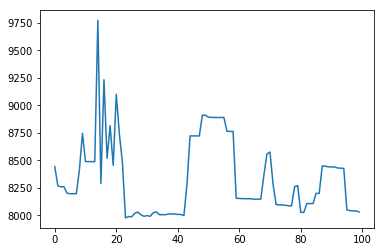

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(0,100),cost_lst)
print(cost_lst)

In [137]:
np.random.seed(7)
ep=EnsemblePursuitPyTorch()
s=time.time()
U_V,nr_of_neurons,U,V, cost_lst=ep.fit_transform(X,100,100)
e=time.time()
print(e-s)
print(nr_of_neurons)
print(cost_lst)

[[31.466291   11.154725    0.         ... 35.939972    0.
   0.        ]
 [41.705284    0.          0.         ...  0.         44.25718
  34.889084  ]
 [ 0.          0.          0.         ... 92.24999    22.162407
  21.241     ]
 ...
 [12.287675   18.75502     0.         ... 15.54476    55.489014
  21.571573  ]
 [14.505278   27.549797    0.         ...  3.5592616   0.
  26.330444  ]
 [ 0.65212256 31.231289    0.         ...  0.         14.375819
  14.927368  ]]


/home/maria/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:138: RuntimeWarning: invalid value encountered in sqrt
  ret = um.sqrt(ret, out=ret)
/home/maria/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: divide by zero encountered in true_divide
  return (a - mns) / sstd
/home/maria/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


[-2.46528060e-08 -7.78509630e-08 -5.44956755e-08 ...  1.29751605e-08
 -1.94627403e-09  5.19006438e-09]
tensor([[ 1.1550, -0.1022, -0.5535,  ...,  0.5873, -0.8588, -0.7753],
        [ 1.7695, -0.8956, -0.5535,  ..., -0.8096,  0.8385,  0.5909],
        [-0.7333, -0.8956, -0.5535,  ...,  2.7760, -0.0089,  0.0565],
        ...,
        [ 0.0041,  0.4383, -0.5535,  ..., -0.2054,  1.2692,  0.0694],
        [ 0.1372,  1.0639, -0.5535,  ..., -0.6713, -0.8588,  0.2557],
        [-0.6942,  1.3257, -0.5535,  ..., -0.8096, -0.3075, -0.1908]],
       device='cuda:0')
5880 10103
norm tensor(7704.2529, device='cuda:0')
cost tensor(0.9992, device='cuda:0')
norm tensor(7698.7349, device='cuda:0')
cost tensor(0.9977, device='cuda:0')
norm tensor(7693.6162, device='cuda:0')
cost tensor(0.9964, device='cuda:0')
norm tensor(7690.1670, device='cuda:0')
cost tensor(0.9955, device='cuda:0')
norm tensor(7686.4624, device='cuda:0')
cost tensor(0.9945, device='cuda:0')
norm tensor(7684.2280, device='cuda:0')
cos

norm tensor(7458.3267, device='cuda:0')
cost tensor(0.9364, device='cuda:0')
torch.Size([5880, 10103])
torch.Size([10103, 100])
torch.Size([100, 5880])
628.0076780319214
[3115, 3553, 2903, 2113, 3150, 1, 2739, 2606, 3182, 2874, 3812, 3873, 3726, 4047, 3930, 4667, 2799, 3534, 3542, 3844, 3314, 1, 3160, 4119, 3459, 4302, 2621, 3725, 3453, 3152, 2367, 3848, 1, 3571, 3430, 3337, 2896, 2644, 2651, 2989, 3367, 3110, 2920, 2718, 2594, 1, 3041, 1893, 1751, 2486, 2792, 1, 3354, 3397, 1, 2791, 2494, 3764, 3659, 2686, 2905, 2565, 1, 2843, 3407, 2978, 1650, 2017, 2860, 1992, 3045, 2984, 2569, 2731, 2808, 2001, 2889, 2958, 2820, 1657, 2926, 2608, 1, 3471, 1, 2967, 2438, 2425, 2685, 2945, 2664, 3214, 2207, 2164, 2316, 2437, 2273, 2566, 2, 2991]
[0.99915611743927, 0.9977254271507263, 0.9963991045951843, 0.9955059885978699, 0.9945471286773682, 0.9939690232276917, 0.9933041930198669, 0.9930580258369446, 0.9922041296958923, 0.9909629821777344, 0.9900705814361572, 0.9890986680984497, 0.9881985187530518, 

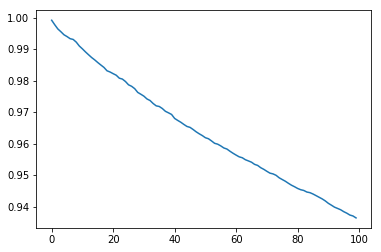

In [138]:
plt.plot(range(100),cost_lst)

In [143]:
np.random.seed(7)
ep=EnsemblePursuitPyTorch()
s=time.time()
U_V,nr_of_neurons,U,V, cost_lst=ep.fit_transform(X,200,100)
e=time.time()
print(e-s)
print(nr_of_neurons)
print(cost_lst)

[[31.466291   11.154725    0.         ... 35.939972    0.
   0.        ]
 [41.705284    0.          0.         ...  0.         44.25718
  34.889084  ]
 [ 0.          0.          0.         ... 92.24999    22.162407
  21.241     ]
 ...
 [12.287675   18.75502     0.         ... 15.54476    55.489014
  21.571573  ]
 [14.505278   27.549797    0.         ...  3.5592616   0.
  26.330444  ]
 [ 0.65212256 31.231289    0.         ...  0.         14.375819
  14.927368  ]]


/home/maria/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:138: RuntimeWarning: invalid value encountered in sqrt
  ret = um.sqrt(ret, out=ret)
/home/maria/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: divide by zero encountered in true_divide
  return (a - mns) / sstd
/home/maria/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


[-2.46528060e-08 -7.78509630e-08 -5.44956755e-08 ...  1.29751605e-08
 -1.94627403e-09  5.19006438e-09]
tensor([[ 1.1550, -0.1022, -0.5535,  ...,  0.5873, -0.8588, -0.7753],
        [ 1.7695, -0.8956, -0.5535,  ..., -0.8096,  0.8385,  0.5909],
        [-0.7333, -0.8956, -0.5535,  ...,  2.7760, -0.0089,  0.0565],
        ...,
        [ 0.0041,  0.4383, -0.5535,  ..., -0.2054,  1.2692,  0.0694],
        [ 0.1372,  1.0639, -0.5535,  ..., -0.6713, -0.8588,  0.2557],
        [-0.6942,  1.3257, -0.5535,  ..., -0.8096, -0.3075, -0.1908]],
       device='cuda:0')
5880 10103
max delta tensor(0., device='cuda:0')
tensor(1.0000, device='cuda:0')
max delta tensor(0., device='cuda:0')
tensor(1., device='cuda:0')
max delta tensor(0., device='cuda:0')
tensor(1.0000, device='cuda:0')
max delta tensor(143.5505, device='cuda:0')
tensor(0.2422, device='cuda:0')
max delta tensor(184.9802, device='cuda:0')
tensor(0.3253, device='cuda:0')
max delta tensor(1118.0935, device='cuda:0')
tensor(0.6679, device='cu

max delta tensor(1082.1766, device='cuda:0')
tensor(0.6410, device='cuda:0')
max delta tensor(1087.0647, device='cuda:0')
tensor(0.6295, device='cuda:0')
max delta tensor(1262.8430, device='cuda:0')
tensor(0.6654, device='cuda:0')
max delta tensor(925.3040, device='cuda:0')
tensor(0.5761, device='cuda:0')
max delta tensor(1215.6947, device='cuda:0')
tensor(0.6559, device='cuda:0')
max delta tensor(1015.1206, device='cuda:0')
tensor(0.6007, device='cuda:0')
max delta tensor(583.2720, device='cuda:0')
tensor(0.4857, device='cuda:0')
max delta tensor(959.3722, device='cuda:0')
tensor(0.6116, device='cuda:0')
max delta tensor(758.3632, device='cuda:0')
tensor(0.5483, device='cuda:0')
max delta tensor(1632.0458, device='cuda:0')
tensor(0.7640, device='cuda:0')
max delta tensor(2048.1526, device='cuda:0')
tensor(0.8071, device='cuda:0')
max delta tensor(792.9097, device='cuda:0')
tensor(0.5163, device='cuda:0')
max delta tensor(452.2899, device='cuda:0')
tensor(0.4406, device='cuda:0')
max d

tensor(0.5384, device='cuda:0')
max delta tensor(513.9032, device='cuda:0')
tensor(0.4921, device='cuda:0')
max delta tensor(814.5865, device='cuda:0')
tensor(0.5884, device='cuda:0')
max delta tensor(543.6139, device='cuda:0')
tensor(0.4936, device='cuda:0')
max delta tensor(686.2590, device='cuda:0')
tensor(0.5451, device='cuda:0')
max delta tensor(494.4880, device='cuda:0')
tensor(0.4789, device='cuda:0')
max delta tensor(692.6655, device='cuda:0')
tensor(0.5503, device='cuda:0')
max delta tensor(659.5873, device='cuda:0')
tensor(0.5338, device='cuda:0')
max delta tensor(301.6109, device='cuda:0')
tensor(0.4074, device='cuda:0')
max delta tensor(386.1357, device='cuda:0')
tensor(0.4545, device='cuda:0')
max delta tensor(672.3869, device='cuda:0')
tensor(0.5560, device='cuda:0')
max delta tensor(904.1249, device='cuda:0')
tensor(0.6113, device='cuda:0')
max delta tensor(798.5923, device='cuda:0')
tensor(0.5673, device='cuda:0')
max delta tensor(955.0918, device='cuda:0')
tensor(0.608

tensor(0.4988, device='cuda:0')
max delta tensor(369.7237, device='cuda:0')
tensor(0.4470, device='cuda:0')
max delta tensor(321.0463, device='cuda:0')
tensor(0.4303, device='cuda:0')
max delta tensor(540.2858, device='cuda:0')
tensor(0.5166, device='cuda:0')
max delta tensor(604.8792, device='cuda:0')
tensor(0.5288, device='cuda:0')
max delta tensor(849.9606, device='cuda:0')
tensor(0.5969, device='cuda:0')
max delta tensor(628.6499, device='cuda:0')
tensor(0.5190, device='cuda:0')
max delta tensor(440.6132, device='cuda:0')
tensor(0.4595, device='cuda:0')
max delta tensor(518.5084, device='cuda:0')
tensor(0.4961, device='cuda:0')
max delta tensor(771.3962, device='cuda:0')
tensor(0.5765, device='cuda:0')
max delta tensor(970.2709, device='cuda:0')
tensor(0.6205, device='cuda:0')
max delta tensor(1332.4985, device='cuda:0')
tensor(0.6951, device='cuda:0')
max delta tensor(601.2357, device='cuda:0')
tensor(0.4881, device='cuda:0')
max delta tensor(522.3662, device='cuda:0')
tensor(0.48

max delta tensor(681.2462, device='cuda:0')
tensor(0.5093, device='cuda:0')
max delta tensor(617.0413, device='cuda:0')
tensor(0.5066, device='cuda:0')
max delta tensor(404.7065, device='cuda:0')
tensor(0.4437, device='cuda:0')
max delta tensor(325.1395, device='cuda:0')
tensor(0.4242, device='cuda:0')
max delta tensor(1107.5173, device='cuda:0')
tensor(0.6812, device='cuda:0')
max delta tensor(278.2102, device='cuda:0')
tensor(0.3907, device='cuda:0')
max delta tensor(520.2188, device='cuda:0')
tensor(0.5015, device='cuda:0')
max delta tensor(483.3360, device='cuda:0')
tensor(0.4852, device='cuda:0')
max delta tensor(525.7357, device='cuda:0')
tensor(0.5003, device='cuda:0')
max delta tensor(641.2144, device='cuda:0')
tensor(0.5370, device='cuda:0')
max delta tensor(755.9693, device='cuda:0')
tensor(0.5663, device='cuda:0')
max delta tensor(561.9639, device='cuda:0')
tensor(0.4991, device='cuda:0')
max delta tensor(721.9330, device='cuda:0')
tensor(0.5548, device='cuda:0')
max delta t

tensor(0.4251, device='cuda:0')
max delta tensor(203.9836, device='cuda:0')
tensor(0.3871, device='cuda:0')
max delta tensor(334.5511, device='cuda:0')
tensor(0.4483, device='cuda:0')
max delta tensor(324.3530, device='cuda:0')
tensor(0.4384, device='cuda:0')
max delta tensor(344.3655, device='cuda:0')
tensor(0.4452, device='cuda:0')
max delta tensor(237.1698, device='cuda:0')
tensor(0.3977, device='cuda:0')
max delta tensor(567.5964, device='cuda:0')
tensor(0.5326, device='cuda:0')
max delta tensor(469.9434, device='cuda:0')
tensor(0.4835, device='cuda:0')
max delta tensor(661.6320, device='cuda:0')
tensor(0.5472, device='cuda:0')
max delta tensor(649.2051, device='cuda:0')
tensor(0.5342, device='cuda:0')
max delta tensor(623.4920, device='cuda:0')
tensor(0.5234, device='cuda:0')
max delta tensor(672.2951, device='cuda:0')
tensor(0.5388, device='cuda:0')
max delta tensor(771.2820, device='cuda:0')
tensor(0.5664, device='cuda:0')
max delta tensor(570.3405, device='cuda:0')
tensor(0.499

max delta tensor(273.6539, device='cuda:0')
tensor(0.4134, device='cuda:0')
max delta tensor(173.8629, device='cuda:0')
tensor(0.3710, device='cuda:0')
max delta tensor(175.9208, device='cuda:0')
tensor(0.3774, device='cuda:0')
max delta tensor(565.7737, device='cuda:0')
tensor(0.5407, device='cuda:0')
max delta tensor(344.2106, device='cuda:0')
tensor(0.4387, device='cuda:0')
max delta tensor(1390.9150, device='cuda:0')
tensor(0.7546, device='cuda:0')
max delta tensor(476.3829, device='cuda:0')
tensor(0.4583, device='cuda:0')
max delta tensor(358.4600, device='cuda:0')
tensor(0.4307, device='cuda:0')
max delta tensor(681.2806, device='cuda:0')
tensor(0.5545, device='cuda:0')
max delta tensor(966.1796, device='cuda:0')
tensor(0.6256, device='cuda:0')
max delta tensor(564.3636, device='cuda:0')
tensor(0.4931, device='cuda:0')
max delta tensor(508.2960, device='cuda:0')
tensor(0.4834, device='cuda:0')
max delta tensor(586.0182, device='cuda:0')
tensor(0.5153, device='cuda:0')
max delta t

max delta tensor(494.7263, device='cuda:0')
tensor(0.4530, device='cuda:0')
max delta tensor(748.8455, device='cuda:0')
tensor(0.5551, device='cuda:0')
max delta tensor(1396.1045, device='cuda:0')
tensor(0.7190, device='cuda:0')
max delta tensor(475.1630, device='cuda:0')
tensor(0.4491, device='cuda:0')
max delta tensor(377.7009, device='cuda:0')
tensor(0.4357, device='cuda:0')
max delta tensor(412.8051, device='cuda:0')
tensor(0.4605, device='cuda:0')
max delta tensor(397.1388, device='cuda:0')
tensor(0.4575, device='cuda:0')
max delta tensor(625.9722, device='cuda:0')
tensor(0.5397, device='cuda:0')
max delta tensor(418.4098, device='cuda:0')
tensor(0.4584, device='cuda:0')
max delta tensor(722.1548, device='cuda:0')
tensor(0.5660, device='cuda:0')
max delta tensor(481.1071, device='cuda:0')
tensor(0.4763, device='cuda:0')
max delta tensor(386.8430, device='cuda:0')
tensor(0.4472, device='cuda:0')
max delta tensor(959.6696, device='cuda:0')
tensor(0.6369, device='cuda:0')
max delta t

tensor(0.4740, device='cuda:0')
max delta tensor(450.3250, device='cuda:0')
tensor(0.4752, device='cuda:0')
max delta tensor(797.7784, device='cuda:0')
tensor(0.5894, device='cuda:0')
max delta tensor(131.3174, device='cuda:0')
tensor(0.3306, device='cuda:0')
max delta tensor(248.8952, device='cuda:0')
tensor(0.4057, device='cuda:0')
max delta tensor(478.9722, device='cuda:0')
tensor(0.5019, device='cuda:0')
max delta tensor(357.2169, device='cuda:0')
tensor(0.4446, device='cuda:0')
max delta tensor(202.7598, device='cuda:0')
tensor(0.3793, device='cuda:0')
max delta tensor(234.0551, device='cuda:0')
tensor(0.4011, device='cuda:0')
max delta tensor(333.9929, device='cuda:0')
tensor(0.4460, device='cuda:0')
max delta tensor(391.0809, device='cuda:0')
tensor(0.4647, device='cuda:0')
max delta tensor(452.5391, device='cuda:0')
tensor(0.4841, device='cuda:0')
max delta tensor(250.7979, device='cuda:0')
tensor(0.3986, device='cuda:0')
max delta tensor(382.6344, device='cuda:0')
tensor(0.461

tensor(0.4355, device='cuda:0')
max delta tensor(573.7031, device='cuda:0')
tensor(0.5372, device='cuda:0')
max delta tensor(709.9763, device='cuda:0')
tensor(0.5644, device='cuda:0')
max delta tensor(419.7770, device='cuda:0')
tensor(0.4559, device='cuda:0')
max delta tensor(388.0459, device='cuda:0')
tensor(0.4510, device='cuda:0')
max delta tensor(256.7603, device='cuda:0')
tensor(0.4008, device='cuda:0')
max delta tensor(304.8937, device='cuda:0')
tensor(0.4289, device='cuda:0')
max delta tensor(346.9009, device='cuda:0')
tensor(0.4465, device='cuda:0')
max delta tensor(216.2321, device='cuda:0')
tensor(0.3880, device='cuda:0')
max delta tensor(174.1548, device='cuda:0')
tensor(0.3726, device='cuda:0')
max delta tensor(466.1983, device='cuda:0')
tensor(0.5018, device='cuda:0')
max delta tensor(403.2525, device='cuda:0')
tensor(0.4649, device='cuda:0')
max delta tensor(351.8682, device='cuda:0')
tensor(0.4430, device='cuda:0')
max delta tensor(1141.3763, device='cuda:0')
tensor(0.69

max delta tensor(271.9734, device='cuda:0')
tensor(0.3900, device='cuda:0')
max delta tensor(267.8072, device='cuda:0')
tensor(0.4052, device='cuda:0')
max delta tensor(234.4999, device='cuda:0')
tensor(0.3970, device='cuda:0')
max delta tensor(327.0199, device='cuda:0')
tensor(0.4414, device='cuda:0')
max delta tensor(180.2923, device='cuda:0')
tensor(0.3726, device='cuda:0')
max delta tensor(173.9894, device='cuda:0')
tensor(0.3746, device='cuda:0')
max delta tensor(360.5198, device='cuda:0')
tensor(0.4613, device='cuda:0')
max delta tensor(501.1713, device='cuda:0')
tensor(0.5065, device='cuda:0')
max delta tensor(273.2465, device='cuda:0')
tensor(0.4081, device='cuda:0')
max delta tensor(334.2861, device='cuda:0')
tensor(0.4401, device='cuda:0')
max delta tensor(315.8365, device='cuda:0')
tensor(0.4319, device='cuda:0')
max delta tensor(419.3178, device='cuda:0')
tensor(0.4743, device='cuda:0')
max delta tensor(478.1941, device='cuda:0')
tensor(0.4913, device='cuda:0')
max delta te

max delta tensor(646.1178, device='cuda:0')
tensor(0.5272, device='cuda:0')
max delta tensor(922.2988, device='cuda:0')
tensor(0.6084, device='cuda:0')
max delta tensor(1122.1864, device='cuda:0')
tensor(0.6482, device='cuda:0')
max delta tensor(773.5450, device='cuda:0')
tensor(0.5454, device='cuda:0')
max delta tensor(437.7156, device='cuda:0')
tensor(0.4481, device='cuda:0')
max delta tensor(498.6445, device='cuda:0')
tensor(0.4850, device='cuda:0')
max delta tensor(416.8939, device='cuda:0')
tensor(0.4587, device='cuda:0')
max delta tensor(284.8064, device='cuda:0')
tensor(0.4107, device='cuda:0')
max delta tensor(180.3319, device='cuda:0')
tensor(0.3700, device='cuda:0')
max delta tensor(45.0035, device='cuda:0')
tensor(0.3026, device='cuda:0')
max delta tensor(322.6516, device='cuda:0')
tensor(0.4536, device='cuda:0')
max delta tensor(728.1520, device='cuda:0')
tensor(0.5891, device='cuda:0')
max delta tensor(317.4666, device='cuda:0')
tensor(0.4214, device='cuda:0')
max delta te

tensor(0.6106, device='cuda:0')
max delta tensor(99.7132, device='cuda:0')
tensor(0.3166, device='cuda:0')
max delta tensor(438.1784, device='cuda:0')
tensor(0.4871, device='cuda:0')
max delta tensor(188.7020, device='cuda:0')
tensor(0.3734, device='cuda:0')
max delta tensor(451.4822, device='cuda:0')
tensor(0.4933, device='cuda:0')
max delta tensor(371.0148, device='cuda:0')
tensor(0.4524, device='cuda:0')
max delta tensor(169.9781, device='cuda:0')
tensor(0.3638, device='cuda:0')
max delta tensor(239.2947, device='cuda:0')
tensor(0.4052, device='cuda:0')
max delta tensor(216.3754, device='cuda:0')
tensor(0.3942, device='cuda:0')
max delta tensor(438.8839, device='cuda:0')
tensor(0.4898, device='cuda:0')
max delta tensor(463.4317, device='cuda:0')
tensor(0.4879, device='cuda:0')
max delta tensor(359.6894, device='cuda:0')
tensor(0.4441, device='cuda:0')
max delta tensor(337.1840, device='cuda:0')
tensor(0.4374, device='cuda:0')
max delta tensor(352.4865, device='cuda:0')
tensor(0.4454

max delta tensor(406.6482, device='cuda:0')
tensor(0.4572, device='cuda:0')
max delta tensor(300.8583, device='cuda:0')
tensor(0.4188, device='cuda:0')
max delta tensor(714.8716, device='cuda:0')
tensor(0.5738, device='cuda:0')
max delta tensor(862.7847, device='cuda:0')
tensor(0.5994, device='cuda:0')
max delta tensor(438.2260, device='cuda:0')
tensor(0.4542, device='cuda:0')
max delta tensor(514.4337, device='cuda:0')
tensor(0.4925, device='cuda:0')
max delta tensor(293.8657, device='cuda:0')
tensor(0.4109, device='cuda:0')
max delta tensor(258.9969, device='cuda:0')
tensor(0.4049, device='cuda:0')
max delta tensor(248.9772, device='cuda:0')
tensor(0.4056, device='cuda:0')
max delta tensor(200.8733, device='cuda:0')
tensor(0.3852, device='cuda:0')
max delta tensor(145.6689, device='cuda:0')
tensor(0.3603, device='cuda:0')
max delta tensor(296.0883, device='cuda:0')
tensor(0.4362, device='cuda:0')
max delta tensor(480.7664, device='cuda:0')
tensor(0.5032, device='cuda:0')
max delta te

max delta tensor(1027.9827, device='cuda:0')
tensor(0.6535, device='cuda:0')
max delta tensor(776.0657, device='cuda:0')
tensor(0.5590, device='cuda:0')
max delta tensor(1302.1384, device='cuda:0')
tensor(0.6935, device='cuda:0')
max delta tensor(787.2624, device='cuda:0')
tensor(0.5444, device='cuda:0')
max delta tensor(965.5521, device='cuda:0')
tensor(0.6028, device='cuda:0')
max delta tensor(1281.8499, device='cuda:0')
tensor(0.6766, device='cuda:0')
max delta tensor(739.2289, device='cuda:0')
tensor(0.5277, device='cuda:0')
max delta tensor(1265.4233, device='cuda:0')
tensor(0.6771, device='cuda:0')
max delta tensor(1175.1532, device='cuda:0')
tensor(0.6408, device='cuda:0')
max delta tensor(1184.8391, device='cuda:0')
tensor(0.6405, device='cuda:0')
max delta tensor(1094.1561, device='cuda:0')
tensor(0.6176, device='cuda:0')
max delta tensor(758.7889, device='cuda:0')
tensor(0.5340, device='cuda:0')
max delta tensor(663.8010, device='cuda:0')
tensor(0.5194, device='cuda:0')
max d

max delta tensor(589.8936, device='cuda:0')
tensor(0.5068, device='cuda:0')
max delta tensor(1124.7061, device='cuda:0')
tensor(0.6627, device='cuda:0')
max delta tensor(1113.0641, device='cuda:0')
tensor(0.6384, device='cuda:0')
max delta tensor(647.9628, device='cuda:0')
tensor(0.5068, device='cuda:0')
max delta tensor(401.6653, device='cuda:0')
tensor(0.4385, device='cuda:0')
max delta tensor(220.7702, device='cuda:0')
tensor(0.3786, device='cuda:0')
max delta tensor(490.6733, device='cuda:0')
tensor(0.5009, device='cuda:0')
max delta tensor(1126.3654, device='cuda:0')
tensor(0.6837, device='cuda:0')
max delta tensor(182.4839, device='cuda:0')
tensor(0.3489, device='cuda:0')
max delta tensor(563.8130, device='cuda:0')
tensor(0.5221, device='cuda:0')
max delta tensor(364.3036, device='cuda:0')
tensor(0.4410, device='cuda:0')
max delta tensor(487.0784, device='cuda:0')
tensor(0.4928, device='cuda:0')
max delta tensor(613.7563, device='cuda:0')
tensor(0.5323, device='cuda:0')
max delta

max delta tensor(773.7905, device='cuda:0')
tensor(0.5380, device='cuda:0')
max delta tensor(664.0358, device='cuda:0')
tensor(0.5189, device='cuda:0')
max delta tensor(836.9011, device='cuda:0')
tensor(0.5786, device='cuda:0')
max delta tensor(1058.1704, device='cuda:0')
tensor(0.6333, device='cuda:0')
max delta tensor(931.8499, device='cuda:0')
tensor(0.5907, device='cuda:0')
max delta tensor(1819.6373, device='cuda:0')
tensor(0.7906, device='cuda:0')
max delta tensor(672.1138, device='cuda:0')
tensor(0.4956, device='cuda:0')
max delta tensor(721.2050, device='cuda:0')
tensor(0.5336, device='cuda:0')
max delta tensor(877.4495, device='cuda:0')
tensor(0.5860, device='cuda:0')
max delta tensor(947.9833, device='cuda:0')
tensor(0.6015, device='cuda:0')
max delta tensor(587.3941, device='cuda:0')
tensor(0.4948, device='cuda:0')
max delta tensor(912.5768, device='cuda:0')
tensor(0.6023, device='cuda:0')
max delta tensor(801.0261, device='cuda:0')
tensor(0.5631, device='cuda:0')
max delta 

tensor(0.4966, device='cuda:0')
max delta tensor(385.0329, device='cuda:0')
tensor(0.4458, device='cuda:0')
max delta tensor(411.1763, device='cuda:0')
tensor(0.4626, device='cuda:0')
max delta tensor(302.1469, device='cuda:0')
tensor(0.4206, device='cuda:0')
max delta tensor(410.5083, device='cuda:0')
tensor(0.4700, device='cuda:0')
max delta tensor(310.3600, device='cuda:0')
tensor(0.4264, device='cuda:0')
max delta tensor(350.3679, device='cuda:0')
tensor(0.4461, device='cuda:0')
max delta tensor(635.4595, device='cuda:0')
tensor(0.5488, device='cuda:0')
max delta tensor(772.8087, device='cuda:0')
tensor(0.5769, device='cuda:0')
max delta tensor(633.9525, device='cuda:0')
tensor(0.5236, device='cuda:0')
max delta tensor(454.2703, device='cuda:0')
tensor(0.4653, device='cuda:0')
max delta tensor(718.5859, device='cuda:0')
tensor(0.5609, device='cuda:0')
max delta tensor(665.7398, device='cuda:0')
tensor(0.5377, device='cuda:0')
max delta tensor(1021.5052, device='cuda:0')
tensor(0.63

max delta tensor(485.1370, device='cuda:0')
tensor(0.4713, device='cuda:0')
max delta tensor(378.2808, device='cuda:0')
tensor(0.4415, device='cuda:0')
max delta tensor(480.1799, device='cuda:0')
tensor(0.4876, device='cuda:0')
max delta tensor(335.6089, device='cuda:0')
tensor(0.4314, device='cuda:0')
max delta tensor(454.3518, device='cuda:0')
tensor(0.4829, device='cuda:0')
max delta tensor(492.6722, device='cuda:0')
tensor(0.4947, device='cuda:0')
max delta tensor(1784.0739, device='cuda:0')
tensor(0.8318, device='cuda:0')
max delta tensor(292.0105, device='cuda:0')
tensor(0.3824, device='cuda:0')
max delta tensor(272.5990, device='cuda:0')
tensor(0.4003, device='cuda:0')
max delta tensor(437.8904, device='cuda:0')
tensor(0.4778, device='cuda:0')
max delta tensor(434.7752, device='cuda:0')
tensor(0.4737, device='cuda:0')
max delta tensor(224.3416, device='cuda:0')
tensor(0.3862, device='cuda:0')
max delta tensor(367.5767, device='cuda:0')
tensor(0.4591, device='cuda:0')
max delta t

max delta tensor(761.5680, device='cuda:0')
tensor(0.5731, device='cuda:0')
max delta tensor(566.6503, device='cuda:0')
tensor(0.5032, device='cuda:0')
max delta tensor(158.5168, device='cuda:0')
tensor(0.3475, device='cuda:0')
max delta tensor(150.5529, device='cuda:0')
tensor(0.3602, device='cuda:0')
max delta tensor(543.6767, device='cuda:0')
tensor(0.5341, device='cuda:0')
max delta tensor(534.9747, device='cuda:0')
tensor(0.5121, device='cuda:0')
max delta tensor(366.6840, device='cuda:0')
tensor(0.4438, device='cuda:0')
max delta tensor(449.8629, device='cuda:0')
tensor(0.4817, device='cuda:0')
max delta tensor(570.3443, device='cuda:0')
tensor(0.5214, device='cuda:0')
max delta tensor(351.4606, device='cuda:0')
tensor(0.4382, device='cuda:0')
max delta tensor(243.1668, device='cuda:0')
tensor(0.3980, device='cuda:0')
max delta tensor(273.8690, device='cuda:0')
tensor(0.4182, device='cuda:0')
max delta tensor(827.1208, device='cuda:0')
tensor(0.6192, device='cuda:0')
max delta te

max delta tensor(624.5602, device='cuda:0')
tensor(0.5185, device='cuda:0')
max delta tensor(878.3032, device='cuda:0')
tensor(0.5968, device='cuda:0')
max delta tensor(641.4236, device='cuda:0')
tensor(0.5194, device='cuda:0')
max delta tensor(448.7958, device='cuda:0')
tensor(0.4610, device='cuda:0')
max delta tensor(516.5697, device='cuda:0')
tensor(0.4948, device='cuda:0')
max delta tensor(772.9658, device='cuda:0')
tensor(0.5770, device='cuda:0')
max delta tensor(972.9431, device='cuda:0')
tensor(0.6212, device='cuda:0')
max delta tensor(1334.8048, device='cuda:0')
tensor(0.6955, device='cuda:0')
max delta tensor(562.4810, device='cuda:0')
tensor(0.4761, device='cuda:0')
max delta tensor(622.8800, device='cuda:0')
tensor(0.5147, device='cuda:0')
max delta tensor(744.7593, device='cuda:0')
tensor(0.5578, device='cuda:0')
max delta tensor(589.9360, device='cuda:0')
tensor(0.5072, device='cuda:0')
max delta tensor(575.7888, device='cuda:0')
tensor(0.5090, device='cuda:0')
max delta t

max delta tensor(245.4346, device='cuda:0')
tensor(0.3875, device='cuda:0')
max delta tensor(226.4083, device='cuda:0')
tensor(0.3913, device='cuda:0')
max delta tensor(91.6722, device='cuda:0')
tensor(0.3287, device='cuda:0')
max delta tensor(118.3806, device='cuda:0')
tensor(0.3521, device='cuda:0')
max delta tensor(88.4096, device='cuda:0')
tensor(0.3356, device='cuda:0')
max delta tensor(565.8668, device='cuda:0')
tensor(0.5510, device='cuda:0')
max delta tensor(420.6190, device='cuda:0')
tensor(0.4719, device='cuda:0')
max delta tensor(620.9502, device='cuda:0')
tensor(0.5413, device='cuda:0')
max delta tensor(562.6138, device='cuda:0')
tensor(0.5114, device='cuda:0')
max delta tensor(3045.4900, device='cuda:0')
tensor(1.0547, device='cuda:0')
max delta tensor(814.1074, device='cuda:0')
tensor(0.5223, device='cuda:0')
max delta tensor(659.8070, device='cuda:0')
tensor(0.5066, device='cuda:0')
max delta tensor(1089.6586, device='cuda:0')
tensor(0.6417, device='cuda:0')
max delta te

max delta tensor(1094.0315, device='cuda:0')
tensor(0.6626, device='cuda:0')
max delta tensor(946.3168, device='cuda:0')
tensor(0.6029, device='cuda:0')
max delta tensor(528.6582, device='cuda:0')
tensor(0.4783, device='cuda:0')
max delta tensor(1101.3439, device='cuda:0')
tensor(0.6580, device='cuda:0')
max delta tensor(341.9747, device='cuda:0')
tensor(0.4119, device='cuda:0')
max delta tensor(623.1031, device='cuda:0')
tensor(0.5332, device='cuda:0')
max delta tensor(807.3618, device='cuda:0')
tensor(0.5850, device='cuda:0')
max delta tensor(528.4907, device='cuda:0')
tensor(0.4908, device='cuda:0')
max delta tensor(657.8278, device='cuda:0')
tensor(0.5386, device='cuda:0')
max delta tensor(811.3254, device='cuda:0')
tensor(0.5830, device='cuda:0')
max delta tensor(448.4392, device='cuda:0')
tensor(0.4621, device='cuda:0')
max delta tensor(446.3473, device='cuda:0')
tensor(0.4709, device='cuda:0')
max delta tensor(588.3484, device='cuda:0')
tensor(0.5239, device='cuda:0')
max delta 

max delta tensor(549.6346, device='cuda:0')
tensor(0.5029, device='cuda:0')
max delta tensor(589.1852, device='cuda:0')
tensor(0.5168, device='cuda:0')
max delta tensor(377.4150, device='cuda:0')
tensor(0.4411, device='cuda:0')
max delta tensor(294.4371, device='cuda:0')
tensor(0.4157, device='cuda:0')
max delta tensor(699.8879, device='cuda:0')
tensor(0.5702, device='cuda:0')
max delta tensor(316.0006, device='cuda:0')
tensor(0.4204, device='cuda:0')
max delta tensor(577.1313, device='cuda:0')
tensor(0.5269, device='cuda:0')
max delta tensor(892.6511, device='cuda:0')
tensor(0.6136, device='cuda:0')
max delta tensor(331.8790, device='cuda:0')
tensor(0.4162, device='cuda:0')
max delta tensor(314.0770, device='cuda:0')
tensor(0.4239, device='cuda:0')
max delta tensor(530.8204, device='cuda:0')
tensor(0.5134, device='cuda:0')
max delta tensor(645.0020, device='cuda:0')
tensor(0.5426, device='cuda:0')
max delta tensor(307.2730, device='cuda:0')
tensor(0.4146, device='cuda:0')
max delta te

max delta tensor(464.7212, device='cuda:0')
tensor(0.4792, device='cuda:0')
max delta tensor(489.7540, device='cuda:0')
tensor(0.4890, device='cuda:0')
max delta tensor(503.8977, device='cuda:0')
tensor(0.4932, device='cuda:0')
max delta tensor(402.2792, device='cuda:0')
tensor(0.4567, device='cuda:0')
max delta tensor(611.0869, device='cuda:0')
tensor(0.5341, device='cuda:0')
max delta tensor(722.0118, device='cuda:0')
tensor(0.5607, device='cuda:0')
max delta tensor(736.1392, device='cuda:0')
tensor(0.5571, device='cuda:0')
max delta tensor(520.6547, device='cuda:0')
tensor(0.4864, device='cuda:0')
max delta tensor(597.5183, device='cuda:0')
tensor(0.5219, device='cuda:0')
max delta tensor(453.6151, device='cuda:0')
tensor(0.4709, device='cuda:0')
max delta tensor(470.2142, device='cuda:0')
tensor(0.4812, device='cuda:0')
max delta tensor(842.9614, device='cuda:0')
tensor(0.6015, device='cuda:0')
max delta tensor(464.7321, device='cuda:0')
tensor(0.4670, device='cuda:0')
max delta te

tensor(0.6347, device='cuda:0')
max delta tensor(1512.2087, device='cuda:0')
tensor(0.7283, device='cuda:0')
max delta tensor(1002.2268, device='cuda:0')
tensor(0.5908, device='cuda:0')
max delta tensor(1073.9323, device='cuda:0')
tensor(0.6169, device='cuda:0')
max delta tensor(1171.4258, device='cuda:0')
tensor(0.6433, device='cuda:0')
max delta tensor(1952.4248, device='cuda:0')
tensor(0.8035, device='cuda:0')
max delta tensor(1450.7793, device='cuda:0')
tensor(0.6746, device='cuda:0')
max delta tensor(906.1520, device='cuda:0')
tensor(0.5554, device='cuda:0')
max delta tensor(539.6577, device='cuda:0')
tensor(0.4696, device='cuda:0')
max delta tensor(811.7300, device='cuda:0')
tensor(0.5720, device='cuda:0')
max delta tensor(756.3343, device='cuda:0')
tensor(0.5535, device='cuda:0')
max delta tensor(688.3906, device='cuda:0')
tensor(0.5352, device='cuda:0')
max delta tensor(786.7161, device='cuda:0')
tensor(0.5676, device='cuda:0')
max delta tensor(485.0651, device='cuda:0')
tensor

max delta tensor(1153.1118, device='cuda:0')
tensor(0.6943, device='cuda:0')
max delta tensor(194.4641, device='cuda:0')
tensor(0.3555, device='cuda:0')
max delta tensor(637.7545, device='cuda:0')
tensor(0.5469, device='cuda:0')
max delta tensor(599.3491, device='cuda:0')
tensor(0.5225, device='cuda:0')
max delta tensor(601.6494, device='cuda:0')
tensor(0.5211, device='cuda:0')
max delta tensor(873.5865, device='cuda:0')
tensor(0.6016, device='cuda:0')
max delta tensor(1073.4426, device='cuda:0')
tensor(0.6411, device='cuda:0')
max delta tensor(767.2009, device='cuda:0')
tensor(0.5472, device='cuda:0')
max delta tensor(436.9324, device='cuda:0')
tensor(0.4495, device='cuda:0')
max delta tensor(765.9033, device='cuda:0')
tensor(0.5725, device='cuda:0')
max delta tensor(732.2858, device='cuda:0')
tensor(0.5536, device='cuda:0')
max delta tensor(661.8925, device='cuda:0')
tensor(0.5305, device='cuda:0')
max delta tensor(1041.9229, device='cuda:0')
tensor(0.6396, device='cuda:0')
max delta

tensor(0.5358, device='cuda:0')
max delta tensor(638.8487, device='cuda:0')
tensor(0.5212, device='cuda:0')
max delta tensor(456.6213, device='cuda:0')
tensor(0.4648, device='cuda:0')
max delta tensor(858.8856, device='cuda:0')
tensor(0.6019, device='cuda:0')
max delta tensor(420.3272, device='cuda:0')
tensor(0.4497, device='cuda:0')
max delta tensor(1125.4246, device='cuda:0')
tensor(0.6754, device='cuda:0')
max delta tensor(762.3129, device='cuda:0')
tensor(0.5514, device='cuda:0')
max delta tensor(600.6031, device='cuda:0')
tensor(0.5060, device='cuda:0')
max delta tensor(624.1226, device='cuda:0')
tensor(0.5219, device='cuda:0')
max delta tensor(677.7839, device='cuda:0')
tensor(0.5402, device='cuda:0')
max delta tensor(328.9235, device='cuda:0')
tensor(0.4184, device='cuda:0')
max delta tensor(287.6367, device='cuda:0')
tensor(0.4134, device='cuda:0')
max delta tensor(377.3719, device='cuda:0')
tensor(0.4564, device='cuda:0')
max delta tensor(1126.4298, device='cuda:0')
tensor(0.6

max delta tensor(684.2798, device='cuda:0')
tensor(0.5186, device='cuda:0')
max delta tensor(1040.4181, device='cuda:0')
tensor(0.6291, device='cuda:0')
max delta tensor(1095.9757, device='cuda:0')
tensor(0.6335, device='cuda:0')
max delta tensor(752.4510, device='cuda:0')
tensor(0.5377, device='cuda:0')
max delta tensor(981.0587, device='cuda:0')
tensor(0.6103, device='cuda:0')
max delta tensor(1079.9783, device='cuda:0')
tensor(0.6302, device='cuda:0')
max delta tensor(755.6357, device='cuda:0')
tensor(0.5394, device='cuda:0')
max delta tensor(508.4357, device='cuda:0')
tensor(0.4727, device='cuda:0')
max delta tensor(548.9037, device='cuda:0')
tensor(0.4998, device='cuda:0')
max delta tensor(788.7555, device='cuda:0')
tensor(0.5786, device='cuda:0')
max delta tensor(910.7739, device='cuda:0')
tensor(0.6042, device='cuda:0')
max delta tensor(814.2633, device='cuda:0')
tensor(0.5689, device='cuda:0')
max delta tensor(1109.8468, device='cuda:0')
tensor(0.6465, device='cuda:0')
max delt

max delta tensor(243.6778, device='cuda:0')
tensor(0.3783, device='cuda:0')
max delta tensor(453.7457, device='cuda:0')
tensor(0.4833, device='cuda:0')
max delta tensor(569.4689, device='cuda:0')
tensor(0.5213, device='cuda:0')
max delta tensor(832.6821, device='cuda:0')
tensor(0.5958, device='cuda:0')
max delta tensor(718.6094, device='cuda:0')
tensor(0.5478, device='cuda:0')
max delta tensor(444.6515, device='cuda:0')
tensor(0.4584, device='cuda:0')
max delta tensor(573.8917, device='cuda:0')
tensor(0.5144, device='cuda:0')
max delta tensor(669.1916, device='cuda:0')
tensor(0.5442, device='cuda:0')
max delta tensor(525.5170, device='cuda:0')
tensor(0.4934, device='cuda:0')
max delta tensor(660.8373, device='cuda:0')
tensor(0.5436, device='cuda:0')
max delta tensor(453.4887, device='cuda:0')
tensor(0.4695, device='cuda:0')
max delta tensor(525.2541, device='cuda:0')
tensor(0.5010, device='cuda:0')
max delta tensor(464.4343, device='cuda:0')
tensor(0.4783, device='cuda:0')
max delta te

max delta tensor(227.1764, device='cuda:0')
tensor(0.3955, device='cuda:0')
max delta tensor(413.7441, device='cuda:0')
tensor(0.4819, device='cuda:0')
max delta tensor(1743.6545, device='cuda:0')
tensor(0.8435, device='cuda:0')
max delta tensor(665.3685, device='cuda:0')
tensor(0.5135, device='cuda:0')
max delta tensor(1068.2257, device='cuda:0')
tensor(0.6398, device='cuda:0')
max delta tensor(1072.4521, device='cuda:0')
tensor(0.6304, device='cuda:0')
max delta tensor(976.3832, device='cuda:0')
tensor(0.6008, device='cuda:0')
max delta tensor(1105.5933, device='cuda:0')
tensor(0.6341, device='cuda:0')
max delta tensor(737.9254, device='cuda:0')
tensor(0.5345, device='cuda:0')
max delta tensor(738.9435, device='cuda:0')
tensor(0.5452, device='cuda:0')
max delta tensor(743.9275, device='cuda:0')
tensor(0.5512, device='cuda:0')
max delta tensor(729.4708, device='cuda:0')
tensor(0.5478, device='cuda:0')
max delta tensor(740.6753, device='cuda:0')
tensor(0.5520, device='cuda:0')
max delt

max delta tensor(426.8367, device='cuda:0')
tensor(0.4583, device='cuda:0')
max delta tensor(532.8030, device='cuda:0')
tensor(0.5040, device='cuda:0')
max delta tensor(482.9698, device='cuda:0')
tensor(0.4850, device='cuda:0')
max delta tensor(424.3104, device='cuda:0')
tensor(0.4655, device='cuda:0')
max delta tensor(3281.2029, device='cuda:0')
tensor(1.1053, device='cuda:0')
max delta tensor(686.6024, device='cuda:0')
tensor(0.4866, device='cuda:0')
max delta tensor(583.7384, device='cuda:0')
tensor(0.4884, device='cuda:0')
max delta tensor(386.6236, device='cuda:0')
tensor(0.4365, device='cuda:0')
max delta tensor(904.9661, device='cuda:0')
tensor(0.6191, device='cuda:0')
max delta tensor(742.2231, device='cuda:0')
tensor(0.5539, device='cuda:0')
max delta tensor(630.3742, device='cuda:0')
tensor(0.5212, device='cuda:0')
max delta tensor(437.3708, device='cuda:0')
tensor(0.4604, device='cuda:0')
max delta tensor(504.6810, device='cuda:0')
tensor(0.4936, device='cuda:0')
max delta t

max delta tensor(627.0333, device='cuda:0')
tensor(0.5254, device='cuda:0')
max delta tensor(948.6267, device='cuda:0')
tensor(0.6187, device='cuda:0')
max delta tensor(404.9415, device='cuda:0')
tensor(0.4398, device='cuda:0')
max delta tensor(454.3830, device='cuda:0')
tensor(0.4730, device='cuda:0')
max delta tensor(662.2836, device='cuda:0')
tensor(0.5469, device='cuda:0')
max delta tensor(642.5823, device='cuda:0')
tensor(0.5323, device='cuda:0')
max delta tensor(289.7104, device='cuda:0')
tensor(0.4044, device='cuda:0')
max delta tensor(375.5236, device='cuda:0')
tensor(0.4522, device='cuda:0')
max delta tensor(664.5585, device='cuda:0')
tensor(0.5556, device='cuda:0')
max delta tensor(893.1040, device='cuda:0')
tensor(0.6099, device='cuda:0')
max delta tensor(807.3366, device='cuda:0')
tensor(0.5713, device='cuda:0')
max delta tensor(938.8599, device='cuda:0')
tensor(0.6041, device='cuda:0')
max delta tensor(748.1446, device='cuda:0')
tensor(0.5471, device='cuda:0')
max delta te

max delta tensor(297.3686, device='cuda:0')
tensor(0.4210, device='cuda:0')
max delta tensor(326.5253, device='cuda:0')
tensor(0.4372, device='cuda:0')
max delta tensor(372.0883, device='cuda:0')
tensor(0.4557, device='cuda:0')
max delta tensor(650.6233, device='cuda:0')
tensor(0.5534, device='cuda:0')
max delta tensor(702.9935, device='cuda:0')
tensor(0.5567, device='cuda:0')
max delta tensor(639.7664, device='cuda:0')
tensor(0.5292, device='cuda:0')
max delta tensor(1027.8207, device='cuda:0')
tensor(0.6398, device='cuda:0')
max delta tensor(419.6064, device='cuda:0')
tensor(0.4419, device='cuda:0')
max delta tensor(1221.0485, device='cuda:0')
tensor(0.6924, device='cuda:0')
max delta tensor(1504.0868, device='cuda:0')
tensor(0.7260, device='cuda:0')
max delta tensor(941.7937, device='cuda:0')
tensor(0.5753, device='cuda:0')
max delta tensor(618.9783, device='cuda:0')
tensor(0.4964, device='cuda:0')
max delta tensor(679.4700, device='cuda:0')
tensor(0.5305, device='cuda:0')
max delta

max delta tensor(487.3257, device='cuda:0')
tensor(0.5017, device='cuda:0')
max delta tensor(387.4473, device='cuda:0')
tensor(0.4556, device='cuda:0')
max delta tensor(192.5797, device='cuda:0')
tensor(0.3735, device='cuda:0')
max delta tensor(141.9211, device='cuda:0')
tensor(0.3561, device='cuda:0')
max delta tensor(222.0622, device='cuda:0')
tensor(0.4019, device='cuda:0')
max delta tensor(426.5348, device='cuda:0')
tensor(0.4866, device='cuda:0')
max delta tensor(275.3995, device='cuda:0')
tensor(0.4147, device='cuda:0')
max delta tensor(619.8413, device='cuda:0')
tensor(0.5480, device='cuda:0')
max delta tensor(505.6746, device='cuda:0')
tensor(0.4936, device='cuda:0')
max delta tensor(366.7198, device='cuda:0')
tensor(0.4416, device='cuda:0')
max delta tensor(348.4030, device='cuda:0')
tensor(0.4398, device='cuda:0')
max delta tensor(1009.8844, device='cuda:0')
tensor(0.6586, device='cuda:0')
max delta tensor(599.2376, device='cuda:0')
tensor(0.5092, device='cuda:0')
max delta t

tensor(0.4784, device='cuda:0')
max delta tensor(625.3281, device='cuda:0')
tensor(0.5404, device='cuda:0')
max delta tensor(564.4319, device='cuda:0')
tensor(0.5112, device='cuda:0')
max delta tensor(571.5314, device='cuda:0')
tensor(0.5123, device='cuda:0')
max delta tensor(402.8989, device='cuda:0')
tensor(0.4519, device='cuda:0')
max delta tensor(492.5713, device='cuda:0')
tensor(0.4921, device='cuda:0')
max delta tensor(549.1201, device='cuda:0')
tensor(0.5123, device='cuda:0')
max delta tensor(677.4066, device='cuda:0')
tensor(0.5517, device='cuda:0')
max delta tensor(492.8027, device='cuda:0')
tensor(0.4851, device='cuda:0')
max delta tensor(454.5161, device='cuda:0')
tensor(0.4760, device='cuda:0')
max delta tensor(401.2181, device='cuda:0')
tensor(0.4585, device='cuda:0')
max delta tensor(401.1069, device='cuda:0')
tensor(0.4622, device='cuda:0')
max delta tensor(824.2474, device='cuda:0')
tensor(0.6048, device='cuda:0')
max delta tensor(277.4398, device='cuda:0')
tensor(0.399

max delta tensor(574.8151, device='cuda:0')
tensor(0.4864, device='cuda:0')
max delta tensor(480.0368, device='cuda:0')
tensor(0.4704, device='cuda:0')
max delta tensor(875.1921, device='cuda:0')
tensor(0.6040, device='cuda:0')
max delta tensor(420.0588, device='cuda:0')
tensor(0.4484, device='cuda:0')
max delta tensor(1126.5210, device='cuda:0')
tensor(0.6751, device='cuda:0')
max delta tensor(762.3689, device='cuda:0')
tensor(0.5512, device='cuda:0')
max delta tensor(597.6772, device='cuda:0')
tensor(0.5050, device='cuda:0')
max delta tensor(619.1356, device='cuda:0')
tensor(0.5209, device='cuda:0')
max delta tensor(668.9139, device='cuda:0')
tensor(0.5382, device='cuda:0')
max delta tensor(322.7236, device='cuda:0')
tensor(0.4167, device='cuda:0')
max delta tensor(286.1460, device='cuda:0')
tensor(0.4135, device='cuda:0')
max delta tensor(378.6326, device='cuda:0')
tensor(0.4573, device='cuda:0')
max delta tensor(1122.2043, device='cuda:0')
tensor(0.6886, device='cuda:0')
max delta 

max delta tensor(1086.7080, device='cuda:0')
tensor(0.6310, device='cuda:0')
max delta tensor(983.3209, device='cuda:0')
tensor(0.5995, device='cuda:0')
max delta tensor(869.8398, device='cuda:0')
tensor(0.5724, device='cuda:0')
max delta tensor(902.8177, device='cuda:0')
tensor(0.5859, device='cuda:0')
max delta tensor(961.3914, device='cuda:0')
tensor(0.6016, device='cuda:0')
max delta tensor(597.3300, device='cuda:0')
tensor(0.4974, device='cuda:0')
max delta tensor(531.7004, device='cuda:0')
tensor(0.4881, device='cuda:0')
max delta tensor(655.9846, device='cuda:0')
tensor(0.5364, device='cuda:0')
max delta tensor(355.9307, device='cuda:0')
tensor(0.4299, device='cuda:0')
max delta tensor(515.7383, device='cuda:0')
tensor(0.5002, device='cuda:0')
max delta tensor(700.6360, device='cuda:0')
tensor(0.5579, device='cuda:0')
max delta tensor(373.1082, device='cuda:0')
tensor(0.4380, device='cuda:0')
max delta tensor(894.1683, device='cuda:0')
tensor(0.6197, device='cuda:0')
max delta t

max delta tensor(797.5217, device='cuda:0')
tensor(0.5761, device='cuda:0')
max delta tensor(396.2314, device='cuda:0')
tensor(0.4406, device='cuda:0')
max delta tensor(560.4448, device='cuda:0')
tensor(0.5138, device='cuda:0')
max delta tensor(834.5911, device='cuda:0')
tensor(0.5968, device='cuda:0')
max delta tensor(357.4999, device='cuda:0')
tensor(0.4284, device='cuda:0')
max delta tensor(545.8374, device='cuda:0')
tensor(0.5104, device='cuda:0')
max delta tensor(217.8648, device='cuda:0')
tensor(0.3798, device='cuda:0')
max delta tensor(3268.9092, device='cuda:0')
tensor(1.1270, device='cuda:0')
max delta tensor(563.0947, device='cuda:0')
tensor(0.4553, device='cuda:0')
max delta tensor(567.5402, device='cuda:0')
tensor(0.4900, device='cuda:0')
max delta tensor(376.6642, device='cuda:0')
tensor(0.4357, device='cuda:0')
max delta tensor(425.3263, device='cuda:0')
tensor(0.4659, device='cuda:0')
max delta tensor(250.3188, device='cuda:0')
tensor(0.3992, device='cuda:0')
max delta t

tensor(0.5950, device='cuda:0')
max delta tensor(1572.3816, device='cuda:0')
tensor(0.7380, device='cuda:0')
max delta tensor(1047.7469, device='cuda:0')
tensor(0.5995, device='cuda:0')
max delta tensor(919.5583, device='cuda:0')
tensor(0.5764, device='cuda:0')
max delta tensor(844.5902, device='cuda:0')
tensor(0.5648, device='cuda:0')
max delta tensor(854.2312, device='cuda:0')
tensor(0.5736, device='cuda:0')
max delta tensor(1277.1917, device='cuda:0')
tensor(0.6831, device='cuda:0')
max delta tensor(1483.5760, device='cuda:0')
tensor(0.7112, device='cuda:0')
max delta tensor(432.7724, device='cuda:0')
tensor(0.4266, device='cuda:0')
max delta tensor(570.2061, device='cuda:0')
tensor(0.5006, device='cuda:0')
max delta tensor(1010.4618, device='cuda:0')
tensor(0.6351, device='cuda:0')
max delta tensor(1408.9993, device='cuda:0')
tensor(0.7131, device='cuda:0')
max delta tensor(920.3131, device='cuda:0')
tensor(0.5757, device='cuda:0')
max delta tensor(577.8449, device='cuda:0')
tensor

tensor(0.6310, device='cuda:0')
max delta tensor(983.9844, device='cuda:0')
tensor(0.5998, device='cuda:0')
max delta tensor(869.7341, device='cuda:0')
tensor(0.5724, device='cuda:0')
max delta tensor(903.6034, device='cuda:0')
tensor(0.5861, device='cuda:0')
max delta tensor(961.8610, device='cuda:0')
tensor(0.6017, device='cuda:0')
max delta tensor(597.0124, device='cuda:0')
tensor(0.4972, device='cuda:0')
max delta tensor(530.8745, device='cuda:0')
tensor(0.4878, device='cuda:0')
max delta tensor(655.0059, device='cuda:0')
tensor(0.5362, device='cuda:0')
max delta tensor(353.1304, device='cuda:0')
tensor(0.4289, device='cuda:0')
max delta tensor(518.0266, device='cuda:0')
tensor(0.5014, device='cuda:0')
max delta tensor(702.7734, device='cuda:0')
tensor(0.5586, device='cuda:0')
max delta tensor(374.2432, device='cuda:0')
tensor(0.4384, device='cuda:0')
max delta tensor(894.9075, device='cuda:0')
tensor(0.6198, device='cuda:0')
max delta tensor(729.8214, device='cuda:0')
tensor(0.551

tensor(0.5777, device='cuda:0')
max delta tensor(583.6536, device='cuda:0')
tensor(0.4960, device='cuda:0')
max delta tensor(859.3181, device='cuda:0')
tensor(0.5899, device='cuda:0')
max delta tensor(629.2490, device='cuda:0')
tensor(0.5152, device='cuda:0')
max delta tensor(1003.5183, device='cuda:0')
tensor(0.6290, device='cuda:0')
max delta tensor(625.6559, device='cuda:0')
tensor(0.5100, device='cuda:0')
max delta tensor(674.8815, device='cuda:0')
tensor(0.5354, device='cuda:0')
max delta tensor(554.4241, device='cuda:0')
tensor(0.4988, device='cuda:0')
max delta tensor(521.0664, device='cuda:0')
tensor(0.4945, device='cuda:0')
max delta tensor(703.0018, device='cuda:0')
tensor(0.5567, device='cuda:0')
max delta tensor(385.3331, device='cuda:0')
tensor(0.4425, device='cuda:0')
max delta tensor(613.9799, device='cuda:0')
tensor(0.5328, device='cuda:0')
max delta tensor(681.0398, device='cuda:0')
tensor(0.5480, device='cuda:0')
max delta tensor(559.9202, device='cuda:0')
tensor(0.50

max delta tensor(514.2770, device='cuda:0')
tensor(0.4812, device='cuda:0')
max delta tensor(376.7175, device='cuda:0')
tensor(0.4409, device='cuda:0')
max delta tensor(1290.3176, device='cuda:0')
tensor(0.7227, device='cuda:0')
max delta tensor(460.6317, device='cuda:0')
tensor(0.4536, device='cuda:0')
max delta tensor(496.1025, device='cuda:0')
tensor(0.4829, device='cuda:0')
max delta tensor(358.5023, device='cuda:0')
tensor(0.4367, device='cuda:0')
max delta tensor(555.4903, device='cuda:0')
tensor(0.5164, device='cuda:0')
max delta tensor(104.8350, device='cuda:0')
tensor(0.3241, device='cuda:0')
max delta tensor(203.6939, device='cuda:0')
tensor(0.3900, device='cuda:0')
max delta tensor(230.6268, device='cuda:0')
tensor(0.4045, device='cuda:0')
max delta tensor(181.4532, device='cuda:0')
tensor(0.3801, device='cuda:0')
max delta tensor(446.7361, device='cuda:0')
tensor(0.4971, device='cuda:0')
max delta tensor(253.4091, device='cuda:0')
tensor(0.4050, device='cuda:0')
max delta t

max delta tensor(720.0887, device='cuda:0')
tensor(0.5657, device='cuda:0')
max delta tensor(712.3610, device='cuda:0')
tensor(0.5527, device='cuda:0')
max delta tensor(763.4777, device='cuda:0')
tensor(0.5639, device='cuda:0')
max delta tensor(732.0645, device='cuda:0')
tensor(0.5508, device='cuda:0')
max delta tensor(596.7809, device='cuda:0')
tensor(0.5094, device='cuda:0')
max delta tensor(642.7903, device='cuda:0')
tensor(0.5297, device='cuda:0')
max delta tensor(782.5510, device='cuda:0')
tensor(0.5718, device='cuda:0')
max delta tensor(805.6510, device='cuda:0')
tensor(0.5731, device='cuda:0')
max delta tensor(897.7594, device='cuda:0')
tensor(0.5945, device='cuda:0')
max delta tensor(592.8080, device='cuda:0')
tensor(0.5008, device='cuda:0')
max delta tensor(141.0198, device='cuda:0')
tensor(0.3347, device='cuda:0')
max delta tensor(609.9974, device='cuda:0')
tensor(0.5442, device='cuda:0')
max delta tensor(409.4987, device='cuda:0')
tensor(0.4593, device='cuda:0')
max delta te

max delta tensor(1028.5508, device='cuda:0')
tensor(0.6468, device='cuda:0')
max delta tensor(805.8005, device='cuda:0')
tensor(0.5679, device='cuda:0')
max delta tensor(1062.5449, device='cuda:0')
tensor(0.6366, device='cuda:0')
max delta tensor(843.8309, device='cuda:0')
tensor(0.5704, device='cuda:0')
max delta tensor(576.5437, device='cuda:0')
tensor(0.4944, device='cuda:0')
max delta tensor(707.0046, device='cuda:0')
tensor(0.5464, device='cuda:0')
max delta tensor(571.6584, device='cuda:0')
tensor(0.5036, device='cuda:0')
max delta tensor(1089.6331, device='cuda:0')
tensor(0.6570, device='cuda:0')
max delta tensor(1080.2247, device='cuda:0')
tensor(0.6343, device='cuda:0')
max delta tensor(637.5301, device='cuda:0')
tensor(0.5069, device='cuda:0')
max delta tensor(382.3555, device='cuda:0')
tensor(0.4333, device='cuda:0')
max delta tensor(194.4363, device='cuda:0')
tensor(0.3686, device='cuda:0')
max delta tensor(466.4355, device='cuda:0')
tensor(0.4966, device='cuda:0')
max delt

max delta tensor(473.6948, device='cuda:0')
tensor(0.4512, device='cuda:0')
max delta tensor(359.8068, device='cuda:0')
tensor(0.4303, device='cuda:0')
max delta tensor(398.9557, device='cuda:0')
tensor(0.4576, device='cuda:0')
max delta tensor(907.5093, device='cuda:0')
tensor(0.6254, device='cuda:0')
max delta tensor(545.5204, device='cuda:0')
tensor(0.4936, device='cuda:0')
max delta tensor(497.7562, device='cuda:0')
tensor(0.4842, device='cuda:0')
max delta tensor(520.0226, device='cuda:0')
tensor(0.4966, device='cuda:0')
max delta tensor(315.0452, device='cuda:0')
tensor(0.4203, device='cuda:0')
max delta tensor(371.8743, device='cuda:0')
tensor(0.4527, device='cuda:0')
max delta tensor(641.2819, device='cuda:0')
tensor(0.5500, device='cuda:0')
max delta tensor(269.2908, device='cuda:0')
tensor(0.4023, device='cuda:0')
max delta tensor(261.6411, device='cuda:0')
tensor(0.4100, device='cuda:0')
max delta tensor(440.8600, device='cuda:0')
tensor(0.4906, device='cuda:0')
max delta te

max delta tensor(362.2032, device='cuda:0')
tensor(0.4313, device='cuda:0')
max delta tensor(399.2509, device='cuda:0')
tensor(0.4577, device='cuda:0')
max delta tensor(902.3965, device='cuda:0')
tensor(0.6240, device='cuda:0')
max delta tensor(537.7455, device='cuda:0')
tensor(0.4915, device='cuda:0')
max delta tensor(485.0237, device='cuda:0')
tensor(0.4805, device='cuda:0')
max delta tensor(503.6868, device='cuda:0')
tensor(0.4926, device='cuda:0')
max delta tensor(289.9455, device='cuda:0')
tensor(0.4115, device='cuda:0')
max delta tensor(359.2855, device='cuda:0')
tensor(0.4507, device='cuda:0')
max delta tensor(619.2469, device='cuda:0')
tensor(0.5453, device='cuda:0')
max delta tensor(255.9420, device='cuda:0')
tensor(0.3984, device='cuda:0')
max delta tensor(233.3817, device='cuda:0')
tensor(0.3989, device='cuda:0')
max delta tensor(399.3772, device='cuda:0')
tensor(0.4783, device='cuda:0')
max delta tensor(398.6815, device='cuda:0')
tensor(0.4701, device='cuda:0')
max delta te

tensor(0.5308, device='cuda:0')
max delta tensor(842.4880, device='cuda:0')
tensor(0.5807, device='cuda:0')
max delta tensor(929.7997, device='cuda:0')
tensor(0.6010, device='cuda:0')
max delta tensor(574.2955, device='cuda:0')
tensor(0.4931, device='cuda:0')
max delta tensor(908.2794, device='cuda:0')
tensor(0.6034, device='cuda:0')
max delta tensor(797.0044, device='cuda:0')
tensor(0.5631, device='cuda:0')
max delta tensor(1615.2450, device='cuda:0')
tensor(0.7605, device='cuda:0')
max delta tensor(911.7936, device='cuda:0')
tensor(0.5686, device='cuda:0')
max delta tensor(1997.8250, device='cuda:0')
tensor(0.8159, device='cuda:0')
max delta tensor(1223.2509, device='cuda:0')
tensor(0.6258, device='cuda:0')
max delta tensor(1489.8759, device='cuda:0')
tensor(0.6940, device='cuda:0')
max delta tensor(1123.3380, device='cuda:0')
tensor(0.6098, device='cuda:0')
max delta tensor(875.9003, device='cuda:0')
tensor(0.5605, device='cuda:0')
max delta tensor(677.3489, device='cuda:0')
tensor(

tensor(0.5904, device='cuda:0')
max delta tensor(1553.7024, device='cuda:0')
tensor(0.7345, device='cuda:0')
max delta tensor(1038.8042, device='cuda:0')
tensor(0.5991, device='cuda:0')
max delta tensor(912.1548, device='cuda:0')
tensor(0.5756, device='cuda:0')
max delta tensor(849.5537, device='cuda:0')
tensor(0.5671, device='cuda:0')
max delta tensor(847.5812, device='cuda:0')
tensor(0.5719, device='cuda:0')
max delta tensor(1275.7252, device='cuda:0')
tensor(0.6837, device='cuda:0')
max delta tensor(1480.8254, device='cuda:0')
tensor(0.7111, device='cuda:0')
max delta tensor(432.1025, device='cuda:0')
tensor(0.4266, device='cuda:0')
max delta tensor(559.4166, device='cuda:0')
tensor(0.4972, device='cuda:0')
max delta tensor(987.5256, device='cuda:0')
tensor(0.6313, device='cuda:0')
max delta tensor(1383.7947, device='cuda:0')
tensor(0.7103, device='cuda:0')
max delta tensor(884.0835, device='cuda:0')
tensor(0.5685, device='cuda:0')
max delta tensor(571.4791, device='cuda:0')
tensor(

tensor(1.0560, device='cuda:0')
max delta tensor(659.1060, device='cuda:0')
tensor(0.4710, device='cuda:0')
max delta tensor(701.2271, device='cuda:0')
tensor(0.5196, device='cuda:0')
max delta tensor(784.4750, device='cuda:0')
tensor(0.5581, device='cuda:0')
max delta tensor(625.3942, device='cuda:0')
tensor(0.5136, device='cuda:0')
max delta tensor(800.2399, device='cuda:0')
tensor(0.5733, device='cuda:0')
max delta tensor(614.4362, device='cuda:0')
tensor(0.5142, device='cuda:0')
max delta tensor(543.8741, device='cuda:0')
tensor(0.4967, device='cuda:0')
max delta tensor(744.7286, device='cuda:0')
tensor(0.5650, device='cuda:0')
max delta tensor(559.7823, device='cuda:0')
tensor(0.5005, device='cuda:0')
max delta tensor(1385.4626, device='cuda:0')
tensor(0.7315, device='cuda:0')
max delta tensor(842.0354, device='cuda:0')
tensor(0.5647, device='cuda:0')
max delta tensor(483.7955, device='cuda:0')
tensor(0.4630, device='cuda:0')
max delta tensor(680.9711, device='cuda:0')
tensor(0.54

max delta tensor(766.2748, device='cuda:0')
tensor(0.5592, device='cuda:0')
max delta tensor(984.7603, device='cuda:0')
tensor(0.6210, device='cuda:0')
max delta tensor(801.0194, device='cuda:0')
tensor(0.5630, device='cuda:0')
max delta tensor(647.3007, device='cuda:0')
tensor(0.5215, device='cuda:0')
max delta tensor(600.8473, device='cuda:0')
tensor(0.5140, device='cuda:0')
max delta tensor(548.9918, device='cuda:0')
tensor(0.5037, device='cuda:0')
max delta tensor(985.6676, device='cuda:0')
tensor(0.6418, device='cuda:0')
max delta tensor(536.8234, device='cuda:0')
tensor(0.4903, device='cuda:0')
max delta tensor(964.5150, device='cuda:0')
tensor(0.6377, device='cuda:0')
max delta tensor(592.6436, device='cuda:0')
tensor(0.5152, device='cuda:0')
max delta tensor(455.4896, device='cuda:0')
tensor(0.4745, device='cuda:0')
max delta tensor(256.9995, device='cuda:0')
tensor(0.4040, device='cuda:0')
max delta tensor(304.8327, device='cuda:0')
tensor(0.4365, device='cuda:0')
max delta te

max delta tensor(267.0050, device='cuda:0')
tensor(0.4144, device='cuda:0')
max delta tensor(461.1629, device='cuda:0')
tensor(0.4983, device='cuda:0')
max delta tensor(296.3010, device='cuda:0')
tensor(0.4242, device='cuda:0')
max delta tensor(562.2949, device='cuda:0')
tensor(0.5294, device='cuda:0')
max delta tensor(448.9573, device='cuda:0')
tensor(0.4781, device='cuda:0')
max delta tensor(493.3867, device='cuda:0')
tensor(0.4950, device='cuda:0')
max delta tensor(1012.9709, device='cuda:0')
tensor(0.6529, device='cuda:0')
max delta tensor(499.5276, device='cuda:0')
tensor(0.4774, device='cuda:0')
max delta tensor(475.4484, device='cuda:0')
tensor(0.4793, device='cuda:0')
max delta tensor(284.7709, device='cuda:0')
tensor(0.4099, device='cuda:0')
max delta tensor(698.2534, device='cuda:0')
tensor(0.5705, device='cuda:0')
max delta tensor(467.8677, device='cuda:0')
tensor(0.4776, device='cuda:0')
max delta tensor(870.5551, device='cuda:0')
tensor(0.6091, device='cuda:0')
max delta t

max delta tensor(752.4623, device='cuda:0')
tensor(0.5392, device='cuda:0')
max delta tensor(500.6917, device='cuda:0')
tensor(0.4706, device='cuda:0')
max delta tensor(539.8276, device='cuda:0')
tensor(0.4979, device='cuda:0')
max delta tensor(781.3405, device='cuda:0')
tensor(0.5781, device='cuda:0')
max delta tensor(905.6240, device='cuda:0')
tensor(0.6040, device='cuda:0')
max delta tensor(807.0301, device='cuda:0')
tensor(0.5678, device='cuda:0')
max delta tensor(1085.9562, device='cuda:0')
tensor(0.6418, device='cuda:0')
max delta tensor(1010.1786, device='cuda:0')
tensor(0.6129, device='cuda:0')
max delta tensor(736.9522, device='cuda:0')
tensor(0.5377, device='cuda:0')
max delta tensor(1153.9679, device='cuda:0')
tensor(0.6596, device='cuda:0')
max delta tensor(1126.4448, device='cuda:0')
tensor(0.6391, device='cuda:0')
max delta tensor(1143.2622, device='cuda:0')
tensor(0.6382, device='cuda:0')
max delta tensor(861.7338, device='cuda:0')
tensor(0.5658, device='cuda:0')
max del

tensor(0.4336, device='cuda:0')
max delta tensor(187.4250, device='cuda:0')
tensor(0.3658, device='cuda:0')
max delta tensor(463.2300, device='cuda:0')
tensor(0.4965, device='cuda:0')
max delta tensor(601.1722, device='cuda:0')
tensor(0.5345, device='cuda:0')
max delta tensor(338.7496, device='cuda:0')
tensor(0.4296, device='cuda:0')
max delta tensor(495.9612, device='cuda:0')
tensor(0.4984, device='cuda:0')
max delta tensor(592.1017, device='cuda:0')
tensor(0.5261, device='cuda:0')
max delta tensor(813.4951, device='cuda:0')
tensor(0.5896, device='cuda:0')
max delta tensor(620.0630, device='cuda:0')
tensor(0.5200, device='cuda:0')
max delta tensor(599.6135, device='cuda:0')
tensor(0.5163, device='cuda:0')
max delta tensor(443.4879, device='cuda:0')
tensor(0.4652, device='cuda:0')
max delta tensor(357.3932, device='cuda:0')
tensor(0.4390, device='cuda:0')
max delta tensor(266.3587, device='cuda:0')
tensor(0.4079, device='cuda:0')
max delta tensor(782.7626, device='cuda:0')
tensor(0.602

max delta tensor(422.7991, device='cuda:0')
tensor(0.4704, device='cuda:0')
max delta tensor(1223.3330, device='cuda:0')
tensor(0.7100, device='cuda:0')
max delta tensor(654.4214, device='cuda:0')
tensor(0.5194, device='cuda:0')
max delta tensor(553.9357, device='cuda:0')
tensor(0.4954, device='cuda:0')
max delta tensor(969.2080, device='cuda:0')
tensor(0.6262, device='cuda:0')
max delta tensor(750.6599, device='cuda:0')
tensor(0.5503, device='cuda:0')
max delta tensor(1191.7134, device='cuda:0')
tensor(0.6698, device='cuda:0')
max delta tensor(2089.2695, device='cuda:0')
tensor(0.8361, device='cuda:0')
max delta tensor(695.5374, device='cuda:0')
tensor(0.4956, device='cuda:0')
max delta tensor(1123.8945, device='cuda:0')
tensor(0.6365, device='cuda:0')
max delta tensor(848.6149, device='cuda:0')
tensor(0.5641, device='cuda:0')
max delta tensor(549.4297, device='cuda:0')
tensor(0.4829, device='cuda:0')
max delta tensor(419.4400, device='cuda:0')
tensor(0.4512, device='cuda:0')
max delt

tensor(0.5154, device='cuda:0')
max delta tensor(811.0116, device='cuda:0')
tensor(0.5706, device='cuda:0')
max delta tensor(1245.2268, device='cuda:0')
tensor(0.6802, device='cuda:0')
max delta tensor(894.0851, device='cuda:0')
tensor(0.5768, device='cuda:0')
max delta tensor(708.4932, device='cuda:0')
tensor(0.5306, device='cuda:0')
max delta tensor(606.3482, device='cuda:0')
tensor(0.5094, device='cuda:0')
max delta tensor(790.9603, device='cuda:0')
tensor(0.5722, device='cuda:0')
max delta tensor(618.6724, device='cuda:0')
tensor(0.5155, device='cuda:0')
max delta tensor(942.6221, device='cuda:0')
tensor(0.6159, device='cuda:0')
max delta tensor(748.3515, device='cuda:0')
tensor(0.5504, device='cuda:0')
max delta tensor(859.0295, device='cuda:0')
tensor(0.5843, device='cuda:0')
max delta tensor(565.2772, device='cuda:0')
tensor(0.4941, device='cuda:0')
max delta tensor(1053.1761, device='cuda:0')
tensor(0.6439, device='cuda:0')
max delta tensor(914.7159, device='cuda:0')
tensor(0.5

max delta tensor(816.5988, device='cuda:0')
tensor(0.5835, device='cuda:0')
max delta tensor(653.4014, device='cuda:0')
tensor(0.5269, device='cuda:0')
max delta tensor(384.7289, device='cuda:0')
tensor(0.4396, device='cuda:0')
max delta tensor(250.1321, device='cuda:0')
tensor(0.3958, device='cuda:0')
max delta tensor(215.6392, device='cuda:0')
tensor(0.3900, device='cuda:0')
max delta tensor(343.5737, device='cuda:0')
tensor(0.4512, device='cuda:0')
max delta tensor(179.2150, device='cuda:0')
tensor(0.3732, device='cuda:0')
max delta tensor(325.1146, device='cuda:0')
tensor(0.4457, device='cuda:0')
max delta tensor(578.0699, device='cuda:0')
tensor(0.5390, device='cuda:0')
max delta tensor(542.9591, device='cuda:0')
tensor(0.5121, device='cuda:0')
max delta tensor(666.2499, device='cuda:0')
tensor(0.5489, device='cuda:0')
max delta tensor(525.3466, device='cuda:0')
tensor(0.4948, device='cuda:0')
max delta tensor(651.4717, device='cuda:0')
tensor(0.5389, device='cuda:0')
max delta te

tensor(0.5261, device='cuda:0')
max delta tensor(333.9890, device='cuda:0')
tensor(0.4252, device='cuda:0')
max delta tensor(537.6168, device='cuda:0')
tensor(0.5127, device='cuda:0')
max delta tensor(336.4682, device='cuda:0')
tensor(0.4325, device='cuda:0')
max delta tensor(501.0773, device='cuda:0')
tensor(0.5020, device='cuda:0')
max delta tensor(483.7079, device='cuda:0')
tensor(0.4899, device='cuda:0')
max delta tensor(432.8153, device='cuda:0')
tensor(0.4702, device='cuda:0')
max delta tensor(998.9806, device='cuda:0')
tensor(0.6486, device='cuda:0')
max delta tensor(390.0995, device='cuda:0')
tensor(0.4364, device='cuda:0')
max delta tensor(316.9389, device='cuda:0')
tensor(0.4209, device='cuda:0')
max delta tensor(700.8050, device='cuda:0')
tensor(0.5676, device='cuda:0')
max delta tensor(200.3684, device='cuda:0')
tensor(0.3685, device='cuda:0')
max delta tensor(370.5392, device='cuda:0')
tensor(0.4571, device='cuda:0')
max delta tensor(295.5307, device='cuda:0')
tensor(0.422

tensor(0.3982, device='cuda:0')
max delta tensor(204.0293, device='cuda:0')
tensor(0.3839, device='cuda:0')
max delta tensor(315.6719, device='cuda:0')
tensor(0.4412, device='cuda:0')
max delta tensor(396.4808, device='cuda:0')
tensor(0.4716, device='cuda:0')
max delta tensor(251.7905, device='cuda:0')
tensor(0.4052, device='cuda:0')
max delta tensor(225.6093, device='cuda:0')
tensor(0.3985, device='cuda:0')
max delta tensor(462.8526, device='cuda:0')
tensor(0.5039, device='cuda:0')
max delta tensor(165.4442, device='cuda:0')
tensor(0.3647, device='cuda:0')
max delta tensor(159.8378, device='cuda:0')
tensor(0.3697, device='cuda:0')
max delta tensor(27.6177, device='cuda:0')
tensor(0.2958, device='cuda:0')
max delta tensor(102.3645, device='cuda:0')
tensor(0.3490, device='cuda:0')
max delta tensor(229.4381, device='cuda:0')
tensor(0.4144, device='cuda:0')
max delta tensor(253.7889, device='cuda:0')
tensor(0.4184, device='cuda:0')
max delta tensor(785.6380, device='cuda:0')
tensor(0.6091

max delta tensor(432.2640, device='cuda:0')
tensor(0.4709, device='cuda:0')
max delta tensor(482.2433, device='cuda:0')
tensor(0.4900, device='cuda:0')
max delta tensor(305.0282, device='cuda:0')
tensor(0.4194, device='cuda:0')
max delta tensor(416.9249, device='cuda:0')
tensor(0.4716, device='cuda:0')
max delta tensor(277.6148, device='cuda:0')
tensor(0.4124, device='cuda:0')
max delta tensor(558.5632, device='cuda:0')
tensor(0.5274, device='cuda:0')
max delta tensor(1619.3136, device='cuda:0')
tensor(0.7987, device='cuda:0')
max delta tensor(319.2112, device='cuda:0')
tensor(0.3964, device='cuda:0')
max delta tensor(371.2549, device='cuda:0')
tensor(0.4420, device='cuda:0')
max delta tensor(291.2337, device='cuda:0')
tensor(0.4175, device='cuda:0')
max delta tensor(1550.8525, device='cuda:0')
tensor(0.8010, device='cuda:0')
max delta tensor(314.1650, device='cuda:0')
tensor(0.3996, device='cuda:0')
max delta tensor(443.3163, device='cuda:0')
tensor(0.4710, device='cuda:0')
max delta 

max delta tensor(636.6424, device='cuda:0')
tensor(0.5255, device='cuda:0')
max delta tensor(812.0010, device='cuda:0')
tensor(0.5799, device='cuda:0')
max delta tensor(309.5435, device='cuda:0')
tensor(0.4061, device='cuda:0')
max delta tensor(818.6368, device='cuda:0')
tensor(0.5964, device='cuda:0')
max delta tensor(175.9125, device='cuda:0')
tensor(0.3525, device='cuda:0')
max delta tensor(147.3857, device='cuda:0')
tensor(0.3559, device='cuda:0')
max delta tensor(351.1699, device='cuda:0')
tensor(0.4571, device='cuda:0')
max delta tensor(536.2156, device='cuda:0')
tensor(0.5200, device='cuda:0')
max delta tensor(220.6996, device='cuda:0')
tensor(0.3838, device='cuda:0')
max delta tensor(1028.8127, device='cuda:0')
tensor(0.6712, device='cuda:0')
max delta tensor(839.3378, device='cuda:0')
tensor(0.5836, device='cuda:0')
max delta tensor(1174.4867, device='cuda:0')
tensor(0.6647, device='cuda:0')
max delta tensor(986.2275, device='cuda:0')
tensor(0.6023, device='cuda:0')
max delta 

max delta tensor(376.3412, device='cuda:0')
tensor(0.4504, device='cuda:0')
max delta tensor(319.3963, device='cuda:0')
tensor(0.4317, device='cuda:0')
max delta tensor(369.3062, device='cuda:0')
tensor(0.4550, device='cuda:0')
max delta tensor(582.8091, device='cuda:0')
tensor(0.5311, device='cuda:0')
max delta tensor(630.8157, device='cuda:0')
tensor(0.5363, device='cuda:0')
max delta tensor(352.0792, device='cuda:0')
tensor(0.4323, device='cuda:0')
max delta tensor(605.4974, device='cuda:0')
tensor(0.5362, device='cuda:0')
max delta tensor(327.2659, device='cuda:0')
tensor(0.4303, device='cuda:0')
max delta tensor(340.7285, device='cuda:0')
tensor(0.4442, device='cuda:0')
max delta tensor(163.0171, device='cuda:0')
tensor(0.3651, device='cuda:0')
max delta tensor(288.0127, device='cuda:0')
tensor(0.4315, device='cuda:0')
max delta tensor(111.7141, device='cuda:0')
tensor(0.3425, device='cuda:0')
max delta tensor(292.5565, device='cuda:0')
tensor(0.4397, device='cuda:0')
max delta te

max delta tensor(360.7567, device='cuda:0')
tensor(0.3939, device='cuda:0')
max delta tensor(492.3461, device='cuda:0')
tensor(0.4762, device='cuda:0')
max delta tensor(651.6736, device='cuda:0')
tensor(0.5401, device='cuda:0')
max delta tensor(558.8868, device='cuda:0')
tensor(0.5048, device='cuda:0')
max delta tensor(284.1965, device='cuda:0')
tensor(0.4047, device='cuda:0')
max delta tensor(836.3390, device='cuda:0')
tensor(0.6110, device='cuda:0')
max delta tensor(989.7448, device='cuda:0')
tensor(0.6304, device='cuda:0')
max delta tensor(1251.5287, device='cuda:0')
tensor(0.6800, device='cuda:0')
max delta tensor(867.3654, device='cuda:0')
tensor(0.5689, device='cuda:0')
max delta tensor(873.3969, device='cuda:0')
tensor(0.5784, device='cuda:0')
max delta tensor(664.3218, device='cuda:0')
tensor(0.5213, device='cuda:0')
max delta tensor(512.9174, device='cuda:0')
tensor(0.4828, device='cuda:0')
max delta tensor(1139.3777, device='cuda:0')
tensor(0.6743, device='cuda:0')
max delta 

max delta tensor(443.5331, device='cuda:0')
tensor(0.4652, device='cuda:0')
max delta tensor(357.5374, device='cuda:0')
tensor(0.4391, device='cuda:0')
max delta tensor(266.2930, device='cuda:0')
tensor(0.4078, device='cuda:0')
max delta tensor(781.9190, device='cuda:0')
tensor(0.6018, device='cuda:0')
max delta tensor(853.2135, device='cuda:0')
tensor(0.5986, device='cuda:0')
max delta tensor(497.4557, device='cuda:0')
tensor(0.4773, device='cuda:0')
max delta tensor(678.3438, device='cuda:0')
tensor(0.5453, device='cuda:0')
max delta tensor(855.2449, device='cuda:0')
tensor(0.5928, device='cuda:0')
max delta tensor(659.6677, device='cuda:0')
tensor(0.5275, device='cuda:0')
max delta tensor(593.8691, device='cuda:0')
tensor(0.5101, device='cuda:0')
max delta tensor(562.9922, device='cuda:0')
tensor(0.5049, device='cuda:0')
max delta tensor(280.1418, device='cuda:0')
tensor(0.4027, device='cuda:0')
max delta tensor(325.8959, device='cuda:0')
tensor(0.4349, device='cuda:0')
max delta te

max delta tensor(1390.4318, device='cuda:0')
tensor(0.7318, device='cuda:0')
max delta tensor(842.8042, device='cuda:0')
tensor(0.5645, device='cuda:0')
max delta tensor(380.0638, device='cuda:0')
tensor(0.4263, device='cuda:0')
max delta tensor(505.6929, device='cuda:0')
tensor(0.4909, device='cuda:0')
max delta tensor(210.5446, device='cuda:0')
tensor(0.3753, device='cuda:0')
max delta tensor(425.7429, device='cuda:0')
tensor(0.4785, device='cuda:0')
max delta tensor(770.8440, device='cuda:0')
tensor(0.5894, device='cuda:0')
max delta tensor(1027.8347, device='cuda:0')
tensor(0.6425, device='cuda:0')
max delta tensor(610.6852, device='cuda:0')
tensor(0.5064, device='cuda:0')
max delta tensor(588.7568, device='cuda:0')
tensor(0.5083, device='cuda:0')
max delta tensor(460.5222, device='cuda:0')
tensor(0.4700, device='cuda:0')
max delta tensor(722.0798, device='cuda:0')
tensor(0.5640, device='cuda:0')
max delta tensor(479.3950, device='cuda:0')
tensor(0.4769, device='cuda:0')
max delta 

tensor(0.5092, device='cuda:0')
max delta tensor(2962.8037, device='cuda:0')
tensor(1.0581, device='cuda:0')
max delta tensor(467.5253, device='cuda:0')
tensor(0.4296, device='cuda:0')
max delta tensor(641.9381, device='cuda:0')
tensor(0.5254, device='cuda:0')
max delta tensor(854.2241, device='cuda:0')
tensor(0.6004, device='cuda:0')
max delta tensor(382.3666, device='cuda:0')
tensor(0.4435, device='cuda:0')
max delta tensor(754.3693, device='cuda:0')
tensor(0.5805, device='cuda:0')
max delta tensor(1212.1027, device='cuda:0')
tensor(0.6896, device='cuda:0')
max delta tensor(998.3918, device='cuda:0')
tensor(0.6107, device='cuda:0')
max delta tensor(924.1309, device='cuda:0')
tensor(0.5913, device='cuda:0')
max delta tensor(581.9509, device='cuda:0')
tensor(0.4953, device='cuda:0')
max delta tensor(782.8006, device='cuda:0')
tensor(0.5706, device='cuda:0')
max delta tensor(780.4150, device='cuda:0')
tensor(0.5664, device='cuda:0')
max delta tensor(607.7280, device='cuda:0')
tensor(0.5

max delta tensor(375.1677, device='cuda:0')
tensor(0.4356, device='cuda:0')
max delta tensor(208.7260, device='cuda:0')
tensor(0.3774, device='cuda:0')
max delta tensor(406.6490, device='cuda:0')
tensor(0.4736, device='cuda:0')
max delta tensor(190.8451, device='cuda:0')
tensor(0.3766, device='cuda:0')
max delta tensor(716.1617, device='cuda:0')
tensor(0.5913, device='cuda:0')
max delta tensor(401.1694, device='cuda:0')
tensor(0.4595, device='cuda:0')
max delta tensor(403.6718, device='cuda:0')
tensor(0.4648, device='cuda:0')
max delta tensor(209.1499, device='cuda:0')
tensor(0.3855, device='cuda:0')
max delta tensor(304.0226, device='cuda:0')
tensor(0.4366, device='cuda:0')
max delta tensor(396.9017, device='cuda:0')
tensor(0.4709, device='cuda:0')
max delta tensor(458.5641, device='cuda:0')
tensor(0.4896, device='cuda:0')
max delta tensor(826.8364, device='cuda:0')
tensor(0.6062, device='cuda:0')
max delta tensor(610.4828, device='cuda:0')
tensor(0.5202, device='cuda:0')
max delta te

max delta tensor(672.9300, device='cuda:0')
tensor(0.5501, device='cuda:0')
max delta tensor(526.6288, device='cuda:0')
tensor(0.4947, device='cuda:0')
max delta tensor(650.8110, device='cuda:0')
tensor(0.5384, device='cuda:0')
max delta tensor(437.3985, device='cuda:0')
tensor(0.4626, device='cuda:0')
max delta tensor(815.2694, device='cuda:0')
tensor(0.5946, device='cuda:0')
max delta tensor(1012.7753, device='cuda:0')
tensor(0.6340, device='cuda:0')
max delta tensor(891.9468, device='cuda:0')
tensor(0.5889, device='cuda:0')
max delta tensor(717.4832, device='cuda:0')
tensor(0.5389, device='cuda:0')
max delta tensor(1226.7678, device='cuda:0')
tensor(0.6789, device='cuda:0')
max delta tensor(878.8970, device='cuda:0')
tensor(0.5727, device='cuda:0')
max delta tensor(1071.6007, device='cuda:0')
tensor(0.6282, device='cuda:0')
max delta tensor(977.3628, device='cuda:0')
tensor(0.5996, device='cuda:0')
max delta tensor(869.0134, device='cuda:0')
tensor(0.5733, device='cuda:0')
max delta

max delta tensor(664.7717, device='cuda:0')
tensor(0.5159, device='cuda:0')
max delta tensor(657.3875, device='cuda:0')
tensor(0.5259, device='cuda:0')
max delta tensor(1015.0431, device='cuda:0')
tensor(0.6317, device='cuda:0')
max delta tensor(1069.9088, device='cuda:0')
tensor(0.6327, device='cuda:0')
max delta tensor(728.6516, device='cuda:0')
tensor(0.5340, device='cuda:0')
max delta tensor(948.7273, device='cuda:0')
tensor(0.6049, device='cuda:0')
max delta tensor(1059.3787, device='cuda:0')
tensor(0.6286, device='cuda:0')
max delta tensor(746.9305, device='cuda:0')
tensor(0.5393, device='cuda:0')
max delta tensor(495.6527, device='cuda:0')
tensor(0.4697, device='cuda:0')
max delta tensor(530.1233, device='cuda:0')
tensor(0.4953, device='cuda:0')
max delta tensor(763.5732, device='cuda:0')
tensor(0.5740, device='cuda:0')
max delta tensor(891.7460, device='cuda:0')
tensor(0.6022, device='cuda:0')
max delta tensor(797.0760, device='cuda:0')
tensor(0.5666, device='cuda:0')
max delta

max delta tensor(594.1495, device='cuda:0')
tensor(0.4538, device='cuda:0')
max delta tensor(625.2649, device='cuda:0')
tensor(0.5026, device='cuda:0')
max delta tensor(613.5257, device='cuda:0')
tensor(0.5130, device='cuda:0')
max delta tensor(747.3505, device='cuda:0')
tensor(0.5618, device='cuda:0')
max delta tensor(3193.7400, device='cuda:0')
tensor(1.0560, device='cuda:0')
max delta tensor(591.2757, device='cuda:0')
tensor(0.4556, device='cuda:0')
max delta tensor(617.5109, device='cuda:0')
tensor(0.5007, device='cuda:0')
max delta tensor(436.0441, device='cuda:0')
tensor(0.4540, device='cuda:0')
max delta tensor(176.6875, device='cuda:0')
tensor(0.3584, device='cuda:0')
max delta tensor(146.1242, device='cuda:0')
tensor(0.3573, device='cuda:0')
max delta tensor(31.7232, device='cuda:0')
tensor(0.2981, device='cuda:0')
max delta tensor(87.6312, device='cuda:0')
tensor(0.3397, device='cuda:0')
max delta tensor(110.3296, device='cuda:0')
tensor(0.3526, device='cuda:0')
max delta ten

max delta tensor(610.4793, device='cuda:0')
tensor(0.5067, device='cuda:0')
max delta tensor(465.6169, device='cuda:0')
tensor(0.4690, device='cuda:0')
max delta tensor(2096.8086, device='cuda:0')
tensor(0.8904, device='cuda:0')
max delta tensor(1971.6709, device='cuda:0')
tensor(0.7947, device='cuda:0')
max delta tensor(166.0978, device='cuda:0')
tensor(0.3161, device='cuda:0')
max delta tensor(324.6625, device='cuda:0')
tensor(0.4213, device='cuda:0')
max delta tensor(131.6991, device='cuda:0')
tensor(0.3425, device='cuda:0')
max delta tensor(267.8830, device='cuda:0')
tensor(0.4200, device='cuda:0')
max delta tensor(297.1212, device='cuda:0')
tensor(0.4306, device='cuda:0')
max delta tensor(250.9816, device='cuda:0')
tensor(0.4094, device='cuda:0')
max delta tensor(328.7772, device='cuda:0')
tensor(0.4443, device='cuda:0')
max delta tensor(529.9631, device='cuda:0')
tensor(0.5190, device='cuda:0')
max delta tensor(1362.0392, device='cuda:0')
tensor(0.7417, device='cuda:0')
max delta

max delta tensor(234.9571, device='cuda:0')
tensor(0.3903, device='cuda:0')
max delta tensor(276.7985, device='cuda:0')
tensor(0.4203, device='cuda:0')
max delta tensor(225.5627, device='cuda:0')
tensor(0.3988, device='cuda:0')
max delta tensor(237.1712, device='cuda:0')
tensor(0.4060, device='cuda:0')
max delta tensor(174.9390, device='cuda:0')
tensor(0.3768, device='cuda:0')
max delta tensor(377.8422, device='cuda:0')
tensor(0.4748, device='cuda:0')
max delta tensor(508.8970, device='cuda:0')
tensor(0.5128, device='cuda:0')
max delta tensor(1101.5244, device='cuda:0')
tensor(0.6815, device='cuda:0')
max delta tensor(734.0505, device='cuda:0')
tensor(0.5484, device='cuda:0')
max delta tensor(1255.5881, device='cuda:0')
tensor(0.6878, device='cuda:0')
max delta tensor(721.1755, device='cuda:0')
tensor(0.5295, device='cuda:0')
max delta tensor(628.1832, device='cuda:0')
tensor(0.5145, device='cuda:0')
max delta tensor(910.7264, device='cuda:0')
tensor(0.6044, device='cuda:0')
max delta 

max delta tensor(428.7009, device='cuda:0')
tensor(0.4495, device='cuda:0')
max delta tensor(501.2009, device='cuda:0')
tensor(0.4894, device='cuda:0')
max delta tensor(247.9270, device='cuda:0')
tensor(0.3926, device='cuda:0')
max delta tensor(443.2981, device='cuda:0')
tensor(0.4829, device='cuda:0')
max delta tensor(233.9972, device='cuda:0')
tensor(0.3929, device='cuda:0')
max delta tensor(504.8077, device='cuda:0')
tensor(0.5102, device='cuda:0')
max delta tensor(329.5989, device='cuda:0')
tensor(0.4334, device='cuda:0')
max delta tensor(457.3267, device='cuda:0')
tensor(0.4885, device='cuda:0')
max delta tensor(460.7760, device='cuda:0')
tensor(0.4837, device='cuda:0')
max delta tensor(353.8120, device='cuda:0')
tensor(0.4405, device='cuda:0')
max delta tensor(340.3080, device='cuda:0')
tensor(0.4392, device='cuda:0')
max delta tensor(530.4085, device='cuda:0')
tensor(0.5164, device='cuda:0')
max delta tensor(345.4127, device='cuda:0')
tensor(0.4376, device='cuda:0')
max delta te

max delta tensor(0., device='cuda:0')
tensor(1.0000, device='cuda:0')
max delta tensor(94.0191, device='cuda:0')
tensor(0.2252, device='cuda:0')
max delta tensor(252.4127, device='cuda:0')
tensor(0.3571, device='cuda:0')
max delta tensor(743.7306, device='cuda:0')
tensor(0.5656, device='cuda:0')
max delta tensor(287.7650, device='cuda:0')
tensor(0.4016, device='cuda:0')
max delta tensor(467.6748, device='cuda:0')
tensor(0.4880, device='cuda:0')
max delta tensor(693.2081, device='cuda:0')
tensor(0.5619, device='cuda:0')
max delta tensor(542.5833, device='cuda:0')
tensor(0.5009, device='cuda:0')
max delta tensor(483.4047, device='cuda:0')
tensor(0.4828, device='cuda:0')
max delta tensor(345.5795, device='cuda:0')
tensor(0.4333, device='cuda:0')
max delta tensor(294.9281, device='cuda:0')
tensor(0.4198, device='cuda:0')
max delta tensor(1105.3347, device='cuda:0')
tensor(0.6903, device='cuda:0')
max delta tensor(514.0746, device='cuda:0')
tensor(0.4813, device='cuda:0')
max delta tensor(9

tensor(0.5360, device='cuda:0')
max delta tensor(462.3611, device='cuda:0')
tensor(0.4682, device='cuda:0')
max delta tensor(675.7594, device='cuda:0')
tensor(0.5477, device='cuda:0')
max delta tensor(640.9315, device='cuda:0')
tensor(0.5302, device='cuda:0')
max delta tensor(277.1428, device='cuda:0')
tensor(0.3993, device='cuda:0')
max delta tensor(360.0902, device='cuda:0')
tensor(0.4478, device='cuda:0')
max delta tensor(654.0307, device='cuda:0')
tensor(0.5550, device='cuda:0')
max delta tensor(858.0219, device='cuda:0')
tensor(0.6023, device='cuda:0')
max delta tensor(784.0656, device='cuda:0')
tensor(0.5682, device='cuda:0')
max delta tensor(905.0627, device='cuda:0')
tensor(0.5986, device='cuda:0')
max delta tensor(726.7947, device='cuda:0')
tensor(0.5444, device='cuda:0')
max delta tensor(457.2737, device='cuda:0')
tensor(0.4618, device='cuda:0')
max delta tensor(1332.7118, device='cuda:0')
tensor(0.7267, device='cuda:0')
max delta tensor(1212.6519, device='cuda:0')
tensor(0.6

max delta tensor(1394.6863, device='cuda:0')
tensor(0.7338, device='cuda:0')
max delta tensor(1481.0159, device='cuda:0')
tensor(0.7153, device='cuda:0')
max delta tensor(916.4199, device='cuda:0')
tensor(0.5677, device='cuda:0')
max delta tensor(918.5588, device='cuda:0')
tensor(0.5810, device='cuda:0')
max delta tensor(945.0616, device='cuda:0')
tensor(0.5934, device='cuda:0')
max delta tensor(734.0943, device='cuda:0')
tensor(0.5367, device='cuda:0')
max delta tensor(845.4393, device='cuda:0')
tensor(0.5767, device='cuda:0')
max delta tensor(532.7606, device='cuda:0')
tensor(0.4821, device='cuda:0')
max delta tensor(531.5887, device='cuda:0')
tensor(0.4944, device='cuda:0')
max delta tensor(325.5007, device='cuda:0')
tensor(0.4233, device='cuda:0')
max delta tensor(281.7115, device='cuda:0')
tensor(0.4171, device='cuda:0')
max delta tensor(487.5297, device='cuda:0')
tensor(0.5060, device='cuda:0')
max delta tensor(533.6946, device='cuda:0')
tensor(0.5118, device='cuda:0')
max delta 

tensor(0.4193, device='cuda:0')
max delta tensor(343.9130, device='cuda:0')
tensor(0.4428, device='cuda:0')
max delta tensor(229.3133, device='cuda:0')
tensor(0.3945, device='cuda:0')
max delta tensor(377.4641, device='cuda:0')
tensor(0.4635, device='cuda:0')
max delta tensor(560.9740, device='cuda:0')
tensor(0.5267, device='cuda:0')
max delta tensor(676.6554, device='cuda:0')
tensor(0.5551, device='cuda:0')
max delta tensor(466.1102, device='cuda:0')
tensor(0.4765, device='cuda:0')
max delta tensor(541.5507, device='cuda:0')
tensor(0.5124, device='cuda:0')
max delta tensor(399.9377, device='cuda:0')
tensor(0.4581, device='cuda:0')
max delta tensor(453.4211, device='cuda:0')
tensor(0.4827, device='cuda:0')
max delta tensor(809.6128, device='cuda:0')
tensor(0.5970, device='cuda:0')
max delta tensor(419.9815, device='cuda:0')
tensor(0.4546, device='cuda:0')
max delta tensor(313.8886, device='cuda:0')
tensor(0.4236, device='cuda:0')
max delta tensor(258.5760, device='cuda:0')
tensor(0.407

max delta tensor(717.5474, device='cuda:0')
tensor(0.5401, device='cuda:0')
max delta tensor(364.8307, device='cuda:0')
tensor(0.4299, device='cuda:0')
max delta tensor(293.2308, device='cuda:0')
tensor(0.4150, device='cuda:0')
max delta tensor(877.8562, device='cuda:0')
tensor(0.6260, device='cuda:0')
max delta tensor(142.3492, device='cuda:0')
tensor(0.3386, device='cuda:0')
max delta tensor(490.1935, device='cuda:0')
tensor(0.5069, device='cuda:0')
max delta tensor(517.8649, device='cuda:0')
tensor(0.5060, device='cuda:0')
max delta tensor(359.8654, device='cuda:0')
tensor(0.4423, device='cuda:0')
max delta tensor(228.6352, device='cuda:0')
tensor(0.3914, device='cuda:0')
max delta tensor(322.8501, device='cuda:0')
tensor(0.4397, device='cuda:0')
max delta tensor(324.1231, device='cuda:0')
tensor(0.4393, device='cuda:0')
max delta tensor(258.5771, device='cuda:0')
tensor(0.4096, device='cuda:0')
max delta tensor(305.0225, device='cuda:0')
tensor(0.4341, device='cuda:0')
max delta te

max delta tensor(48.9082, device='cuda:0')
tensor(0.3037, device='cuda:0')
max delta tensor(263.7168, device='cuda:0')
tensor(0.4291, device='cuda:0')
max delta tensor(385.1474, device='cuda:0')
tensor(0.4722, device='cuda:0')
max delta tensor(233.4903, device='cuda:0')
tensor(0.3999, device='cuda:0')
max delta tensor(457.1798, device='cuda:0')
tensor(0.4954, device='cuda:0')
max delta tensor(374.6812, device='cuda:0')
tensor(0.4546, device='cuda:0')
max delta tensor(167.7264, device='cuda:0')
tensor(0.3636, device='cuda:0')
max delta tensor(256.7320, device='cuda:0')
tensor(0.4145, device='cuda:0')
max delta tensor(301.3325, device='cuda:0')
tensor(0.4329, device='cuda:0')
max delta tensor(362.3804, device='cuda:0')
tensor(0.4559, device='cuda:0')
max delta tensor(404.3442, device='cuda:0')
tensor(0.4698, device='cuda:0')
max delta tensor(724.9672, device='cuda:0')
tensor(0.5761, device='cuda:0')
max delta tensor(748.5248, device='cuda:0')
tensor(0.5656, device='cuda:0')
max delta ten

max delta tensor(834.0088, device='cuda:0')
tensor(0.5721, device='cuda:0')
max delta tensor(767.0128, device='cuda:0')
tensor(0.5540, device='cuda:0')
max delta tensor(767.4246, device='cuda:0')
tensor(0.5581, device='cuda:0')
max delta tensor(749.1716, device='cuda:0')
tensor(0.5541, device='cuda:0')
max delta tensor(371.2933, device='cuda:0')
tensor(0.4306, device='cuda:0')
max delta tensor(691.0054, device='cuda:0')
tensor(0.5558, device='cuda:0')
max delta tensor(1253.5663, device='cuda:0')
tensor(0.7000, device='cuda:0')
max delta tensor(574.6771, device='cuda:0')
tensor(0.4894, device='cuda:0')
max delta tensor(1049.5824, device='cuda:0')
tensor(0.6402, device='cuda:0')
max delta tensor(684.4246, device='cuda:0')
tensor(0.5262, device='cuda:0')
max delta tensor(1158.1198, device='cuda:0')
tensor(0.6630, device='cuda:0')
max delta tensor(2084.8066, device='cuda:0')
tensor(0.8379, device='cuda:0')
max delta tensor(691.8531, device='cuda:0')
tensor(0.4955, device='cuda:0')
max delt

max delta tensor(1164.2456, device='cuda:0')
tensor(0.6749, device='cuda:0')
max delta tensor(848.6683, device='cuda:0')
tensor(0.5706, device='cuda:0')
max delta tensor(1520.7892, device='cuda:0')
tensor(0.7374, device='cuda:0')
max delta tensor(921.8130, device='cuda:0')
tensor(0.5731, device='cuda:0')
max delta tensor(770.9376, device='cuda:0')
tensor(0.5437, device='cuda:0')
max delta tensor(1363.8008, device='cuda:0')
tensor(0.7030, device='cuda:0')
max delta tensor(1451.7468, device='cuda:0')
tensor(0.7021, device='cuda:0')
max delta tensor(987.7675, device='cuda:0')
tensor(0.5852, device='cuda:0')
max delta tensor(703.3602, device='cuda:0')
tensor(0.5204, device='cuda:0')
max delta tensor(1115.1533, device='cuda:0')
tensor(0.6446, device='cuda:0')
max delta tensor(937.6135, device='cuda:0')
tensor(0.5913, device='cuda:0')
max delta tensor(1518.2485, device='cuda:0')
tensor(0.7299, device='cuda:0')
max delta tensor(994.9937, device='cuda:0')
tensor(0.5916, device='cuda:0')
max de

tensor(0.7429, device='cuda:0')
max delta tensor(1120.5614, device='cuda:0')
tensor(0.6456, device='cuda:0')
max delta tensor(582.3727, device='cuda:0')
tensor(0.4896, device='cuda:0')
max delta tensor(574.1033, device='cuda:0')
tensor(0.5039, device='cuda:0')
max delta tensor(352.0203, device='cuda:0')
tensor(0.4302, device='cuda:0')
max delta tensor(201.7734, device='cuda:0')
tensor(0.3767, device='cuda:0')
max delta tensor(380.6999, device='cuda:0')
tensor(0.4656, device='cuda:0')
max delta tensor(110.0612, device='cuda:0')
tensor(0.3379, device='cuda:0')
max delta tensor(425.8125, device='cuda:0')
tensor(0.4953, device='cuda:0')
max delta tensor(406.9221, device='cuda:0')
tensor(0.4749, device='cuda:0')
max delta tensor(279.4425, device='cuda:0')
tensor(0.4171, device='cuda:0')
max delta tensor(97.7683, device='cuda:0')
tensor(0.3368, device='cuda:0')
max delta tensor(77.2778, device='cuda:0')
tensor(0.3331, device='cuda:0')
max delta tensor(1090.4402, device='cuda:0')
tensor(0.724

max delta tensor(86.5260, device='cuda:0')
tensor(0.3348, device='cuda:0')
max delta tensor(82.9841, device='cuda:0')
tensor(0.3367, device='cuda:0')
max delta tensor(179.1757, device='cuda:0')
tensor(0.3905, device='cuda:0')
max delta tensor(299.1959, device='cuda:0')
tensor(0.4437, device='cuda:0')
max delta tensor(492.5109, device='cuda:0')
tensor(0.5139, device='cuda:0')
max delta tensor(376.0840, device='cuda:0')
tensor(0.4588, device='cuda:0')
max delta tensor(507.5051, device='cuda:0')
tensor(0.5132, device='cuda:0')
max delta tensor(317.6436, device='cuda:0')
tensor(0.4297, device='cuda:0')
max delta tensor(335.6719, device='cuda:0')
tensor(0.4405, device='cuda:0')
max delta tensor(213.5000, device='cuda:0')
tensor(0.3872, device='cuda:0')
max delta tensor(301.0887, device='cuda:0')
tensor(0.4333, device='cuda:0')
max delta tensor(575.4771, device='cuda:0')
tensor(0.5376, device='cuda:0')
max delta tensor(1014.4900, device='cuda:0')
tensor(0.6555, device='cuda:0')
max delta ten

max delta tensor(443.9603, device='cuda:0')
tensor(0.4705, device='cuda:0')
max delta tensor(531.7198, device='cuda:0')
tensor(0.5083, device='cuda:0')
max delta tensor(622.5074, device='cuda:0')
tensor(0.5372, device='cuda:0')
max delta tensor(263.9001, device='cuda:0')
tensor(0.4077, device='cuda:0')
max delta tensor(411.2681, device='cuda:0')
tensor(0.4746, device='cuda:0')
max delta tensor(506.7037, device='cuda:0')
tensor(0.5049, device='cuda:0')
max delta tensor(402.8596, device='cuda:0')
tensor(0.4602, device='cuda:0')
max delta tensor(517.7706, device='cuda:0')
tensor(0.5046, device='cuda:0')
max delta tensor(370.6899, device='cuda:0')
tensor(0.4479, device='cuda:0')
max delta tensor(573.1896, device='cuda:0')
tensor(0.5294, device='cuda:0')
max delta tensor(524.5381, device='cuda:0')
tensor(0.5052, device='cuda:0')
max delta tensor(989.4535, device='cuda:0')
tensor(0.6434, device='cuda:0')
max delta tensor(584.3304, device='cuda:0')
tensor(0.5038, device='cuda:0')
max delta te

max delta tensor(392.2100, device='cuda:0')
tensor(0.4504, device='cuda:0')
max delta tensor(489.8769, device='cuda:0')
tensor(0.4944, device='cuda:0')
max delta tensor(196.9868, device='cuda:0')
tensor(0.3730, device='cuda:0')
max delta tensor(809.6653, device='cuda:0')
tensor(0.6185, device='cuda:0')
max delta tensor(751.0049, device='cuda:0')
tensor(0.5796, device='cuda:0')
max delta tensor(740.3387, device='cuda:0')
tensor(0.5664, device='cuda:0')
max delta tensor(821.0211, device='cuda:0')
tensor(0.5843, device='cuda:0')
max delta tensor(414.3839, device='cuda:0')
tensor(0.4497, device='cuda:0')
max delta tensor(556.8574, device='cuda:0')
tensor(0.5137, device='cuda:0')
max delta tensor(888.8961, device='cuda:0')
tensor(0.6138, device='cuda:0')
max delta tensor(957.6276, device='cuda:0')
tensor(0.6174, device='cuda:0')
max delta tensor(686.0327, device='cuda:0')
tensor(0.5301, device='cuda:0')
max delta tensor(815.1953, device='cuda:0')
tensor(0.5782, device='cuda:0')
max delta te

max delta tensor(744.5770, device='cuda:0')
tensor(0.5867, device='cuda:0')
max delta tensor(1000.9917, device='cuda:0')
tensor(0.6397, device='cuda:0')
max delta tensor(1301.5615, device='cuda:0')
tensor(0.6959, device='cuda:0')
max delta tensor(1192.3434, device='cuda:0')
tensor(0.6495, device='cuda:0')
max delta tensor(876.8917, device='cuda:0')
tensor(0.5678, device='cuda:0')
max delta tensor(671.2075, device='cuda:0')
tensor(0.5199, device='cuda:0')
max delta tensor(682.9819, device='cuda:0')
tensor(0.5369, device='cuda:0')
max delta tensor(1020.0165, device='cuda:0')
tensor(0.6351, device='cuda:0')
max delta tensor(994.6344, device='cuda:0')
tensor(0.6168, device='cuda:0')
max delta tensor(1060.8541, device='cuda:0')
tensor(0.6274, device='cuda:0')
max delta tensor(1899.8074, device='cuda:0')
tensor(0.8019, device='cuda:0')
max delta tensor(949.8954, device='cuda:0')
tensor(0.5663, device='cuda:0')
max delta tensor(609.3680, device='cuda:0')
tensor(0.4901, device='cuda:0')
max de

max delta tensor(175.8932, device='cuda:0')
tensor(0.3667, device='cuda:0')
max delta tensor(242.3435, device='cuda:0')
tensor(0.4080, device='cuda:0')
max delta tensor(346.0521, device='cuda:0')
tensor(0.4530, device='cuda:0')
max delta tensor(998.5320, device='cuda:0')
tensor(0.6660, device='cuda:0')
max delta tensor(1051.9268, device='cuda:0')
tensor(0.6436, device='cuda:0')
max delta tensor(700.2315, device='cuda:0')
tensor(0.5335, device='cuda:0')
max delta tensor(603.5413, device='cuda:0')
tensor(0.5129, device='cuda:0')
max delta tensor(471.7748, device='cuda:0')
tensor(0.4738, device='cuda:0')
max delta tensor(838.5297, device='cuda:0')
tensor(0.5974, device='cuda:0')
max delta tensor(396.7679, device='cuda:0')
tensor(0.4426, device='cuda:0')
max delta tensor(1128.5072, device='cuda:0')
tensor(0.6804, device='cuda:0')
max delta tensor(747.9374, device='cuda:0')
tensor(0.5490, device='cuda:0')
max delta tensor(583.2507, device='cuda:0')
tensor(0.5022, device='cuda:0')
max delta 

max delta tensor(237.8546, device='cuda:0')
tensor(0.4080, device='cuda:0')
max delta tensor(297.7810, device='cuda:0')
tensor(0.4387, device='cuda:0')
max delta tensor(385.1413, device='cuda:0')
tensor(0.4703, device='cuda:0')
max delta tensor(271.3046, device='cuda:0')
tensor(0.4154, device='cuda:0')
max delta tensor(561.7850, device='cuda:0')
tensor(0.5310, device='cuda:0')
max delta tensor(305.0103, device='cuda:0')
tensor(0.4213, device='cuda:0')
max delta tensor(497.2380, device='cuda:0')
tensor(0.5034, device='cuda:0')
max delta tensor(215.1549, device='cuda:0')
tensor(0.3828, device='cuda:0')
max delta tensor(485.9592, device='cuda:0')
tensor(0.5046, device='cuda:0')
max delta tensor(831.9485, device='cuda:0')
tensor(0.6067, device='cuda:0')
max delta tensor(263.3813, device='cuda:0')
tensor(0.3933, device='cuda:0')
max delta tensor(202.2935, device='cuda:0')
tensor(0.3794, device='cuda:0')
max delta tensor(237.2371, device='cuda:0')
tensor(0.4052, device='cuda:0')
max delta te

max delta tensor(254.6646, device='cuda:0')
tensor(0.4234, device='cuda:0')
max delta tensor(358.6150, device='cuda:0')
tensor(0.4622, device='cuda:0')
max delta tensor(268.0188, device='cuda:0')
tensor(0.4161, device='cuda:0')
max delta tensor(277.2492, device='cuda:0')
tensor(0.4217, device='cuda:0')
max delta tensor(468.4853, device='cuda:0')
tensor(0.4984, device='cuda:0')
max delta tensor(473.3698, device='cuda:0')
tensor(0.4905, device='cuda:0')
max delta tensor(666.3762, device='cuda:0')
tensor(0.5520, device='cuda:0')
max delta tensor(572.0712, device='cuda:0')
tensor(0.5125, device='cuda:0')
max delta tensor(486.0644, device='cuda:0')
tensor(0.4844, device='cuda:0')
max delta tensor(530.9175, device='cuda:0')
tensor(0.5028, device='cuda:0')
max delta tensor(489.7665, device='cuda:0')
tensor(0.4887, device='cuda:0')
max delta tensor(523.6326, device='cuda:0')
tensor(0.5020, device='cuda:0')
max delta tensor(577.2297, device='cuda:0')
tensor(0.5197, device='cuda:0')
max delta te

tensor(0.6052, device='cuda:0')
max delta tensor(739.2553, device='cuda:0')
tensor(0.5701, device='cuda:0')
max delta tensor(820.6851, device='cuda:0')
tensor(0.5867, device='cuda:0')
max delta tensor(439.6404, device='cuda:0')
tensor(0.4595, device='cuda:0')
max delta tensor(838.6003, device='cuda:0')
tensor(0.5994, device='cuda:0')
max delta tensor(316.2906, device='cuda:0')
tensor(0.4140, device='cuda:0')
max delta tensor(212.5063, device='cuda:0')
tensor(0.3837, device='cuda:0')
max delta tensor(463.6226, device='cuda:0')
tensor(0.4974, device='cuda:0')
max delta tensor(462.4691, device='cuda:0')
tensor(0.4905, device='cuda:0')
max delta tensor(791.7259, device='cuda:0')
tensor(0.5970, device='cuda:0')
max delta tensor(640.2743, device='cuda:0')
tensor(0.5332, device='cuda:0')
max delta tensor(402.6000, device='cuda:0')
tensor(0.4513, device='cuda:0')
max delta tensor(567.0464, device='cuda:0')
tensor(0.5174, device='cuda:0')
max delta tensor(581.6680, device='cuda:0')
tensor(0.519

tensor(0.5938, device='cuda:0')
max delta tensor(299.9007, device='cuda:0')
tensor(0.4138, device='cuda:0')
max delta tensor(418.4507, device='cuda:0')
tensor(0.4746, device='cuda:0')
max delta tensor(657.7448, device='cuda:0')
tensor(0.5562, device='cuda:0')
max delta tensor(310.0623, device='cuda:0')
tensor(0.4203, device='cuda:0')
max delta tensor(580.5718, device='cuda:0')
tensor(0.5335, device='cuda:0')
max delta tensor(220.6548, device='cuda:0')
tensor(0.3855, device='cuda:0')
max delta tensor(338.4269, device='cuda:0')
tensor(0.4512, device='cuda:0')
max delta tensor(231.4422, device='cuda:0')
tensor(0.4030, device='cuda:0')
max delta tensor(148.6655, device='cuda:0')
tensor(0.3629, device='cuda:0')
max delta tensor(350.8728, device='cuda:0')
tensor(0.4606, device='cuda:0')
max delta tensor(236.5833, device='cuda:0')
tensor(0.4033, device='cuda:0')
max delta tensor(132.5666, device='cuda:0')
tensor(0.3540, device='cuda:0')
max delta tensor(387.7151, device='cuda:0')
tensor(0.479

max delta tensor(666.5468, device='cuda:0')
tensor(0.5410, device='cuda:0')
max delta tensor(291.6552, device='cuda:0')
tensor(0.4057, device='cuda:0')
max delta tensor(428.9207, device='cuda:0')
tensor(0.4775, device='cuda:0')
max delta tensor(368.4461, device='cuda:0')
tensor(0.4574, device='cuda:0')
max delta tensor(533.0143, device='cuda:0')
tensor(0.5160, device='cuda:0')
max delta tensor(541.5638, device='cuda:0')
tensor(0.5143, device='cuda:0')
max delta tensor(394.8204, device='cuda:0')
tensor(0.4584, device='cuda:0')
max delta tensor(1222.2760, device='cuda:0')
tensor(0.7124, device='cuda:0')
max delta tensor(1274.7766, device='cuda:0')
tensor(0.6843, device='cuda:0')
max delta tensor(950.2213, device='cuda:0')
tensor(0.5887, device='cuda:0')
max delta tensor(707.0047, device='cuda:0')
tensor(0.5274, device='cuda:0')
max delta tensor(1135.3457, device='cuda:0')
tensor(0.6524, device='cuda:0')
max delta tensor(949.3845, device='cuda:0')
tensor(0.5950, device='cuda:0')
max delta

max delta tensor(915.6039, device='cuda:0')
tensor(0.6278, device='cuda:0')
max delta tensor(424.7098, device='cuda:0')
tensor(0.4519, device='cuda:0')
max delta tensor(914.9302, device='cuda:0')
tensor(0.6212, device='cuda:0')
max delta tensor(1003.7629, device='cuda:0')
tensor(0.6253, device='cuda:0')
max delta tensor(377.6760, device='cuda:0')
tensor(0.4261, device='cuda:0')
max delta tensor(970.0828, device='cuda:0')
tensor(0.6328, device='cuda:0')
max delta tensor(903.1682, device='cuda:0')
tensor(0.5963, device='cuda:0')
max delta tensor(780.3540, device='cuda:0')
tensor(0.5580, device='cuda:0')
max delta tensor(876.9670, device='cuda:0')
tensor(0.5893, device='cuda:0')
max delta tensor(1044.0033, device='cuda:0')
tensor(0.6288, device='cuda:0')
max delta tensor(991.1481, device='cuda:0')
tensor(0.6075, device='cuda:0')
max delta tensor(688.7142, device='cuda:0')
tensor(0.5239, device='cuda:0')
max delta tensor(462.1856, device='cuda:0')
tensor(0.4621, device='cuda:0')
max delta 

max delta tensor(537.5471, device='cuda:0')
tensor(0.4805, device='cuda:0')
max delta tensor(403.9568, device='cuda:0')
tensor(0.4468, device='cuda:0')
max delta tensor(400.9751, device='cuda:0')
tensor(0.4557, device='cuda:0')
max delta tensor(1074.7482, device='cuda:0')
tensor(0.6721, device='cuda:0')
max delta tensor(711.0314, device='cuda:0')
tensor(0.5418, device='cuda:0')
max delta tensor(959.1532, device='cuda:0')
tensor(0.6157, device='cuda:0')
max delta tensor(560.3035, device='cuda:0')
tensor(0.4924, device='cuda:0')
max delta tensor(570.2720, device='cuda:0')
tensor(0.5091, device='cuda:0')
max delta tensor(479.0027, device='cuda:0')
tensor(0.4836, device='cuda:0')
max delta tensor(423.1960, device='cuda:0')
tensor(0.4699, device='cuda:0')
max delta tensor(745.8071, device='cuda:0')
tensor(0.5812, device='cuda:0')
max delta tensor(907.8207, device='cuda:0')
tensor(0.6259, device='cuda:0')
max delta tensor(978.0505, device='cuda:0')
tensor(0.6232, device='cuda:0')
max delta t

max delta tensor(504.0449, device='cuda:0')
tensor(0.4955, device='cuda:0')
max delta tensor(544.5455, device='cuda:0')
tensor(0.5090, device='cuda:0')
max delta tensor(579.3456, device='cuda:0')
tensor(0.5186, device='cuda:0')
max delta tensor(394.1550, device='cuda:0')
tensor(0.4498, device='cuda:0')
max delta tensor(632.5045, device='cuda:0')
tensor(0.5404, device='cuda:0')
max delta tensor(611.3716, device='cuda:0')
tensor(0.5256, device='cuda:0')
max delta tensor(351.4048, device='cuda:0')
tensor(0.4321, device='cuda:0')
max delta tensor(570.5651, device='cuda:0')
tensor(0.5249, device='cuda:0')
max delta tensor(479.9684, device='cuda:0')
tensor(0.4907, device='cuda:0')
max delta tensor(480.0413, device='cuda:0')
tensor(0.4930, device='cuda:0')
max delta tensor(358.6431, device='cuda:0')
tensor(0.4465, device='cuda:0')
max delta tensor(259.9761, device='cuda:0')
tensor(0.4087, device='cuda:0')
max delta tensor(900.3114, device='cuda:0')
tensor(0.6401, device='cuda:0')
max delta te

max delta tensor(596.2242, device='cuda:0')
tensor(0.5245, device='cuda:0')
max delta tensor(321.6152, device='cuda:0')
tensor(0.4224, device='cuda:0')
max delta tensor(519.8396, device='cuda:0')
tensor(0.5090, device='cuda:0')
max delta tensor(318.7584, device='cuda:0')
tensor(0.4272, device='cuda:0')
max delta tensor(498.1420, device='cuda:0')
tensor(0.5036, device='cuda:0')
max delta tensor(461.1696, device='cuda:0')
tensor(0.4830, device='cuda:0')
max delta tensor(416.2510, device='cuda:0')
tensor(0.4664, device='cuda:0')
max delta tensor(978.1549, device='cuda:0')
tensor(0.6463, device='cuda:0')
max delta tensor(383.8160, device='cuda:0')
tensor(0.4360, device='cuda:0')
max delta tensor(298.0042, device='cuda:0')
tensor(0.4143, device='cuda:0')
max delta tensor(686.8881, device='cuda:0')
tensor(0.5662, device='cuda:0')
max delta tensor(194.7747, device='cuda:0')
tensor(0.3674, device='cuda:0')
max delta tensor(365.4355, device='cuda:0')
tensor(0.4563, device='cuda:0')
max delta te

tensor(0.3737, device='cuda:0')
max delta tensor(240.7830, device='cuda:0')
tensor(0.4087, device='cuda:0')
max delta tensor(227.8921, device='cuda:0')
tensor(0.4027, device='cuda:0')
max delta tensor(397.0180, device='cuda:0')
tensor(0.4764, device='cuda:0')
max delta tensor(384.9521, device='cuda:0')
tensor(0.4636, device='cuda:0')
max delta tensor(250.8806, device='cuda:0')
tensor(0.4050, device='cuda:0')
max delta tensor(315.0530, device='cuda:0')
tensor(0.4392, device='cuda:0')
max delta tensor(438.9952, device='cuda:0')
tensor(0.4856, device='cuda:0')
max delta tensor(3149.5808, device='cuda:0')
tensor(1.0991, device='cuda:0')
max delta tensor(661.7003, device='cuda:0')
tensor(0.4852, device='cuda:0')
max delta tensor(672.6619, device='cuda:0')
tensor(0.5194, device='cuda:0')
max delta tensor(1080.0955, device='cuda:0')
tensor(0.6419, device='cuda:0')
max delta tensor(802.8801, device='cuda:0')
tensor(0.5586, device='cuda:0')
max delta tensor(757.5304, device='cuda:0')
tensor(0.5

max delta tensor(790.0584, device='cuda:0')
tensor(0.5746, device='cuda:0')
max delta tensor(480.6417, device='cuda:0')
tensor(0.4739, device='cuda:0')
max delta tensor(463.9561, device='cuda:0')
tensor(0.4798, device='cuda:0')
max delta tensor(988.6725, device='cuda:0')
tensor(0.6486, device='cuda:0')
max delta tensor(871.7759, device='cuda:0')
tensor(0.5955, device='cuda:0')
max delta tensor(445.5554, device='cuda:0')
tensor(0.4582, device='cuda:0')
max delta tensor(976.8636, device='cuda:0')
tensor(0.6389, device='cuda:0')
max delta tensor(293.3029, device='cuda:0')
tensor(0.4019, device='cuda:0')
max delta tensor(317.2422, device='cuda:0')
tensor(0.4304, device='cuda:0')
max delta tensor(211.1493, device='cuda:0')
tensor(0.3877, device='cuda:0')
max delta tensor(289.8054, device='cuda:0')
tensor(0.4315, device='cuda:0')
max delta tensor(242.2543, device='cuda:0')
tensor(0.4134, device='cuda:0')
max delta tensor(832.2133, device='cuda:0')
tensor(0.6283, device='cuda:0')
max delta te

max delta tensor(499.0867, device='cuda:0')
tensor(0.4936, device='cuda:0')
max delta tensor(363.2488, device='cuda:0')
tensor(0.4420, device='cuda:0')
max delta tensor(571.0862, device='cuda:0')
tensor(0.5259, device='cuda:0')
max delta tensor(460.9183, device='cuda:0')
tensor(0.4785, device='cuda:0')
max delta tensor(451.1918, device='cuda:0')
tensor(0.4773, device='cuda:0')
max delta tensor(473.4409, device='cuda:0')
tensor(0.4858, device='cuda:0')
max delta tensor(462.5325, device='cuda:0')
tensor(0.4812, device='cuda:0')
max delta tensor(382.4612, device='cuda:0')
tensor(0.4542, device='cuda:0')
max delta tensor(581.4211, device='cuda:0')
tensor(0.5289, device='cuda:0')
max delta tensor(660.3364, device='cuda:0')
tensor(0.5474, device='cuda:0')
max delta tensor(748.1335, device='cuda:0')
tensor(0.5683, device='cuda:0')
max delta tensor(661.8619, device='cuda:0')
tensor(0.5346, device='cuda:0')
max delta tensor(897.5084, device='cuda:0')
tensor(0.6040, device='cuda:0')
max delta te

max delta tensor(525.4167, device='cuda:0')
tensor(0.5338, device='cuda:0')
max delta tensor(486.7465, device='cuda:0')
tensor(0.5006, device='cuda:0')
max delta tensor(641.2455, device='cuda:0')
tensor(0.5488, device='cuda:0')
max delta tensor(486.9938, device='cuda:0')
tensor(0.4861, device='cuda:0')
max delta tensor(636.6971, device='cuda:0')
tensor(0.5392, device='cuda:0')
max delta tensor(433.6323, device='cuda:0')
tensor(0.4640, device='cuda:0')
max delta tensor(801.4243, device='cuda:0')
tensor(0.5925, device='cuda:0')
max delta tensor(992.5872, device='cuda:0')
tensor(0.6307, device='cuda:0')
max delta tensor(876.4493, device='cuda:0')
tensor(0.5869, device='cuda:0')
max delta tensor(564.3688, device='cuda:0')
tensor(0.4936, device='cuda:0')
max delta tensor(319.7466, device='cuda:0')
tensor(0.4156, device='cuda:0')
max delta tensor(398.8305, device='cuda:0')
tensor(0.4615, device='cuda:0')
max delta tensor(688.9813, device='cuda:0')
tensor(0.5672, device='cuda:0')
max delta te

max delta tensor(591.3874, device='cuda:0')
tensor(0.5031, device='cuda:0')
max delta tensor(233.9914, device='cuda:0')
tensor(0.3801, device='cuda:0')
max delta tensor(364.5433, device='cuda:0')
tensor(0.4563, device='cuda:0')
max delta tensor(472.8896, device='cuda:0')
tensor(0.4994, device='cuda:0')
max delta tensor(342.9706, device='cuda:0')
tensor(0.4407, device='cuda:0')
max delta tensor(244.7414, device='cuda:0')
tensor(0.4013, device='cuda:0')
max delta tensor(486.1605, device='cuda:0')
tensor(0.5102, device='cuda:0')
max delta tensor(551.5608, device='cuda:0')
tensor(0.5206, device='cuda:0')
max delta tensor(584.8038, device='cuda:0')
tensor(0.5227, device='cuda:0')
max delta tensor(555.1808, device='cuda:0')
tensor(0.5096, device='cuda:0')
max delta tensor(320.6215, device='cuda:0')
tensor(0.4234, device='cuda:0')
max delta tensor(391.1872, device='cuda:0')
tensor(0.4612, device='cuda:0')
max delta tensor(321.0779, device='cuda:0')
tensor(0.4343, device='cuda:0')
max delta te

max delta tensor(911.3223, device='cuda:0')
tensor(0.5841, device='cuda:0')
max delta tensor(1129.1722, device='cuda:0')
tensor(0.6447, device='cuda:0')
max delta tensor(1126.0283, device='cuda:0')
tensor(0.6382, device='cuda:0')
max delta tensor(1037.6102, device='cuda:0')
tensor(0.6137, device='cuda:0')
max delta tensor(741.0475, device='cuda:0')
tensor(0.5369, device='cuda:0')
max delta tensor(1098.1666, device='cuda:0')
tensor(0.6456, device='cuda:0')
max delta tensor(1106.8082, device='cuda:0')
tensor(0.6385, device='cuda:0')
max delta tensor(1093.1420, device='cuda:0')
tensor(0.6294, device='cuda:0')
max delta tensor(805.2021, device='cuda:0')
tensor(0.5549, device='cuda:0')
max delta tensor(601.4856, device='cuda:0')
tensor(0.5041, device='cuda:0')
max delta tensor(491.2706, device='cuda:0')
tensor(0.4775, device='cuda:0')
max delta tensor(728.6077, device='cuda:0')
tensor(0.5623, device='cuda:0')
max delta tensor(389.4756, device='cuda:0')
tensor(0.4420, device='cuda:0')
max de

tensor(0.7302, device='cuda:0')
max delta tensor(601.5193, device='cuda:0')
tensor(0.5091, device='cuda:0')
max delta tensor(416.5269, device='cuda:0')
tensor(0.4562, device='cuda:0')
max delta tensor(385.9507, device='cuda:0')
tensor(0.4565, device='cuda:0')
max delta tensor(214.0627, device='cuda:0')
tensor(0.3851, device='cuda:0')
max delta tensor(224.6653, device='cuda:0')
tensor(0.4006, device='cuda:0')
max delta tensor(866.6123, device='cuda:0')
tensor(0.6372, device='cuda:0')
max delta tensor(1064.3287, device='cuda:0')
tensor(0.6552, device='cuda:0')
max delta tensor(618.1683, device='cuda:0')
tensor(0.5095, device='cuda:0')
max delta tensor(644.7616, device='cuda:0')
tensor(0.5276, device='cuda:0')
max delta tensor(926.0857, device='cuda:0')
tensor(0.6120, device='cuda:0')
max delta tensor(1066.1539, device='cuda:0')
tensor(0.6373, device='cuda:0')
max delta tensor(721.2997, device='cuda:0')
tensor(0.5352, device='cuda:0')
max delta tensor(475.4225, device='cuda:0')
tensor(0.4

tensor(0.5301, device='cuda:0')
max delta tensor(225.2323, device='cuda:0')
tensor(0.3903, device='cuda:0')
max delta tensor(201.2148, device='cuda:0')
tensor(0.3882, device='cuda:0')
max delta tensor(368.4695, device='cuda:0')
tensor(0.4709, device='cuda:0')
max delta tensor(309.0066, device='cuda:0')
tensor(0.4375, device='cuda:0')
max delta tensor(211.8406, device='cuda:0')
tensor(0.3947, device='cuda:0')
max delta tensor(150.8835, device='cuda:0')
tensor(0.3695, device='cuda:0')
max delta tensor(220.2921, device='cuda:0')
tensor(0.4088, device='cuda:0')
max delta tensor(225.8152, device='cuda:0')
tensor(0.4075, device='cuda:0')
max delta tensor(525.8437, device='cuda:0')
tensor(0.5317, device='cuda:0')
max delta tensor(1128.0121, device='cuda:0')
tensor(0.6960, device='cuda:0')
max delta tensor(1078.6486, device='cuda:0')
tensor(0.6477, device='cuda:0')
max delta tensor(762.2706, device='cuda:0')
tensor(0.5504, device='cuda:0')
max delta tensor(795.3686, device='cuda:0')
tensor(0.5

max delta tensor(503.8919, device='cuda:0')
tensor(0.4874, device='cuda:0')
max delta tensor(295.9457, device='cuda:0')
tensor(0.4128, device='cuda:0')
max delta tensor(218.9082, device='cuda:0')
tensor(0.3887, device='cuda:0')
max delta tensor(392.0595, device='cuda:0')
tensor(0.4715, device='cuda:0')
max delta tensor(693.1677, device='cuda:0')
tensor(0.5733, device='cuda:0')
max delta tensor(701.0231, device='cuda:0')
tensor(0.5581, device='cuda:0')
max delta tensor(572.6031, device='cuda:0')
tensor(0.5120, device='cuda:0')
max delta tensor(421.6647, device='cuda:0')
tensor(0.4618, device='cuda:0')
max delta tensor(475.8137, device='cuda:0')
tensor(0.4880, device='cuda:0')
max delta tensor(387.9146, device='cuda:0')
tensor(0.4567, device='cuda:0')
max delta tensor(441.2732, device='cuda:0')
tensor(0.4838, device='cuda:0')
max delta tensor(1679.5214, device='cuda:0')
tensor(0.8238, device='cuda:0')
max delta tensor(376.1091, device='cuda:0')
tensor(0.4197, device='cuda:0')
max delta t

max delta tensor(365.8916, device='cuda:0')
tensor(0.4492, device='cuda:0')
max delta tensor(811.0864, device='cuda:0')
tensor(0.6036, device='cuda:0')
max delta tensor(877.3894, device='cuda:0')
tensor(0.6027, device='cuda:0')
max delta tensor(1019.7791, device='cuda:0')
tensor(0.6303, device='cuda:0')
max delta tensor(2649.9143, device='cuda:0')
tensor(0.9462, device='cuda:0')
max delta tensor(678.1816, device='cuda:0')
tensor(0.4841, device='cuda:0')
max delta tensor(560.7507, device='cuda:0')
tensor(0.4805, device='cuda:0')
max delta tensor(472.5416, device='cuda:0')
tensor(0.4681, device='cuda:0')
max delta tensor(419.7551, device='cuda:0')
tensor(0.4595, device='cuda:0')
max delta tensor(556.6431, device='cuda:0')
tensor(0.5146, device='cuda:0')
max delta tensor(529.5790, device='cuda:0')
tensor(0.5020, device='cuda:0')
max delta tensor(594.5062, device='cuda:0')
tensor(0.5240, device='cuda:0')
max delta tensor(317.2778, device='cuda:0')
tensor(0.4207, device='cuda:0')
max delta 

max delta tensor(655.0041, device='cuda:0')
tensor(0.5498, device='cuda:0')
max delta tensor(349.4494, device='cuda:0')
tensor(0.4331, device='cuda:0')
max delta tensor(498.9033, device='cuda:0')
tensor(0.5014, device='cuda:0')
max delta tensor(344.7917, device='cuda:0')
tensor(0.4406, device='cuda:0')
max delta tensor(809.6295, device='cuda:0')
tensor(0.6055, device='cuda:0')
max delta tensor(328.4448, device='cuda:0')
tensor(0.4236, device='cuda:0')
max delta tensor(613.0087, device='cuda:0')
tensor(0.5401, device='cuda:0')
max delta tensor(493.4097, device='cuda:0')
tensor(0.4907, device='cuda:0')
max delta tensor(601.6003, device='cuda:0')
tensor(0.5307, device='cuda:0')
max delta tensor(724.8448, device='cuda:0')
tensor(0.5643, device='cuda:0')
max delta tensor(221.6433, device='cuda:0')
tensor(0.3761, device='cuda:0')
max delta tensor(347.4990, device='cuda:0')
tensor(0.4482, device='cuda:0')
max delta tensor(653.6154, device='cuda:0')
tensor(0.5613, device='cuda:0')
max delta te

max delta tensor(185.1552, device='cuda:0')
tensor(0.3908, device='cuda:0')
max delta tensor(295.5486, device='cuda:0')
tensor(0.4446, device='cuda:0')
max delta tensor(299.9946, device='cuda:0')
tensor(0.4440, device='cuda:0')
max delta tensor(609.7805, device='cuda:0')
tensor(0.5545, device='cuda:0')
max delta tensor(550.3915, device='cuda:0')
tensor(0.5143, device='cuda:0')
max delta tensor(1046.7506, device='cuda:0')
tensor(0.6568, device='cuda:0')
max delta tensor(1224.9078, device='cuda:0')
tensor(0.6764, device='cuda:0')
max delta tensor(587.0654, device='cuda:0')
tensor(0.4892, device='cuda:0')
max delta tensor(318.9501, device='cuda:0')
tensor(0.4115, device='cuda:0')
max delta tensor(441.5485, device='cuda:0')
tensor(0.4768, device='cuda:0')
max delta tensor(458.4074, device='cuda:0')
tensor(0.4821, device='cuda:0')
max delta tensor(147.6225, device='cuda:0')
tensor(0.3497, device='cuda:0')
max delta tensor(117.5817, device='cuda:0')
tensor(0.3467, device='cuda:0')
max delta 

max delta tensor(538.6558, device='cuda:0')
tensor(0.5160, device='cuda:0')
max delta tensor(415.3032, device='cuda:0')
tensor(0.4643, device='cuda:0')
max delta tensor(700.2304, device='cuda:0')
tensor(0.5645, device='cuda:0')
max delta tensor(371.5421, device='cuda:0')
tensor(0.4412, device='cuda:0')
max delta tensor(404.6439, device='cuda:0')
tensor(0.4643, device='cuda:0')
max delta tensor(261.5243, device='cuda:0')
tensor(0.4069, device='cuda:0')
max delta tensor(79.0985, device='cuda:0')
tensor(0.3208, device='cuda:0')
max delta tensor(209.4383, device='cuda:0')
tensor(0.4015, device='cuda:0')
max delta tensor(580.2598, device='cuda:0')
tensor(0.5530, device='cuda:0')
max delta tensor(674.6998, device='cuda:0')
tensor(0.5674, device='cuda:0')
max delta tensor(479.5683, device='cuda:0')
tensor(0.4861, device='cuda:0')
max delta tensor(294.8331, device='cuda:0')
tensor(0.4166, device='cuda:0')
max delta tensor(405.0416, device='cuda:0')
tensor(0.4734, device='cuda:0')
max delta ten

max delta tensor(806.9552, device='cuda:0')
tensor(0.5921, device='cuda:0')
max delta tensor(772.7904, device='cuda:0')
tensor(0.5696, device='cuda:0')
max delta tensor(1117.4475, device='cuda:0')
tensor(0.6593, device='cuda:0')
max delta tensor(939.9291, device='cuda:0')
tensor(0.5976, device='cuda:0')
max delta tensor(1711.0220, device='cuda:0')
tensor(0.7773, device='cuda:0')
max delta tensor(486.6127, device='cuda:0')
tensor(0.4472, device='cuda:0')
max delta tensor(528.5284, device='cuda:0')
tensor(0.4873, device='cuda:0')
max delta tensor(434.6714, device='cuda:0')
tensor(0.4663, device='cuda:0')
max delta tensor(864.7299, device='cuda:0')
tensor(0.6144, device='cuda:0')
max delta tensor(513.2781, device='cuda:0')
tensor(0.4936, device='cuda:0')
max delta tensor(449.1990, device='cuda:0')
tensor(0.4772, device='cuda:0')
max delta tensor(645.3740, device='cuda:0')
tensor(0.5469, device='cuda:0')
max delta tensor(520.7839, device='cuda:0')
tensor(0.4959, device='cuda:0')
max delta 

max delta tensor(390.5988, device='cuda:0')
tensor(0.4408, device='cuda:0')
max delta tensor(1122.2343, device='cuda:0')
tensor(0.6798, device='cuda:0')
max delta tensor(739.3938, device='cuda:0')
tensor(0.5471, device='cuda:0')
max delta tensor(583.5773, device='cuda:0')
tensor(0.5032, device='cuda:0')
max delta tensor(590.8442, device='cuda:0')
tensor(0.5143, device='cuda:0')
max delta tensor(642.5649, device='cuda:0')
tensor(0.5337, device='cuda:0')
max delta tensor(313.2095, device='cuda:0')
tensor(0.4156, device='cuda:0')
max delta tensor(274.4745, device='cuda:0')
tensor(0.4105, device='cuda:0')
max delta tensor(349.2130, device='cuda:0')
tensor(0.4477, device='cuda:0')
max delta tensor(1071.6178, device='cuda:0')
tensor(0.6812, device='cuda:0')
max delta tensor(735.6279, device='cuda:0')
tensor(0.5531, device='cuda:0')
max delta tensor(736.7405, device='cuda:0')
tensor(0.5559, device='cuda:0')
max delta tensor(1018.0111, device='cuda:0')
tensor(0.6330, device='cuda:0')
max delta

max delta tensor(656.9526, device='cuda:0')
tensor(0.5359, device='cuda:0')
max delta tensor(362.4844, device='cuda:0')
tensor(0.4396, device='cuda:0')
max delta tensor(380.6766, device='cuda:0')
tensor(0.4550, device='cuda:0')
max delta tensor(255.7299, device='cuda:0')
tensor(0.4063, device='cuda:0')
max delta tensor(255.0127, device='cuda:0')
tensor(0.4126, device='cuda:0')
max delta tensor(474.2043, device='cuda:0')
tensor(0.5049, device='cuda:0')
max delta tensor(706.2206, device='cuda:0')
tensor(0.5740, device='cuda:0')
max delta tensor(771.8934, device='cuda:0')
tensor(0.5778, device='cuda:0')
max delta tensor(1109.4260, device='cuda:0')
tensor(0.6587, device='cuda:0')
max delta tensor(1229.0389, device='cuda:0')
tensor(0.6735, device='cuda:0')
max delta tensor(1470.1956, device='cuda:0')
tensor(0.7115, device='cuda:0')
max delta tensor(570.5498, device='cuda:0')
tensor(0.4732, device='cuda:0')
max delta tensor(590.7673, device='cuda:0')
tensor(0.5030, device='cuda:0')
max delta

max delta tensor(531.3749, device='cuda:0')
tensor(0.5043, device='cuda:0')
max delta tensor(432.2451, device='cuda:0')
tensor(0.4711, device='cuda:0')
max delta tensor(349.5864, device='cuda:0')
tensor(0.4475, device='cuda:0')
max delta tensor(428.9896, device='cuda:0')
tensor(0.4827, device='cuda:0')
max delta tensor(596.0881, device='cuda:0')
tensor(0.5404, device='cuda:0')
max delta tensor(818.9506, device='cuda:0')
tensor(0.6050, device='cuda:0')
max delta tensor(1475.3982, device='cuda:0')
tensor(0.7556, device='cuda:0')
max delta tensor(728.7073, device='cuda:0')
tensor(0.5346, device='cuda:0')
max delta tensor(506.1501, device='cuda:0')
tensor(0.4772, device='cuda:0')
max delta tensor(641.0941, device='cuda:0')
tensor(0.5355, device='cuda:0')
max delta tensor(571.8787, device='cuda:0')
tensor(0.5102, device='cuda:0')
max delta tensor(991.3867, device='cuda:0')
tensor(0.6359, device='cuda:0')
max delta tensor(320.9822, device='cuda:0')
tensor(0.4119, device='cuda:0')
max delta t

max delta tensor(642.3748, device='cuda:0')
tensor(0.5279, device='cuda:0')
max delta tensor(291.9743, device='cuda:0')
tensor(0.4043, device='cuda:0')
max delta tensor(327.5172, device='cuda:0')
tensor(0.4341, device='cuda:0')
max delta tensor(691.1896, device='cuda:0')
tensor(0.5705, device='cuda:0')
max delta tensor(719.4415, device='cuda:0')
tensor(0.5614, device='cuda:0')
max delta tensor(623.9383, device='cuda:0')
tensor(0.5240, device='cuda:0')
max delta tensor(980.8708, device='cuda:0')
tensor(0.6321, device='cuda:0')
max delta tensor(1118.9240, device='cuda:0')
tensor(0.6551, device='cuda:0')
max delta tensor(931.4763, device='cuda:0')
tensor(0.5939, device='cuda:0')
max delta tensor(830.5811, device='cuda:0')
tensor(0.5661, device='cuda:0')
max delta tensor(719.4006, device='cuda:0')
tensor(0.5386, device='cuda:0')
max delta tensor(821.1085, device='cuda:0')
tensor(0.5762, device='cuda:0')
max delta tensor(490.5361, device='cuda:0')
tensor(0.4729, device='cuda:0')
max delta t

max delta tensor(1442.9331, device='cuda:0')
tensor(0.7371, device='cuda:0')
max delta tensor(417.5477, device='cuda:0')
tensor(0.4315, device='cuda:0')
max delta tensor(505.0210, device='cuda:0')
tensor(0.4871, device='cuda:0')
max delta tensor(702.8569, device='cuda:0')
tensor(0.5564, device='cuda:0')
max delta tensor(1499.8030, device='cuda:0')
tensor(0.7545, device='cuda:0')
max delta tensor(287.6578, device='cuda:0')
tensor(0.3835, device='cuda:0')
max delta tensor(372.7062, device='cuda:0')
tensor(0.4442, device='cuda:0')
max delta tensor(146.6085, device='cuda:0')
tensor(0.3510, device='cuda:0')
max delta tensor(66.5917, device='cuda:0')
tensor(0.3174, device='cuda:0')
max delta tensor(391.1900, device='cuda:0')
tensor(0.4860, device='cuda:0')
max delta tensor(477.9178, device='cuda:0')
tensor(0.5029, device='cuda:0')
max delta tensor(626.8802, device='cuda:0')
tensor(0.5471, device='cuda:0')
max delta tensor(607.2938, device='cuda:0')
tensor(0.5290, device='cuda:0')
max delta t

tensor(0.4512, device='cuda:0')
max delta tensor(208.5406, device='cuda:0')
tensor(0.3837, device='cuda:0')
max delta tensor(268.5830, device='cuda:0')
tensor(0.4191, device='cuda:0')
max delta tensor(253.8391, device='cuda:0')
tensor(0.4141, device='cuda:0')
max delta tensor(467.9568, device='cuda:0')
tensor(0.5037, device='cuda:0')
max delta tensor(364.6094, device='cuda:0')
tensor(0.4518, device='cuda:0')
max delta tensor(395.0478, device='cuda:0')
tensor(0.4642, device='cuda:0')
max delta tensor(724.4777, device='cuda:0')
tensor(0.5788, device='cuda:0')
max delta tensor(1316.8484, device='cuda:0')
tensor(0.7202, device='cuda:0')
max delta tensor(457.4771, device='cuda:0')
tensor(0.4511, device='cuda:0')
max delta tensor(247.8771, device='cuda:0')
tensor(0.3872, device='cuda:0')
max delta tensor(416.0383, device='cuda:0')
tensor(0.4759, device='cuda:0')
max delta tensor(443.6664, device='cuda:0')
tensor(0.4846, device='cuda:0')
max delta tensor(35.1786, device='cuda:0')
tensor(0.289

max delta tensor(847.5446, device='cuda:0')
tensor(0.5766, device='cuda:0')
max delta tensor(584.8344, device='cuda:0')
tensor(0.5004, device='cuda:0')
max delta tensor(319.6834, device='cuda:0')
tensor(0.4150, device='cuda:0')
max delta tensor(396.9946, device='cuda:0')
tensor(0.4606, device='cuda:0')
max delta tensor(683.2086, device='cuda:0')
tensor(0.5655, device='cuda:0')
max delta tensor(704.6586, device='cuda:0')
tensor(0.5607, device='cuda:0')
max delta tensor(504.0578, device='cuda:0')
tensor(0.4878, device='cuda:0')
max delta tensor(293.8133, device='cuda:0')
tensor(0.4121, device='cuda:0')
max delta tensor(209.4713, device='cuda:0')
tensor(0.3846, device='cuda:0')
max delta tensor(256.4390, device='cuda:0')
tensor(0.4135, device='cuda:0')
max delta tensor(559.4334, device='cuda:0')
tensor(0.5330, device='cuda:0')
max delta tensor(455.3276, device='cuda:0')
tensor(0.4815, device='cuda:0')
max delta tensor(135.4567, device='cuda:0')
tensor(0.3440, device='cuda:0')
max delta te

max delta tensor(441.0500, device='cuda:0')
tensor(0.4750, device='cuda:0')
max delta tensor(359.5415, device='cuda:0')
tensor(0.4459, device='cuda:0')
max delta tensor(300.6708, device='cuda:0')
tensor(0.4262, device='cuda:0')
max delta tensor(2681.1240, device='cuda:0')
tensor(1.0279, device='cuda:0')
max delta tensor(2200.8237, device='cuda:0')
tensor(0.8241, device='cuda:0')
max delta tensor(222.9029, device='cuda:0')
tensor(0.3344, device='cuda:0')
max delta tensor(445.3146, device='cuda:0')
tensor(0.4624, device='cuda:0')
max delta tensor(1019.7111, device='cuda:0')
tensor(0.6480, device='cuda:0')
max delta tensor(220.7672, device='cuda:0')
tensor(0.3684, device='cuda:0')
max delta tensor(431.2932, device='cuda:0')
tensor(0.4749, device='cuda:0')
max delta tensor(1492.1302, device='cuda:0')
tensor(0.7771, device='cuda:0')
max delta tensor(456.7340, device='cuda:0')
tensor(0.4519, device='cuda:0')
max delta tensor(326.6774, device='cuda:0')
tensor(0.4199, device='cuda:0')
max delt

max delta tensor(945.9706, device='cuda:0')
tensor(0.6201, device='cuda:0')
max delta tensor(593.4322, device='cuda:0')
tensor(0.5062, device='cuda:0')
max delta tensor(493.8762, device='cuda:0')
tensor(0.4827, device='cuda:0')
max delta tensor(588.3650, device='cuda:0')
tensor(0.5230, device='cuda:0')
max delta tensor(971.2157, device='cuda:0')
tensor(0.6366, device='cuda:0')
max delta tensor(750.3181, device='cuda:0')
tensor(0.5578, device='cuda:0')
max delta tensor(983.8468, device='cuda:0')
tensor(0.6242, device='cuda:0')
max delta tensor(817.7264, device='cuda:0')
tensor(0.5721, device='cuda:0')
max delta tensor(859.3499, device='cuda:0')
tensor(0.5831, device='cuda:0')
max delta tensor(1294.3126, device='cuda:0')
tensor(0.6937, device='cuda:0')
max delta tensor(737.7119, device='cuda:0')
tensor(0.5348, device='cuda:0')
max delta tensor(1212.7988, device='cuda:0')
tensor(0.6733, device='cuda:0')
max delta tensor(1760.6519, device='cuda:0')
tensor(0.7740, device='cuda:0')
max delta

max delta tensor(885.4648, device='cuda:0')
tensor(0.6325, device='cuda:0')
max delta tensor(301.1907, device='cuda:0')
tensor(0.4112, device='cuda:0')
max delta tensor(1189.7404, device='cuda:0')
tensor(0.7057, device='cuda:0')
max delta tensor(889.1829, device='cuda:0')
tensor(0.5919, device='cuda:0')
max delta tensor(609.0062, device='cuda:0')
tensor(0.5080, device='cuda:0')
max delta tensor(280.3539, device='cuda:0')
tensor(0.4003, device='cuda:0')
max delta tensor(378.2424, device='cuda:0')
tensor(0.4560, device='cuda:0')
max delta tensor(399.5610, device='cuda:0')
tensor(0.4657, device='cuda:0')
max delta tensor(524.1942, device='cuda:0')
tensor(0.5111, device='cuda:0')
max delta tensor(396.7571, device='cuda:0')
tensor(0.4588, device='cuda:0')
max delta tensor(627.6667, device='cuda:0')
tensor(0.5465, device='cuda:0')
max delta tensor(643.0208, device='cuda:0')
tensor(0.5401, device='cuda:0')
max delta tensor(786.7174, device='cuda:0')
tensor(0.5790, device='cuda:0')
max delta t

tensor(0.3634, device='cuda:0')
max delta tensor(296.8364, device='cuda:0')
tensor(0.4352, device='cuda:0')
max delta tensor(311.6149, device='cuda:0')
tensor(0.4380, device='cuda:0')
max delta tensor(1067.7791, device='cuda:0')
tensor(0.6873, device='cuda:0')
max delta tensor(398.1290, device='cuda:0')
tensor(0.4431, device='cuda:0')
max delta tensor(29.5843, device='cuda:0')
tensor(0.2819, device='cuda:0')
max delta tensor(288.8010, device='cuda:0')
tensor(0.4404, device='cuda:0')
max delta tensor(355.9012, device='cuda:0')
tensor(0.4616, device='cuda:0')
max delta tensor(401.3728, device='cuda:0')
tensor(0.4767, device='cuda:0')
max delta tensor(546.7501, device='cuda:0')
tensor(0.5237, device='cuda:0')
max delta tensor(554.2203, device='cuda:0')
tensor(0.5193, device='cuda:0')
max delta tensor(660.2172, device='cuda:0')
tensor(0.5494, device='cuda:0')
max delta tensor(654.7295, device='cuda:0')
tensor(0.5458, device='cuda:0')
max delta tensor(657.6685, device='cuda:0')
tensor(0.545

max delta tensor(698.8307, device='cuda:0')
tensor(0.5519, device='cuda:0')
max delta tensor(469.5960, device='cuda:0')
tensor(0.4762, device='cuda:0')
max delta tensor(255.3098, device='cuda:0')
tensor(0.3986, device='cuda:0')
max delta tensor(316.8889, device='cuda:0')
tensor(0.4388, device='cuda:0')
max delta tensor(511.4763, device='cuda:0')
tensor(0.5129, device='cuda:0')
max delta tensor(370.7807, device='cuda:0')
tensor(0.4498, device='cuda:0')
max delta tensor(444.5036, device='cuda:0')
tensor(0.4821, device='cuda:0')
max delta tensor(811.6435, device='cuda:0')
tensor(0.6035, device='cuda:0')
max delta tensor(477.4830, device='cuda:0')
tensor(0.4882, device='cuda:0')
max delta tensor(337.7568, device='cuda:0')
tensor(0.4372, device='cuda:0')
max delta tensor(456.9706, device='cuda:0')
tensor(0.4903, device='cuda:0')
max delta tensor(435.0101, device='cuda:0')
tensor(0.4771, device='cuda:0')
max delta tensor(860.6686, device='cuda:0')
tensor(0.6181, device='cuda:0')
max delta te

tensor(0.4412, device='cuda:0')
max delta tensor(401.5804, device='cuda:0')
tensor(0.4633, device='cuda:0')
max delta tensor(261.8294, device='cuda:0')
tensor(0.4073, device='cuda:0')
max delta tensor(51.5508, device='cuda:0')
tensor(0.3046, device='cuda:0')
max delta tensor(262.5959, device='cuda:0')
tensor(0.4277, device='cuda:0')
max delta tensor(201.2077, device='cuda:0')
tensor(0.3918, device='cuda:0')
max delta tensor(295.4931, device='cuda:0')
tensor(0.4361, device='cuda:0')
max delta tensor(312.3892, device='cuda:0')
tensor(0.4387, device='cuda:0')
max delta tensor(153.8441, device='cuda:0')
tensor(0.3635, device='cuda:0')
max delta tensor(911.7310, device='cuda:0')
tensor(0.6542, device='cuda:0')
max delta tensor(490.8422, device='cuda:0')
tensor(0.4849, device='cuda:0')
max delta tensor(537.5679, device='cuda:0')
tensor(0.5046, device='cuda:0')
max delta tensor(536.2542, device='cuda:0')
tensor(0.5036, device='cuda:0')
max delta tensor(549.2213, device='cuda:0')
tensor(0.5086

max delta tensor(847.2017, device='cuda:0')
tensor(0.5730, device='cuda:0')
max delta tensor(639.3729, device='cuda:0')
tensor(0.5172, device='cuda:0')
max delta tensor(856.6521, device='cuda:0')
tensor(0.5915, device='cuda:0')
max delta tensor(959.5576, device='cuda:0')
tensor(0.6141, device='cuda:0')
max delta tensor(1366.7054, device='cuda:0')
tensor(0.7053, device='cuda:0')
max delta tensor(680.3912, device='cuda:0')
tensor(0.5132, device='cuda:0')
max delta tensor(652.8229, device='cuda:0')
tensor(0.5243, device='cuda:0')
max delta tensor(1117.4414, device='cuda:0')
tensor(0.6643, device='cuda:0')
max delta tensor(873.0516, device='cuda:0')
tensor(0.5823, device='cuda:0')
max delta tensor(625.7523, device='cuda:0')
tensor(0.5130, device='cuda:0')
max delta tensor(560.5980, device='cuda:0')
tensor(0.5017, device='cuda:0')
max delta tensor(368.3958, device='cuda:0')
tensor(0.4398, device='cuda:0')
max delta tensor(861.8512, device='cuda:0')
tensor(0.6140, device='cuda:0')
max delta 

max delta tensor(326.4623, device='cuda:0')
tensor(0.4352, device='cuda:0')
max delta tensor(306.0325, device='cuda:0')
tensor(0.4296, device='cuda:0')
max delta tensor(545.1086, device='cuda:0')
tensor(0.5255, device='cuda:0')
max delta tensor(458.1835, device='cuda:0')
tensor(0.4815, device='cuda:0')
max delta tensor(358.0405, device='cuda:0')
tensor(0.4456, device='cuda:0')
max delta tensor(326.3698, device='cuda:0')
tensor(0.4377, device='cuda:0')
max delta tensor(361.0488, device='cuda:0')
tensor(0.4535, device='cuda:0')
max delta tensor(246.8925, device='cuda:0')
tensor(0.4036, device='cuda:0')
max delta tensor(437.6276, device='cuda:0')
tensor(0.4904, device='cuda:0')
max delta tensor(358.1124, device='cuda:0')
tensor(0.4501, device='cuda:0')
max delta tensor(682.4607, device='cuda:0')
tensor(0.5657, device='cuda:0')
max delta tensor(643.2007, device='cuda:0')
tensor(0.5372, device='cuda:0')
max delta tensor(247.8382, device='cuda:0')
tensor(0.3892, device='cuda:0')
max delta te

max delta tensor(165.4781, device='cuda:0')
tensor(0.3697, device='cuda:0')
max delta tensor(240.4652, device='cuda:0')
tensor(0.4110, device='cuda:0')
max delta tensor(385.7518, device='cuda:0')
tensor(0.4715, device='cuda:0')
max delta tensor(377.6962, device='cuda:0')
tensor(0.4622, device='cuda:0')
max delta tensor(313.8219, device='cuda:0')
tensor(0.4328, device='cuda:0')
max delta tensor(246.3331, device='cuda:0')
tensor(0.4045, device='cuda:0')
max delta tensor(302.9597, device='cuda:0')
tensor(0.4333, device='cuda:0')
max delta tensor(217.8118, device='cuda:0')
tensor(0.3940, device='cuda:0')
max delta tensor(132.5957, device='cuda:0')
tensor(0.3547, device='cuda:0')
max delta tensor(253.5864, device='cuda:0')
tensor(0.4196, device='cuda:0')
max delta tensor(249.6696, device='cuda:0')
tensor(0.4146, device='cuda:0')
max delta tensor(422.3054, device='cuda:0')
tensor(0.4870, device='cuda:0')
max delta tensor(61.6090, device='cuda:0')
tensor(0.3105, device='cuda:0')
max delta ten

max delta tensor(65.0386, device='cuda:0')
tensor(0.3065, device='cuda:0')
max delta tensor(216.6109, device='cuda:0')
tensor(0.4011, device='cuda:0')
max delta tensor(45.0822, device='cuda:0')
tensor(0.3058, device='cuda:0')
max delta tensor(107.3913, device='cuda:0')
tensor(0.3507, device='cuda:0')
max delta tensor(145.3668, device='cuda:0')
tensor(0.3728, device='cuda:0')
max delta tensor(216.0066, device='cuda:0')
tensor(0.4072, device='cuda:0')
max delta tensor(224.6895, device='cuda:0')
tensor(0.4058, device='cuda:0')
max delta tensor(75.6707, device='cuda:0')
tensor(0.3247, device='cuda:0')
max delta tensor(387.7935, device='cuda:0')
tensor(0.4835, device='cuda:0')
max delta tensor(460.5016, device='cuda:0')
tensor(0.4963, device='cuda:0')
max delta tensor(228.2101, device='cuda:0')
tensor(0.3933, device='cuda:0')
max delta tensor(96.9418, device='cuda:0')
tensor(0.3326, device='cuda:0')
max delta tensor(351.8519, device='cuda:0')
tensor(0.4642, device='cuda:0')
max delta tensor

max delta tensor(585.7299, device='cuda:0')
tensor(0.5173, device='cuda:0')
max delta tensor(845.9935, device='cuda:0')
tensor(0.5965, device='cuda:0')
max delta tensor(264.8865, device='cuda:0')
tensor(0.3901, device='cuda:0')
max delta tensor(379.3289, device='cuda:0')
tensor(0.4543, device='cuda:0')
max delta tensor(648.6411, device='cuda:0')
tensor(0.5511, device='cuda:0')
max delta tensor(552.1185, device='cuda:0')
tensor(0.5087, device='cuda:0')
max delta tensor(582.3542, device='cuda:0')
tensor(0.5166, device='cuda:0')
max delta tensor(373.3949, device='cuda:0')
tensor(0.4414, device='cuda:0')
max delta tensor(434.8744, device='cuda:0')
tensor(0.4739, device='cuda:0')
max delta tensor(534.6103, device='cuda:0')
tensor(0.5100, device='cuda:0')
max delta tensor(404.6317, device='cuda:0')
tensor(0.4589, device='cuda:0')
max delta tensor(252.0957, device='cuda:0')
tensor(0.3994, device='cuda:0')
max delta tensor(347.4783, device='cuda:0')
tensor(0.4489, device='cuda:0')
max delta te

max delta tensor(890.8419, device='cuda:0')
tensor(0.5755, device='cuda:0')
max delta tensor(929.0961, device='cuda:0')
tensor(0.5923, device='cuda:0')
max delta tensor(708.5162, device='cuda:0')
tensor(0.5315, device='cuda:0')
max delta tensor(820.9620, device='cuda:0')
tensor(0.5730, device='cuda:0')
max delta tensor(520.0522, device='cuda:0')
tensor(0.4809, device='cuda:0')
max delta tensor(580.6985, device='cuda:0')
tensor(0.5111, device='cuda:0')
max delta tensor(630.9987, device='cuda:0')
tensor(0.5309, device='cuda:0')
max delta tensor(563.4888, device='cuda:0')
tensor(0.5061, device='cuda:0')
max delta tensor(629.0479, device='cuda:0')
tensor(0.5313, device='cuda:0')
max delta tensor(463.0770, device='cuda:0')
tensor(0.4741, device='cuda:0')
max delta tensor(778.1620, device='cuda:0')
tensor(0.5832, device='cuda:0')
max delta tensor(671.3490, device='cuda:0')
tensor(0.5398, device='cuda:0')
max delta tensor(509.0849, device='cuda:0')
tensor(0.4857, device='cuda:0')
max delta te

tensor(0.4707, device='cuda:0')
max delta tensor(641.8763, device='cuda:0')
tensor(0.5292, device='cuda:0')
max delta tensor(707.2748, device='cuda:0')
tensor(0.5528, device='cuda:0')
max delta tensor(720.0834, device='cuda:0')
tensor(0.5570, device='cuda:0')
max delta tensor(794.3990, device='cuda:0')
tensor(0.5771, device='cuda:0')
max delta tensor(767.1745, device='cuda:0')
tensor(0.5690, device='cuda:0')
max delta tensor(592.1665, device='cuda:0')
tensor(0.5139, device='cuda:0')
max delta tensor(921.1633, device='cuda:0')
tensor(0.6293, device='cuda:0')
max delta tensor(554.8240, device='cuda:0')
tensor(0.5069, device='cuda:0')
max delta tensor(373.9141, device='cuda:0')
tensor(0.4506, device='cuda:0')
max delta tensor(169.7722, device='cuda:0')
tensor(0.3718, device='cuda:0')
max delta tensor(3151.7014, device='cuda:0')
tensor(1.1373, device='cuda:0')
max delta tensor(728.1002, device='cuda:0')
tensor(0.5117, device='cuda:0')
max delta tensor(1325.3356, device='cuda:0')
tensor(0.6

max delta tensor(622.1452, device='cuda:0')
tensor(0.5169, device='cuda:0')
max delta tensor(547.7136, device='cuda:0')
tensor(0.5010, device='cuda:0')
max delta tensor(393.4402, device='cuda:0')
tensor(0.4506, device='cuda:0')
max delta tensor(387.1486, device='cuda:0')
tensor(0.4570, device='cuda:0')
max delta tensor(517.0683, device='cuda:0')
tensor(0.5072, device='cuda:0')
max delta tensor(534.2366, device='cuda:0')
tensor(0.5089, device='cuda:0')
max delta tensor(506.4271, device='cuda:0')
tensor(0.4952, device='cuda:0')
max delta tensor(409.9578, device='cuda:0')
tensor(0.4606, device='cuda:0')
max delta tensor(368.6968, device='cuda:0')
tensor(0.4493, device='cuda:0')
max delta tensor(199.9374, device='cuda:0')
tensor(0.3805, device='cuda:0')
max delta tensor(251.6159, device='cuda:0')
tensor(0.4129, device='cuda:0')
max delta tensor(250.4421, device='cuda:0')
tensor(0.4150, device='cuda:0')
max delta tensor(463.1541, device='cuda:0')
tensor(0.5036, device='cuda:0')
max delta te

max delta tensor(373.6974, device='cuda:0')
tensor(0.4583, device='cuda:0')
max delta tensor(599.3790, device='cuda:0')
tensor(0.5456, device='cuda:0')
max delta tensor(434.9579, device='cuda:0')
tensor(0.4726, device='cuda:0')
max delta tensor(2120.6147, device='cuda:0')
tensor(0.9075, device='cuda:0')
max delta tensor(344.0140, device='cuda:0')
tensor(0.3990, device='cuda:0')
max delta tensor(360.7114, device='cuda:0')
tensor(0.4368, device='cuda:0')
max delta tensor(567.8318, device='cuda:0')
tensor(0.5231, device='cuda:0')
max delta tensor(512.7504, device='cuda:0')
tensor(0.4969, device='cuda:0')
max delta tensor(627.6666, device='cuda:0')
tensor(0.5356, device='cuda:0')
max delta tensor(783.3228, device='cuda:0')
tensor(0.5787, device='cuda:0')
max delta tensor(768.7253, device='cuda:0')
tensor(0.5656, device='cuda:0')
max delta tensor(810.8668, device='cuda:0')
tensor(0.5757, device='cuda:0')
max delta tensor(860.5615, device='cuda:0')
tensor(0.5861, device='cuda:0')
max delta t

max delta tensor(905.7161, device='cuda:0')
tensor(0.5848, device='cuda:0')
max delta tensor(854.8390, device='cuda:0')
tensor(0.5749, device='cuda:0')
max delta tensor(1111.4182, device='cuda:0')
tensor(0.6443, device='cuda:0')
max delta tensor(1247.6699, device='cuda:0')
tensor(0.6704, device='cuda:0')
max delta tensor(1550.0531, device='cuda:0')
tensor(0.7280, device='cuda:0')
max delta tensor(1122.5646, device='cuda:0')
tensor(0.6204, device='cuda:0')
max delta tensor(649.8716, device='cuda:0')
tensor(0.5058, device='cuda:0')
max delta tensor(732.7651, device='cuda:0')
tensor(0.5549, device='cuda:0')
max delta tensor(979.5348, device='cuda:0')
tensor(0.6316, device='cuda:0')
max delta tensor(541.3359, device='cuda:0')
tensor(0.4897, device='cuda:0')
max delta tensor(933.6237, device='cuda:0')
tensor(0.6179, device='cuda:0')
max delta tensor(1117.1194, device='cuda:0')
tensor(0.6527, device='cuda:0')
max delta tensor(818.5947, device='cuda:0')
tensor(0.5641, device='cuda:0')
max del

max delta tensor(533.7755, device='cuda:0')
tensor(0.4836, device='cuda:0')
max delta tensor(461.9510, device='cuda:0')
tensor(0.4717, device='cuda:0')
max delta tensor(621.0474, device='cuda:0')
tensor(0.5352, device='cuda:0')
max delta tensor(340.2897, device='cuda:0')
tensor(0.4292, device='cuda:0')
max delta tensor(485.5668, device='cuda:0')
tensor(0.4939, device='cuda:0')
max delta tensor(671.1195, device='cuda:0')
tensor(0.5537, device='cuda:0')
max delta tensor(349.2477, device='cuda:0')
tensor(0.4326, device='cuda:0')
max delta tensor(858.1781, device='cuda:0')
tensor(0.6149, device='cuda:0')
max delta tensor(707.4913, device='cuda:0')
tensor(0.5495, device='cuda:0')
max delta tensor(1322.0923, device='cuda:0')
tensor(0.7086, device='cuda:0')
max delta tensor(641.2559, device='cuda:0')
tensor(0.5076, device='cuda:0')
max delta tensor(643.8812, device='cuda:0')
tensor(0.5232, device='cuda:0')
max delta tensor(805.9497, device='cuda:0')
tensor(0.5794, device='cuda:0')
max delta t

tensor(0.4830, device='cuda:0')
max delta tensor(705.1357, device='cuda:0')
tensor(0.5682, device='cuda:0')
max delta tensor(489.1501, device='cuda:0')
tensor(0.4889, device='cuda:0')
max delta tensor(583.6174, device='cuda:0')
tensor(0.5231, device='cuda:0')
max delta tensor(412.9592, device='cuda:0')
tensor(0.4614, device='cuda:0')
max delta tensor(659.9342, device='cuda:0')
tensor(0.5534, device='cuda:0')
max delta tensor(598.7564, device='cuda:0')
tensor(0.5220, device='cuda:0')
max delta tensor(248.8857, device='cuda:0')
tensor(0.3915, device='cuda:0')
max delta tensor(323.7686, device='cuda:0')
tensor(0.4375, device='cuda:0')
max delta tensor(644.0601, device='cuda:0')
tensor(0.5585, device='cuda:0')
max delta tensor(830.1542, device='cuda:0')
tensor(0.5980, device='cuda:0')
max delta tensor(681.8650, device='cuda:0')
tensor(0.5418, device='cuda:0')
max delta tensor(840.1160, device='cuda:0')
tensor(0.5964, device='cuda:0')
max delta tensor(603.5743, device='cuda:0')
tensor(0.516

tensor(0.5382, device='cuda:0')
max delta tensor(575.4739, device='cuda:0')
tensor(0.5311, device='cuda:0')
max delta tensor(422.0019, device='cuda:0')
tensor(0.4678, device='cuda:0')
max delta tensor(547.8453, device='cuda:0')
tensor(0.5179, device='cuda:0')
max delta tensor(520.8419, device='cuda:0')
tensor(0.5074, device='cuda:0')
max delta tensor(357.7821, device='cuda:0')
tensor(0.4450, device='cuda:0')
max delta tensor(604.0590, device='cuda:0')
tensor(0.5403, device='cuda:0')
max delta tensor(376.8076, device='cuda:0')
tensor(0.4506, device='cuda:0')
max delta tensor(880.7911, device='cuda:0')
tensor(0.6242, device='cuda:0')
max delta tensor(417.1485, device='cuda:0')
tensor(0.4527, device='cuda:0')
max delta tensor(882.7744, device='cuda:0')
tensor(0.6154, device='cuda:0')
max delta tensor(977.3832, device='cuda:0')
tensor(0.6222, device='cuda:0')
max delta tensor(253.8592, device='cuda:0')
tensor(0.3797, device='cuda:0')
max delta tensor(400.1412, device='cuda:0')
tensor(0.459

tensor(0.5564, device='cuda:0')
max delta tensor(620.4868, device='cuda:0')
tensor(0.5290, device='cuda:0')
max delta tensor(498.7548, device='cuda:0')
tensor(0.4894, device='cuda:0')
max delta tensor(276.3757, device='cuda:0')
tensor(0.4079, device='cuda:0')
max delta tensor(195.8690, device='cuda:0')
tensor(0.3830, device='cuda:0')
max delta tensor(119.9579, device='cuda:0')
tensor(0.3517, device='cuda:0')
max delta tensor(390.7000, device='cuda:0')
tensor(0.4876, device='cuda:0')
max delta tensor(219.9554, device='cuda:0')
tensor(0.3972, device='cuda:0')
max delta tensor(296.0580, device='cuda:0')
tensor(0.4366, device='cuda:0')
max delta tensor(258.7774, device='cuda:0')
tensor(0.4178, device='cuda:0')
max delta tensor(341.8469, device='cuda:0')
tensor(0.4547, device='cuda:0')
max delta tensor(152.9274, device='cuda:0')
tensor(0.3635, device='cuda:0')
max delta tensor(178.1031, device='cuda:0')
tensor(0.3831, device='cuda:0')
max delta tensor(514.1113, device='cuda:0')
tensor(0.529

max delta tensor(670.7915, device='cuda:0')
tensor(0.5609, device='cuda:0')
max delta tensor(983.8523, device='cuda:0')
tensor(0.6388, device='cuda:0')
max delta tensor(747.6526, device='cuda:0')
tensor(0.5537, device='cuda:0')
max delta tensor(1663.9252, device='cuda:0')
tensor(0.7802, device='cuda:0')
max delta tensor(1104.4790, device='cuda:0')
tensor(0.6189, device='cuda:0')
max delta tensor(937.6926, device='cuda:0')
tensor(0.5833, device='cuda:0')
max delta tensor(694.6655, device='cuda:0')
tensor(0.5240, device='cuda:0')
max delta tensor(1057.5865, device='cuda:0')
tensor(0.6342, device='cuda:0')
max delta tensor(966.0239, device='cuda:0')
tensor(0.6077, device='cuda:0')
max delta tensor(1453.5079, device='cuda:0')
tensor(0.7198, device='cuda:0')
max delta tensor(947.5211, device='cuda:0')
tensor(0.5856, device='cuda:0')
max delta tensor(818.6661, device='cuda:0')
tensor(0.5608, device='cuda:0')
max delta tensor(806.8278, device='cuda:0')
tensor(0.5662, device='cuda:0')
max delt

tensor(0.4805, device='cuda:0')
max delta tensor(365.4289, device='cuda:0')
tensor(0.4348, device='cuda:0')
max delta tensor(468.3115, device='cuda:0')
tensor(0.4858, device='cuda:0')
max delta tensor(796.9037, device='cuda:0')
tensor(0.5923, device='cuda:0')
max delta tensor(505.6873, device='cuda:0')
tensor(0.4852, device='cuda:0')
max delta tensor(748.3074, device='cuda:0')
tensor(0.5728, device='cuda:0')
max delta tensor(1176.3751, device='cuda:0')
tensor(0.6804, device='cuda:0')
max delta tensor(909.6909, device='cuda:0')
tensor(0.5907, device='cuda:0')
max delta tensor(1692.1166, device='cuda:0')
tensor(0.7765, device='cuda:0')
max delta tensor(478.6404, device='cuda:0')
tensor(0.4459, device='cuda:0')
max delta tensor(514.7264, device='cuda:0')
tensor(0.4838, device='cuda:0')
max delta tensor(422.8420, device='cuda:0')
tensor(0.4635, device='cuda:0')
max delta tensor(856.5291, device='cuda:0')
tensor(0.6152, device='cuda:0')
max delta tensor(519.6689, device='cuda:0')
tensor(0.4

max delta tensor(74.1863, device='cuda:0')
tensor(0.3206, device='cuda:0')
max delta tensor(80.5811, device='cuda:0')
tensor(0.3339, device='cuda:0')
max delta tensor(53.7962, device='cuda:0')
tensor(0.3195, device='cuda:0')
max delta tensor(486.3286, device='cuda:0')
tensor(0.5312, device='cuda:0')
max delta tensor(351.8111, device='cuda:0')
tensor(0.4541, device='cuda:0')
max delta tensor(552.5738, device='cuda:0')
tensor(0.5299, device='cuda:0')
max delta tensor(507.5311, device='cuda:0')
tensor(0.5017, device='cuda:0')
max delta tensor(428.2817, device='cuda:0')
tensor(0.4702, device='cuda:0')
max delta tensor(448.3253, device='cuda:0')
tensor(0.4805, device='cuda:0')
max delta tensor(350.6243, device='cuda:0')
tensor(0.4438, device='cuda:0')
max delta tensor(843.7906, device='cuda:0')
tensor(0.6212, device='cuda:0')
max delta tensor(929.0492, device='cuda:0')
tensor(0.6221, device='cuda:0')
max delta tensor(586.3695, device='cuda:0')
tensor(0.5105, device='cuda:0')
max delta tenso

tensor(0.4376, device='cuda:0')
max delta tensor(491.0554, device='cuda:0')
tensor(0.4842, device='cuda:0')
max delta tensor(686.9579, device='cuda:0')
tensor(0.5534, device='cuda:0')
max delta tensor(1493.7908, device='cuda:0')
tensor(0.7558, device='cuda:0')
max delta tensor(281.1916, device='cuda:0')
tensor(0.3817, device='cuda:0')
max delta tensor(359.0184, device='cuda:0')
tensor(0.4397, device='cuda:0')
max delta tensor(151.9035, device='cuda:0')
tensor(0.3550, device='cuda:0')
max delta tensor(58.4260, device='cuda:0')
tensor(0.3127, device='cuda:0')
max delta tensor(358.5042, device='cuda:0')
tensor(0.4754, device='cuda:0')
max delta tensor(438.2880, device='cuda:0')
tensor(0.4930, device='cuda:0')
max delta tensor(579.8923, device='cuda:0')
tensor(0.5367, device='cuda:0')
max delta tensor(564.5493, device='cuda:0')
tensor(0.5216, device='cuda:0')
max delta tensor(2254.9395, device='cuda:0')
tensor(0.9235, device='cuda:0')
max delta tensor(2344.3452, device='cuda:0')
tensor(0.8

max delta tensor(271.0511, device='cuda:0')
tensor(0.3820, device='cuda:0')
max delta tensor(1478.7333, device='cuda:0')
tensor(0.7650, device='cuda:0')
max delta tensor(314.1674, device='cuda:0')
tensor(0.3970, device='cuda:0')
max delta tensor(277.5565, device='cuda:0')
tensor(0.4052, device='cuda:0')
max delta tensor(351.8597, device='cuda:0')
tensor(0.4477, device='cuda:0')
max delta tensor(368.3046, device='cuda:0')
tensor(0.4549, device='cuda:0')
max delta tensor(293.8738, device='cuda:0')
tensor(0.4236, device='cuda:0')
max delta tensor(58.1454, device='cuda:0')
tensor(0.3081, device='cuda:0')
max delta tensor(270.9673, device='cuda:0')
tensor(0.4306, device='cuda:0')
max delta tensor(231.9235, device='cuda:0')
tensor(0.4073, device='cuda:0')
max delta tensor(331.1927, device='cuda:0')
tensor(0.4494, device='cuda:0')
max delta tensor(373.4943, device='cuda:0')
tensor(0.4633, device='cuda:0')
max delta tensor(520.0898, device='cuda:0')
tensor(0.5165, device='cuda:0')
max delta te

max delta tensor(755.4047, device='cuda:0')
tensor(0.5776, device='cuda:0')
max delta tensor(667.6111, device='cuda:0')
tensor(0.5412, device='cuda:0')
max delta tensor(499.3974, device='cuda:0')
tensor(0.4839, device='cuda:0')
max delta tensor(767.7405, device='cuda:0')
tensor(0.5778, device='cuda:0')
max delta tensor(1227.3406, device='cuda:0')
tensor(0.6950, device='cuda:0')
max delta tensor(1299.9036, device='cuda:0')
tensor(0.6859, device='cuda:0')
max delta tensor(980.8828, device='cuda:0')
tensor(0.5956, device='cuda:0')
max delta tensor(568.2930, device='cuda:0')
tensor(0.4849, device='cuda:0')
max delta tensor(205.7738, device='cuda:0')
tensor(0.3657, device='cuda:0')
max delta tensor(356.9291, device='cuda:0')
tensor(0.4550, device='cuda:0')
max delta tensor(591.4899, device='cuda:0')
tensor(0.5448, device='cuda:0')
max delta tensor(685.5330, device='cuda:0')
tensor(0.5624, device='cuda:0')
max delta tensor(398.8016, device='cuda:0')
tensor(0.4527, device='cuda:0')
max delta 

max delta tensor(461.2577, device='cuda:0')
tensor(0.4715, device='cuda:0')
max delta tensor(619.2072, device='cuda:0')
tensor(0.5347, device='cuda:0')
max delta tensor(342.3270, device='cuda:0')
tensor(0.4301, device='cuda:0')
max delta tensor(486.1475, device='cuda:0')
tensor(0.4941, device='cuda:0')
max delta tensor(670.5480, device='cuda:0')
tensor(0.5535, device='cuda:0')
max delta tensor(349.6470, device='cuda:0')
tensor(0.4328, device='cuda:0')
max delta tensor(359.3440, device='cuda:0')
tensor(0.4463, device='cuda:0')
max delta tensor(237.2526, device='cuda:0')
tensor(0.3964, device='cuda:0')
max delta tensor(475.8550, device='cuda:0')
tensor(0.5028, device='cuda:0')
max delta tensor(787.3833, device='cuda:0')
tensor(0.5964, device='cuda:0')
max delta tensor(821.5060, device='cuda:0')
tensor(0.5870, device='cuda:0')
max delta tensor(1360.4852, device='cuda:0')
tensor(0.7159, device='cuda:0')
max delta tensor(1171.5675, device='cuda:0')
tensor(0.6443, device='cuda:0')
max delta 

max delta tensor(694.4193, device='cuda:0')
tensor(0.5310, device='cuda:0')
max delta tensor(400.7230, device='cuda:0')
tensor(0.4427, device='cuda:0')
max delta tensor(458.3251, device='cuda:0')
tensor(0.4779, device='cuda:0')
max delta tensor(388.4990, device='cuda:0')
tensor(0.4538, device='cuda:0')
max delta tensor(278.2125, device='cuda:0')
tensor(0.4129, device='cuda:0')
max delta tensor(470.3753, device='cuda:0')
tensor(0.4977, device='cuda:0')
max delta tensor(842.4922, device='cuda:0')
tensor(0.6109, device='cuda:0')
max delta tensor(492.8407, device='cuda:0')
tensor(0.4817, device='cuda:0')
max delta tensor(473.6055, device='cuda:0')
tensor(0.4816, device='cuda:0')
max delta tensor(540.4131, device='cuda:0')
tensor(0.5070, device='cuda:0')
max delta tensor(558.9191, device='cuda:0')
tensor(0.5126, device='cuda:0')
max delta tensor(258.3955, device='cuda:0')
tensor(0.3970, device='cuda:0')
max delta tensor(292.6796, device='cuda:0')
tensor(0.4246, device='cuda:0')
max delta te

tensor(0.5269, device='cuda:0')
max delta tensor(655.0928, device='cuda:0')
tensor(0.5461, device='cuda:0')
max delta tensor(201.2713, device='cuda:0')
tensor(0.3702, device='cuda:0')
max delta tensor(677.6151, device='cuda:0')
tensor(0.5704, device='cuda:0')
max delta tensor(332.5530, device='cuda:0')
tensor(0.4303, device='cuda:0')
max delta tensor(180.8280, device='cuda:0')
tensor(0.3728, device='cuda:0')
max delta tensor(502.3328, device='cuda:0')
tensor(0.5183, device='cuda:0')
max delta tensor(722.9073, device='cuda:0')
tensor(0.5796, device='cuda:0')
max delta tensor(506.3046, device='cuda:0')
tensor(0.4903, device='cuda:0')
max delta tensor(637.7515, device='cuda:0')
tensor(0.5394, device='cuda:0')
max delta tensor(592.2156, device='cuda:0')
tensor(0.5219, device='cuda:0')
max delta tensor(818.0095, device='cuda:0')
tensor(0.5929, device='cuda:0')
max delta tensor(517.2780, device='cuda:0')
tensor(0.4871, device='cuda:0')
max delta tensor(238.4505, device='cuda:0')
tensor(0.386

max delta tensor(478.9176, device='cuda:0')
tensor(0.4939, device='cuda:0')
max delta tensor(330.7999, device='cuda:0')
tensor(0.4334, device='cuda:0')
max delta tensor(349.0886, device='cuda:0')
tensor(0.4460, device='cuda:0')
max delta tensor(432.7304, device='cuda:0')
tensor(0.4803, device='cuda:0')
max delta tensor(497.2047, device='cuda:0')
tensor(0.4988, device='cuda:0')
max delta tensor(145.6440, device='cuda:0')
tensor(0.3489, device='cuda:0')
max delta tensor(500.6154, device='cuda:0')
tensor(0.5140, device='cuda:0')
max delta tensor(880.7087, device='cuda:0')
tensor(0.6259, device='cuda:0')
max delta tensor(776.0180, device='cuda:0')
tensor(0.5728, device='cuda:0')
max delta tensor(633.2144, device='cuda:0')
tensor(0.5226, device='cuda:0')
max delta tensor(493.3574, device='cuda:0')
tensor(0.4810, device='cuda:0')
max delta tensor(428.9587, device='cuda:0')
tensor(0.4653, device='cuda:0')
max delta tensor(610.0606, device='cuda:0')
tensor(0.5328, device='cuda:0')
max delta te

max delta tensor(693.3561, device='cuda:0')
tensor(0.5704, device='cuda:0')
max delta tensor(608.1085, device='cuda:0')
tensor(0.5300, device='cuda:0')
max delta tensor(569.3932, device='cuda:0')
tensor(0.5154, device='cuda:0')
max delta tensor(424.5823, device='cuda:0')
tensor(0.4650, device='cuda:0')
max delta tensor(476.1896, device='cuda:0')
tensor(0.4890, device='cuda:0')
max delta tensor(266.5432, device='cuda:0')
tensor(0.4079, device='cuda:0')
max delta tensor(451.3651, device='cuda:0')
tensor(0.4896, device='cuda:0')
max delta tensor(660.6874, device='cuda:0')
tensor(0.5556, device='cuda:0')
max delta tensor(2529.4563, device='cuda:0')
tensor(0.9670, device='cuda:0')
max delta tensor(772.4358, device='cuda:0')
tensor(0.5208, device='cuda:0')
max delta tensor(740.7170, device='cuda:0')
tensor(0.5351, device='cuda:0')
max delta tensor(480.6551, device='cuda:0')
tensor(0.4653, device='cuda:0')
max delta tensor(378.5983, device='cuda:0')
tensor(0.4440, device='cuda:0')
max delta t

tensor(0.5328, device='cuda:0')
max delta tensor(810.4517, device='cuda:0')
tensor(0.5726, device='cuda:0')
max delta tensor(506.3116, device='cuda:0')
tensor(0.4778, device='cuda:0')
max delta tensor(575.3394, device='cuda:0')
tensor(0.5110, device='cuda:0')
max delta tensor(617.1913, device='cuda:0')
tensor(0.5279, device='cuda:0')
max delta tensor(547.3156, device='cuda:0')
tensor(0.5023, device='cuda:0')
max delta tensor(612.2355, device='cuda:0')
tensor(0.5278, device='cuda:0')
max delta tensor(457.5204, device='cuda:0')
tensor(0.4738, device='cuda:0')
max delta tensor(754.2208, device='cuda:0')
tensor(0.5775, device='cuda:0')
max delta tensor(665.7437, device='cuda:0')
tensor(0.5408, device='cuda:0')
max delta tensor(492.9500, device='cuda:0')
tensor(0.4818, device='cuda:0')
max delta tensor(770.1966, device='cuda:0')
tensor(0.5796, device='cuda:0')
max delta tensor(1229.8112, device='cuda:0')
tensor(0.6960, device='cuda:0')
max delta tensor(1301.6895, device='cuda:0')
tensor(0.6

max delta tensor(403.4315, device='cuda:0')
tensor(0.4744, device='cuda:0')
max delta tensor(400.0200, device='cuda:0')
tensor(0.4725, device='cuda:0')
max delta tensor(893.2214, device='cuda:0')
tensor(0.6329, device='cuda:0')
max delta tensor(382.8656, device='cuda:0')
tensor(0.4409, device='cuda:0')
max delta tensor(885.7866, device='cuda:0')
tensor(0.6225, device='cuda:0')
max delta tensor(946.7627, device='cuda:0')
tensor(0.6163, device='cuda:0')
max delta tensor(329.7067, device='cuda:0')
tensor(0.4124, device='cuda:0')
max delta tensor(560.0551, device='cuda:0')
tensor(0.5165, device='cuda:0')
max delta tensor(950.1510, device='cuda:0')
tensor(0.6308, device='cuda:0')
max delta tensor(1475.9788, device='cuda:0')
tensor(0.7414, device='cuda:0')
max delta tensor(462.7158, device='cuda:0')
tensor(0.4470, device='cuda:0')
max delta tensor(278.9363, device='cuda:0')
tensor(0.4019, device='cuda:0')
max delta tensor(248.9243, device='cuda:0')
tensor(0.4046, device='cuda:0')
max delta t

tensor(0.5247, device='cuda:0')
max delta tensor(265.9155, device='cuda:0')
tensor(0.3955, device='cuda:0')
max delta tensor(299.0338, device='cuda:0')
tensor(0.4253, device='cuda:0')
max delta tensor(654.3413, device='cuda:0')
tensor(0.5634, device='cuda:0')
max delta tensor(675.5136, device='cuda:0')
tensor(0.5525, device='cuda:0')
max delta tensor(530.2052, device='cuda:0')
tensor(0.4981, device='cuda:0')
max delta tensor(881.4355, device='cuda:0')
tensor(0.6175, device='cuda:0')
max delta tensor(1029.7081, device='cuda:0')
tensor(0.6465, device='cuda:0')
max delta tensor(884.8219, device='cuda:0')
tensor(0.5921, device='cuda:0')
max delta tensor(932.0632, device='cuda:0')
tensor(0.6009, device='cuda:0')
max delta tensor(976.1768, device='cuda:0')
tensor(0.6110, device='cuda:0')
max delta tensor(962.9254, device='cuda:0')
tensor(0.6085, device='cuda:0')
max delta tensor(996.9672, device='cuda:0')
tensor(0.6167, device='cuda:0')
max delta tensor(1320.7908, device='cuda:0')
tensor(0.6

max delta tensor(275.9016, device='cuda:0')
tensor(0.4012, device='cuda:0')
max delta tensor(72.0191, device='cuda:0')
tensor(0.3138, device='cuda:0')
max delta tensor(423.5935, device='cuda:0')
tensor(0.4937, device='cuda:0')
max delta tensor(1106.6597, device='cuda:0')
tensor(0.6953, device='cuda:0')
max delta tensor(531.2355, device='cuda:0')
tensor(0.4894, device='cuda:0')
max delta tensor(892.6302, device='cuda:0')
tensor(0.6076, device='cuda:0')
max delta tensor(668.9200, device='cuda:0')
tensor(0.5319, device='cuda:0')
max delta tensor(562.3143, device='cuda:0')
tensor(0.5031, device='cuda:0')
max delta tensor(479.1693, device='cuda:0')
tensor(0.4800, device='cuda:0')
max delta tensor(985.6417, device='cuda:0')
tensor(0.6431, device='cuda:0')
max delta tensor(922.9934, device='cuda:0')
tensor(0.6041, device='cuda:0')
max delta tensor(1086.3658, device='cuda:0')
tensor(0.6414, device='cuda:0')
max delta tensor(2625.2380, device='cuda:0')
tensor(0.9362, device='cuda:0')
max delta 

max delta tensor(1162.9849, device='cuda:0')
tensor(0.7147, device='cuda:0')
max delta tensor(380.1302, device='cuda:0')
tensor(0.4361, device='cuda:0')
max delta tensor(338.9236, device='cuda:0')
tensor(0.4340, device='cuda:0')
max delta tensor(278.0152, device='cuda:0')
tensor(0.4144, device='cuda:0')
max delta tensor(186.8797, device='cuda:0')
tensor(0.3781, device='cuda:0')
max delta tensor(54.2413, device='cuda:0')
tensor(0.3109, device='cuda:0')
max delta tensor(270.6513, device='cuda:0')
tensor(0.4350, device='cuda:0')
max delta tensor(1520.0063, device='cuda:0')
tensor(0.8135, device='cuda:0')
max delta tensor(133.1402, device='cuda:0')
tensor(0.3260, device='cuda:0')
max delta tensor(777.0453, device='cuda:0')
tensor(0.6004, device='cuda:0')
max delta tensor(904.3882, device='cuda:0')
tensor(0.6125, device='cuda:0')
max delta tensor(688.2030, device='cuda:0')
tensor(0.5392, device='cuda:0')
max delta tensor(816.6450, device='cuda:0')
tensor(0.5841, device='cuda:0')
max delta t

max delta tensor(1444.5640, device='cuda:0')
tensor(0.7938, device='cuda:0')
max delta tensor(373.9151, device='cuda:0')
tensor(0.4298, device='cuda:0')
max delta tensor(413.2739, device='cuda:0')
tensor(0.4607, device='cuda:0')
max delta tensor(365.1224, device='cuda:0')
tensor(0.4483, device='cuda:0')
max delta tensor(473.0929, device='cuda:0')
tensor(0.4965, device='cuda:0')
max delta tensor(996.8608, device='cuda:0')
tensor(0.6545, device='cuda:0')
max delta tensor(109.6655, device='cuda:0')
tensor(0.3195, device='cuda:0')
max delta tensor(494.1643, device='cuda:0')
tensor(0.5126, device='cuda:0')
max delta tensor(799.4171, device='cuda:0')
tensor(0.6051, device='cuda:0')
max delta tensor(308.4248, device='cuda:0')
tensor(0.4157, device='cuda:0')
max delta tensor(296.7787, device='cuda:0')
tensor(0.4227, device='cuda:0')
max delta tensor(422.8999, device='cuda:0')
tensor(0.4841, device='cuda:0')
max delta tensor(305.2534, device='cuda:0')
tensor(0.4307, device='cuda:0')
max delta t

max delta tensor(461.9625, device='cuda:0')
tensor(0.4685, device='cuda:0')
max delta tensor(388.5508, device='cuda:0')
tensor(0.4496, device='cuda:0')
max delta tensor(148.5932, device='cuda:0')
tensor(0.3510, device='cuda:0')
max delta tensor(158.6498, device='cuda:0')
tensor(0.3700, device='cuda:0')
max delta tensor(364.0248, device='cuda:0')
tensor(0.4704, device='cuda:0')
max delta tensor(336.9417, device='cuda:0')
tensor(0.4482, device='cuda:0')
max delta tensor(237.2037, device='cuda:0')
tensor(0.4027, device='cuda:0')
max delta tensor(431.3730, device='cuda:0')
tensor(0.4880, device='cuda:0')
max delta tensor(192.6565, device='cuda:0')
tensor(0.3824, device='cuda:0')
max delta tensor(319.3690, device='cuda:0')
tensor(0.4476, device='cuda:0')
max delta tensor(178.0125, device='cuda:0')
tensor(0.3760, device='cuda:0')
max delta tensor(391.2455, device='cuda:0')
tensor(0.4787, device='cuda:0')
max delta tensor(335.6013, device='cuda:0')
tensor(0.4476, device='cuda:0')
max delta te

tensor(0.4828, device='cuda:0')
max delta tensor(507.9617, device='cuda:0')
tensor(0.5000, device='cuda:0')
max delta tensor(227.5838, device='cuda:0')
tensor(0.3876, device='cuda:0')
max delta tensor(908.6862, device='cuda:0')
tensor(0.6433, device='cuda:0')
max delta tensor(460.1950, device='cuda:0')
tensor(0.4738, device='cuda:0')
max delta tensor(718.3782, device='cuda:0')
tensor(0.5661, device='cuda:0')
max delta tensor(884.8260, device='cuda:0')
tensor(0.6078, device='cuda:0')
max delta tensor(650.3172, device='cuda:0')
tensor(0.5315, device='cuda:0')
max delta tensor(451.4966, device='cuda:0')
tensor(0.4689, device='cuda:0')
max delta tensor(152.3531, device='cuda:0')
tensor(0.3516, device='cuda:0')
max delta tensor(596.3207, device='cuda:0')
tensor(0.5487, device='cuda:0')
max delta tensor(306.5502, device='cuda:0')
tensor(0.4250, device='cuda:0')
max delta tensor(207.3434, device='cuda:0')
tensor(0.3867, device='cuda:0')
max delta tensor(480.3471, device='cuda:0')
tensor(0.505

tensor(0.4821, device='cuda:0')
max delta tensor(622.6143, device='cuda:0')
tensor(0.5254, device='cuda:0')
max delta tensor(555.5621, device='cuda:0')
tensor(0.5059, device='cuda:0')
max delta tensor(572.7474, device='cuda:0')
tensor(0.5142, device='cuda:0')
max delta tensor(640.4906, device='cuda:0')
tensor(0.5362, device='cuda:0')
max delta tensor(1009.5057, device='cuda:0')
tensor(0.6403, device='cuda:0')
max delta tensor(563.6089, device='cuda:0')
tensor(0.4953, device='cuda:0')
max delta tensor(433.9071, device='cuda:0')
tensor(0.4627, device='cuda:0')
max delta tensor(2005.5586, device='cuda:0')
tensor(0.8829, device='cuda:0')
max delta tensor(1873.2505, device='cuda:0')
tensor(0.7865, device='cuda:0')
max delta tensor(264.7628, device='cuda:0')
tensor(0.3615, device='cuda:0')
max delta tensor(491.5303, device='cuda:0')
tensor(0.4815, device='cuda:0')
max delta tensor(1319.1516, device='cuda:0')
tensor(0.7224, device='cuda:0')
max delta tensor(1446.8367, device='cuda:0')
tensor(

max delta tensor(572.9386, device='cuda:0')
tensor(0.5114, device='cuda:0')
max delta tensor(326.3080, device='cuda:0')
tensor(0.4246, device='cuda:0')
max delta tensor(309.0682, device='cuda:0')
tensor(0.4283, device='cuda:0')
max delta tensor(176.4467, device='cuda:0')
tensor(0.3737, device='cuda:0')
max delta tensor(262.5255, device='cuda:0')
tensor(0.4235, device='cuda:0')
max delta tensor(556.6707, device='cuda:0')
tensor(0.5377, device='cuda:0')
max delta tensor(382.9924, device='cuda:0')
tensor(0.4593, device='cuda:0')
max delta tensor(551.7089, device='cuda:0')
tensor(0.5244, device='cuda:0')
max delta tensor(265.9977, device='cuda:0')
tensor(0.4096, device='cuda:0')
max delta tensor(404.1560, device='cuda:0')
tensor(0.4747, device='cuda:0')
max delta tensor(399.9681, device='cuda:0')
tensor(0.4724, device='cuda:0')
max delta tensor(893.2347, device='cuda:0')
tensor(0.6329, device='cuda:0')
max delta tensor(383.5886, device='cuda:0')
tensor(0.4412, device='cuda:0')
max delta te

max delta tensor(772.0529, device='cuda:0')
tensor(0.5791, device='cuda:0')
max delta tensor(793.5821, device='cuda:0')
tensor(0.5776, device='cuda:0')
max delta tensor(871.6389, device='cuda:0')
tensor(0.5961, device='cuda:0')
max delta tensor(586.9317, device='cuda:0')
tensor(0.5065, device='cuda:0')
max delta tensor(529.2695, device='cuda:0')
tensor(0.4958, device='cuda:0')
max delta tensor(387.0498, device='cuda:0')
tensor(0.4530, device='cuda:0')
max delta tensor(398.2002, device='cuda:0')
tensor(0.4630, device='cuda:0')
max delta tensor(474.2296, device='cuda:0')
tensor(0.4945, device='cuda:0')
max delta tensor(452.4940, device='cuda:0')
tensor(0.4841, device='cuda:0')
max delta tensor(707.1137, device='cuda:0')
tensor(0.5687, device='cuda:0')
max delta tensor(487.5234, device='cuda:0')
tensor(0.4882, device='cuda:0')
max delta tensor(582.6785, device='cuda:0')
tensor(0.5233, device='cuda:0')
max delta tensor(411.1389, device='cuda:0')
tensor(0.4610, device='cuda:0')
max delta te

max delta tensor(391.8510, device='cuda:0')
tensor(0.4566, device='cuda:0')
max delta tensor(463.8103, device='cuda:0')
tensor(0.4877, device='cuda:0')
max delta tensor(401.5450, device='cuda:0')
tensor(0.4622, device='cuda:0')
max delta tensor(397.5166, device='cuda:0')
tensor(0.4654, device='cuda:0')
max delta tensor(899.3257, device='cuda:0')
tensor(0.6350, device='cuda:0')
max delta tensor(659.0056, device='cuda:0')
tensor(0.5381, device='cuda:0')
max delta tensor(602.1445, device='cuda:0')
tensor(0.5192, device='cuda:0')
max delta tensor(891.7052, device='cuda:0')
tensor(0.6092, device='cuda:0')
max delta tensor(835.3978, device='cuda:0')
tensor(0.5842, device='cuda:0')
max delta tensor(912.0708, device='cuda:0')
tensor(0.6023, device='cuda:0')
max delta tensor(500.7770, device='cuda:0')
tensor(0.4746, device='cuda:0')
max delta tensor(242.6785, device='cuda:0')
tensor(0.3858, device='cuda:0')
max delta tensor(272.3434, device='cuda:0')
tensor(0.4152, device='cuda:0')
max delta te

max delta tensor(432.0485, device='cuda:0')
tensor(0.4911, device='cuda:0')
max delta tensor(184.7618, device='cuda:0')
tensor(0.3754, device='cuda:0')
max delta tensor(182.8813, device='cuda:0')
tensor(0.3844, device='cuda:0')
max delta tensor(291.7084, device='cuda:0')
tensor(0.4390, device='cuda:0')
max delta tensor(534.3282, device='cuda:0')
tensor(0.5308, device='cuda:0')
max delta tensor(404.1891, device='cuda:0')
tensor(0.4692, device='cuda:0')
max delta tensor(386.1407, device='cuda:0')
tensor(0.4647, device='cuda:0')
max delta tensor(56.2464, device='cuda:0')
tensor(0.3070, device='cuda:0')
max delta tensor(181.5336, device='cuda:0')
tensor(0.3877, device='cuda:0')
max delta tensor(113.2931, device='cuda:0')
tensor(0.3499, device='cuda:0')
max delta tensor(333.3121, device='cuda:0')
tensor(0.4624, device='cuda:0')
max delta tensor(484.3677, device='cuda:0')
tensor(0.5140, device='cuda:0')
max delta tensor(623.1793, device='cuda:0')
tensor(0.5484, device='cuda:0')
max delta ten

tensor(0.4984, device='cuda:0')
max delta tensor(434.4370, device='cuda:0')
tensor(0.4720, device='cuda:0')
max delta tensor(1193.1840, device='cuda:0')
tensor(0.7026, device='cuda:0')
max delta tensor(754.7694, device='cuda:0')
tensor(0.5531, device='cuda:0')
max delta tensor(469.5243, device='cuda:0')
tensor(0.4669, device='cuda:0')
max delta tensor(421.0850, device='cuda:0')
tensor(0.4613, device='cuda:0')
max delta tensor(574.7910, device='cuda:0')
tensor(0.5243, device='cuda:0')
max delta tensor(369.1269, device='cuda:0')
tensor(0.4468, device='cuda:0')
max delta tensor(205.6049, device='cuda:0')
tensor(0.3834, device='cuda:0')
max delta tensor(198.5416, device='cuda:0')
tensor(0.3863, device='cuda:0')
max delta tensor(523.7001, device='cuda:0')
tensor(0.5253, device='cuda:0')
max delta tensor(546.6007, device='cuda:0')
tensor(0.5164, device='cuda:0')
max delta tensor(944.4630, device='cuda:0')
tensor(0.6328, device='cuda:0')
max delta tensor(816.2710, device='cuda:0')
tensor(0.57

max delta tensor(227.3080, device='cuda:0')
tensor(0.4115, device='cuda:0')
max delta tensor(217.3403, device='cuda:0')
tensor(0.4025, device='cuda:0')
max delta tensor(296.7155, device='cuda:0')
tensor(0.4371, device='cuda:0')
max delta tensor(987.8109, device='cuda:0')
tensor(0.6745, device='cuda:0')
max delta tensor(603.4990, device='cuda:0')
tensor(0.5222, device='cuda:0')
max delta tensor(536.7390, device='cuda:0')
tensor(0.5036, device='cuda:0')
max delta tensor(389.4072, device='cuda:0')
tensor(0.4539, device='cuda:0')
max delta tensor(452.8724, device='cuda:0')
tensor(0.4842, device='cuda:0')
max delta tensor(350.6376, device='cuda:0')
tensor(0.4454, device='cuda:0')
max delta tensor(391.0590, device='cuda:0')
tensor(0.4696, device='cuda:0')
max delta tensor(1600.3113, device='cuda:0')
tensor(0.8173, device='cuda:0')
max delta tensor(314.6730, device='cuda:0')
tensor(0.4017, device='cuda:0')
max delta tensor(980.0453, device='cuda:0')
tensor(0.6446, device='cuda:0')
max delta t

max delta tensor(683.7415, device='cuda:0')
tensor(0.5564, device='cuda:0')
max delta tensor(481.3318, device='cuda:0')
tensor(0.4821, device='cuda:0')
max delta tensor(1021.4005, device='cuda:0')
tensor(0.6554, device='cuda:0')
max delta tensor(375.9538, device='cuda:0')
tensor(0.4349, device='cuda:0')
max delta tensor(325.7635, device='cuda:0')
tensor(0.4308, device='cuda:0')
max delta tensor(217.3483, device='cuda:0')
tensor(0.3901, device='cuda:0')
max delta tensor(174.8394, device='cuda:0')
tensor(0.3792, device='cuda:0')
max delta tensor(134.5399, device='cuda:0')
tensor(0.3604, device='cuda:0')
max delta tensor(270.3710, device='cuda:0')
tensor(0.4310, device='cuda:0')
max delta tensor(666.3105, device='cuda:0')
tensor(0.5768, device='cuda:0')
max delta tensor(450.6667, device='cuda:0')
tensor(0.4807, device='cuda:0')
max delta tensor(794.2072, device='cuda:0')
tensor(0.5967, device='cuda:0')
max delta tensor(560.7709, device='cuda:0')
tensor(0.5084, device='cuda:0')
max delta t

max delta tensor(1569.8024, device='cuda:0')
tensor(0.7811, device='cuda:0')
max delta tensor(905.8900, device='cuda:0')
tensor(0.5878, device='cuda:0')
max delta tensor(649.1821, device='cuda:0')
tensor(0.5300, device='cuda:0')
max delta tensor(630.3025, device='cuda:0')
tensor(0.5311, device='cuda:0')
max delta tensor(356.4736, device='cuda:0')
tensor(0.4401, device='cuda:0')
max delta tensor(359.9589, device='cuda:0')
tensor(0.4493, device='cuda:0')
max delta tensor(233.1052, device='cuda:0')
tensor(0.3989, device='cuda:0')
max delta tensor(241.2011, device='cuda:0')
tensor(0.4103, device='cuda:0')
max delta tensor(467.8510, device='cuda:0')
tensor(0.5061, device='cuda:0')
max delta tensor(697.9894, device='cuda:0')
tensor(0.5740, device='cuda:0')
max delta tensor(760.7827, device='cuda:0')
tensor(0.5766, device='cuda:0')
max delta tensor(1071.3615, device='cuda:0')
tensor(0.6520, device='cuda:0')
max delta tensor(1145.5396, device='cuda:0')
tensor(0.6584, device='cuda:0')
max delta

tensor(0.6102, device='cuda:0')
max delta tensor(734.1353, device='cuda:0')
tensor(0.5523, device='cuda:0')
max delta tensor(530.4652, device='cuda:0')
tensor(0.4933, device='cuda:0')
max delta tensor(884.2408, device='cuda:0')
tensor(0.6233, device='cuda:0')
max delta tensor(512.4107, device='cuda:0')
tensor(0.4969, device='cuda:0')
max delta tensor(356.4631, device='cuda:0')
tensor(0.4478, device='cuda:0')
max delta tensor(156.3402, device='cuda:0')
tensor(0.3674, device='cuda:0')
max delta tensor(213.8805, device='cuda:0')
tensor(0.4101, device='cuda:0')
max delta tensor(431.2367, device='cuda:0')
tensor(0.5039, device='cuda:0')
max delta tensor(258.9601, device='cuda:0')
tensor(0.4191, device='cuda:0')
max delta tensor(891.2804, device='cuda:0')
tensor(0.6480, device='cuda:0')
max delta tensor(575.6069, device='cuda:0')
tensor(0.5178, device='cuda:0')
max delta tensor(566.1498, device='cuda:0')
tensor(0.5155, device='cuda:0')
max delta tensor(730.3565, device='cuda:0')
tensor(0.567

tensor(0.4963, device='cuda:0')
max delta tensor(695.2372, device='cuda:0')
tensor(0.5818, device='cuda:0')
max delta tensor(527.1035, device='cuda:0')
tensor(0.5094, device='cuda:0')
max delta tensor(148.8417, device='cuda:0')
tensor(0.3542, device='cuda:0')
max delta tensor(657.0085, device='cuda:0')
tensor(0.5765, device='cuda:0')
max delta tensor(480.6452, device='cuda:0')
tensor(0.4923, device='cuda:0')
max delta tensor(601.6594, device='cuda:0')
tensor(0.5332, device='cuda:0')
max delta tensor(546.2036, device='cuda:0')
tensor(0.5076, device='cuda:0')
max delta tensor(840.5184, device='cuda:0')
tensor(0.6015, device='cuda:0')
max delta tensor(641.3309, device='cuda:0')
tensor(0.5311, device='cuda:0')
max delta tensor(586.4376, device='cuda:0')
tensor(0.5167, device='cuda:0')
max delta tensor(798.9062, device='cuda:0')
tensor(0.5831, device='cuda:0')
max delta tensor(896.2096, device='cuda:0')
tensor(0.6002, device='cuda:0')
max delta tensor(548.5663, device='cuda:0')
tensor(0.491

max delta tensor(634.9749, device='cuda:0')
tensor(0.5628, device='cuda:0')
max delta tensor(334.6996, device='cuda:0')
tensor(0.4323, device='cuda:0')
max delta tensor(433.8217, device='cuda:0')
tensor(0.4787, device='cuda:0')
max delta tensor(340.2573, device='cuda:0')
tensor(0.4394, device='cuda:0')
max delta tensor(598.7123, device='cuda:0')
tensor(0.5390, device='cuda:0')
max delta tensor(950.0487, device='cuda:0')
tensor(0.6323, device='cuda:0')
max delta tensor(853.0463, device='cuda:0')
tensor(0.5855, device='cuda:0')
max delta tensor(581.8946, device='cuda:0')
tensor(0.5026, device='cuda:0')
max delta tensor(631.8939, device='cuda:0')
tensor(0.5279, device='cuda:0')
max delta tensor(277.1319, device='cuda:0')
tensor(0.4002, device='cuda:0')
max delta tensor(365.5039, device='cuda:0')
tensor(0.4512, device='cuda:0')
max delta tensor(377.5224, device='cuda:0')
tensor(0.4573, device='cuda:0')
max delta tensor(330.0251, device='cuda:0')
tensor(0.4381, device='cuda:0')
max delta te

tensor(0.4231, device='cuda:0')
max delta tensor(416.8130, device='cuda:0')
tensor(0.4664, device='cuda:0')
max delta tensor(217.4613, device='cuda:0')
tensor(0.3863, device='cuda:0')
max delta tensor(421.5317, device='cuda:0')
tensor(0.4811, device='cuda:0')
max delta tensor(204.0605, device='cuda:0')
tensor(0.3823, device='cuda:0')
max delta tensor(441.6065, device='cuda:0')
tensor(0.4923, device='cuda:0')
max delta tensor(254.2676, device='cuda:0')
tensor(0.4084, device='cuda:0')
max delta tensor(426.8489, device='cuda:0')
tensor(0.4893, device='cuda:0')
max delta tensor(439.7023, device='cuda:0')
tensor(0.4831, device='cuda:0')
max delta tensor(314.9623, device='cuda:0')
tensor(0.4293, device='cuda:0')
max delta tensor(287.9233, device='cuda:0')
tensor(0.4234, device='cuda:0')
max delta tensor(420.6011, device='cuda:0')
tensor(0.4848, device='cuda:0')
max delta tensor(282.3710, device='cuda:0')
tensor(0.4228, device='cuda:0')
max delta tensor(116.0230, device='cuda:0')
tensor(0.344

max delta tensor(470.7541, device='cuda:0')
tensor(0.5073, device='cuda:0')
max delta tensor(497.7283, device='cuda:0')
tensor(0.5064, device='cuda:0')
max delta tensor(1214.6417, device='cuda:0')
tensor(0.7166, device='cuda:0')
max delta tensor(382.2440, device='cuda:0')
tensor(0.4330, device='cuda:0')
max delta tensor(422.4109, device='cuda:0')
tensor(0.4665, device='cuda:0')
max delta tensor(786.8577, device='cuda:0')
tensor(0.5921, device='cuda:0')
max delta tensor(493.8458, device='cuda:0')
tensor(0.4832, device='cuda:0')
max delta tensor(602.8337, device='cuda:0')
tensor(0.5272, device='cuda:0')
max delta tensor(432.0106, device='cuda:0')
tensor(0.4664, device='cuda:0')
max delta tensor(396.1501, device='cuda:0')
tensor(0.4593, device='cuda:0')
max delta tensor(426.8243, device='cuda:0')
tensor(0.4731, device='cuda:0')
max delta tensor(407.4556, device='cuda:0')
tensor(0.4670, device='cuda:0')
max delta tensor(484.0673, device='cuda:0')
tensor(0.4951, device='cuda:0')
max delta t

max delta tensor(480.8348, device='cuda:0')
tensor(0.4882, device='cuda:0')
max delta tensor(285.0194, device='cuda:0')
tensor(0.4129, device='cuda:0')
max delta tensor(407.2883, device='cuda:0')
tensor(0.4766, device='cuda:0')
max delta tensor(299.3228, device='cuda:0')
tensor(0.4284, device='cuda:0')
max delta tensor(313.3386, device='cuda:0')
tensor(0.4360, device='cuda:0')
max delta tensor(498.7433, device='cuda:0')
tensor(0.5062, device='cuda:0')
max delta tensor(199.0405, device='cuda:0')
tensor(0.3748, device='cuda:0')
max delta tensor(934.5215, device='cuda:0')
tensor(0.6467, device='cuda:0')
max delta tensor(528.1478, device='cuda:0')
tensor(0.4906, device='cuda:0')
max delta tensor(384.4880, device='cuda:0')
tensor(0.4438, device='cuda:0')
max delta tensor(408.9711, device='cuda:0')
tensor(0.4609, device='cuda:0')
max delta tensor(302.4318, device='cuda:0')
tensor(0.4201, device='cuda:0')
max delta tensor(235.7000, device='cuda:0')
tensor(0.3967, device='cuda:0')
max delta te

max delta tensor(977.5939, device='cuda:0')
tensor(0.6328, device='cuda:0')
max delta tensor(361.9006, device='cuda:0')
tensor(0.4270, device='cuda:0')
max delta tensor(858.8010, device='cuda:0')
tensor(0.6087, device='cuda:0')
max delta tensor(855.5914, device='cuda:0')
tensor(0.5933, device='cuda:0')
max delta tensor(429.0452, device='cuda:0')
tensor(0.4569, device='cuda:0')
max delta tensor(863.1919, device='cuda:0')
tensor(0.6111, device='cuda:0')
max delta tensor(680.7150, device='cuda:0')
tensor(0.5413, device='cuda:0')
max delta tensor(1572.5188, device='cuda:0')
tensor(0.7704, device='cuda:0')
max delta tensor(1980.6899, device='cuda:0')
tensor(0.8083, device='cuda:0')
max delta tensor(451.3364, device='cuda:0')
tensor(0.4236, device='cuda:0')
max delta tensor(1497.5642, device='cuda:0')
tensor(0.7375, device='cuda:0')
max delta tensor(1533.1663, device='cuda:0')
tensor(0.7161, device='cuda:0')
max delta tensor(1209.1565, device='cuda:0')
tensor(0.6371, device='cuda:0')
max del

tensor(0.4117, device='cuda:0')
max delta tensor(506.6575, device='cuda:0')
tensor(0.5218, device='cuda:0')
max delta tensor(292.4037, device='cuda:0')
tensor(0.4231, device='cuda:0')
max delta tensor(256.9725, device='cuda:0')
tensor(0.4157, device='cuda:0')
max delta tensor(542.4753, device='cuda:0')
tensor(0.5301, device='cuda:0')
max delta tensor(203.5854, device='cuda:0')
tensor(0.3803, device='cuda:0')
max delta tensor(69.4851, device='cuda:0')
tensor(0.3190, device='cuda:0')
max delta tensor(436.1866, device='cuda:0')
tensor(0.5037, device='cuda:0')
max delta tensor(443.2594, device='cuda:0')
tensor(0.4896, device='cuda:0')
max delta tensor(674.4553, device='cuda:0')
tensor(0.5659, device='cuda:0')
max delta tensor(354.9948, device='cuda:0')
tensor(0.4391, device='cuda:0')
max delta tensor(385.9842, device='cuda:0')
tensor(0.4599, device='cuda:0')
max delta tensor(713.1533, device='cuda:0')
tensor(0.5762, device='cuda:0')
max delta tensor(684.3481, device='cuda:0')
tensor(0.5585

tensor(0.6449, device='cuda:0')
max delta tensor(526.0191, device='cuda:0')
tensor(0.4846, device='cuda:0')
max delta tensor(565.6848, device='cuda:0')
tensor(0.5096, device='cuda:0')
max delta tensor(324.0313, device='cuda:0')
tensor(0.4243, device='cuda:0')
max delta tensor(305.3559, device='cuda:0')
tensor(0.4272, device='cuda:0')
max delta tensor(175.3811, device='cuda:0')
tensor(0.3735, device='cuda:0')
max delta tensor(264.2682, device='cuda:0')
tensor(0.4245, device='cuda:0')
max delta tensor(556.6525, device='cuda:0')
tensor(0.5377, device='cuda:0')
max delta tensor(383.2192, device='cuda:0')
tensor(0.4594, device='cuda:0')
max delta tensor(551.9805, device='cuda:0')
tensor(0.5245, device='cuda:0')
max delta tensor(266.3455, device='cuda:0')
tensor(0.4098, device='cuda:0')
max delta tensor(404.5006, device='cuda:0')
tensor(0.4748, device='cuda:0')
max delta tensor(400.2548, device='cuda:0')
tensor(0.4725, device='cuda:0')
max delta tensor(894.6431, device='cuda:0')
tensor(0.633

max delta tensor(596.0903, device='cuda:0')
tensor(0.5113, device='cuda:0')
max delta tensor(620.4725, device='cuda:0')
tensor(0.5253, device='cuda:0')
max delta tensor(265.4183, device='cuda:0')
tensor(0.3959, device='cuda:0')
max delta tensor(361.5131, device='cuda:0')
tensor(0.4507, device='cuda:0')
max delta tensor(382.4049, device='cuda:0')
tensor(0.4602, device='cuda:0')
max delta tensor(330.8206, device='cuda:0')
tensor(0.4385, device='cuda:0')
max delta tensor(168.4782, device='cuda:0')
tensor(0.3674, device='cuda:0')
max delta tensor(478.1006, device='cuda:0')
tensor(0.5128, device='cuda:0')
max delta tensor(327.9809, device='cuda:0')
tensor(0.4411, device='cuda:0')
max delta tensor(824.4020, device='cuda:0')
tensor(0.6184, device='cuda:0')
max delta tensor(885.5928, device='cuda:0')
tensor(0.6098, device='cuda:0')
max delta tensor(694.8676, device='cuda:0')
tensor(0.5418, device='cuda:0')
max delta tensor(937.0718, device='cuda:0')
tensor(0.6153, device='cuda:0')
max delta te

max delta tensor(187.2157, device='cuda:0')
tensor(0.3810, device='cuda:0')
max delta tensor(324.1434, device='cuda:0')
tensor(0.4496, device='cuda:0')
max delta tensor(198.4402, device='cuda:0')
tensor(0.3873, device='cuda:0')
max delta tensor(234.0590, device='cuda:0')
tensor(0.4098, device='cuda:0')
max delta tensor(199.7350, device='cuda:0')
tensor(0.3912, device='cuda:0')
max delta tensor(253.7939, device='cuda:0')
tensor(0.4201, device='cuda:0')
max delta tensor(352.0773, device='cuda:0')
tensor(0.4596, device='cuda:0')
max delta tensor(260.0899, device='cuda:0')
tensor(0.4162, device='cuda:0')
max delta tensor(59.6393, device='cuda:0')
tensor(0.3143, device='cuda:0')
max delta tensor(348.2475, device='cuda:0')
tensor(0.4815, device='cuda:0')
max delta tensor(482.2402, device='cuda:0')
tensor(0.5163, device='cuda:0')
max delta tensor(352.4890, device='cuda:0')
tensor(0.4532, device='cuda:0')
max delta tensor(442.4233, device='cuda:0')
tensor(0.4871, device='cuda:0')
max delta ten

max delta tensor(480.9854, device='cuda:0')
tensor(0.4831, device='cuda:0')
max delta tensor(614.6760, device='cuda:0')
tensor(0.5324, device='cuda:0')
max delta tensor(894.6108, device='cuda:0')
tensor(0.6115, device='cuda:0')
max delta tensor(781.6104, device='cuda:0')
tensor(0.5695, device='cuda:0')
max delta tensor(621.6212, device='cuda:0')
tensor(0.5185, device='cuda:0')
max delta tensor(543.4575, device='cuda:0')
tensor(0.5008, device='cuda:0')
max delta tensor(393.8981, device='cuda:0')
tensor(0.4516, device='cuda:0')
max delta tensor(384.0707, device='cuda:0')
tensor(0.4562, device='cuda:0')
max delta tensor(274.5729, device='cuda:0')
tensor(0.4136, device='cuda:0')
max delta tensor(1436.9846, device='cuda:0')
tensor(0.7787, device='cuda:0')
max delta tensor(1350.3928, device='cuda:0')
tensor(0.7006, device='cuda:0')
max delta tensor(895.0386, device='cuda:0')
tensor(0.5732, device='cuda:0')
max delta tensor(508.0920, device='cuda:0')
tensor(0.4708, device='cuda:0')
max delta 

tensor(0.7106, device='cuda:0')
max delta tensor(556.0900, device='cuda:0')
tensor(0.4710, device='cuda:0')
max delta tensor(1193.4746, device='cuda:0')
tensor(0.6707, device='cuda:0')
max delta tensor(905.1704, device='cuda:0')
tensor(0.5847, device='cuda:0')
max delta tensor(532.6931, device='cuda:0')
tensor(0.4793, device='cuda:0')
max delta tensor(473.5993, device='cuda:0')
tensor(0.4767, device='cuda:0')
max delta tensor(711.5975, device='cuda:0')
tensor(0.5664, device='cuda:0')
max delta tensor(575.2820, device='cuda:0')
tensor(0.5142, device='cuda:0')
max delta tensor(548.1722, device='cuda:0')
tensor(0.5061, device='cuda:0')
max delta tensor(876.6284, device='cuda:0')
tensor(0.6102, device='cuda:0')
max delta tensor(826.2648, device='cuda:0')
tensor(0.5850, device='cuda:0')
max delta tensor(896.5387, device='cuda:0')
tensor(0.6001, device='cuda:0')
max delta tensor(548.0163, device='cuda:0')
tensor(0.4923, device='cuda:0')
max delta tensor(1447.7744, device='cuda:0')
tensor(0.7

max delta tensor(429.4752, device='cuda:0')
tensor(0.4918, device='cuda:0')
max delta tensor(792.4005, device='cuda:0')
tensor(0.6051, device='cuda:0')
max delta tensor(813.4351, device='cuda:0')
tensor(0.5873, device='cuda:0')
max delta tensor(1347.7286, device='cuda:0')
tensor(0.7149, device='cuda:0')
max delta tensor(1173.0762, device='cuda:0')
tensor(0.6462, device='cuda:0')
max delta tensor(306.5210, device='cuda:0')
tensor(0.3903, device='cuda:0')
max delta tensor(686.9561, device='cuda:0')
tensor(0.5530, device='cuda:0')
max delta tensor(1217.4481, device='cuda:0')
tensor(0.6945, device='cuda:0')
max delta tensor(802.2703, device='cuda:0')
tensor(0.5610, device='cuda:0')
max delta tensor(666.8494, device='cuda:0')
tensor(0.5283, device='cuda:0')
max delta tensor(563.4053, device='cuda:0')
tensor(0.5017, device='cuda:0')
max delta tensor(948.6846, device='cuda:0')
tensor(0.6230, device='cuda:0')
max delta tensor(784.8755, device='cuda:0')
tensor(0.5640, device='cuda:0')
max delta

tensor(0.4434, device='cuda:0')
max delta tensor(434.1144, device='cuda:0')
tensor(0.4914, device='cuda:0')
max delta tensor(223.6456, device='cuda:0')
tensor(0.4001, device='cuda:0')
max delta tensor(631.3276, device='cuda:0')
tensor(0.5644, device='cuda:0')
max delta tensor(477.3361, device='cuda:0')
tensor(0.4891, device='cuda:0')
max delta tensor(588.2800, device='cuda:0')
tensor(0.5281, device='cuda:0')
max delta tensor(292.4904, device='cuda:0')
tensor(0.4139, device='cuda:0')
max delta tensor(240.2681, device='cuda:0')
tensor(0.4012, device='cuda:0')
max delta tensor(445.6863, device='cuda:0')
tensor(0.4947, device='cuda:0')
max delta tensor(511.9249, device='cuda:0')
tensor(0.5117, device='cuda:0')
max delta tensor(448.9372, device='cuda:0')
tensor(0.4804, device='cuda:0')
max delta tensor(586.2501, device='cuda:0')
tensor(0.5314, device='cuda:0')
max delta tensor(582.1487, device='cuda:0')
tensor(0.5235, device='cuda:0')
max delta tensor(716.6299, device='cuda:0')
tensor(0.563

max delta tensor(71.3203, device='cuda:0')
tensor(0.3191, device='cuda:0')
max delta tensor(76.5661, device='cuda:0')
tensor(0.3320, device='cuda:0')
max delta tensor(48.3393, device='cuda:0')
tensor(0.3167, device='cuda:0')
max delta tensor(473.8190, device='cuda:0')
tensor(0.5279, device='cuda:0')
max delta tensor(345.2893, device='cuda:0')
tensor(0.4529, device='cuda:0')
max delta tensor(541.8128, device='cuda:0')
tensor(0.5275, device='cuda:0')
max delta tensor(497.8528, device='cuda:0')
tensor(0.5002, device='cuda:0')
max delta tensor(414.8948, device='cuda:0')
tensor(0.4664, device='cuda:0')
max delta tensor(424.7612, device='cuda:0')
tensor(0.4733, device='cuda:0')
max delta tensor(227.9474, device='cuda:0')
tensor(0.3938, device='cuda:0')
max delta tensor(395.0487, device='cuda:0')
tensor(0.4742, device='cuda:0')
max delta tensor(886.7853, device='cuda:0')
tensor(0.6421, device='cuda:0')
max delta tensor(874.5382, device='cuda:0')
tensor(0.6109, device='cuda:0')
max delta tenso

max delta tensor(418.3564, device='cuda:0')
tensor(0.4727, device='cuda:0')
max delta tensor(584.1622, device='cuda:0')
tensor(0.5291, device='cuda:0')
max delta tensor(498.5744, device='cuda:0')
tensor(0.4920, device='cuda:0')
max delta tensor(523.7505, device='cuda:0')
tensor(0.5024, device='cuda:0')
max delta tensor(559.0690, device='cuda:0')
tensor(0.5129, device='cuda:0')
max delta tensor(251.7449, device='cuda:0')
tensor(0.3949, device='cuda:0')
max delta tensor(399.1573, device='cuda:0')
tensor(0.4677, device='cuda:0')
max delta tensor(559.8860, device='cuda:0')
tensor(0.5230, device='cuda:0')
max delta tensor(149.5454, device='cuda:0')
tensor(0.3519, device='cuda:0')
max delta tensor(197.2020, device='cuda:0')
tensor(0.3920, device='cuda:0')
max delta tensor(289.9070, device='cuda:0')
tensor(0.4350, device='cuda:0')
max delta tensor(318.7477, device='cuda:0')
tensor(0.4442, device='cuda:0')
max delta tensor(324.2612, device='cuda:0')
tensor(0.4422, device='cuda:0')
max delta te

tensor(0.6231, device='cuda:0')
max delta tensor(683.3891, device='cuda:0')
tensor(0.5476, device='cuda:0')
max delta tensor(791.8418, device='cuda:0')
tensor(0.5834, device='cuda:0')
max delta tensor(842.4349, device='cuda:0')
tensor(0.5915, device='cuda:0')
max delta tensor(831.2750, device='cuda:0')
tensor(0.5868, device='cuda:0')
max delta tensor(801.0106, device='cuda:0')
tensor(0.5796, device='cuda:0')
max delta tensor(478.0689, device='cuda:0')
tensor(0.4758, device='cuda:0')
max delta tensor(875.7827, device='cuda:0')
tensor(0.6245, device='cuda:0')
max delta tensor(504.0250, device='cuda:0')
tensor(0.4955, device='cuda:0')
max delta tensor(352.5897, device='cuda:0')
tensor(0.4472, device='cuda:0')
max delta tensor(154.5056, device='cuda:0')
tensor(0.3670, device='cuda:0')
max delta tensor(210.8763, device='cuda:0')
tensor(0.4090, device='cuda:0')
max delta tensor(428.0356, device='cuda:0')
tensor(0.5033, device='cuda:0')
max delta tensor(478.2844, device='cuda:0')
tensor(0.510

max delta tensor(416.7312, device='cuda:0')
tensor(0.4726, device='cuda:0')
max delta tensor(261.4113, device='cuda:0')
tensor(0.4087, device='cuda:0')
max delta tensor(383.8300, device='cuda:0')
tensor(0.4749, device='cuda:0')
max delta tensor(405.7826, device='cuda:0')
tensor(0.4793, device='cuda:0')
max delta tensor(519.5682, device='cuda:0')
tensor(0.5219, device='cuda:0')
max delta tensor(700.9173, device='cuda:0')
tensor(0.5833, device='cuda:0')
max delta tensor(461.4383, device='cuda:0')
tensor(0.4920, device='cuda:0')
max delta tensor(598.3147, device='cuda:0')
tensor(0.5505, device='cuda:0')
max delta tensor(2865.0649, device='cuda:0')
tensor(1.0617, device='cuda:0')
max delta tensor(552.0404, device='cuda:0')
tensor(0.4646, device='cuda:0')
max delta tensor(242.0739, device='cuda:0')
tensor(0.3779, device='cuda:0')
max delta tensor(221.7520, device='cuda:0')
tensor(0.3891, device='cuda:0')
max delta tensor(142.6688, device='cuda:0')
tensor(0.3591, device='cuda:0')
max delta t

tensor(0.5093, device='cuda:0')
max delta tensor(459.4546, device='cuda:0')
tensor(0.4688, device='cuda:0')
max delta tensor(1048.1335, device='cuda:0')
tensor(0.6553, device='cuda:0')
max delta tensor(520.9605, device='cuda:0')
tensor(0.4808, device='cuda:0')
max delta tensor(590.7833, device='cuda:0')
tensor(0.5160, device='cuda:0')
max delta tensor(522.0416, device='cuda:0')
tensor(0.4993, device='cuda:0')
max delta tensor(566.4911, device='cuda:0')
tensor(0.5169, device='cuda:0')
max delta tensor(614.3745, device='cuda:0')
tensor(0.5303, device='cuda:0')
max delta tensor(1002.2102, device='cuda:0')
tensor(0.6421, device='cuda:0')
max delta tensor(571.0531, device='cuda:0')
tensor(0.4993, device='cuda:0')
max delta tensor(428.3912, device='cuda:0')
tensor(0.4613, device='cuda:0')
max delta tensor(1998.4817, device='cuda:0')
tensor(0.8830, device='cuda:0')
max delta tensor(1865.2478, device='cuda:0')
tensor(0.7860, device='cuda:0')
max delta tensor(263.2547, device='cuda:0')
tensor(0

max delta tensor(789.3277, device='cuda:0')
tensor(0.6052, device='cuda:0')
max delta tensor(814.7932, device='cuda:0')
tensor(0.5882, device='cuda:0')
max delta tensor(1349.8695, device='cuda:0')
tensor(0.7156, device='cuda:0')
max delta tensor(1172.1086, device='cuda:0')
tensor(0.6460, device='cuda:0')
max delta tensor(444.7626, device='cuda:0')
tensor(0.4404, device='cuda:0')
max delta tensor(388.0342, device='cuda:0')
tensor(0.4447, device='cuda:0')
max delta tensor(351.7620, device='cuda:0')
tensor(0.4414, device='cuda:0')
max delta tensor(611.7023, device='cuda:0')
tensor(0.5425, device='cuda:0')
max delta tensor(1340.2279, device='cuda:0')
tensor(0.7330, device='cuda:0')
max delta tensor(653.2505, device='cuda:0')
tensor(0.5173, device='cuda:0')
max delta tensor(527.9832, device='cuda:0')
tensor(0.4887, device='cuda:0')
max delta tensor(1756.1223, device='cuda:0')
tensor(0.8135, device='cuda:0')
max delta tensor(1247.0031, device='cuda:0')
tensor(0.6538, device='cuda:0')
max del

tensor(0.6513, device='cuda:0')
max delta tensor(928.3669, device='cuda:0')
tensor(0.5961, device='cuda:0')
max delta tensor(601.2723, device='cuda:0')
tensor(0.5072, device='cuda:0')
max delta tensor(455.9053, device='cuda:0')
tensor(0.4710, device='cuda:0')
max delta tensor(303.4251, device='cuda:0')
tensor(0.4213, device='cuda:0')
max delta tensor(588.7443, device='cuda:0')
tensor(0.5496, device='cuda:0')
max delta tensor(908.3372, device='cuda:0')
tensor(0.6387, device='cuda:0')
max delta tensor(866.0485, device='cuda:0')
tensor(0.6018, device='cuda:0')
max delta tensor(805.5611, device='cuda:0')
tensor(0.5934, device='cuda:0')
max delta tensor(756.0901, device='cuda:0')
tensor(0.5830, device='cuda:0')
max delta tensor(447.0213, device='cuda:0')
tensor(0.4713, device='cuda:0')
max delta tensor(975.5510, device='cuda:0')
tensor(0.6405, device='cuda:0')
max delta tensor(1093.5730, device='cuda:0')
tensor(0.6515, device='cuda:0')
max delta tensor(744.9376, device='cuda:0')
tensor(0.54

max delta tensor(636.0637, device='cuda:0')
tensor(0.5520, device='cuda:0')
max delta tensor(626.4138, device='cuda:0')
tensor(0.5379, device='cuda:0')
max delta tensor(265.7019, device='cuda:0')
tensor(0.4000, device='cuda:0')
max delta tensor(398.9179, device='cuda:0')
tensor(0.4714, device='cuda:0')
max delta tensor(329.0117, device='cuda:0')
tensor(0.4466, device='cuda:0')
max delta tensor(499.3541, device='cuda:0')
tensor(0.5108, device='cuda:0')
max delta tensor(504.8975, device='cuda:0')
tensor(0.5086, device='cuda:0')
max delta tensor(288.4827, device='cuda:0')
tensor(0.4208, device='cuda:0')
max delta tensor(397.1561, device='cuda:0')
tensor(0.4744, device='cuda:0')
max delta tensor(896.7275, device='cuda:0')
tensor(0.6429, device='cuda:0')
max delta tensor(213.8554, device='cuda:0')
tensor(0.3770, device='cuda:0')
max delta tensor(406.4582, device='cuda:0')
tensor(0.4771, device='cuda:0')
max delta tensor(736.4973, device='cuda:0')
tensor(0.5896, device='cuda:0')
max delta te

max delta tensor(417.7640, device='cuda:0')
tensor(0.4815, device='cuda:0')
max delta tensor(889.2306, device='cuda:0')
tensor(0.6318, device='cuda:0')
max delta tensor(523.4929, device='cuda:0')
tensor(0.4934, device='cuda:0')
max delta tensor(913.8380, device='cuda:0')
tensor(0.6207, device='cuda:0')
max delta tensor(654.6232, device='cuda:0')
tensor(0.5297, device='cuda:0')
max delta tensor(611.5287, device='cuda:0')
tensor(0.5221, device='cuda:0')
max delta tensor(618.9941, device='cuda:0')
tensor(0.5259, device='cuda:0')
max delta tensor(891.2539, device='cuda:0')
tensor(0.6069, device='cuda:0')
max delta tensor(783.8106, device='cuda:0')
tensor(0.5689, device='cuda:0')
max delta tensor(618.4906, device='cuda:0')
tensor(0.5171, device='cuda:0')
max delta tensor(545.4714, device='cuda:0')
tensor(0.5014, device='cuda:0')
max delta tensor(394.8298, device='cuda:0')
tensor(0.4519, device='cuda:0')
max delta tensor(381.7236, device='cuda:0')
tensor(0.4553, device='cuda:0')
max delta te

max delta tensor(1727.1310, device='cuda:0')
tensor(0.8017, device='cuda:0')
max delta tensor(876.8917, device='cuda:0')
tensor(0.5644, device='cuda:0')
max delta tensor(552.2709, device='cuda:0')
tensor(0.4825, device='cuda:0')
max delta tensor(485.4299, device='cuda:0')
tensor(0.4768, device='cuda:0')
max delta tensor(2843.4731, device='cuda:0')
tensor(1.0349, device='cuda:0')
max delta tensor(292.5102, device='cuda:0')
tensor(0.3720, device='cuda:0')
max delta tensor(979.2394, device='cuda:0')
tensor(0.6335, device='cuda:0')
max delta tensor(70.1675, device='cuda:0')
tensor(0.2955, device='cuda:0')
max delta tensor(131.9311, device='cuda:0')
tensor(0.3593, device='cuda:0')
max delta tensor(247.2409, device='cuda:0')
tensor(0.4264, device='cuda:0')
max delta tensor(7.1881, device='cuda:0')
tensor(0.2869, device='cuda:0')
max delta tensor(-0., device='cuda:0')
tensor(0., device='cuda:0')
max delta tensor(216.7794, device='cuda:0')
tensor(0.2768, device='cuda:0')
max delta tensor(235.9

max delta tensor(322.1003, device='cuda:0')
tensor(0.4379, device='cuda:0')
max delta tensor(636.4049, device='cuda:0')
tensor(0.5570, device='cuda:0')
max delta tensor(828.3788, device='cuda:0')
tensor(0.5986, device='cuda:0')
max delta tensor(676.0720, device='cuda:0')
tensor(0.5407, device='cuda:0')
max delta tensor(834.8347, device='cuda:0')
tensor(0.5959, device='cuda:0')
max delta tensor(597.6564, device='cuda:0')
tensor(0.5159, device='cuda:0')
max delta tensor(563.6519, device='cuda:0')
tensor(0.5118, device='cuda:0')
max delta tensor(680.8943, device='cuda:0')
tensor(0.5511, device='cuda:0')
max delta tensor(448.7615, device='cuda:0')
tensor(0.4717, device='cuda:0')
max delta tensor(343.9109, device='cuda:0')
tensor(0.4388, device='cuda:0')
max delta tensor(809.1546, device='cuda:0')
tensor(0.6079, device='cuda:0')
max delta tensor(707.9479, device='cuda:0')
tensor(0.5562, device='cuda:0')
max delta tensor(1502.7365, device='cuda:0')
tensor(0.7617, device='cuda:0')
max delta t

tensor(0.5557, device='cuda:0')
max delta tensor(555.1180, device='cuda:0')
tensor(0.5193, device='cuda:0')
max delta tensor(1010.6995, device='cuda:0')
tensor(0.6632, device='cuda:0')
max delta tensor(868.1337, device='cuda:0')
tensor(0.6005, device='cuda:0')
max delta tensor(472.5062, device='cuda:0')
tensor(0.4736, device='cuda:0')
max delta tensor(452.2478, device='cuda:0')
tensor(0.4786, device='cuda:0')
max delta tensor(870.5505, device='cuda:0')
tensor(0.6176, device='cuda:0')
max delta tensor(968.5110, device='cuda:0')
tensor(0.6260, device='cuda:0')
max delta tensor(657.0161, device='cuda:0')
tensor(0.5233, device='cuda:0')
max delta tensor(813.4207, device='cuda:0')
tensor(0.5819, device='cuda:0')
max delta tensor(452.4193, device='cuda:0')
tensor(0.4616, device='cuda:0')
max delta tensor(234.3829, device='cuda:0')
tensor(0.3857, device='cuda:0')
max delta tensor(393.6079, device='cuda:0')
tensor(0.4664, device='cuda:0')
max delta tensor(587.5237, device='cuda:0')
tensor(0.53

tensor(0.4220, device='cuda:0')
max delta tensor(553.1011, device='cuda:0')
tensor(0.5254, device='cuda:0')
max delta tensor(645.0358, device='cuda:0')
tensor(0.5560, device='cuda:0')
max delta tensor(621.3454, device='cuda:0')
tensor(0.5387, device='cuda:0')
max delta tensor(439.7028, device='cuda:0')
tensor(0.4733, device='cuda:0')
max delta tensor(732.6109, device='cuda:0')
tensor(0.5737, device='cuda:0')
max delta tensor(1113.5345, device='cuda:0')
tensor(0.6674, device='cuda:0')
max delta tensor(957.7480, device='cuda:0')
tensor(0.6084, device='cuda:0')
max delta tensor(532.9693, device='cuda:0')
tensor(0.4819, device='cuda:0')
max delta tensor(457.0182, device='cuda:0')
tensor(0.4701, device='cuda:0')
max delta tensor(602.5664, device='cuda:0')
tensor(0.5299, device='cuda:0')
max delta tensor(337.8220, device='cuda:0')
tensor(0.4297, device='cuda:0')
max delta tensor(482.2580, device='cuda:0')
tensor(0.4938, device='cuda:0')
max delta tensor(667.7940, device='cuda:0')
tensor(0.55

max delta tensor(127.0099, device='cuda:0')
tensor(0.3223, device='cuda:0')
max delta tensor(292.8980, device='cuda:0')
tensor(0.4264, device='cuda:0')
max delta tensor(303.6367, device='cuda:0')
tensor(0.4320, device='cuda:0')
max delta tensor(999.8353, device='cuda:0')
tensor(0.6719, device='cuda:0')
max delta tensor(626.8661, device='cuda:0')
tensor(0.5299, device='cuda:0')
max delta tensor(374.1026, device='cuda:0')
tensor(0.4448, device='cuda:0')
max delta tensor(380.0525, device='cuda:0')
tensor(0.4590, device='cuda:0')
max delta tensor(413.5463, device='cuda:0')
tensor(0.4751, device='cuda:0')
max delta tensor(396.8439, device='cuda:0')
tensor(0.4676, device='cuda:0')
max delta tensor(169.1344, device='cuda:0')
tensor(0.3694, device='cuda:0')
max delta tensor(1064.8859, device='cuda:0')
tensor(0.6977, device='cuda:0')
max delta tensor(191.8502, device='cuda:0')
tensor(0.3618, device='cuda:0')
max delta tensor(329.6460, device='cuda:0')
tensor(0.4445, device='cuda:0')
max delta t

max delta tensor(226.3681, device='cuda:0')
tensor(0.3822, device='cuda:0')
max delta tensor(384.6173, device='cuda:0')
tensor(0.4692, device='cuda:0')
max delta tensor(431.0855, device='cuda:0')
tensor(0.4860, device='cuda:0')
max delta tensor(80.6944, device='cuda:0')
tensor(0.3187, device='cuda:0')
max delta tensor(999.4084, device='cuda:0')
tensor(0.6903, device='cuda:0')
max delta tensor(690.4651, device='cuda:0')
tensor(0.5544, device='cuda:0')
max delta tensor(332.5447, device='cuda:0')
tensor(0.4258, device='cuda:0')
max delta tensor(446.3688, device='cuda:0')
tensor(0.4833, device='cuda:0')
max delta tensor(165.7600, device='cuda:0')
tensor(0.3624, device='cuda:0')
max delta tensor(324.0920, device='cuda:0')
tensor(0.4475, device='cuda:0')
max delta tensor(295.6313, device='cuda:0')
tensor(0.4313, device='cuda:0')
max delta tensor(156.3603, device='cuda:0')
tensor(0.3660, device='cuda:0')
max delta tensor(249.6741, device='cuda:0')
tensor(0.4186, device='cuda:0')
max delta ten

max delta tensor(661.6099, device='cuda:0')
tensor(0.5466, device='cuda:0')
max delta tensor(512.6537, device='cuda:0')
tensor(0.4945, device='cuda:0')
max delta tensor(434.1214, device='cuda:0')
tensor(0.4710, device='cuda:0')
max delta tensor(731.7047, device='cuda:0')
tensor(0.5733, device='cuda:0')
max delta tensor(291.5151, device='cuda:0')
tensor(0.4074, device='cuda:0')
max delta tensor(114.2943, device='cuda:0')
tensor(0.3358, device='cuda:0')
max delta tensor(295.1230, device='cuda:0')
tensor(0.4362, device='cuda:0')
max delta tensor(350.5605, device='cuda:0')
tensor(0.4591, device='cuda:0')
max delta tensor(308.7026, device='cuda:0')
tensor(0.4371, device='cuda:0')
max delta tensor(267.4930, device='cuda:0')
tensor(0.4204, device='cuda:0')
max delta tensor(381.6848, device='cuda:0')
tensor(0.4714, device='cuda:0')
max delta tensor(254.4477, device='cuda:0')
tensor(0.4111, device='cuda:0')
max delta tensor(194.1327, device='cuda:0')
tensor(0.3847, device='cuda:0')
max delta te

max delta tensor(631.3348, device='cuda:0')
tensor(0.5262, device='cuda:0')
max delta tensor(885.3865, device='cuda:0')
tensor(0.6030, device='cuda:0')
max delta tensor(783.4880, device='cuda:0')
tensor(0.5682, device='cuda:0')
max delta tensor(617.8815, device='cuda:0')
tensor(0.5167, device='cuda:0')
max delta tensor(546.3173, device='cuda:0')
tensor(0.5016, device='cuda:0')
max delta tensor(395.0157, device='cuda:0')
tensor(0.4519, device='cuda:0')
max delta tensor(381.2314, device='cuda:0')
tensor(0.4551, device='cuda:0')
max delta tensor(276.1570, device='cuda:0')
tensor(0.4146, device='cuda:0')
max delta tensor(1435.5035, device='cuda:0')
tensor(0.7785, device='cuda:0')
max delta tensor(1350.4333, device='cuda:0')
tensor(0.7008, device='cuda:0')
max delta tensor(894.3743, device='cuda:0')
tensor(0.5731, device='cuda:0')
max delta tensor(505.6522, device='cuda:0')
tensor(0.4701, device='cuda:0')
max delta tensor(273.9426, device='cuda:0')
tensor(0.4009, device='cuda:0')
max delta 

tensor(0.5449, device='cuda:0')
max delta tensor(276.5569, device='cuda:0')
tensor(0.4132, device='cuda:0')
max delta tensor(422.1491, device='cuda:0')
tensor(0.4790, device='cuda:0')
max delta tensor(341.5795, device='cuda:0')
tensor(0.4464, device='cuda:0')
max delta tensor(899.4192, device='cuda:0')
tensor(0.6383, device='cuda:0')
max delta tensor(840.7765, device='cuda:0')
tensor(0.5925, device='cuda:0')
max delta tensor(662.1586, device='cuda:0')
tensor(0.5330, device='cuda:0')
max delta tensor(259.5318, device='cuda:0')
tensor(0.3913, device='cuda:0')
max delta tensor(288.9535, device='cuda:0')
tensor(0.4204, device='cuda:0')
max delta tensor(289.3499, device='cuda:0')
tensor(0.4269, device='cuda:0')
max delta tensor(191.7436, device='cuda:0')
tensor(0.3826, device='cuda:0')
max delta tensor(310.3834, device='cuda:0')
tensor(0.4429, device='cuda:0')
max delta tensor(138.0478, device='cuda:0')
tensor(0.3567, device='cuda:0')
max delta tensor(69.6570, device='cuda:0')
tensor(0.3245

tensor(0.4730, device='cuda:0')
max delta tensor(400.0193, device='cuda:0')
tensor(0.4620, device='cuda:0')
max delta tensor(461.1250, device='cuda:0')
tensor(0.4902, device='cuda:0')
max delta tensor(658.9108, device='cuda:0')
tensor(0.5559, device='cuda:0')
max delta tensor(591.9600, device='cuda:0')
tensor(0.5262, device='cuda:0')
max delta tensor(413.5737, device='cuda:0')
tensor(0.4627, device='cuda:0')
max delta tensor(922.2740, device='cuda:0')
tensor(0.6343, device='cuda:0')
max delta tensor(773.0500, device='cuda:0')
tensor(0.5701, device='cuda:0')
max delta tensor(796.7628, device='cuda:0')
tensor(0.5749, device='cuda:0')
max delta tensor(1153.9054, device='cuda:0')
tensor(0.6699, device='cuda:0')
max delta tensor(711.5853, device='cuda:0')
tensor(0.5367, device='cuda:0')
max delta tensor(1472.4679, device='cuda:0')
tensor(0.7393, device='cuda:0')
max delta tensor(937.3169, device='cuda:0')
tensor(0.5864, device='cuda:0')
max delta tensor(844.8527, device='cuda:0')
tensor(0.5

max delta tensor(1056.2592, device='cuda:0')
tensor(0.6704, device='cuda:0')
max delta tensor(450.6438, device='cuda:0')
tensor(0.4621, device='cuda:0')
max delta tensor(392.9987, device='cuda:0')
tensor(0.4544, device='cuda:0')
max delta tensor(587.8890, device='cuda:0')
tensor(0.5286, device='cuda:0')
max delta tensor(537.6837, device='cuda:0')
tensor(0.5049, device='cuda:0')
max delta tensor(571.3321, device='cuda:0')
tensor(0.5160, device='cuda:0')
max delta tensor(443.7385, device='cuda:0')
tensor(0.4691, device='cuda:0')
max delta tensor(426.2757, device='cuda:0')
tensor(0.4675, device='cuda:0')
max delta tensor(447.0855, device='cuda:0')
tensor(0.4789, device='cuda:0')
max delta tensor(907.2479, device='cuda:0')
tensor(0.6276, device='cuda:0')
max delta tensor(370.5914, device='cuda:0')
tensor(0.4357, device='cuda:0')
max delta tensor(939.1311, device='cuda:0')
tensor(0.6343, device='cuda:0')
max delta tensor(281.0034, device='cuda:0')
tensor(0.3982, device='cuda:0')
max delta t

max delta tensor(552.9849, device='cuda:0')
tensor(0.5353, device='cuda:0')
max delta tensor(2993.7561, device='cuda:0')
tensor(1.0740, device='cuda:0')
max delta tensor(869.0244, device='cuda:0')
tensor(0.5462, device='cuda:0')
max delta tensor(535.6650, device='cuda:0')
tensor(0.4733, device='cuda:0')
max delta tensor(325.9828, device='cuda:0')
tensor(0.4155, device='cuda:0')
max delta tensor(561.2465, device='cuda:0')
tensor(0.5212, device='cuda:0')
max delta tensor(432.1053, device='cuda:0')
tensor(0.4711, device='cuda:0')
max delta tensor(69.5706, device='cuda:0')
tensor(0.3084, device='cuda:0')
max delta tensor(232.9504, device='cuda:0')
tensor(0.4128, device='cuda:0')
max delta tensor(272.5037, device='cuda:0')
tensor(0.4291, device='cuda:0')
max delta tensor(104.5745, device='cuda:0')
tensor(0.3395, device='cuda:0')
max delta tensor(59.3848, device='cuda:0')
tensor(0.3197, device='cuda:0')
max delta tensor(111.3174, device='cuda:0')
tensor(0.3544, device='cuda:0')
max delta ten

max delta tensor(686.4406, device='cuda:0')
tensor(0.5610, device='cuda:0')
max delta tensor(458.1637, device='cuda:0')
tensor(0.4774, device='cuda:0')
max delta tensor(703.2234, device='cuda:0')
tensor(0.5650, device='cuda:0')
max delta tensor(812.5931, device='cuda:0')
tensor(0.5872, device='cuda:0')
max delta tensor(504.1703, device='cuda:0')
tensor(0.4846, device='cuda:0')
max delta tensor(522.1448, device='cuda:0')
tensor(0.4998, device='cuda:0')
max delta tensor(370.4431, device='cuda:0')
tensor(0.4440, device='cuda:0')
max delta tensor(405.6238, device='cuda:0')
tensor(0.4641, device='cuda:0')
max delta tensor(446.1797, device='cuda:0')
tensor(0.4801, device='cuda:0')
max delta tensor(304.5984, device='cuda:0')
tensor(0.4230, device='cuda:0')
max delta tensor(547.0712, device='cuda:0')
tensor(0.5243, device='cuda:0')
max delta tensor(383.3810, device='cuda:0')
tensor(0.4559, device='cuda:0')
max delta tensor(181.8088, device='cuda:0')
tensor(0.3714, device='cuda:0')
max delta te

max delta tensor(536.1488, device='cuda:0')
tensor(0.5051, device='cuda:0')
max delta tensor(1055.2709, device='cuda:0')
tensor(0.6655, device='cuda:0')
max delta tensor(1593.5165, device='cuda:0')
tensor(0.7647, device='cuda:0')
max delta tensor(1802.9592, device='cuda:0')
tensor(0.7709, device='cuda:0')
max delta tensor(1361.9474, device='cuda:0')
tensor(0.6628, device='cuda:0')
max delta tensor(943.7441, device='cuda:0')
tensor(0.5746, device='cuda:0')
max delta tensor(1282.6710, device='cuda:0')
tensor(0.6792, device='cuda:0')
max delta tensor(533.7084, device='cuda:0')
tensor(0.4724, device='cuda:0')
max delta tensor(606.0609, device='cuda:0')
tensor(0.5157, device='cuda:0')
max delta tensor(444.4891, device='cuda:0')
tensor(0.4678, device='cuda:0')
max delta tensor(329.4911, device='cuda:0')
tensor(0.4311, device='cuda:0')
max delta tensor(657.5871, device='cuda:0')
tensor(0.5564, device='cuda:0')
max delta tensor(602.4274, device='cuda:0')
tensor(0.5268, device='cuda:0')
max del

max delta tensor(121.8946, device='cuda:0')
tensor(0.3561, device='cuda:0')
max delta tensor(220.9429, device='cuda:0')
tensor(0.4128, device='cuda:0')
max delta tensor(297.0506, device='cuda:0')
tensor(0.4447, device='cuda:0')
max delta tensor(417.5649, device='cuda:0')
tensor(0.4881, device='cuda:0')
max delta tensor(476.2028, device='cuda:0')
tensor(0.5048, device='cuda:0')
max delta tensor(512.7169, device='cuda:0')
tensor(0.5162, device='cuda:0')
max delta tensor(686.2331, device='cuda:0')
tensor(0.5778, device='cuda:0')
max delta tensor(489.4742, device='cuda:0')
tensor(0.5031, device='cuda:0')
max delta tensor(596.0470, device='cuda:0')
tensor(0.5485, device='cuda:0')
max delta tensor(2853.3833, device='cuda:0')
tensor(1.0595, device='cuda:0')
max delta tensor(542.1018, device='cuda:0')
tensor(0.4618, device='cuda:0')
max delta tensor(228.4814, device='cuda:0')
tensor(0.3729, device='cuda:0')
max delta tensor(208.1500, device='cuda:0')
tensor(0.3844, device='cuda:0')
max delta t

max delta tensor(1148.9764, device='cuda:0')
tensor(0.7004, device='cuda:0')
max delta tensor(853.6331, device='cuda:0')
tensor(0.5867, device='cuda:0')
max delta tensor(575.4453, device='cuda:0')
tensor(0.5013, device='cuda:0')
max delta tensor(270.4518, device='cuda:0')
tensor(0.3998, device='cuda:0')
max delta tensor(314.3876, device='cuda:0')
tensor(0.4329, device='cuda:0')
max delta tensor(329.9038, device='cuda:0')
tensor(0.4474, device='cuda:0')
max delta tensor(462.9051, device='cuda:0')
tensor(0.4993, device='cuda:0')
max delta tensor(210.6107, device='cuda:0')
tensor(0.3872, device='cuda:0')
max delta tensor(415.5979, device='cuda:0')
tensor(0.4858, device='cuda:0')
max delta tensor(370.2438, device='cuda:0')
tensor(0.4630, device='cuda:0')
max delta tensor(454.7980, device='cuda:0')
tensor(0.4951, device='cuda:0')
max delta tensor(604.6226, device='cuda:0')
tensor(0.5435, device='cuda:0')
max delta tensor(455.9760, device='cuda:0')
tensor(0.4831, device='cuda:0')
max delta t

max delta tensor(360.6654, device='cuda:0')
tensor(0.4505, device='cuda:0')
max delta tensor(223.7301, device='cuda:0')
tensor(0.3921, device='cuda:0')
max delta tensor(595.3970, device='cuda:0')
tensor(0.5450, device='cuda:0')
max delta tensor(902.6073, device='cuda:0')
tensor(0.6230, device='cuda:0')
max delta tensor(960.7578, device='cuda:0')
tensor(0.6212, device='cuda:0')
max delta tensor(567.4269, device='cuda:0')
tensor(0.4961, device='cuda:0')
max delta tensor(604.7969, device='cuda:0')
tensor(0.5193, device='cuda:0')
max delta tensor(687.8790, device='cuda:0')
tensor(0.5482, device='cuda:0')
max delta tensor(371.8209, device='cuda:0')
tensor(0.4378, device='cuda:0')
max delta tensor(319.2313, device='cuda:0')
tensor(0.4296, device='cuda:0')
max delta tensor(248.5659, device='cuda:0')
tensor(0.4031, device='cuda:0')
max delta tensor(158.7867, device='cuda:0')
tensor(0.3651, device='cuda:0')
max delta tensor(307.2873, device='cuda:0')
tensor(0.4423, device='cuda:0')
max delta te

tensor(0.4421, device='cuda:0')
max delta tensor(99.8359, device='cuda:0')
tensor(0.3321, device='cuda:0')
max delta tensor(112.0199, device='cuda:0')
tensor(0.3497, device='cuda:0')
max delta tensor(248.9896, device='cuda:0')
tensor(0.4223, device='cuda:0')
max delta tensor(245.1202, device='cuda:0')
tensor(0.4167, device='cuda:0')
max delta tensor(449.7134, device='cuda:0')
tensor(0.5001, device='cuda:0')
max delta tensor(375.8430, device='cuda:0')
tensor(0.4657, device='cuda:0')
max delta tensor(307.3352, device='cuda:0')
tensor(0.4407, device='cuda:0')
max delta tensor(1261.1545, device='cuda:0')
tensor(0.7528, device='cuda:0')
max delta tensor(104.8761, device='cuda:0')
tensor(0.3214, device='cuda:0')
max delta tensor(301.8783, device='cuda:0')
tensor(0.4382, device='cuda:0')
max delta tensor(357.2892, device='cuda:0')
tensor(0.4561, device='cuda:0')
max delta tensor(609.2241, device='cuda:0')
tensor(0.5451, device='cuda:0')
max delta tensor(609.6373, device='cuda:0')
tensor(0.531

tensor(0.4041, device='cuda:0')
max delta tensor(350.9849, device='cuda:0')
tensor(0.4487, device='cuda:0')
max delta tensor(356.9714, device='cuda:0')
tensor(0.4512, device='cuda:0')
max delta tensor(451.6997, device='cuda:0')
tensor(0.4885, device='cuda:0')
max delta tensor(745.2147, device='cuda:0')
tensor(0.5840, device='cuda:0')
max delta tensor(441.4109, device='cuda:0')
tensor(0.4692, device='cuda:0')
max delta tensor(1223.7556, device='cuda:0')
tensor(0.7082, device='cuda:0')
max delta tensor(411.2581, device='cuda:0')
tensor(0.4402, device='cuda:0')
max delta tensor(301.1620, device='cuda:0')
tensor(0.4139, device='cuda:0')
max delta tensor(529.3643, device='cuda:0')
tensor(0.5142, device='cuda:0')
max delta tensor(263.5546, device='cuda:0')
tensor(0.4068, device='cuda:0')
max delta tensor(230.6216, device='cuda:0')
tensor(0.3996, device='cuda:0')
max delta tensor(46.2311, device='cuda:0')
tensor(0.3054, device='cuda:0')
max delta tensor(900.6929, device='cuda:0')
tensor(0.663

tensor(0.3582, device='cuda:0')
max delta tensor(75.9441, device='cuda:0')
tensor(0.3295, device='cuda:0')
max delta tensor(227.3268, device='cuda:0')
tensor(0.4167, device='cuda:0')
max delta tensor(94.5338, device='cuda:0')
tensor(0.3416, device='cuda:0')
max delta tensor(478.9903, device='cuda:0')
tensor(0.5214, device='cuda:0')
max delta tensor(590.8572, device='cuda:0')
tensor(0.5434, device='cuda:0')
max delta tensor(1110.6891, device='cuda:0')
tensor(0.6857, device='cuda:0')
max delta tensor(962.5956, device='cuda:0')
tensor(0.6196, device='cuda:0')
max delta tensor(386.0669, device='cuda:0')
tensor(0.4355, device='cuda:0')
max delta tensor(255.0506, device='cuda:0')
tensor(0.3997, device='cuda:0')
max delta tensor(491.1182, device='cuda:0')
tensor(0.5102, device='cuda:0')
max delta tensor(405.0434, device='cuda:0')
tensor(0.4715, device='cuda:0')
max delta tensor(731.7994, device='cuda:0')
tensor(0.5930, device='cuda:0')
max delta tensor(543.7676, device='cuda:0')
tensor(0.5136

max delta tensor(1020.1416, device='cuda:0')
tensor(0.7041, device='cuda:0')
max delta tensor(814.3099, device='cuda:0')
tensor(0.5989, device='cuda:0')
max delta tensor(337.0784, device='cuda:0')
tensor(0.4281, device='cuda:0')
max delta tensor(321.3262, device='cuda:0')
tensor(0.4361, device='cuda:0')
max delta tensor(840.3988, device='cuda:0')
tensor(0.6263, device='cuda:0')
max delta tensor(44.4164, device='cuda:0')
tensor(0.2920, device='cuda:0')
max delta tensor(156.9343, device='cuda:0')
tensor(0.3869, device='cuda:0')
max delta tensor(196.6847, device='cuda:0')
tensor(0.4063, device='cuda:0')
max delta tensor(326.4804, device='cuda:0')
tensor(0.4613, device='cuda:0')
max delta tensor(146.3889, device='cuda:0')
tensor(0.3669, device='cuda:0')
max delta tensor(384.7870, device='cuda:0')
tensor(0.4863, device='cuda:0')
max delta tensor(117.4382, device='cuda:0')
tensor(0.3477, device='cuda:0')
max delta tensor(464.9040, device='cuda:0')
tensor(0.5142, device='cuda:0')
max delta te

tensor(0.6152, device='cuda:0')
max delta tensor(1088.0344, device='cuda:0')
tensor(0.6483, device='cuda:0')
max delta tensor(800.2552, device='cuda:0')
tensor(0.5621, device='cuda:0')
max delta tensor(737.5132, device='cuda:0')
tensor(0.5547, device='cuda:0')
max delta tensor(817.4667, device='cuda:0')
tensor(0.5837, device='cuda:0')
max delta tensor(864.4637, device='cuda:0')
tensor(0.5946, device='cuda:0')
max delta tensor(567.2381, device='cuda:0')
tensor(0.5022, device='cuda:0')
max delta tensor(426.0594, device='cuda:0')
tensor(0.4599, device='cuda:0')
max delta tensor(420.5750, device='cuda:0')
tensor(0.4683, device='cuda:0')
max delta tensor(432.3851, device='cuda:0')
tensor(0.4774, device='cuda:0')
max delta tensor(459.6848, device='cuda:0')
tensor(0.4898, device='cuda:0')
max delta tensor(639.2471, device='cuda:0')
tensor(0.5580, device='cuda:0')
max delta tensor(610.6057, device='cuda:0')
tensor(0.5370, device='cuda:0')
max delta tensor(438.6237, device='cuda:0')
tensor(0.47

tensor(0.4883, device='cuda:0')
max delta tensor(182.2891, device='cuda:0')
tensor(0.3650, device='cuda:0')
max delta tensor(452.6318, device='cuda:0')
tensor(0.4961, device='cuda:0')
max delta tensor(1448.1345, device='cuda:0')
tensor(0.7748, device='cuda:0')
max delta tensor(226.2625, device='cuda:0')
tensor(0.3680, device='cuda:0')
max delta tensor(1456.5231, device='cuda:0')
tensor(0.7690, device='cuda:0')
max delta tensor(299.0056, device='cuda:0')
tensor(0.3937, device='cuda:0')
max delta tensor(266.4456, device='cuda:0')
tensor(0.4027, device='cuda:0')
max delta tensor(340.0881, device='cuda:0')
tensor(0.4451, device='cuda:0')
max delta tensor(361.8274, device='cuda:0')
tensor(0.4543, device='cuda:0')
max delta tensor(285.1620, device='cuda:0')
tensor(0.4211, device='cuda:0')
max delta tensor(150.9184, device='cuda:0')
tensor(0.3604, device='cuda:0')
max delta tensor(457.6511, device='cuda:0')
tensor(0.5057, device='cuda:0')
max delta tensor(879.1791, device='cuda:0')
tensor(0.6

max delta tensor(232.9925, device='cuda:0')
tensor(0.4130, device='cuda:0')
max delta tensor(273.2587, device='cuda:0')
tensor(0.4295, device='cuda:0')
max delta tensor(103.9289, device='cuda:0')
tensor(0.3391, device='cuda:0')
max delta tensor(58.1509, device='cuda:0')
tensor(0.3190, device='cuda:0')
max delta tensor(106.7466, device='cuda:0')
tensor(0.3520, device='cuda:0')
max delta tensor(37.9576, device='cuda:0')
tensor(0.3095, device='cuda:0')
max delta tensor(7.5413, device='cuda:0')
tensor(0.2935, device='cuda:0')
max delta tensor(70.4552, device='cuda:0')
tensor(0.3406, device='cuda:0')
max delta tensor(378.8508, device='cuda:0')
tensor(0.4943, device='cuda:0')
max delta tensor(389.5031, device='cuda:0')
tensor(0.4773, device='cuda:0')
max delta tensor(215.8134, device='cuda:0')
tensor(0.3940, device='cuda:0')
max delta tensor(1133.1022, device='cuda:0')
tensor(0.7098, device='cuda:0')
max delta tensor(558.4156, device='cuda:0')
tensor(0.5004, device='cuda:0')
max delta tensor

tensor(0.4366, device='cuda:0')
max delta tensor(320.6064, device='cuda:0')
tensor(0.4338, device='cuda:0')
max delta tensor(859.6699, device='cuda:0')
tensor(0.6293, device='cuda:0')
max delta tensor(551.0615, device='cuda:0')
tensor(0.5073, device='cuda:0')
max delta tensor(493.2081, device='cuda:0')
tensor(0.4904, device='cuda:0')
max delta tensor(379.4536, device='cuda:0')
tensor(0.4521, device='cuda:0')
max delta tensor(408.7643, device='cuda:0')
tensor(0.4694, device='cuda:0')
max delta tensor(421.1025, device='cuda:0')
tensor(0.4776, device='cuda:0')
max delta tensor(397.7838, device='cuda:0')
tensor(0.4711, device='cuda:0')
max delta tensor(298.7693, device='cuda:0')
tensor(0.4279, device='cuda:0')
max delta tensor(202.9841, device='cuda:0')
tensor(0.3906, device='cuda:0')
max delta tensor(208.1443, device='cuda:0')
tensor(0.4043, device='cuda:0')
max delta tensor(468.0332, device='cuda:0')
tensor(0.5223, device='cuda:0')
max delta tensor(619.0385, device='cuda:0')
tensor(0.560

tensor(0.4869, device='cuda:0')
max delta tensor(194.2032, device='cuda:0')
tensor(0.3724, device='cuda:0')
max delta tensor(300.8970, device='cuda:0')
tensor(0.4375, device='cuda:0')
max delta tensor(446.3638, device='cuda:0')
tensor(0.4985, device='cuda:0')
max delta tensor(564.0718, device='cuda:0')
tensor(0.5349, device='cuda:0')
max delta tensor(703.5986, device='cuda:0')
tensor(0.5775, device='cuda:0')
max delta tensor(700.2341, device='cuda:0')
tensor(0.5625, device='cuda:0')
max delta tensor(390.3239, device='cuda:0')
tensor(0.4558, device='cuda:0')
max delta tensor(361.2046, device='cuda:0')
tensor(0.4508, device='cuda:0')
max delta tensor(500.9959, device='cuda:0')
tensor(0.5055, device='cuda:0')
max delta tensor(406.0800, device='cuda:0')
tensor(0.4641, device='cuda:0')
max delta tensor(291.1599, device='cuda:0')
tensor(0.4194, device='cuda:0')
max delta tensor(653.8954, device='cuda:0')
tensor(0.5628, device='cuda:0')
max delta tensor(1060.8842, device='cuda:0')
tensor(0.66

max delta tensor(675.8097, device='cuda:0')
tensor(0.5767, device='cuda:0')
max delta tensor(631.4160, device='cuda:0')
tensor(0.5510, device='cuda:0')
max delta tensor(695.8617, device='cuda:0')
tensor(0.5653, device='cuda:0')
max delta tensor(774.4512, device='cuda:0')
tensor(0.5791, device='cuda:0')
max delta tensor(636.3876, device='cuda:0')
tensor(0.5314, device='cuda:0')
max delta tensor(747.7173, device='cuda:0')
tensor(0.5690, device='cuda:0')
max delta tensor(758.7363, device='cuda:0')
tensor(0.5735, device='cuda:0')
max delta tensor(556.9561, device='cuda:0')
tensor(0.5067, device='cuda:0')
max delta tensor(864.8181, device='cuda:0')
tensor(0.6192, device='cuda:0')
max delta tensor(520.5977, device='cuda:0')
tensor(0.5012, device='cuda:0')
max delta tensor(347.5442, device='cuda:0')
tensor(0.4450, device='cuda:0')
max delta tensor(145.9797, device='cuda:0')
tensor(0.3630, device='cuda:0')
max delta tensor(207.1400, device='cuda:0')
tensor(0.4083, device='cuda:0')
max delta te

tensor(0.3761, device='cuda:0')
max delta tensor(223.0541, device='cuda:0')
tensor(0.3996, device='cuda:0')
max delta tensor(232.6398, device='cuda:0')
tensor(0.4062, device='cuda:0')
max delta tensor(209.9894, device='cuda:0')
tensor(0.4004, device='cuda:0')
max delta tensor(516.6995, device='cuda:0')
tensor(0.5305, device='cuda:0')
max delta tensor(184.6362, device='cuda:0')
tensor(0.3758, device='cuda:0')
max delta tensor(587.5024, device='cuda:0')
tensor(0.5525, device='cuda:0')
max delta tensor(669.7748, device='cuda:0')
tensor(0.5650, device='cuda:0')
max delta tensor(872.3826, device='cuda:0')
tensor(0.6131, device='cuda:0')
max delta tensor(465.2652, device='cuda:0')
tensor(0.4737, device='cuda:0')
max delta tensor(856.5199, device='cuda:0')
tensor(0.6094, device='cuda:0')
max delta tensor(302.4940, device='cuda:0')
tensor(0.4093, device='cuda:0')
max delta tensor(454.0493, device='cuda:0')
tensor(0.4839, device='cuda:0')
max delta tensor(530.6443, device='cuda:0')
tensor(0.513

tensor(0.4758, device='cuda:0')
max delta tensor(703.1147, device='cuda:0')
tensor(0.5653, device='cuda:0')
max delta tensor(812.0189, device='cuda:0')
tensor(0.5872, device='cuda:0')
max delta tensor(504.7206, device='cuda:0')
tensor(0.4849, device='cuda:0')
max delta tensor(522.7600, device='cuda:0')
tensor(0.5000, device='cuda:0')
max delta tensor(368.5941, device='cuda:0')
tensor(0.4433, device='cuda:0')
max delta tensor(403.5208, device='cuda:0')
tensor(0.4636, device='cuda:0')
max delta tensor(442.2919, device='cuda:0')
tensor(0.4789, device='cuda:0')
max delta tensor(300.1474, device='cuda:0')
tensor(0.4215, device='cuda:0')
max delta tensor(543.9572, device='cuda:0')
tensor(0.5238, device='cuda:0')
max delta tensor(380.1693, device='cuda:0')
tensor(0.4551, device='cuda:0')
max delta tensor(181.2459, device='cuda:0')
tensor(0.3714, device='cuda:0')
max delta tensor(386.8601, device='cuda:0')
tensor(0.4733, device='cuda:0')
max delta tensor(346.0057, device='cuda:0')
tensor(0.449

max delta tensor(193.3612, device='cuda:0')
tensor(0.3929, device='cuda:0')
max delta tensor(91.3854, device='cuda:0')
tensor(0.3385, device='cuda:0')
max delta tensor(35.8582, device='cuda:0')
tensor(0.3084, device='cuda:0')
max delta tensor(225.3051, device='cuda:0')
tensor(0.4175, device='cuda:0')
max delta tensor(131.7749, device='cuda:0')
tensor(0.3606, device='cuda:0')
max delta tensor(264.8705, device='cuda:0')
tensor(0.4309, device='cuda:0')
max delta tensor(20.0414, device='cuda:0')
tensor(0.2922, device='cuda:0')
max delta tensor(69.1627, device='cuda:0')
tensor(0.3330, device='cuda:0')
max delta tensor(312.1443, device='cuda:0')
tensor(0.4683, device='cuda:0')
max delta tensor(728.4731, device='cuda:0')
tensor(0.6040, device='cuda:0')
max delta tensor(771.1166, device='cuda:0')
tensor(0.5856, device='cuda:0')
max delta tensor(1359.2201, device='cuda:0')
tensor(0.7285, device='cuda:0')
max delta tensor(622.9312, device='cuda:0')
tensor(0.5053, device='cuda:0')
max delta tenso

tensor(0.3928, device='cuda:0')
max delta tensor(587.6281, device='cuda:0')
tensor(0.5578, device='cuda:0')
max delta tensor(544.9434, device='cuda:0')
tensor(0.5219, device='cuda:0')
max delta tensor(476.2297, device='cuda:0')
tensor(0.4936, device='cuda:0')
max delta tensor(354.6505, device='cuda:0')
tensor(0.4488, device='cuda:0')
max delta tensor(365.8922, device='cuda:0')
tensor(0.4567, device='cuda:0')
max delta tensor(253.5584, device='cuda:0')
tensor(0.4134, device='cuda:0')
max delta tensor(551.6351, device='cuda:0')
tensor(0.5369, device='cuda:0')
max delta tensor(171.3174, device='cuda:0')
tensor(0.3691, device='cuda:0')
max delta tensor(225.0504, device='cuda:0')
tensor(0.4075, device='cuda:0')
max delta tensor(276.8236, device='cuda:0')
tensor(0.4301, device='cuda:0')
max delta tensor(268.2499, device='cuda:0')
tensor(0.4245, device='cuda:0')
max delta tensor(302.8412, device='cuda:0')
tensor(0.4400, device='cuda:0')
max delta tensor(392.7165, device='cuda:0')
tensor(0.480

tensor(0.3429, device='cuda:0')
max delta tensor(480.4950, device='cuda:0')
tensor(0.5220, device='cuda:0')
max delta tensor(592.0130, device='cuda:0')
tensor(0.5438, device='cuda:0')
max delta tensor(1110.0013, device='cuda:0')
tensor(0.6854, device='cuda:0')
max delta tensor(962.8571, device='cuda:0')
tensor(0.6199, device='cuda:0')
max delta tensor(384.0038, device='cuda:0')
tensor(0.4348, device='cuda:0')
max delta tensor(253.7027, device='cuda:0')
tensor(0.3993, device='cuda:0')
max delta tensor(486.7012, device='cuda:0')
tensor(0.5089, device='cuda:0')
max delta tensor(403.0759, device='cuda:0')
tensor(0.4713, device='cuda:0')
max delta tensor(734.7506, device='cuda:0')
tensor(0.5944, device='cuda:0')
max delta tensor(544.7037, device='cuda:0')
tensor(0.5140, device='cuda:0')
max delta tensor(100.1577, device='cuda:0')
tensor(0.3279, device='cuda:0')
max delta tensor(495.9750, device='cuda:0')
tensor(0.5196, device='cuda:0')
max delta tensor(282.8265, device='cuda:0')
tensor(0.42

tensor(0.4211, device='cuda:0')
max delta tensor(473.3146, device='cuda:0')
tensor(0.4992, device='cuda:0')
max delta tensor(339.6277, device='cuda:0')
tensor(0.4438, device='cuda:0')
max delta tensor(511.6591, device='cuda:0')
tensor(0.5127, device='cuda:0')
max delta tensor(447.4065, device='cuda:0')
tensor(0.4798, device='cuda:0')
max delta tensor(421.3491, device='cuda:0')
tensor(0.4699, device='cuda:0')
max delta tensor(458.1823, device='cuda:0')
tensor(0.4844, device='cuda:0')
max delta tensor(378.2915, device='cuda:0')
tensor(0.4539, device='cuda:0')
max delta tensor(265.6777, device='cuda:0')
tensor(0.4101, device='cuda:0')
max delta tensor(586.5297, device='cuda:0')
tensor(0.5400, device='cuda:0')
max delta tensor(315.8636, device='cuda:0')
tensor(0.4303, device='cuda:0')
max delta tensor(123.5951, device='cuda:0')
tensor(0.3464, device='cuda:0')
max delta tensor(39.4319, device='cuda:0')
tensor(0.3074, device='cuda:0')
max delta tensor(263.8416, device='cuda:0')
tensor(0.4365

max delta tensor(838.7548, device='cuda:0')
tensor(0.6306, device='cuda:0')
max delta tensor(856.9257, device='cuda:0')
tensor(0.6114, device='cuda:0')
max delta tensor(439.4886, device='cuda:0')
tensor(0.4652, device='cuda:0')
max delta tensor(493.5300, device='cuda:0')
tensor(0.4990, device='cuda:0')
max delta tensor(788.9662, device='cuda:0')
tensor(0.5977, device='cuda:0')
max delta tensor(831.8018, device='cuda:0')
tensor(0.6133, device='cuda:0')
max delta tensor(802.9023, device='cuda:0')
tensor(0.6009, device='cuda:0')
max delta tensor(625.7823, device='cuda:0')
tensor(0.5319, device='cuda:0')
max delta tensor(1217.6078, device='cuda:0')
tensor(0.6977, device='cuda:0')
max delta tensor(907.7655, device='cuda:0')
tensor(0.5936, device='cuda:0')
max delta tensor(1002.9500, device='cuda:0')
tensor(0.6231, device='cuda:0')
max delta tensor(903.7859, device='cuda:0')
tensor(0.5933, device='cuda:0')
max delta tensor(679.0635, device='cuda:0')
tensor(0.5318, device='cuda:0')
max delta 

tensor(0.4798, device='cuda:0')
max delta tensor(416.6660, device='cuda:0')
tensor(0.4695, device='cuda:0')
max delta tensor(466.0145, device='cuda:0')
tensor(0.4937, device='cuda:0')
max delta tensor(861.2684, device='cuda:0')
tensor(0.6243, device='cuda:0')
max delta tensor(658.4989, device='cuda:0')
tensor(0.5439, device='cuda:0')
max delta tensor(851.8655, device='cuda:0')
tensor(0.6018, device='cuda:0')
max delta tensor(766.5643, device='cuda:0')
tensor(0.5736, device='cuda:0')
max delta tensor(719.8203, device='cuda:0')
tensor(0.5544, device='cuda:0')
max delta tensor(1158.2880, device='cuda:0')
tensor(0.6828, device='cuda:0')
max delta tensor(634.0472, device='cuda:0')
tensor(0.5182, device='cuda:0')
max delta tensor(1084.5790, device='cuda:0')
tensor(0.6579, device='cuda:0')
max delta tensor(1643.2307, device='cuda:0')
tensor(0.7690, device='cuda:0')
max delta tensor(1685.8728, device='cuda:0')
tensor(0.7451, device='cuda:0')
max delta tensor(1559.8589, device='cuda:0')
tensor(

tensor(0.4775, device='cuda:0')
max delta tensor(764.5311, device='cuda:0')
tensor(0.5968, device='cuda:0')
max delta tensor(446.4899, device='cuda:0')
tensor(0.4719, device='cuda:0')
max delta tensor(866.0566, device='cuda:0')
tensor(0.6209, device='cuda:0')
max delta tensor(310.1324, device='cuda:0')
tensor(0.4157, device='cuda:0')
max delta tensor(394.2073, device='cuda:0')
tensor(0.4651, device='cuda:0')
max delta tensor(387.0031, device='cuda:0')
tensor(0.4641, device='cuda:0')
max delta tensor(983.7756, device='cuda:0')
tensor(0.6596, device='cuda:0')
max delta tensor(488.1464, device='cuda:0')
tensor(0.4782, device='cuda:0')
max delta tensor(318.3266, device='cuda:0')
tensor(0.4233, device='cuda:0')
max delta tensor(543.1246, device='cuda:0')
tensor(0.5235, device='cuda:0')
max delta tensor(594.7286, device='cuda:0')
tensor(0.5360, device='cuda:0')
max delta tensor(706.0359, device='cuda:0')
tensor(0.5665, device='cuda:0')
max delta tensor(121.7431, device='cuda:0')
tensor(0.333

max delta tensor(176.7657, device='cuda:0')
tensor(0.3956, device='cuda:0')
max delta tensor(408.7591, device='cuda:0')
tensor(0.5004, device='cuda:0')
max delta tensor(472.4615, device='cuda:0')
tensor(0.5109, device='cuda:0')
max delta tensor(486.0039, device='cuda:0')
tensor(0.5064, device='cuda:0')
max delta tensor(501.2642, device='cuda:0')
tensor(0.5075, device='cuda:0')
max delta tensor(490.3826, device='cuda:0')
tensor(0.4993, device='cuda:0')
max delta tensor(535.6074, device='cuda:0')
tensor(0.5144, device='cuda:0')
max delta tensor(668.3157, device='cuda:0')
tensor(0.5560, device='cuda:0')
max delta tensor(606.4279, device='cuda:0')
tensor(0.5276, device='cuda:0')
max delta tensor(453.3059, device='cuda:0')
tensor(0.4763, device='cuda:0')
max delta tensor(283.9870, device='cuda:0')
tensor(0.4157, device='cuda:0')
max delta tensor(614.4128, device='cuda:0')
tensor(0.5513, device='cuda:0')
max delta tensor(422.8831, device='cuda:0')
tensor(0.4718, device='cuda:0')
max delta te

max delta tensor(460.6771, device='cuda:0')
tensor(0.4788, device='cuda:0')
max delta tensor(401.2708, device='cuda:0')
tensor(0.4617, device='cuda:0')
max delta tensor(436.4493, device='cuda:0')
tensor(0.4827, device='cuda:0')
max delta tensor(843.1307, device='cuda:0')
tensor(0.6195, device='cuda:0')
max delta tensor(312.3257, device='cuda:0')
tensor(0.4182, device='cuda:0')
max delta tensor(850.3069, device='cuda:0')
tensor(0.6175, device='cuda:0')
max delta tensor(507.9578, device='cuda:0')
tensor(0.4915, device='cuda:0')
max delta tensor(600.2673, device='cuda:0')
tensor(0.5263, device='cuda:0')
max delta tensor(446.7411, device='cuda:0')
tensor(0.4712, device='cuda:0')
max delta tensor(495.2005, device='cuda:0')
tensor(0.4943, device='cuda:0')
max delta tensor(840.0872, device='cuda:0')
tensor(0.6129, device='cuda:0')
max delta tensor(1014.5743, device='cuda:0')
tensor(0.6407, device='cuda:0')
max delta tensor(624.2716, device='cuda:0')
tensor(0.5167, device='cuda:0')
max delta t

max delta tensor(605.8582, device='cuda:0')
tensor(0.5455, device='cuda:0')
max delta tensor(336.0139, device='cuda:0')
tensor(0.4455, device='cuda:0')
max delta tensor(419.3580, device='cuda:0')
tensor(0.4885, device='cuda:0')
max delta tensor(251.9091, device='cuda:0')
tensor(0.4139, device='cuda:0')
max delta tensor(314.9439, device='cuda:0')
tensor(0.4452, device='cuda:0')
max delta tensor(277.7235, device='cuda:0')
tensor(0.4303, device='cuda:0')
max delta tensor(371.4496, device='cuda:0')
tensor(0.4665, device='cuda:0')
max delta tensor(407.1412, device='cuda:0')
tensor(0.4770, device='cuda:0')
max delta tensor(226.8032, device='cuda:0')
tensor(0.3970, device='cuda:0')
max delta tensor(535.4655, device='cuda:0')
tensor(0.5272, device='cuda:0')
max delta tensor(190.9268, device='cuda:0')
tensor(0.3746, device='cuda:0')
max delta tensor(336.9940, device='cuda:0')
tensor(0.4501, device='cuda:0')
max delta tensor(334.8739, device='cuda:0')
tensor(0.4451, device='cuda:0')
max delta te

max delta tensor(442.5886, device='cuda:0')
tensor(0.4685, device='cuda:0')
max delta tensor(411.3067, device='cuda:0')
tensor(0.4661, device='cuda:0')
max delta tensor(451.8212, device='cuda:0')
tensor(0.4850, device='cuda:0')
max delta tensor(230.6972, device='cuda:0')
tensor(0.3928, device='cuda:0')
max delta tensor(496.3643, device='cuda:0')
tensor(0.5106, device='cuda:0')
max delta tensor(251.2946, device='cuda:0')
tensor(0.4079, device='cuda:0')
max delta tensor(150.6713, device='cuda:0')
tensor(0.3666, device='cuda:0')
max delta tensor(120.1454, device='cuda:0')
tensor(0.3549, device='cuda:0')
max delta tensor(95.1597, device='cuda:0')
tensor(0.3455, device='cuda:0')
max delta tensor(124.5523, device='cuda:0')
tensor(0.3642, device='cuda:0')
max delta tensor(280.8529, device='cuda:0')
tensor(0.4419, device='cuda:0')
max delta tensor(695.7954, device='cuda:0')
tensor(0.5902, device='cuda:0')
max delta tensor(318.7686, device='cuda:0')
tensor(0.4281, device='cuda:0')
max delta ten

max delta tensor(1338.6198, device='cuda:0')
tensor(0.7140, device='cuda:0')
max delta tensor(1171.7078, device='cuda:0')
tensor(0.6471, device='cuda:0')
max delta tensor(448.0771, device='cuda:0')
tensor(0.4420, device='cuda:0')
max delta tensor(385.0898, device='cuda:0')
tensor(0.4437, device='cuda:0')
max delta tensor(343.6573, device='cuda:0')
tensor(0.4388, device='cuda:0')
max delta tensor(597.4515, device='cuda:0')
tensor(0.5390, device='cuda:0')
max delta tensor(1312.9512, device='cuda:0')
tensor(0.7293, device='cuda:0')
max delta tensor(635.6702, device='cuda:0')
tensor(0.5150, device='cuda:0')
max delta tensor(522.5514, device='cuda:0')
tensor(0.4893, device='cuda:0')
max delta tensor(1754.3776, device='cuda:0')
tensor(0.8156, device='cuda:0')
max delta tensor(1244.3854, device='cuda:0')
tensor(0.6543, device='cuda:0')
max delta tensor(951.8387, device='cuda:0')
tensor(0.5840, device='cuda:0')
max delta tensor(1069.3047, device='cuda:0')
tensor(0.6238, device='cuda:0')
max de

max delta tensor(236.6429, device='cuda:0')
tensor(0.4116, device='cuda:0')
max delta tensor(226.8955, device='cuda:0')
tensor(0.4216, device='cuda:0')
max delta tensor(72.4633, device='cuda:0')
tensor(0.3333, device='cuda:0')
max delta tensor(511.5230, device='cuda:0')
tensor(0.5417, device='cuda:0')
max delta tensor(406.3275, device='cuda:0')
tensor(0.4754, device='cuda:0')
max delta tensor(1265.0105, device='cuda:0')
tensor(0.7372, device='cuda:0')
max delta tensor(830.5836, device='cuda:0')
tensor(0.5826, device='cuda:0')
max delta tensor(495.4197, device='cuda:0')
tensor(0.4789, device='cuda:0')
max delta tensor(490.9025, device='cuda:0')
tensor(0.4898, device='cuda:0')
max delta tensor(306.7555, device='cuda:0')
tensor(0.4212, device='cuda:0')
max delta tensor(192.5985, device='cuda:0')
tensor(0.3793, device='cuda:0')
max delta tensor(611.3349, device='cuda:0')
tensor(0.5545, device='cuda:0')
max delta tensor(894.5037, device='cuda:0')
tensor(0.6249, device='cuda:0')
max delta te

tensor(0.3757, device='cuda:0')
max delta tensor(199.0344, device='cuda:0')
tensor(0.3973, device='cuda:0')
max delta tensor(221.3852, device='cuda:0')
tensor(0.4059, device='cuda:0')
max delta tensor(148.2032, device='cuda:0')
tensor(0.3672, device='cuda:0')
max delta tensor(214.7507, device='cuda:0')
tensor(0.4052, device='cuda:0')
max delta tensor(359.4897, device='cuda:0')
tensor(0.4683, device='cuda:0')
max delta tensor(517.1569, device='cuda:0')
tensor(0.5235, device='cuda:0')
max delta tensor(355.6906, device='cuda:0')
tensor(0.4556, device='cuda:0')
max delta tensor(267.3200, device='cuda:0')
tensor(0.4166, device='cuda:0')
max delta tensor(402.1987, device='cuda:0')
tensor(0.4777, device='cuda:0')
max delta tensor(399.5912, device='cuda:0')
tensor(0.4731, device='cuda:0')
max delta tensor(477.6205, device='cuda:0')
tensor(0.5023, device='cuda:0')
max delta tensor(354.7406, device='cuda:0')
tensor(0.4515, device='cuda:0')
max delta tensor(229.8752, device='cuda:0')
tensor(0.401

max delta tensor(103.2305, device='cuda:0')
tensor(0.3512, device='cuda:0')
max delta tensor(399.4861, device='cuda:0')
tensor(0.4935, device='cuda:0')
max delta tensor(1021.9680, device='cuda:0')
tensor(0.6782, device='cuda:0')
max delta tensor(1156.4464, device='cuda:0')
tensor(0.6743, device='cuda:0')
max delta tensor(523.6068, device='cuda:0')
tensor(0.4769, device='cuda:0')
max delta tensor(265.1581, device='cuda:0')
tensor(0.3951, device='cuda:0')
max delta tensor(499.3130, device='cuda:0')
tensor(0.5029, device='cuda:0')
max delta tensor(436.6486, device='cuda:0')
tensor(0.4784, device='cuda:0')
max delta tensor(410.2749, device='cuda:0')
tensor(0.4663, device='cuda:0')
max delta tensor(140.2634, device='cuda:0')
tensor(0.3485, device='cuda:0')
max delta tensor(152.7202, device='cuda:0')
tensor(0.3684, device='cuda:0')
max delta tensor(349.8289, device='cuda:0')
tensor(0.4665, device='cuda:0')
max delta tensor(312.3425, device='cuda:0')
tensor(0.4404, device='cuda:0')
max delta 

tensor(0.5564, device='cuda:0')
max delta tensor(1238.6549, device='cuda:0')
tensor(0.6903, device='cuda:0')
max delta tensor(1418.5004, device='cuda:0')
tensor(0.7094, device='cuda:0')
max delta tensor(541.4393, device='cuda:0')
tensor(0.4681, device='cuda:0')
max delta tensor(1189.3662, device='cuda:0')
tensor(0.6724, device='cuda:0')
max delta tensor(907.2484, device='cuda:0')
tensor(0.5868, device='cuda:0')
max delta tensor(850.8688, device='cuda:0')
tensor(0.5751, device='cuda:0')
max delta tensor(1075.3630, device='cuda:0')
tensor(0.6396, device='cuda:0')
max delta tensor(1206.9542, device='cuda:0')
tensor(0.6660, device='cuda:0')
max delta tensor(1563.0657, device='cuda:0')
tensor(0.7366, device='cuda:0')
max delta tensor(1087.9131, device='cuda:0')
tensor(0.6141, device='cuda:0')
max delta tensor(634.2030, device='cuda:0')
tensor(0.5042, device='cuda:0')
max delta tensor(732.5396, device='cuda:0')
tensor(0.5590, device='cuda:0')
max delta tensor(972.5233, device='cuda:0')
tenso

max delta tensor(240.3420, device='cuda:0')
tensor(0.4155, device='cuda:0')
max delta tensor(788.9727, device='cuda:0')
tensor(0.6242, device='cuda:0')
max delta tensor(322.8115, device='cuda:0')
tensor(0.4302, device='cuda:0')
max delta tensor(564.0132, device='cuda:0')
tensor(0.5325, device='cuda:0')
max delta tensor(606.8221, device='cuda:0')
tensor(0.5338, device='cuda:0')
max delta tensor(600.4201, device='cuda:0')
tensor(0.5267, device='cuda:0')
max delta tensor(387.3571, device='cuda:0')
tensor(0.4515, device='cuda:0')
max delta tensor(158.8891, device='cuda:0')
tensor(0.3580, device='cuda:0')
max delta tensor(200.4219, device='cuda:0')
tensor(0.3942, device='cuda:0')
max delta tensor(435.1930, device='cuda:0')
tensor(0.5065, device='cuda:0')
max delta tensor(760.1080, device='cuda:0')
tensor(0.6044, device='cuda:0')
max delta tensor(743.4243, device='cuda:0')
tensor(0.5834, device='cuda:0')
max delta tensor(453.6880, device='cuda:0')
tensor(0.4772, device='cuda:0')
max delta te

max delta tensor(830.8500, device='cuda:0')
tensor(0.5826, device='cuda:0')
max delta tensor(495.4429, device='cuda:0')
tensor(0.4789, device='cuda:0')
max delta tensor(491.6944, device='cuda:0')
tensor(0.4901, device='cuda:0')
max delta tensor(307.6888, device='cuda:0')
tensor(0.4216, device='cuda:0')
max delta tensor(192.6201, device='cuda:0')
tensor(0.3793, device='cuda:0')
max delta tensor(611.3181, device='cuda:0')
tensor(0.5545, device='cuda:0')
max delta tensor(894.5153, device='cuda:0')
tensor(0.6249, device='cuda:0')
max delta tensor(645.2870, device='cuda:0')
tensor(0.5302, device='cuda:0')
max delta tensor(872.2742, device='cuda:0')
tensor(0.5996, device='cuda:0')
max delta tensor(730.2119, device='cuda:0')
tensor(0.5492, device='cuda:0')
max delta tensor(1067.8572, device='cuda:0')
tensor(0.6447, device='cuda:0')
max delta tensor(475.3170, device='cuda:0')
tensor(0.4610, device='cuda:0')
max delta tensor(576.7275, device='cuda:0')
tensor(0.5142, device='cuda:0')
max delta t

max delta tensor(221.1962, device='cuda:0')
tensor(0.3868, device='cuda:0')
max delta tensor(506.5901, device='cuda:0')
tensor(0.5239, device='cuda:0')
max delta tensor(326.8946, device='cuda:0')
tensor(0.4389, device='cuda:0')
max delta tensor(1000.6132, device='cuda:0')
tensor(0.6646, device='cuda:0')
max delta tensor(111.4135, device='cuda:0')
tensor(0.3217, device='cuda:0')
max delta tensor(173.5514, device='cuda:0')
tensor(0.3758, device='cuda:0')
max delta tensor(217.3038, device='cuda:0')
tensor(0.4037, device='cuda:0')
max delta tensor(394.3052, device='cuda:0')
tensor(0.4835, device='cuda:0')
max delta tensor(491.7757, device='cuda:0')
tensor(0.5112, device='cuda:0')
max delta tensor(407.9739, device='cuda:0')
tensor(0.4745, device='cuda:0')
max delta tensor(443.0511, device='cuda:0')
tensor(0.4869, device='cuda:0')
max delta tensor(474.6249, device='cuda:0')
tensor(0.4957, device='cuda:0')
max delta tensor(501.9050, device='cuda:0')
tensor(0.5025, device='cuda:0')
max delta t

max delta tensor(366.9852, device='cuda:0')
tensor(0.4832, device='cuda:0')
max delta tensor(1092.6134, device='cuda:0')
tensor(0.7129, device='cuda:0')
max delta tensor(311.7679, device='cuda:0')
tensor(0.4189, device='cuda:0')
max delta tensor(114.8792, device='cuda:0')
tensor(0.3412, device='cuda:0')
max delta tensor(182.5966, device='cuda:0')
tensor(0.3875, device='cuda:0')
max delta tensor(184.9588, device='cuda:0')
tensor(0.3881, device='cuda:0')
max delta tensor(86.4587, device='cuda:0')
tensor(0.3348, device='cuda:0')
max delta tensor(50.3956, device='cuda:0')
tensor(0.3172, device='cuda:0')
max delta tensor(117.0602, device='cuda:0')
tensor(0.3640, device='cuda:0')
max delta tensor(217.6888, device='cuda:0')
tensor(0.4142, device='cuda:0')
max delta tensor(437.2868, device='cuda:0')
tensor(0.5031, device='cuda:0')
max delta tensor(284.8058, device='cuda:0')
tensor(0.4237, device='cuda:0')
max delta tensor(675.8605, device='cuda:0')
tensor(0.5786, device='cuda:0')
max delta ten

tensor(0.5372, device='cuda:0')
max delta tensor(570.8955, device='cuda:0')
tensor(0.5052, device='cuda:0')
max delta tensor(610.7994, device='cuda:0')
tensor(0.5291, device='cuda:0')
max delta tensor(369.4938, device='cuda:0')
tensor(0.4463, device='cuda:0')
max delta tensor(399.7332, device='cuda:0')
tensor(0.4678, device='cuda:0')
max delta tensor(307.4758, device='cuda:0')
tensor(0.4291, device='cuda:0')
max delta tensor(335.1050, device='cuda:0')
tensor(0.4470, device='cuda:0')
max delta tensor(339.9765, device='cuda:0')
tensor(0.4483, device='cuda:0')
max delta tensor(353.0051, device='cuda:0')
tensor(0.4583, device='cuda:0')
max delta tensor(327.3463, device='cuda:0')
tensor(0.4433, device='cuda:0')
max delta tensor(290.6578, device='cuda:0')
tensor(0.4312, device='cuda:0')
max delta tensor(757.8098, device='cuda:0')
tensor(0.6076, device='cuda:0')
max delta tensor(493.3428, device='cuda:0')
tensor(0.4924, device='cuda:0')
max delta tensor(836.6115, device='cuda:0')
tensor(0.604

tensor(0.5255, device='cuda:0')
max delta tensor(306.6851, device='cuda:0')
tensor(0.4262, device='cuda:0')
max delta tensor(804.3806, device='cuda:0')
tensor(0.6068, device='cuda:0')
max delta tensor(949.5490, device='cuda:0')
tensor(0.6272, device='cuda:0')
max delta tensor(823.7624, device='cuda:0')
tensor(0.5777, device='cuda:0')
max delta tensor(820.4527, device='cuda:0')
tensor(0.5753, device='cuda:0')
max delta tensor(596.6512, device='cuda:0')
tensor(0.5087, device='cuda:0')
max delta tensor(426.8916, device='cuda:0')
tensor(0.4590, device='cuda:0')
max delta tensor(285.8827, device='cuda:0')
tensor(0.4146, device='cuda:0')
max delta tensor(258.5738, device='cuda:0')
tensor(0.4137, device='cuda:0')
max delta tensor(268.5376, device='cuda:0')
tensor(0.4196, device='cuda:0')
max delta tensor(1150.8242, device='cuda:0')
tensor(0.7212, device='cuda:0')
max delta tensor(398.4877, device='cuda:0')
tensor(0.4465, device='cuda:0')
max delta tensor(355.2848, device='cuda:0')
tensor(0.44

max delta tensor(280.8550, device='cuda:0')
tensor(0.4115, device='cuda:0')
max delta tensor(295.2652, device='cuda:0')
tensor(0.4262, device='cuda:0')
max delta tensor(499.4075, device='cuda:0')
tensor(0.5134, device='cuda:0')
max delta tensor(770.9736, device='cuda:0')
tensor(0.5922, device='cuda:0')
max delta tensor(2232.4551, device='cuda:0')
tensor(0.9136, device='cuda:0')
max delta tensor(871.7238, device='cuda:0')
tensor(0.5555, device='cuda:0')
max delta tensor(803.0952, device='cuda:0')
tensor(0.5548, device='cuda:0')
max delta tensor(323.4793, device='cuda:0')
tensor(0.4107, device='cuda:0')
max delta tensor(308.3971, device='cuda:0')
tensor(0.4275, device='cuda:0')
max delta tensor(728.2913, device='cuda:0')
tensor(0.5915, device='cuda:0')
max delta tensor(157.3515, device='cuda:0')
tensor(0.3541, device='cuda:0')
max delta tensor(312.9011, device='cuda:0')
tensor(0.4432, device='cuda:0')
max delta tensor(540.0212, device='cuda:0')
tensor(0.5294, device='cuda:0')
max delta t

tensor(0.5258, device='cuda:0')
max delta tensor(370.8107, device='cuda:0')
tensor(0.4457, device='cuda:0')
max delta tensor(154.3804, device='cuda:0')
tensor(0.3587, device='cuda:0')
max delta tensor(632.4829, device='cuda:0')
tensor(0.5663, device='cuda:0')
max delta tensor(434.7504, device='cuda:0')
tensor(0.4750, device='cuda:0')
max delta tensor(657.8168, device='cuda:0')
tensor(0.5561, device='cuda:0')
max delta tensor(841.2373, device='cuda:0')
tensor(0.6011, device='cuda:0')
max delta tensor(913.7498, device='cuda:0')
tensor(0.6082, device='cuda:0')
max delta tensor(1168.5598, device='cuda:0')
tensor(0.6703, device='cuda:0')
max delta tensor(1931.2866, device='cuda:0')
tensor(0.8235, device='cuda:0')
max delta tensor(1270.3354, device='cuda:0')
tensor(0.6543, device='cuda:0')
max delta tensor(722.2346, device='cuda:0')
tensor(0.5231, device='cuda:0')
max delta tensor(506.8538, device='cuda:0')
tensor(0.4770, device='cuda:0')
max delta tensor(454.2242, device='cuda:0')
tensor(0.

max delta tensor(949.2068, device='cuda:0')
tensor(0.6269, device='cuda:0')
max delta tensor(825.3983, device='cuda:0')
tensor(0.5781, device='cuda:0')
max delta tensor(817.4891, device='cuda:0')
tensor(0.5744, device='cuda:0')
max delta tensor(595.2682, device='cuda:0')
tensor(0.5086, device='cuda:0')
max delta tensor(204.3439, device='cuda:0')
tensor(0.3688, device='cuda:0')
max delta tensor(235.3618, device='cuda:0')
tensor(0.4009, device='cuda:0')
max delta tensor(413.7374, device='cuda:0')
tensor(0.4829, device='cuda:0')
max delta tensor(467.1476, device='cuda:0')
tensor(0.4933, device='cuda:0')
max delta tensor(889.0259, device='cuda:0')
tensor(0.6244, device='cuda:0')
max delta tensor(1313.5023, device='cuda:0')
tensor(0.7104, device='cuda:0')
max delta tensor(820.1856, device='cuda:0')
tensor(0.5659, device='cuda:0')
max delta tensor(548.3508, device='cuda:0')
tensor(0.4886, device='cuda:0')
max delta tensor(537.5639, device='cuda:0')
tensor(0.4979, device='cuda:0')
max delta t

tensor(1.1340, device='cuda:0')
max delta tensor(671.1748, device='cuda:0')
tensor(0.5034, device='cuda:0')
max delta tensor(1227.9105, device='cuda:0')
tensor(0.6797, device='cuda:0')
max delta tensor(847.6412, device='cuda:0')
tensor(0.5713, device='cuda:0')
max delta tensor(533.3624, device='cuda:0')
tensor(0.4858, device='cuda:0')
max delta tensor(516.8582, device='cuda:0')
tensor(0.4952, device='cuda:0')
max delta tensor(300.6801, device='cuda:0')
tensor(0.4169, device='cuda:0')
max delta tensor(163.2205, device='cuda:0')
tensor(0.3646, device='cuda:0')
max delta tensor(858.3070, device='cuda:0')
tensor(0.6468, device='cuda:0')
max delta tensor(262.3826, device='cuda:0')
tensor(0.4041, device='cuda:0')
max delta tensor(532.7181, device='cuda:0')
tensor(0.5254, device='cuda:0')
max delta tensor(505.5881, device='cuda:0')
tensor(0.5051, device='cuda:0')
max delta tensor(402.8324, device='cuda:0')
tensor(0.4659, device='cuda:0')
max delta tensor(550.4070, device='cuda:0')
tensor(0.52

tensor(0.4993, device='cuda:0')
max delta tensor(429.6522, device='cuda:0')
tensor(0.4806, device='cuda:0')
max delta tensor(464.1003, device='cuda:0')
tensor(0.4951, device='cuda:0')
max delta tensor(395.5627, device='cuda:0')
tensor(0.4657, device='cuda:0')
max delta tensor(515.0439, device='cuda:0')
tensor(0.5125, device='cuda:0')
max delta tensor(658.1337, device='cuda:0')
tensor(0.5561, device='cuda:0')
max delta tensor(608.3719, device='cuda:0')
tensor(0.5300, device='cuda:0')
max delta tensor(455.3073, device='cuda:0')
tensor(0.4776, device='cuda:0')
max delta tensor(244.1885, device='cuda:0')
tensor(0.3987, device='cuda:0')
max delta tensor(166.9108, device='cuda:0')
tensor(0.3735, device='cuda:0')
max delta tensor(90.3952, device='cuda:0')
tensor(0.3392, device='cuda:0')
max delta tensor(348.1188, device='cuda:0')
tensor(0.4768, device='cuda:0')
max delta tensor(192.7442, device='cuda:0')
tensor(0.3893, device='cuda:0')
max delta tensor(269.7469, device='cuda:0')
tensor(0.4303

tensor(0.8808, device='cuda:0')
max delta tensor(1815.9170, device='cuda:0')
tensor(0.7795, device='cuda:0')
max delta tensor(130.4360, device='cuda:0')
tensor(0.3072, device='cuda:0')
max delta tensor(398.5309, device='cuda:0')
tensor(0.4598, device='cuda:0')
max delta tensor(660.5588, device='cuda:0')
tensor(0.5572, device='cuda:0')
max delta tensor(395.5129, device='cuda:0')
tensor(0.4580, device='cuda:0')
max delta tensor(539.0208, device='cuda:0')
tensor(0.5179, device='cuda:0')
max delta tensor(300.4005, device='cuda:0')
tensor(0.4237, device='cuda:0')
max delta tensor(376.8984, device='cuda:0')
tensor(0.4602, device='cuda:0')
max delta tensor(587.7021, device='cuda:0')
tensor(0.5376, device='cuda:0')
max delta tensor(295.4208, device='cuda:0')
tensor(0.4191, device='cuda:0')
max delta tensor(407.8889, device='cuda:0')
tensor(0.4772, device='cuda:0')
max delta tensor(322.0900, device='cuda:0')
tensor(0.4422, device='cuda:0')
max delta tensor(776.7683, device='cuda:0')
tensor(0.60

max delta tensor(294.9637, device='cuda:0')
tensor(0.4135, device='cuda:0')
max delta tensor(560.0496, device='cuda:0')
tensor(0.5253, device='cuda:0')
max delta tensor(90.5286, device='cuda:0')
tensor(0.3198, device='cuda:0')
max delta tensor(494.5823, device='cuda:0')
tensor(0.5181, device='cuda:0')
max delta tensor(260.8939, device='cuda:0')
tensor(0.4101, device='cuda:0')
max delta tensor(522.0828, device='cuda:0')
tensor(0.5206, device='cuda:0')
max delta tensor(610.9413, device='cuda:0')
tensor(0.5400, device='cuda:0')
max delta tensor(921.0435, device='cuda:0')
tensor(0.6301, device='cuda:0')
max delta tensor(507.1658, device='cuda:0')
tensor(0.4866, device='cuda:0')
max delta tensor(780.7977, device='cuda:0')
tensor(0.5859, device='cuda:0')
max delta tensor(862.4851, device='cuda:0')
tensor(0.5991, device='cuda:0')
max delta tensor(485.5726, device='cuda:0')
tensor(0.4758, device='cuda:0')
max delta tensor(220.6418, device='cuda:0')
tensor(0.3792, device='cuda:0')
max delta ten

max delta tensor(426.7473, device='cuda:0')
tensor(0.4591, device='cuda:0')
max delta tensor(217.4081, device='cuda:0')
tensor(0.3843, device='cuda:0')
max delta tensor(844.9183, device='cuda:0')
tensor(0.6298, device='cuda:0')
max delta tensor(287.2732, device='cuda:0')
tensor(0.4111, device='cuda:0')
max delta tensor(306.4325, device='cuda:0')
tensor(0.4322, device='cuda:0')
max delta tensor(200.1076, device='cuda:0')
tensor(0.3890, device='cuda:0')
max delta tensor(18.1284, device='cuda:0')
tensor(0.2903, device='cuda:0')
max delta tensor(303.9348, device='cuda:0')
tensor(0.4550, device='cuda:0')
max delta tensor(103.6312, device='cuda:0')
tensor(0.3447, device='cuda:0')
max delta tensor(246.3128, device='cuda:0')
tensor(0.4244, device='cuda:0')
max delta tensor(254.7314, device='cuda:0')
tensor(0.4204, device='cuda:0')
max delta tensor(161.6686, device='cuda:0')
tensor(0.3720, device='cuda:0')
max delta tensor(376.5074, device='cuda:0')
tensor(0.4782, device='cuda:0')
max delta ten

max delta tensor(564.6619, device='cuda:0')
tensor(0.5185, device='cuda:0')
max delta tensor(1381.3998, device='cuda:0')
tensor(0.7423, device='cuda:0')
max delta tensor(261.9363, device='cuda:0')
tensor(0.3812, device='cuda:0')
max delta tensor(455.7057, device='cuda:0')
tensor(0.4823, device='cuda:0')
max delta tensor(573.2552, device='cuda:0')
tensor(0.5234, device='cuda:0')
max delta tensor(416.2776, device='cuda:0')
tensor(0.4636, device='cuda:0')
max delta tensor(381.6914, device='cuda:0')
tensor(0.4566, device='cuda:0')
max delta tensor(584.6135, device='cuda:0')
tensor(0.5336, device='cuda:0')
max delta tensor(294.0890, device='cuda:0')
tensor(0.4173, device='cuda:0')
max delta tensor(483.4367, device='cuda:0')
tensor(0.5006, device='cuda:0')
max delta tensor(252.3970, device='cuda:0')
tensor(0.4023, device='cuda:0')
max delta tensor(268.2639, device='cuda:0')
tensor(0.4164, device='cuda:0')
max delta tensor(771.8000, device='cuda:0')
tensor(0.6038, device='cuda:0')
max delta t

max delta tensor(573.5864, device='cuda:0')
tensor(0.5464, device='cuda:0')
max delta tensor(810.3109, device='cuda:0')
tensor(0.6038, device='cuda:0')
max delta tensor(402.5569, device='cuda:0')
tensor(0.4515, device='cuda:0')
max delta tensor(609.9478, device='cuda:0')
tensor(0.5362, device='cuda:0')
max delta tensor(405.8909, device='cuda:0')
tensor(0.4614, device='cuda:0')
max delta tensor(214.3163, device='cuda:0')
tensor(0.3856, device='cuda:0')
max delta tensor(125.5343, device='cuda:0')
tensor(0.3499, device='cuda:0')
max delta tensor(1362.3202, device='cuda:0')
tensor(0.7820, device='cuda:0')
max delta tensor(-0., device='cuda:0')
tensor(0.0283, device='cuda:0')
max delta tensor(180.0286, device='cuda:0')
tensor(0.2565, device='cuda:0')
max delta tensor(636.2138, device='cuda:0')
tensor(0.4815, device='cuda:0')
max delta tensor(616.6314, device='cuda:0')
tensor(0.5059, device='cuda:0')
max delta tensor(455.7046, device='cuda:0')
tensor(0.4635, device='cuda:0')
max delta tensor

max delta tensor(531.0852, device='cuda:0')
tensor(0.4849, device='cuda:0')
max delta tensor(551.4594, device='cuda:0')
tensor(0.5067, device='cuda:0')
max delta tensor(442.9135, device='cuda:0')
tensor(0.4738, device='cuda:0')
max delta tensor(482.8506, device='cuda:0')
tensor(0.4978, device='cuda:0')
max delta tensor(153.4336, device='cuda:0')
tensor(0.3558, device='cuda:0')
max delta tensor(116.5749, device='cuda:0')
tensor(0.3501, device='cuda:0')
max delta tensor(190.0928, device='cuda:0')
tensor(0.3954, device='cuda:0')
max delta tensor(260.2584, device='cuda:0')
tensor(0.4238, device='cuda:0')
max delta tensor(76.6472, device='cuda:0')
tensor(0.3242, device='cuda:0')
max delta tensor(224.3060, device='cuda:0')
tensor(0.4093, device='cuda:0')
max delta tensor(973.1732, device='cuda:0')
tensor(0.6725, device='cuda:0')
max delta tensor(85.4234, device='cuda:0')
tensor(0.3101, device='cuda:0')
max delta tensor(130.0337, device='cuda:0')
tensor(0.3532, device='cuda:0')
max delta tens

tensor(0.5405, device='cuda:0')
max delta tensor(686.9955, device='cuda:0')
tensor(0.5687, device='cuda:0')
max delta tensor(663.3579, device='cuda:0')
tensor(0.5492, device='cuda:0')
max delta tensor(891.7887, device='cuda:0')
tensor(0.6120, device='cuda:0')
max delta tensor(708.8372, device='cuda:0')
tensor(0.5487, device='cuda:0')
max delta tensor(251.2682, device='cuda:0')
tensor(0.3879, device='cuda:0')
max delta tensor(550.6616, device='cuda:0')
tensor(0.5230, device='cuda:0')
max delta tensor(787.3964, device='cuda:0')
tensor(0.5917, device='cuda:0')
max delta tensor(313.2142, device='cuda:0')
tensor(0.4159, device='cuda:0')
max delta tensor(561.5308, device='cuda:0')
tensor(0.5254, device='cuda:0')
max delta tensor(515.6583, device='cuda:0')
tensor(0.5042, device='cuda:0')
max delta tensor(295.9080, device='cuda:0')
tensor(0.4195, device='cuda:0')
max delta tensor(336.5596, device='cuda:0')
tensor(0.4456, device='cuda:0')
max delta tensor(409.1677, device='cuda:0')
tensor(0.477

max delta tensor(392.3157, device='cuda:0')
tensor(0.4545, device='cuda:0')
max delta tensor(718.2281, device='cuda:0')
tensor(0.5761, device='cuda:0')
max delta tensor(1098.6445, device='cuda:0')
tensor(0.6704, device='cuda:0')
max delta tensor(605.5676, device='cuda:0')
tensor(0.5088, device='cuda:0')
max delta tensor(609.5614, device='cuda:0')
tensor(0.5189, device='cuda:0')
max delta tensor(876.0247, device='cuda:0')
tensor(0.6028, device='cuda:0')
max delta tensor(646.6196, device='cuda:0')
tensor(0.5256, device='cuda:0')
max delta tensor(292.6024, device='cuda:0')
tensor(0.4073, device='cuda:0')
max delta tensor(518.7557, device='cuda:0')
tensor(0.5088, device='cuda:0')
max delta tensor(513.6839, device='cuda:0')
tensor(0.5035, device='cuda:0')
max delta tensor(691.1646, device='cuda:0')
tensor(0.5591, device='cuda:0')
max delta tensor(977.8682, device='cuda:0')
tensor(0.6354, device='cuda:0')
max delta tensor(991.6971, device='cuda:0')
tensor(0.6234, device='cuda:0')
max delta t

max delta tensor(410.3538, device='cuda:0')
tensor(0.5019, device='cuda:0')
max delta tensor(472.3666, device='cuda:0')
tensor(0.5112, device='cuda:0')
max delta tensor(488.6745, device='cuda:0')
tensor(0.5076, device='cuda:0')
max delta tensor(502.8745, device='cuda:0')
tensor(0.5081, device='cuda:0')
max delta tensor(490.8488, device='cuda:0')
tensor(0.4994, device='cuda:0')
max delta tensor(535.4638, device='cuda:0')
tensor(0.5143, device='cuda:0')
max delta tensor(665.3388, device='cuda:0')
tensor(0.5552, device='cuda:0')
max delta tensor(606.4918, device='cuda:0')
tensor(0.5279, device='cuda:0')
max delta tensor(453.0097, device='cuda:0')
tensor(0.4763, device='cuda:0')
max delta tensor(245.3262, device='cuda:0')
tensor(0.3992, device='cuda:0')
max delta tensor(167.1927, device='cuda:0')
tensor(0.3735, device='cuda:0')
max delta tensor(90.9101, device='cuda:0')
tensor(0.3394, device='cuda:0')
max delta tensor(348.8553, device='cuda:0')
tensor(0.4770, device='cuda:0')
max delta ten

max delta tensor(267.1636, device='cuda:0')
tensor(0.4204, device='cuda:0')
max delta tensor(276.2995, device='cuda:0')
tensor(0.4254, device='cuda:0')
max delta tensor(169.9218, device='cuda:0')
tensor(0.3747, device='cuda:0')
max delta tensor(192.5747, device='cuda:0')
tensor(0.3902, device='cuda:0')
max delta tensor(429.2459, device='cuda:0')
tensor(0.4943, device='cuda:0')
max delta tensor(432.6396, device='cuda:0')
tensor(0.4848, device='cuda:0')
max delta tensor(363.4772, device='cuda:0')
tensor(0.4567, device='cuda:0')
max delta tensor(612.3105, device='cuda:0')
tensor(0.5480, device='cuda:0')
max delta tensor(454.5292, device='cuda:0')
tensor(0.4799, device='cuda:0')
max delta tensor(684.0590, device='cuda:0')
tensor(0.5604, device='cuda:0')
max delta tensor(668.6165, device='cuda:0')
tensor(0.5459, device='cuda:0')
max delta tensor(719.7386, device='cuda:0')
tensor(0.5599, device='cuda:0')
max delta tensor(688.7790, device='cuda:0')
tensor(0.5457, device='cuda:0')
max delta te

max delta tensor(239.9131, device='cuda:0')
tensor(0.4151, device='cuda:0')
max delta tensor(230.1668, device='cuda:0')
tensor(0.4078, device='cuda:0')
max delta tensor(291.3114, device='cuda:0')
tensor(0.4391, device='cuda:0')
max delta tensor(324.4053, device='cuda:0')
tensor(0.4485, device='cuda:0')
max delta tensor(759.9459, device='cuda:0')
tensor(0.6005, device='cuda:0')
max delta tensor(503.2639, device='cuda:0')
tensor(0.4968, device='cuda:0')
max delta tensor(272.4198, device='cuda:0')
tensor(0.4074, device='cuda:0')
max delta tensor(237.4409, device='cuda:0')
tensor(0.4015, device='cuda:0')
max delta tensor(430.4240, device='cuda:0')
tensor(0.4901, device='cuda:0')
max delta tensor(1232.0542, device='cuda:0')
tensor(0.7248, device='cuda:0')
max delta tensor(334.7159, device='cuda:0')
tensor(0.4142, device='cuda:0')
max delta tensor(250.2297, device='cuda:0')
tensor(0.3972, device='cuda:0')
max delta tensor(472.3696, device='cuda:0')
tensor(0.5001, device='cuda:0')
max delta t

max delta tensor(257.5685, device='cuda:0')
tensor(0.4167, device='cuda:0')
max delta tensor(237.0005, device='cuda:0')
tensor(0.4074, device='cuda:0')
max delta tensor(68.0199, device='cuda:0')
tensor(0.3232, device='cuda:0')
max delta tensor(13.2069, device='cuda:0')
tensor(0.2995, device='cuda:0')
max delta tensor(55.6547, device='cuda:0')
tensor(0.3290, device='cuda:0')
max delta tensor(523.8347, device='cuda:0')
tensor(0.5557, device='cuda:0')
max delta tensor(249.0159, device='cuda:0')
tensor(0.4158, device='cuda:0')
max delta tensor(348.7070, device='cuda:0')
tensor(0.4568, device='cuda:0')
max delta tensor(264.7965, device='cuda:0')
tensor(0.4151, device='cuda:0')
max delta tensor(309.3578, device='cuda:0')
tensor(0.4365, device='cuda:0')
max delta tensor(329.8263, device='cuda:0')
tensor(0.4464, device='cuda:0')
max delta tensor(287.6625, device='cuda:0')
tensor(0.4323, device='cuda:0')
max delta tensor(533.0198, device='cuda:0')
tensor(0.5314, device='cuda:0')
max delta tenso

max delta tensor(326.6376, device='cuda:0')
tensor(0.4431, device='cuda:0')
max delta tensor(115.5011, device='cuda:0')
tensor(0.3453, device='cuda:0')
max delta tensor(273.9424, device='cuda:0')
tensor(0.4346, device='cuda:0')
max delta tensor(686.7780, device='cuda:0')
tensor(0.5880, device='cuda:0')
max delta tensor(720.3318, device='cuda:0')
tensor(0.5771, device='cuda:0')
max delta tensor(612.8187, device='cuda:0')
tensor(0.5320, device='cuda:0')
max delta tensor(506.5269, device='cuda:0')
tensor(0.4955, device='cuda:0')
max delta tensor(551.4442, device='cuda:0')
tensor(0.5159, device='cuda:0')
max delta tensor(322.0656, device='cuda:0')
tensor(0.4326, device='cuda:0')
max delta tensor(505.1648, device='cuda:0')
tensor(0.5149, device='cuda:0')
max delta tensor(493.8802, device='cuda:0')
tensor(0.4990, device='cuda:0')
max delta tensor(584.0597, device='cuda:0')
tensor(0.5306, device='cuda:0')
max delta tensor(445.2292, device='cuda:0')
tensor(0.4762, device='cuda:0')
max delta te

tensor(0.6302, device='cuda:0')
max delta tensor(739.9654, device='cuda:0')
tensor(0.5593, device='cuda:0')
max delta tensor(436.2306, device='cuda:0')
tensor(0.4658, device='cuda:0')
max delta tensor(427.0662, device='cuda:0')
tensor(0.4819, device='cuda:0')
max delta tensor(261.9248, device='cuda:0')
tensor(0.4141, device='cuda:0')
max delta tensor(443.1115, device='cuda:0')
tensor(0.4965, device='cuda:0')
max delta tensor(832.9854, device='cuda:0')
tensor(0.6301, device='cuda:0')
max delta tensor(839.8087, device='cuda:0')
tensor(0.6074, device='cuda:0')
max delta tensor(427.9397, device='cuda:0')
tensor(0.4625, device='cuda:0')
max delta tensor(501.1672, device='cuda:0')
tensor(0.5036, device='cuda:0')
max delta tensor(789.0718, device='cuda:0')
tensor(0.5982, device='cuda:0')
max delta tensor(827.5773, device='cuda:0')
tensor(0.6124, device='cuda:0')
max delta tensor(813.9009, device='cuda:0')
tensor(0.6049, device='cuda:0')
max delta tensor(631.8996, device='cuda:0')
tensor(0.534

max delta tensor(284.8185, device='cuda:0')
tensor(0.4302, device='cuda:0')
max delta tensor(426.6046, device='cuda:0')
tensor(0.4886, device='cuda:0')
max delta tensor(429.5563, device='cuda:0')
tensor(0.4826, device='cuda:0')
max delta tensor(269.5292, device='cuda:0')
tensor(0.4165, device='cuda:0')
max delta tensor(152.7224, device='cuda:0')
tensor(0.3631, device='cuda:0')
max delta tensor(146.2047, device='cuda:0')
tensor(0.3651, device='cuda:0')
max delta tensor(299.2523, device='cuda:0')
tensor(0.4451, device='cuda:0')
max delta tensor(330.0615, device='cuda:0')
tensor(0.4547, device='cuda:0')
max delta tensor(346.1909, device='cuda:0')
tensor(0.4588, device='cuda:0')
max delta tensor(432.8559, device='cuda:0')
tensor(0.4909, device='cuda:0')
max delta tensor(335.4645, device='cuda:0')
tensor(0.4455, device='cuda:0')
max delta tensor(381.8242, device='cuda:0')
tensor(0.4675, device='cuda:0')
max delta tensor(231.8820, device='cuda:0')
tensor(0.4019, device='cuda:0')
max delta te

max delta tensor(215.1691, device='cuda:0')
tensor(0.3884, device='cuda:0')
max delta tensor(210.0211, device='cuda:0')
tensor(0.3933, device='cuda:0')
max delta tensor(321.3042, device='cuda:0')
tensor(0.4549, device='cuda:0')
max delta tensor(317.4652, device='cuda:0')
tensor(0.4450, device='cuda:0')
max delta tensor(955.5740, device='cuda:0')
tensor(0.6644, device='cuda:0')
max delta tensor(1093.9696, device='cuda:0')
tensor(0.6625, device='cuda:0')
max delta tensor(2293.1887, device='cuda:0')
tensor(0.8947, device='cuda:0')
max delta tensor(948.9061, device='cuda:0')
tensor(0.5661, device='cuda:0')
max delta tensor(242.3969, device='cuda:0')
tensor(0.3642, device='cuda:0')
max delta tensor(823.2996, device='cuda:0')
tensor(0.6004, device='cuda:0')
max delta tensor(598.3319, device='cuda:0')
tensor(0.5183, device='cuda:0')
max delta tensor(637.8680, device='cuda:0')
tensor(0.5354, device='cuda:0')
max delta tensor(783.4121, device='cuda:0')
tensor(0.5795, device='cuda:0')
max delta 

max delta tensor(380.8190, device='cuda:0')
tensor(0.4942, device='cuda:0')
max delta tensor(430.0896, device='cuda:0')
tensor(0.4984, device='cuda:0')
max delta tensor(52.0407, device='cuda:0')
tensor(0.3053, device='cuda:0')
max delta tensor(298.5144, device='cuda:0')
tensor(0.4498, device='cuda:0')
max delta tensor(242.3939, device='cuda:0')
tensor(0.4141, device='cuda:0')
max delta tensor(561.9882, device='cuda:0')
tensor(0.5422, device='cuda:0')
max delta tensor(60.1035, device='cuda:0')
tensor(0.3081, device='cuda:0')
max delta tensor(143.2068, device='cuda:0')
tensor(0.3677, device='cuda:0')
max delta tensor(458.8505, device='cuda:0')
tensor(0.5146, device='cuda:0')
max delta tensor(659.6720, device='cuda:0')
tensor(0.5711, device='cuda:0')
max delta tensor(426.3395, device='cuda:0')
tensor(0.4716, device='cuda:0')
max delta tensor(597.2433, device='cuda:0')
tensor(0.5351, device='cuda:0')
max delta tensor(532.7687, device='cuda:0')
tensor(0.5060, device='cuda:0')
max delta tens

max delta tensor(515.4001, device='cuda:0')
tensor(0.5228, device='cuda:0')
max delta tensor(766.6874, device='cuda:0')
tensor(0.5956, device='cuda:0')
max delta tensor(480.4602, device='cuda:0')
tensor(0.4833, device='cuda:0')
max delta tensor(784.8779, device='cuda:0')
tensor(0.5863, device='cuda:0')
max delta tensor(639.9849, device='cuda:0')
tensor(0.5304, device='cuda:0')
max delta tensor(492.0318, device='cuda:0')
tensor(0.4851, device='cuda:0')
max delta tensor(465.2969, device='cuda:0')
tensor(0.4819, device='cuda:0')
max delta tensor(617.4648, device='cuda:0')
tensor(0.5387, device='cuda:0')
max delta tensor(410.5841, device='cuda:0')
tensor(0.4621, device='cuda:0')
max delta tensor(642.3540, device='cuda:0')
tensor(0.5505, device='cuda:0')
max delta tensor(328.6938, device='cuda:0')
tensor(0.4287, device='cuda:0')
max delta tensor(829.3214, device='cuda:0')
tensor(0.6102, device='cuda:0')
max delta tensor(1413.0266, device='cuda:0')
tensor(0.7451, device='cuda:0')
max delta t

max delta tensor(369.3491, device='cuda:0')
tensor(0.4737, device='cuda:0')
max delta tensor(1097.5673, device='cuda:0')
tensor(0.7042, device='cuda:0')
max delta tensor(734.5097, device='cuda:0')
tensor(0.5652, device='cuda:0')
max delta tensor(228.7113, device='cuda:0')
tensor(0.3824, device='cuda:0')
max delta tensor(560.4604, device='cuda:0')
tensor(0.5307, device='cuda:0')
max delta tensor(283.8572, device='cuda:0')
tensor(0.4159, device='cuda:0')
max delta tensor(257.8268, device='cuda:0')
tensor(0.4119, device='cuda:0')
max delta tensor(452.5935, device='cuda:0')
tensor(0.4970, device='cuda:0')
max delta tensor(563.7578, device='cuda:0')
tensor(0.5283, device='cuda:0')
max delta tensor(159.6805, device='cuda:0')
tensor(0.3573, device='cuda:0')
max delta tensor(107.4059, device='cuda:0')
tensor(0.3434, device='cuda:0')
max delta tensor(123.5681, device='cuda:0')
tensor(0.3603, device='cuda:0')
max delta tensor(243.3137, device='cuda:0')
tensor(0.4269, device='cuda:0')
max delta t

tensor(0.3899, device='cuda:0')
max delta tensor(477.9481, device='cuda:0')
tensor(0.5097, device='cuda:0')
max delta tensor(237.0883, device='cuda:0')
tensor(0.4065, device='cuda:0')
max delta tensor(108.7676, device='cuda:0')
tensor(0.3445, device='cuda:0')
max delta tensor(191.9293, device='cuda:0')
tensor(0.3986, device='cuda:0')
max delta tensor(454.1641, device='cuda:0')
tensor(0.5084, device='cuda:0')
max delta tensor(430.5330, device='cuda:0')
tensor(0.4821, device='cuda:0')
max delta tensor(277.7941, device='cuda:0')
tensor(0.4158, device='cuda:0')
max delta tensor(168.3480, device='cuda:0')
tensor(0.3685, device='cuda:0')
max delta tensor(52.6124, device='cuda:0')
tensor(0.3101, device='cuda:0')
max delta tensor(364.7800, device='cuda:0')
tensor(0.4754, device='cuda:0')
max delta tensor(281.1854, device='cuda:0')
tensor(0.4275, device='cuda:0')
max delta tensor(443.4615, device='cuda:0')
tensor(0.4938, device='cuda:0')
max delta tensor(509.6251, device='cuda:0')
tensor(0.5118

max delta tensor(514.0555, device='cuda:0')
tensor(0.4971, device='cuda:0')
max delta tensor(796.0526, device='cuda:0')
tensor(0.5919, device='cuda:0')
max delta tensor(955.3462, device='cuda:0')
tensor(0.6266, device='cuda:0')
max delta tensor(618.0559, device='cuda:0')
tensor(0.5170, device='cuda:0')
max delta tensor(348.4274, device='cuda:0')
tensor(0.4309, device='cuda:0')
max delta tensor(610.1396, device='cuda:0')
tensor(0.5387, device='cuda:0')
max delta tensor(752.7078, device='cuda:0')
tensor(0.5810, device='cuda:0')
max delta tensor(635.9449, device='cuda:0')
tensor(0.5348, device='cuda:0')
max delta tensor(556.3169, device='cuda:0')
tensor(0.5152, device='cuda:0')
max delta tensor(973.2117, device='cuda:0')
tensor(0.6385, device='cuda:0')
max delta tensor(1419.5186, device='cuda:0')
tensor(0.7348, device='cuda:0')
max delta tensor(867.9662, device='cuda:0')
tensor(0.5710, device='cuda:0')
max delta tensor(646.3069, device='cuda:0')
tensor(0.5151, device='cuda:0')
max delta t

tensor(0.5845, device='cuda:0')
max delta tensor(934.4469, device='cuda:0')
tensor(0.6277, device='cuda:0')
max delta tensor(1038.2828, device='cuda:0')
tensor(0.6417, device='cuda:0')
max delta tensor(1671.7516, device='cuda:0')
tensor(0.7745, device='cuda:0')
max delta tensor(445.0663, device='cuda:0')
tensor(0.4355, device='cuda:0')
max delta tensor(724.4063, device='cuda:0')
tensor(0.5573, device='cuda:0')
max delta tensor(556.1848, device='cuda:0')
tensor(0.5028, device='cuda:0')
max delta tensor(428.6163, device='cuda:0')
tensor(0.4650, device='cuda:0')
max delta tensor(2667.5886, device='cuda:0')
tensor(1.0162, device='cuda:0')
max delta tensor(611.0151, device='cuda:0')
tensor(0.4828, device='cuda:0')
max delta tensor(728.2327, device='cuda:0')
tensor(0.5468, device='cuda:0')
max delta tensor(955.2780, device='cuda:0')
tensor(0.6286, device='cuda:0')
max delta tensor(736.9549, device='cuda:0')
tensor(0.5592, device='cuda:0')
max delta tensor(434.0408, device='cuda:0')
tensor(0.

max delta tensor(567.1516, device='cuda:0')
tensor(0.5032, device='cuda:0')
max delta tensor(1441.8871, device='cuda:0')
tensor(0.7503, device='cuda:0')
max delta tensor(935.1066, device='cuda:0')
tensor(0.5931, device='cuda:0')
max delta tensor(593.8176, device='cuda:0')
tensor(0.4992, device='cuda:0')
max delta tensor(533.4830, device='cuda:0')
tensor(0.4944, device='cuda:0')
max delta tensor(483.0128, device='cuda:0')
tensor(0.4830, device='cuda:0')
max delta tensor(115.7716, device='cuda:0')
tensor(0.3319, device='cuda:0')
max delta tensor(932.3363, device='cuda:0')
tensor(0.6659, device='cuda:0')
max delta tensor(665.1176, device='cuda:0')
tensor(0.5506, device='cuda:0')
max delta tensor(387.4949, device='cuda:0')
tensor(0.4515, device='cuda:0')
max delta tensor(462.8369, device='cuda:0')
tensor(0.4892, device='cuda:0')
max delta tensor(158.0488, device='cuda:0')
tensor(0.3580, device='cuda:0')
max delta tensor(263.3904, device='cuda:0')
tensor(0.4210, device='cuda:0')
max delta t

tensor(0.4347, device='cuda:0')
max delta tensor(285.2371, device='cuda:0')
tensor(0.4312, device='cuda:0')
max delta tensor(393.2037, device='cuda:0')
tensor(0.4730, device='cuda:0')
max delta tensor(258.0643, device='cuda:0')
tensor(0.4110, device='cuda:0')
max delta tensor(358.3820, device='cuda:0')
tensor(0.4613, device='cuda:0')
max delta tensor(647.2844, device='cuda:0')
tensor(0.5631, device='cuda:0')
max delta tensor(545.2422, device='cuda:0')
tensor(0.5133, device='cuda:0')
max delta tensor(505.0034, device='cuda:0')
tensor(0.4948, device='cuda:0')
max delta tensor(556.5189, device='cuda:0')
tensor(0.5204, device='cuda:0')
max delta tensor(813.1292, device='cuda:0')
tensor(0.6012, device='cuda:0')
max delta tensor(949.7522, device='cuda:0')
tensor(0.6210, device='cuda:0')
max delta tensor(230.0529, device='cuda:0')
tensor(0.3732, device='cuda:0')
max delta tensor(378.6175, device='cuda:0')
tensor(0.4568, device='cuda:0')
max delta tensor(533.4735, device='cuda:0')
tensor(0.518

tensor(0.5568, device='cuda:0')
max delta tensor(528.5876, device='cuda:0')
tensor(0.4988, device='cuda:0')
max delta tensor(440.7004, device='cuda:0')
tensor(0.4718, device='cuda:0')
max delta tensor(869.8331, device='cuda:0')
tensor(0.6197, device='cuda:0')
max delta tensor(765.5780, device='cuda:0')
tensor(0.5730, device='cuda:0')
max delta tensor(995.0060, device='cuda:0')
tensor(0.6381, device='cuda:0')
max delta tensor(2523.9475, device='cuda:0')
tensor(0.9413, device='cuda:0')
max delta tensor(620.4305, device='cuda:0')
tensor(0.4761, device='cuda:0')
max delta tensor(539.8747, device='cuda:0')
tensor(0.4819, device='cuda:0')
max delta tensor(449.1840, device='cuda:0')
tensor(0.4649, device='cuda:0')
max delta tensor(342.9539, device='cuda:0')
tensor(0.4355, device='cuda:0')
max delta tensor(437.2569, device='cuda:0')
tensor(0.4828, device='cuda:0')
max delta tensor(396.1766, device='cuda:0')
tensor(0.4678, device='cuda:0')
max delta tensor(505.3220, device='cuda:0')
tensor(0.51

max delta tensor(802.8854, device='cuda:0')
tensor(0.6006, device='cuda:0')
max delta tensor(550.4710, device='cuda:0')
tensor(0.5105, device='cuda:0')
max delta tensor(804.7205, device='cuda:0')
tensor(0.5994, device='cuda:0')
max delta tensor(442.9996, device='cuda:0')
tensor(0.4699, device='cuda:0')
max delta tensor(752.8674, device='cuda:0')
tensor(0.5843, device='cuda:0')
max delta tensor(933.5841, device='cuda:0')
tensor(0.6276, device='cuda:0')
max delta tensor(1038.4445, device='cuda:0')
tensor(0.6419, device='cuda:0')
max delta tensor(1671.8550, device='cuda:0')
tensor(0.7746, device='cuda:0')
max delta tensor(444.3934, device='cuda:0')
tensor(0.4353, device='cuda:0')
max delta tensor(724.5469, device='cuda:0')
tensor(0.5575, device='cuda:0')
max delta tensor(554.5940, device='cuda:0')
tensor(0.5024, device='cuda:0')
max delta tensor(426.6734, device='cuda:0')
tensor(0.4645, device='cuda:0')
max delta tensor(2666.9050, device='cuda:0')
tensor(1.0165, device='cuda:0')
max delta

tensor(0.3968, device='cuda:0')
max delta tensor(236.0642, device='cuda:0')
tensor(0.4142, device='cuda:0')
max delta tensor(637.2406, device='cuda:0')
tensor(0.5808, device='cuda:0')
max delta tensor(260.4598, device='cuda:0')
tensor(0.4138, device='cuda:0')
max delta tensor(294.2773, device='cuda:0')
tensor(0.4359, device='cuda:0')
max delta tensor(139.5120, device='cuda:0')
tensor(0.3632, device='cuda:0')
max delta tensor(96.5008, device='cuda:0')
tensor(0.3449, device='cuda:0')
max delta tensor(610.5046, device='cuda:0')
tensor(0.5761, device='cuda:0')
max delta tensor(626.8970, device='cuda:0')
tensor(0.5513, device='cuda:0')
max delta tensor(719.5308, device='cuda:0')
tensor(0.5678, device='cuda:0')
max delta tensor(309.5971, device='cuda:0')
tensor(0.4173, device='cuda:0')
max delta tensor(512.0452, device='cuda:0')
tensor(0.5122, device='cuda:0')
max delta tensor(759.4794, device='cuda:0')
tensor(0.5864, device='cuda:0')
max delta tensor(289.1967, device='cuda:0')
tensor(0.4098

max delta tensor(353.6949, device='cuda:0')
tensor(0.4343, device='cuda:0')
max delta tensor(835.6248, device='cuda:0')
tensor(0.6095, device='cuda:0')
max delta tensor(490.8153, device='cuda:0')
tensor(0.4838, device='cuda:0')
max delta tensor(767.2774, device='cuda:0')
tensor(0.5810, device='cuda:0')
max delta tensor(479.0722, device='cuda:0')
tensor(0.4853, device='cuda:0')
max delta tensor(920.7687, device='cuda:0')
tensor(0.6375, device='cuda:0')
max delta tensor(972.9390, device='cuda:0')
tensor(0.6334, device='cuda:0')
max delta tensor(636.4154, device='cuda:0')
tensor(0.5247, device='cuda:0')
max delta tensor(676.2277, device='cuda:0')
tensor(0.5546, device='cuda:0')
max delta tensor(467.8660, device='cuda:0')
tensor(0.4822, device='cuda:0')
max delta tensor(1100.7487, device='cuda:0')
tensor(0.6891, device='cuda:0')
max delta tensor(561.4415, device='cuda:0')
tensor(0.5065, device='cuda:0')
max delta tensor(401.2058, device='cuda:0')
tensor(0.4596, device='cuda:0')
max delta t

tensor(0.5563, device='cuda:0')
max delta tensor(409.7778, device='cuda:0')
tensor(0.4704, device='cuda:0')
max delta tensor(-0., device='cuda:0')
tensor(0., device='cuda:0')
max delta tensor(373.7095, device='cuda:0')
tensor(0.3248, device='cuda:0')
max delta tensor(831.5114, device='cuda:0')
tensor(0.5369, device='cuda:0')
max delta tensor(505.8931, device='cuda:0')
tensor(0.4652, device='cuda:0')
max delta tensor(889.1173, device='cuda:0')
tensor(0.6034, device='cuda:0')
max delta tensor(1146.6821, device='cuda:0')
tensor(0.6649, device='cuda:0')
max delta tensor(877.3276, device='cuda:0')
tensor(0.5832, device='cuda:0')
max delta tensor(939.0796, device='cuda:0')
tensor(0.6087, device='cuda:0')
max delta tensor(887.6694, device='cuda:0')
tensor(0.5930, device='cuda:0')
max delta tensor(922.8389, device='cuda:0')
tensor(0.6019, device='cuda:0')
max delta tensor(1045.1355, device='cuda:0')
tensor(0.6301, device='cuda:0')
max delta tensor(1572.8683, device='cuda:0')
tensor(0.7460, dev

max delta tensor(447.9331, device='cuda:0')
tensor(0.4834, device='cuda:0')
max delta tensor(265.4515, device='cuda:0')
tensor(0.4107, device='cuda:0')
max delta tensor(252.5389, device='cuda:0')
tensor(0.4134, device='cuda:0')
max delta tensor(288.5268, device='cuda:0')
tensor(0.4333, device='cuda:0')
max delta tensor(384.4738, device='cuda:0')
tensor(0.4825, device='cuda:0')
max delta tensor(2262.2126, device='cuda:0')
tensor(0.9662, device='cuda:0')
max delta tensor(625.3220, device='cuda:0')
tensor(0.4972, device='cuda:0')
max delta tensor(344.1391, device='cuda:0')
tensor(0.4219, device='cuda:0')
max delta tensor(409.6257, device='cuda:0')
tensor(0.4636, device='cuda:0')
max delta tensor(747.8254, device='cuda:0')
tensor(0.5838, device='cuda:0')
max delta tensor(571.6530, device='cuda:0')
tensor(0.5130, device='cuda:0')
max delta tensor(344.7659, device='cuda:0')
tensor(0.4314, device='cuda:0')
max delta tensor(186.1740, device='cuda:0')
tensor(0.3724, device='cuda:0')
max delta t

tensor(0.6244, device='cuda:0')
max delta tensor(109.3765, device='cuda:0')
tensor(0.3233, device='cuda:0')
max delta tensor(114.4147, device='cuda:0')
tensor(0.3484, device='cuda:0')
max delta tensor(209.0234, device='cuda:0')
tensor(0.4123, device='cuda:0')
max delta tensor(352.2169, device='cuda:0')
tensor(0.4698, device='cuda:0')
max delta tensor(362.2152, device='cuda:0')
tensor(0.4659, device='cuda:0')
max delta tensor(319.6788, device='cuda:0')
tensor(0.4441, device='cuda:0')
max delta tensor(335.9025, device='cuda:0')
tensor(0.4484, device='cuda:0')
max delta tensor(335.1846, device='cuda:0')
tensor(0.4481, device='cuda:0')
max delta tensor(300.3523, device='cuda:0')
tensor(0.4329, device='cuda:0')
max delta tensor(370.5338, device='cuda:0')
tensor(0.4615, device='cuda:0')
max delta tensor(352.3022, device='cuda:0')
tensor(0.4511, device='cuda:0')
max delta tensor(220.4482, device='cuda:0')
tensor(0.3944, device='cuda:0')
max delta tensor(496.4283, device='cuda:0')
tensor(0.516

tensor(0.4473, device='cuda:0')
max delta tensor(845.9564, device='cuda:0')
tensor(0.6159, device='cuda:0')
max delta tensor(415.3903, device='cuda:0')
tensor(0.4580, device='cuda:0')
max delta tensor(410.2251, device='cuda:0')
tensor(0.4672, device='cuda:0')
max delta tensor(661.8817, device='cuda:0')
tensor(0.5586, device='cuda:0')
max delta tensor(347.1710, device='cuda:0')
tensor(0.4347, device='cuda:0')
max delta tensor(409.4085, device='cuda:0')
tensor(0.4687, device='cuda:0')
max delta tensor(201.3810, device='cuda:0')
tensor(0.3819, device='cuda:0')
max delta tensor(201.2388, device='cuda:0')
tensor(0.3908, device='cuda:0')
max delta tensor(108.1909, device='cuda:0')
tensor(0.3464, device='cuda:0')
max delta tensor(320.0427, device='cuda:0')
tensor(0.4552, device='cuda:0')
max delta tensor(508.7667, device='cuda:0')
tensor(0.5287, device='cuda:0')
max delta tensor(1069.0500, device='cuda:0')
tensor(0.6882, device='cuda:0')
max delta tensor(871.5106, device='cuda:0')
tensor(0.59

max delta tensor(832.3433, device='cuda:0')
tensor(0.5821, device='cuda:0')
max delta tensor(1155.9426, device='cuda:0')
tensor(0.6674, device='cuda:0')
max delta tensor(820.5753, device='cuda:0')
tensor(0.5674, device='cuda:0')
max delta tensor(1009.8575, device='cuda:0')
tensor(0.6267, device='cuda:0')
max delta tensor(983.9818, device='cuda:0')
tensor(0.6136, device='cuda:0')
max delta tensor(1607.0837, device='cuda:0')
tensor(0.7601, device='cuda:0')
max delta tensor(1943.1938, device='cuda:0')
tensor(0.7964, device='cuda:0')
max delta tensor(469.5143, device='cuda:0')
tensor(0.4303, device='cuda:0')
max delta tensor(1505.4923, device='cuda:0')
tensor(0.7394, device='cuda:0')
max delta tensor(1540.1378, device='cuda:0')
tensor(0.7177, device='cuda:0')
max delta tensor(1218.9513, device='cuda:0')
tensor(0.6400, device='cuda:0')
max delta tensor(1056.7244, device='cuda:0')
tensor(0.6073, device='cuda:0')
max delta tensor(902.9766, device='cuda:0')
tensor(0.5790, device='cuda:0')
max 

max delta tensor(496.2216, device='cuda:0')
tensor(0.5067, device='cuda:0')
max delta tensor(206.1737, device='cuda:0')
tensor(0.3791, device='cuda:0')
max delta tensor(933.7723, device='cuda:0')
tensor(0.6471, device='cuda:0')
max delta tensor(525.5582, device='cuda:0')
tensor(0.4903, device='cuda:0')
max delta tensor(389.0619, device='cuda:0')
tensor(0.4461, device='cuda:0')
max delta tensor(414.3014, device='cuda:0')
tensor(0.4634, device='cuda:0')
max delta tensor(300.9923, device='cuda:0')
tensor(0.4195, device='cuda:0')
max delta tensor(245.1941, device='cuda:0')
tensor(0.4017, device='cuda:0')
max delta tensor(20.6067, device='cuda:0')
tensor(0.2898, device='cuda:0')
max delta tensor(871.4589, device='cuda:0')
tensor(0.6599, device='cuda:0')
max delta tensor(247.9535, device='cuda:0')
tensor(0.3961, device='cuda:0')
max delta tensor(114.7289, device='cuda:0')
tensor(0.3408, device='cuda:0')
max delta tensor(309.1638, device='cuda:0')
tensor(0.4544, device='cuda:0')
max delta ten

max delta tensor(386.6155, device='cuda:0')
tensor(0.4661, device='cuda:0')
max delta tensor(270.8950, device='cuda:0')
tensor(0.4164, device='cuda:0')
max delta tensor(198.8062, device='cuda:0')
tensor(0.3917, device='cuda:0')
max delta tensor(184.4801, device='cuda:0')
tensor(0.3943, device='cuda:0')
max delta tensor(440.1625, device='cuda:0')
tensor(0.5153, device='cuda:0')
max delta tensor(569.9135, device='cuda:0')
tensor(0.5481, device='cuda:0')
max delta tensor(403.9413, device='cuda:0')
tensor(0.4776, device='cuda:0')
max delta tensor(438.1013, device='cuda:0')
tensor(0.4945, device='cuda:0')
max delta tensor(434.6988, device='cuda:0')
tensor(0.4971, device='cuda:0')
max delta tensor(793.6747, device='cuda:0')
tensor(0.6210, device='cuda:0')
max delta tensor(622.9341, device='cuda:0')
tensor(0.5446, device='cuda:0')
max delta tensor(541.4057, device='cuda:0')
tensor(0.5193, device='cuda:0')
max delta tensor(649.9648, device='cuda:0')
tensor(0.5525, device='cuda:0')
max delta te

tensor(1.0048, device='cuda:0')
max delta tensor(374.1371, device='cuda:0')
tensor(0.4013, device='cuda:0')
max delta tensor(423.0880, device='cuda:0')
tensor(0.4568, device='cuda:0')
max delta tensor(351.8495, device='cuda:0')
tensor(0.4401, device='cuda:0')
max delta tensor(532.7620, device='cuda:0')
tensor(0.5187, device='cuda:0')
max delta tensor(1039.2703, device='cuda:0')
tensor(0.6715, device='cuda:0')
max delta tensor(1010.5499, device='cuda:0')
tensor(0.6369, device='cuda:0')
max delta tensor(993.2504, device='cuda:0')
tensor(0.6230, device='cuda:0')
max delta tensor(1641.3330, device='cuda:0')
tensor(0.7673, device='cuda:0')
max delta tensor(451.7526, device='cuda:0')
tensor(0.4385, device='cuda:0')
max delta tensor(729.3388, device='cuda:0')
tensor(0.5590, device='cuda:0')
max delta tensor(554.5193, device='cuda:0')
tensor(0.5023, device='cuda:0')
max delta tensor(426.8712, device='cuda:0')
tensor(0.4648, device='cuda:0')
max delta tensor(2663.7122, device='cuda:0')
tensor(1

max delta tensor(605.8288, device='cuda:0')
tensor(0.5114, device='cuda:0')
max delta tensor(418.3995, device='cuda:0')
tensor(0.4546, device='cuda:0')
max delta tensor(425.3150, device='cuda:0')
tensor(0.4676, device='cuda:0')
max delta tensor(488.7340, device='cuda:0')
tensor(0.5000, device='cuda:0')
max delta tensor(875.4669, device='cuda:0')
tensor(0.6220, device='cuda:0')
max delta tensor(916.8781, device='cuda:0')
tensor(0.6141, device='cuda:0')
max delta tensor(905.5193, device='cuda:0')
tensor(0.6016, device='cuda:0')
max delta tensor(1160.9340, device='cuda:0')
tensor(0.6659, device='cuda:0')
max delta tensor(591.3661, device='cuda:0')
tensor(0.4988, device='cuda:0')
max delta tensor(403.2419, device='cuda:0')
tensor(0.4500, device='cuda:0')
max delta tensor(1359.4282, device='cuda:0')
tensor(0.7439, device='cuda:0')
max delta tensor(984.0469, device='cuda:0')
tensor(0.6131, device='cuda:0')
max delta tensor(729.5477, device='cuda:0')
tensor(0.5411, device='cuda:0')
max delta 

max delta tensor(620.7888, device='cuda:0')
tensor(0.5479, device='cuda:0')
max delta tensor(832.5015, device='cuda:0')
tensor(0.6061, device='cuda:0')
max delta tensor(818.9946, device='cuda:0')
tensor(0.5934, device='cuda:0')
max delta tensor(646.1085, device='cuda:0')
tensor(0.5358, device='cuda:0')
max delta tensor(720.8347, device='cuda:0')
tensor(0.5666, device='cuda:0')
max delta tensor(801.1276, device='cuda:0')
tensor(0.5872, device='cuda:0')
max delta tensor(394.1632, device='cuda:0')
tensor(0.4486, device='cuda:0')
max delta tensor(767.6063, device='cuda:0')
tensor(0.5905, device='cuda:0')
max delta tensor(656.3030, device='cuda:0')
tensor(0.5419, device='cuda:0')
max delta tensor(923.4529, device='cuda:0')
tensor(0.6191, device='cuda:0')
max delta tensor(505.3850, device='cuda:0')
tensor(0.4809, device='cuda:0')
max delta tensor(547.2253, device='cuda:0')
tensor(0.5085, device='cuda:0')
max delta tensor(434.7941, device='cuda:0')
tensor(0.4728, device='cuda:0')
max delta te

max delta tensor(466.1373, device='cuda:0')
tensor(0.4882, device='cuda:0')
max delta tensor(335.5209, device='cuda:0')
tensor(0.4470, device='cuda:0')
max delta tensor(153.3078, device='cuda:0')
tensor(0.3700, device='cuda:0')
max delta tensor(3017.1111, device='cuda:0')
tensor(1.1326, device='cuda:0')
max delta tensor(660.6303, device='cuda:0')
tensor(0.5012, device='cuda:0')
max delta tensor(1214.6154, device='cuda:0')
tensor(0.6780, device='cuda:0')
max delta tensor(838.8513, device='cuda:0')
tensor(0.5704, device='cuda:0')
max delta tensor(525.1059, device='cuda:0')
tensor(0.4842, device='cuda:0')
max delta tensor(512.0971, device='cuda:0')
tensor(0.4947, device='cuda:0')
max delta tensor(297.0540, device='cuda:0')
tensor(0.4164, device='cuda:0')
max delta tensor(158.3573, device='cuda:0')
tensor(0.3631, device='cuda:0')
max delta tensor(848.1115, device='cuda:0')
tensor(0.6452, device='cuda:0')
max delta tensor(245.1682, device='cuda:0')
tensor(0.3973, device='cuda:0')
max delta 

max delta tensor(302.7576, device='cuda:0')
tensor(0.4164, device='cuda:0')
max delta tensor(485.7175, device='cuda:0')
tensor(0.5016, device='cuda:0')
max delta tensor(144.5241, device='cuda:0')
tensor(0.3518, device='cuda:0')
max delta tensor(315.7067, device='cuda:0')
tensor(0.4472, device='cuda:0')
max delta tensor(275.5572, device='cuda:0')
tensor(0.4247, device='cuda:0')
max delta tensor(343.9440, device='cuda:0')
tensor(0.4555, device='cuda:0')
max delta tensor(818.4514, device='cuda:0')
tensor(0.6195, device='cuda:0')
max delta tensor(414.3168, device='cuda:0')
tensor(0.4622, device='cuda:0')
max delta tensor(522.2492, device='cuda:0')
tensor(0.5066, device='cuda:0')
max delta tensor(211.1920, device='cuda:0')
tensor(0.3811, device='cuda:0')
max delta tensor(174.9977, device='cuda:0')
tensor(0.3755, device='cuda:0')
max delta tensor(149.9501, device='cuda:0')
tensor(0.3688, device='cuda:0')
max delta tensor(183.8009, device='cuda:0')
tensor(0.3877, device='cuda:0')
max delta te

max delta tensor(323.2606, device='cuda:0')
tensor(0.4507, device='cuda:0')
max delta tensor(188.2240, device='cuda:0')
tensor(0.3863, device='cuda:0')
max delta tensor(178.6989, device='cuda:0')
tensor(0.3855, device='cuda:0')
max delta tensor(399.9996, device='cuda:0')
tensor(0.4921, device='cuda:0')
max delta tensor(302.9000, device='cuda:0')
tensor(0.4425, device='cuda:0')
max delta tensor(580.5843, device='cuda:0')
tensor(0.5593, device='cuda:0')
max delta tensor(564.9610, device='cuda:0')
tensor(0.5442, device='cuda:0')
max delta tensor(1477.7152, device='cuda:0')
tensor(0.7978, device='cuda:0')
max delta tensor(195.5398, device='cuda:0')
tensor(0.3606, device='cuda:0')
max delta tensor(237.7463, device='cuda:0')
tensor(0.4070, device='cuda:0')
max delta tensor(275.2622, device='cuda:0')
tensor(0.4379, device='cuda:0')
max delta tensor(247.3192, device='cuda:0')
tensor(0.4213, device='cuda:0')
max delta tensor(213.0512, device='cuda:0')
tensor(0.4123, device='cuda:0')
max delta t

max delta tensor(1464.5166, device='cuda:0')
tensor(0.7553, device='cuda:0')
max delta tensor(976.4711, device='cuda:0')
tensor(0.6031, device='cuda:0')
max delta tensor(784.6703, device='cuda:0')
tensor(0.5543, device='cuda:0')
max delta tensor(778.9493, device='cuda:0')
tensor(0.5627, device='cuda:0')
max delta tensor(963.6656, device='cuda:0')
tensor(0.6182, device='cuda:0')
max delta tensor(966.9253, device='cuda:0')
tensor(0.6129, device='cuda:0')
max delta tensor(1135.6532, device='cuda:0')
tensor(0.6549, device='cuda:0')
max delta tensor(597.1364, device='cuda:0')
tensor(0.5007, device='cuda:0')
max delta tensor(389.1571, device='cuda:0')
tensor(0.4445, device='cuda:0')
max delta tensor(806.8858, device='cuda:0')
tensor(0.6003, device='cuda:0')
max delta tensor(569.3912, device='cuda:0')
tensor(0.5140, device='cuda:0')
max delta tensor(930.6943, device='cuda:0')
tensor(0.6320, device='cuda:0')
max delta tensor(695.2349, device='cuda:0')
tensor(0.5519, device='cuda:0')
max delta 

tensor(0.5645, device='cuda:0')
max delta tensor(443.5298, device='cuda:0')
tensor(0.4722, device='cuda:0')
max delta tensor(428.0906, device='cuda:0')
tensor(0.4774, device='cuda:0')
max delta tensor(430.8229, device='cuda:0')
tensor(0.4837, device='cuda:0')
max delta tensor(254.2156, device='cuda:0')
tensor(0.4091, device='cuda:0')
max delta tensor(396.5690, device='cuda:0')
tensor(0.4744, device='cuda:0')
max delta tensor(307.7253, device='cuda:0')
tensor(0.4389, device='cuda:0')
max delta tensor(773.7166, device='cuda:0')
tensor(0.6056, device='cuda:0')
max delta tensor(838.1572, device='cuda:0')
tensor(0.5999, device='cuda:0')
max delta tensor(864.7592, device='cuda:0')
tensor(0.6007, device='cuda:0')
max delta tensor(854.5442, device='cuda:0')
tensor(0.5930, device='cuda:0')
max delta tensor(546.9090, device='cuda:0')
tensor(0.4975, device='cuda:0')
max delta tensor(887.6346, device='cuda:0')
tensor(0.6136, device='cuda:0')
max delta tensor(680.3087, device='cuda:0')
tensor(0.539

max delta tensor(606.1282, device='cuda:0')
tensor(0.5190, device='cuda:0')
max delta tensor(352.9153, device='cuda:0')
tensor(0.4341, device='cuda:0')
max delta tensor(839.7244, device='cuda:0')
tensor(0.6108, device='cuda:0')
max delta tensor(487.3267, device='cuda:0')
tensor(0.4828, device='cuda:0')
max delta tensor(764.4458, device='cuda:0')
tensor(0.5807, device='cuda:0')
max delta tensor(281.7534, device='cuda:0')
tensor(0.4091, device='cuda:0')
max delta tensor(184.7309, device='cuda:0')
tensor(0.3811, device='cuda:0')
max delta tensor(319.5791, device='cuda:0')
tensor(0.4543, device='cuda:0')
max delta tensor(317.9584, device='cuda:0')
tensor(0.4483, device='cuda:0')
max delta tensor(413.1974, device='cuda:0')
tensor(0.4839, device='cuda:0')
max delta tensor(290.2356, device='cuda:0')
tensor(0.4247, device='cuda:0')
max delta tensor(533.2586, device='cuda:0')
tensor(0.5236, device='cuda:0')
max delta tensor(380.9912, device='cuda:0')
tensor(0.4582, device='cuda:0')
max delta te

tensor(0.5450, device='cuda:0')
max delta tensor(492.9702, device='cuda:0')
tensor(0.4864, device='cuda:0')
max delta tensor(812.9048, device='cuda:0')
tensor(0.6106, device='cuda:0')
max delta tensor(453.7537, device='cuda:0')
tensor(0.4833, device='cuda:0')
max delta tensor(331.0255, device='cuda:0')
tensor(0.4445, device='cuda:0')
max delta tensor(112.2023, device='cuda:0')
tensor(0.3486, device='cuda:0')
max delta tensor(174.7769, device='cuda:0')
tensor(0.3960, device='cuda:0')
max delta tensor(412.7186, device='cuda:0')
tensor(0.5030, device='cuda:0')
max delta tensor(475.2310, device='cuda:0')
tensor(0.5127, device='cuda:0')
max delta tensor(481.9556, device='cuda:0')
tensor(0.5054, device='cuda:0')
max delta tensor(491.5322, device='cuda:0')
tensor(0.5051, device='cuda:0')
max delta tensor(476.2753, device='cuda:0')
tensor(0.4958, device='cuda:0')
max delta tensor(532.5580, device='cuda:0')
tensor(0.5164, device='cuda:0')
max delta tensor(659.6751, device='cuda:0')
tensor(0.555

max delta tensor(251.2035, device='cuda:0')
tensor(0.3889, device='cuda:0')
max delta tensor(143.1991, device='cuda:0')
tensor(0.3557, device='cuda:0')
max delta tensor(194.6265, device='cuda:0')
tensor(0.3936, device='cuda:0')
max delta tensor(1372.3667, device='cuda:0')
tensor(0.7873, device='cuda:0')
max delta tensor(65.0664, device='cuda:0')
tensor(0.2957, device='cuda:0')
max delta tensor(268.3842, device='cuda:0')
tensor(0.4251, device='cuda:0')
max delta tensor(489.9534, device='cuda:0')
tensor(0.5156, device='cuda:0')
max delta tensor(802.2352, device='cuda:0')
tensor(0.6083, device='cuda:0')
max delta tensor(927.8346, device='cuda:0')
tensor(0.6244, device='cuda:0')
max delta tensor(725.7077, device='cuda:0')
tensor(0.5546, device='cuda:0')
max delta tensor(688.5930, device='cuda:0')
tensor(0.5522, device='cuda:0')
max delta tensor(878.3291, device='cuda:0')
tensor(0.6106, device='cuda:0')
max delta tensor(1685.6127, device='cuda:0')
tensor(0.7912, device='cuda:0')
max delta t

max delta tensor(999.2639, device='cuda:0')
tensor(0.6224, device='cuda:0')
max delta tensor(1648.3787, device='cuda:0')
tensor(0.7674, device='cuda:0')
max delta tensor(462.0749, device='cuda:0')
tensor(0.4415, device='cuda:0')
max delta tensor(727.3958, device='cuda:0')
tensor(0.5577, device='cuda:0')
max delta tensor(554.7567, device='cuda:0')
tensor(0.5027, device='cuda:0')
max delta tensor(429.9979, device='cuda:0')
tensor(0.4661, device='cuda:0')
max delta tensor(2664.5825, device='cuda:0')
tensor(1.0162, device='cuda:0')
max delta tensor(539.7719, device='cuda:0')
tensor(0.4614, device='cuda:0')
max delta tensor(1228.2384, device='cuda:0')
tensor(0.6936, device='cuda:0')
max delta tensor(632.8633, device='cuda:0')
tensor(0.5140, device='cuda:0')
max delta tensor(71.4725, device='cuda:0')
tensor(0.3059, device='cuda:0')
max delta tensor(876.9341, device='cuda:0')
tensor(0.6717, device='cuda:0')
max delta tensor(784.1116, device='cuda:0')
tensor(0.6108, device='cuda:0')
max delta 

tensor(0.5103, device='cuda:0')
max delta tensor(414.4417, device='cuda:0')
tensor(0.4506, device='cuda:0')
max delta tensor(383.2366, device='cuda:0')
tensor(0.4562, device='cuda:0')
max delta tensor(1418.2026, device='cuda:0')
tensor(0.7683, device='cuda:0')
max delta tensor(380.3007, device='cuda:0')
tensor(0.4295, device='cuda:0')
max delta tensor(407.0603, device='cuda:0')
tensor(0.4579, device='cuda:0')
max delta tensor(357.6591, device='cuda:0')
tensor(0.4467, device='cuda:0')
max delta tensor(462.0475, device='cuda:0')
tensor(0.4943, device='cuda:0')
max delta tensor(962.1633, device='cuda:0')
tensor(0.6484, device='cuda:0')
max delta tensor(109.1938, device='cuda:0')
tensor(0.3218, device='cuda:0')
max delta tensor(486.9172, device='cuda:0')
tensor(0.5125, device='cuda:0')
max delta tensor(787.0185, device='cuda:0')
tensor(0.6040, device='cuda:0')
max delta tensor(296.7838, device='cuda:0')
tensor(0.4129, device='cuda:0')
max delta tensor(296.4138, device='cuda:0')
tensor(0.42

tensor(0.2894, device='cuda:0')
max delta tensor(243.8512, device='cuda:0')
tensor(0.4141, device='cuda:0')
max delta tensor(536.4908, device='cuda:0')
tensor(0.5319, device='cuda:0')
max delta tensor(2924.5481, device='cuda:0')
tensor(1.0696, device='cuda:0')
max delta tensor(843.8889, device='cuda:0')
tensor(0.5441, device='cuda:0')
max delta tensor(507.4897, device='cuda:0')
tensor(0.4686, device='cuda:0')
max delta tensor(305.2299, device='cuda:0')
tensor(0.4107, device='cuda:0')
max delta tensor(565.5845, device='cuda:0')
tensor(0.5269, device='cuda:0')
max delta tensor(415.0628, device='cuda:0')
tensor(0.4662, device='cuda:0')
max delta tensor(225.3325, device='cuda:0')
tensor(0.3897, device='cuda:0')
max delta tensor(253.2923, device='cuda:0')
tensor(0.4173, device='cuda:0')
max delta tensor(121.6448, device='cuda:0')
tensor(0.3532, device='cuda:0')
max delta tensor(111.0333, device='cuda:0')
tensor(0.3517, device='cuda:0')
max delta tensor(435.9380, device='cuda:0')
tensor(0.52

max delta tensor(347.7958, device='cuda:0')
tensor(0.4279, device='cuda:0')
max delta tensor(1051.4912, device='cuda:0')
tensor(0.6704, device='cuda:0')
max delta tensor(732.4114, device='cuda:0')
tensor(0.5526, device='cuda:0')
max delta tensor(568.8580, device='cuda:0')
tensor(0.5025, device='cuda:0')
max delta tensor(560.4920, device='cuda:0')
tensor(0.5076, device='cuda:0')
max delta tensor(603.4725, device='cuda:0')
tensor(0.5264, device='cuda:0')
max delta tensor(298.0946, device='cuda:0')
tensor(0.4138, device='cuda:0')
max delta tensor(259.9941, device='cuda:0')
tensor(0.4075, device='cuda:0')
max delta tensor(317.6997, device='cuda:0')
tensor(0.4380, device='cuda:0')
max delta tensor(1022.2848, device='cuda:0')
tensor(0.6756, device='cuda:0')
max delta tensor(674.2440, device='cuda:0')
tensor(0.5408, device='cuda:0')
max delta tensor(645.3150, device='cuda:0')
tensor(0.5373, device='cuda:0')
max delta tensor(910.0580, device='cuda:0')
tensor(0.6176, device='cuda:0')
max delta 

tensor(0.4317, device='cuda:0')
max delta tensor(279.7645, device='cuda:0')
tensor(0.4351, device='cuda:0')
max delta tensor(240.7104, device='cuda:0')
tensor(0.4202, device='cuda:0')
max delta tensor(413.3142, device='cuda:0')
tensor(0.4921, device='cuda:0')
max delta tensor(537.6974, device='cuda:0')
tensor(0.5321, device='cuda:0')
max delta tensor(301.6777, device='cuda:0')
tensor(0.4288, device='cuda:0')
max delta tensor(530.2189, device='cuda:0')
tensor(0.5274, device='cuda:0')
max delta tensor(239.4714, device='cuda:0')
tensor(0.4015, device='cuda:0')
max delta tensor(201.0274, device='cuda:0')
tensor(0.3891, device='cuda:0')
max delta tensor(23.0680, device='cuda:0')
tensor(0.2940, device='cuda:0')
max delta tensor(208.1689, device='cuda:0')
tensor(0.4126, device='cuda:0')
max delta tensor(768.5362, device='cuda:0')
tensor(0.6286, device='cuda:0')
max delta tensor(120.2838, device='cuda:0')
tensor(0.3419, device='cuda:0')
max delta tensor(318.9646, device='cuda:0')
tensor(0.4588

tensor(0.7692, device='cuda:0')
max delta tensor(1656.1554, device='cuda:0')
tensor(0.7426, device='cuda:0')
max delta tensor(1526.3870, device='cuda:0')
tensor(0.7036, device='cuda:0')
max delta tensor(1025.2103, device='cuda:0')
tensor(0.5929, device='cuda:0')
max delta tensor(1016.0134, device='cuda:0')
tensor(0.6056, device='cuda:0')
max delta tensor(1041.6470, device='cuda:0')
tensor(0.6253, device='cuda:0')
max delta tensor(566.2053, device='cuda:0')
tensor(0.4960, device='cuda:0')
max delta tensor(604.3825, device='cuda:0')
tensor(0.5218, device='cuda:0')
max delta tensor(764.7790, device='cuda:0')
tensor(0.5866, device='cuda:0')
max delta tensor(404.2770, device='cuda:0')
tensor(0.4600, device='cuda:0')
max delta tensor(242.4294, device='cuda:0')
tensor(0.4037, device='cuda:0')
max delta tensor(222.7853, device='cuda:0')
tensor(0.4097, device='cuda:0')
max delta tensor(759.8941, device='cuda:0')
tensor(0.6202, device='cuda:0')
max delta tensor(289.5190, device='cuda:0')
tensor(

max delta tensor(1040.1144, device='cuda:0')
tensor(0.6338, device='cuda:0')
max delta tensor(1540.6868, device='cuda:0')
tensor(0.7420, device='cuda:0')
max delta tensor(749.3028, device='cuda:0')
tensor(0.5294, device='cuda:0')
max delta tensor(1317.4846, device='cuda:0')
tensor(0.6914, device='cuda:0')
max delta tensor(1918.0186, device='cuda:0')
tensor(0.7969, device='cuda:0')
max delta tensor(1233.0234, device='cuda:0')
tensor(0.6336, device='cuda:0')
max delta tensor(844.6270, device='cuda:0')
tensor(0.5496, device='cuda:0')
max delta tensor(858.5411, device='cuda:0')
tensor(0.5737, device='cuda:0')
max delta tensor(608.9380, device='cuda:0')
tensor(0.5076, device='cuda:0')
max delta tensor(609.9912, device='cuda:0')
tensor(0.5201, device='cuda:0')
max delta tensor(921.6761, device='cuda:0')
tensor(0.6157, device='cuda:0')
max delta tensor(1021.9607, device='cuda:0')
tensor(0.6336, device='cuda:0')
max delta tensor(676.2309, device='cuda:0')
tensor(0.5272, device='cuda:0')
max de

max delta tensor(340.4476, device='cuda:0')
tensor(0.4587, device='cuda:0')
max delta tensor(966.5311, device='cuda:0')
tensor(0.6710, device='cuda:0')
max delta tensor(665.0508, device='cuda:0')
tensor(0.5483, device='cuda:0')
max delta tensor(473.1050, device='cuda:0')
tensor(0.4829, device='cuda:0')
max delta tensor(625.3192, device='cuda:0')
tensor(0.5406, device='cuda:0')
max delta tensor(228.2629, device='cuda:0')
tensor(0.3859, device='cuda:0')
max delta tensor(209.7006, device='cuda:0')
tensor(0.3931, device='cuda:0')
max delta tensor(711.8242, device='cuda:0')
tensor(0.5902, device='cuda:0')
max delta tensor(666.5297, device='cuda:0')
tensor(0.5517, device='cuda:0')
max delta tensor(1361.3669, device='cuda:0')
tensor(0.7357, device='cuda:0')
max delta tensor(868.8621, device='cuda:0')
tensor(0.5797, device='cuda:0')
max delta tensor(741.1489, device='cuda:0')
tensor(0.5539, device='cuda:0')
max delta tensor(1009.4108, device='cuda:0')
tensor(0.6297, device='cuda:0')
max delta 

max delta tensor(553.6862, device='cuda:0')
tensor(0.5469, device='cuda:0')
max delta tensor(166.7984, device='cuda:0')
tensor(0.3671, device='cuda:0')
max delta tensor(344.5903, device='cuda:0')
tensor(0.4591, device='cuda:0')
max delta tensor(405.0806, device='cuda:0')
tensor(0.4798, device='cuda:0')
max delta tensor(864.2572, device='cuda:0')
tensor(0.6357, device='cuda:0')
max delta tensor(73.8252, device='cuda:0')
tensor(0.3078, device='cuda:0')
max delta tensor(191.0591, device='cuda:0')
tensor(0.3926, device='cuda:0')
max delta tensor(328.0414, device='cuda:0')
tensor(0.4578, device='cuda:0')
max delta tensor(282.9725, device='cuda:0')
tensor(0.4307, device='cuda:0')
max delta tensor(275.3578, device='cuda:0')
tensor(0.4334, device='cuda:0')
max delta tensor(221.0847, device='cuda:0')
tensor(0.4113, device='cuda:0')
max delta tensor(273.4903, device='cuda:0')
tensor(0.4362, device='cuda:0')
max delta tensor(470.0754, device='cuda:0')
tensor(0.5163, device='cuda:0')
max delta ten

tensor(0.4421, device='cuda:0')
max delta tensor(448.8560, device='cuda:0')
tensor(0.4953, device='cuda:0')
max delta tensor(459.7459, device='cuda:0')
tensor(0.4984, device='cuda:0')
max delta tensor(337.0713, device='cuda:0')
tensor(0.4476, device='cuda:0')
max delta tensor(1174.7500, device='cuda:0')
tensor(0.7162, device='cuda:0')
max delta tensor(1112.6121, device='cuda:0')
tensor(0.6548, device='cuda:0')
max delta tensor(1079.7275, device='cuda:0')
tensor(0.6359, device='cuda:0')
max delta tensor(699.8854, device='cuda:0')
tensor(0.5292, device='cuda:0')
max delta tensor(611.4269, device='cuda:0')
tensor(0.5122, device='cuda:0')
max delta tensor(410.1862, device='cuda:0')
tensor(0.4511, device='cuda:0')
max delta tensor(424.3450, device='cuda:0')
tensor(0.4675, device='cuda:0')
max delta tensor(460.2729, device='cuda:0')
tensor(0.4904, device='cuda:0')
max delta tensor(271.0199, device='cuda:0')
tensor(0.4140, device='cuda:0')
max delta tensor(346.5132, device='cuda:0')
tensor(0.

max delta tensor(168.7264, device='cuda:0')
tensor(0.3718, device='cuda:0')
max delta tensor(397.7197, device='cuda:0')
tensor(0.4841, device='cuda:0')
max delta tensor(745.5031, device='cuda:0')
tensor(0.5939, device='cuda:0')
max delta tensor(278.3581, device='cuda:0')
tensor(0.4057, device='cuda:0')
max delta tensor(1219.9731, device='cuda:0')
tensor(0.7218, device='cuda:0')
max delta tensor(373.1539, device='cuda:0')
tensor(0.4310, device='cuda:0')
max delta tensor(206.5216, device='cuda:0')
tensor(0.3765, device='cuda:0')
max delta tensor(741.1461, device='cuda:0')
tensor(0.5948, device='cuda:0')
max delta tensor(616.2215, device='cuda:0')
tensor(0.5319, device='cuda:0')
max delta tensor(508.3649, device='cuda:0')
tensor(0.4941, device='cuda:0')
max delta tensor(574.4559, device='cuda:0')
tensor(0.5216, device='cuda:0')
max delta tensor(276.2401, device='cuda:0')
tensor(0.4075, device='cuda:0')
max delta tensor(267.3409, device='cuda:0')
tensor(0.4154, device='cuda:0')
max delta t

tensor(0.3027, device='cuda:0')
max delta tensor(383.6243, device='cuda:0')
tensor(0.5052, device='cuda:0')
max delta tensor(94.4142, device='cuda:0')
tensor(0.3453, device='cuda:0')
max delta tensor(91.3908, device='cuda:0')
tensor(0.3441, device='cuda:0')
max delta tensor(332.5571, device='cuda:0')
tensor(0.4700, device='cuda:0')
max delta tensor(129.9232, device='cuda:0')
tensor(0.3577, device='cuda:0')
max delta tensor(382.5725, device='cuda:0')
tensor(0.4813, device='cuda:0')
max delta tensor(80.4932, device='cuda:0')
tensor(0.3271, device='cuda:0')
max delta tensor(476.5309, device='cuda:0')
tensor(0.5225, device='cuda:0')
max delta tensor(432.4080, device='cuda:0')
tensor(0.4906, device='cuda:0')
max delta tensor(259.7731, device='cuda:0')
tensor(0.4133, device='cuda:0')
max delta tensor(91.6560, device='cuda:0')
tensor(0.3325, device='cuda:0')
max delta tensor(665.3721, device='cuda:0')
tensor(0.5868, device='cuda:0')
max delta tensor(504.9239, device='cuda:0')
tensor(0.5070, d

max delta tensor(252.7315, device='cuda:0')
tensor(0.4127, device='cuda:0')
max delta tensor(171.3287, device='cuda:0')
tensor(0.3772, device='cuda:0')
max delta tensor(250.6566, device='cuda:0')
tensor(0.4297, device='cuda:0')
max delta tensor(226.4465, device='cuda:0')
tensor(0.4141, device='cuda:0')
max delta tensor(71.0818, device='cuda:0')
tensor(0.3293, device='cuda:0')
max delta tensor(70.6278, device='cuda:0')
tensor(0.3324, device='cuda:0')
max delta tensor(51.5466, device='cuda:0')
tensor(0.3235, device='cuda:0')
max delta tensor(139.0823, device='cuda:0')
tensor(0.3781, device='cuda:0')
max delta tensor(446.9682, device='cuda:0')
tensor(0.5176, device='cuda:0')
max delta tensor(658.8215, device='cuda:0')
tensor(0.5682, device='cuda:0')
max delta tensor(245.1171, device='cuda:0')
tensor(0.3971, device='cuda:0')
max delta tensor(374.1387, device='cuda:0')
tensor(0.4614, device='cuda:0')
max delta tensor(663.4238, device='cuda:0')
tensor(0.5648, device='cuda:0')
max delta tenso

max delta tensor(871.5391, device='cuda:0')
tensor(0.6003, device='cuda:0')
max delta tensor(1032.7231, device='cuda:0')
tensor(0.6350, device='cuda:0')
max delta tensor(827.6456, device='cuda:0')
tensor(0.5702, device='cuda:0')
max delta tensor(1372.8516, device='cuda:0')
tensor(0.7125, device='cuda:0')
max delta tensor(824.7371, device='cuda:0')
tensor(0.5625, device='cuda:0')
max delta tensor(515.5063, device='cuda:0')
tensor(0.4764, device='cuda:0')
max delta tensor(520.7649, device='cuda:0')
tensor(0.4938, device='cuda:0')
max delta tensor(443.0753, device='cuda:0')
tensor(0.4752, device='cuda:0')
max delta tensor(338.0917, device='cuda:0')
tensor(0.4394, device='cuda:0')
max delta tensor(386.8574, device='cuda:0')
tensor(0.4732, device='cuda:0')
max delta tensor(735.9553, device='cuda:0')
tensor(0.5963, device='cuda:0')
max delta tensor(216.5545, device='cuda:0')
tensor(0.3856, device='cuda:0')
max delta tensor(661.2878, device='cuda:0')
tensor(0.5774, device='cuda:0')
max delta 

max delta tensor(195.1317, device='cuda:0')
tensor(0.3778, device='cuda:0')
max delta tensor(401.3856, device='cuda:0')
tensor(0.4768, device='cuda:0')
max delta tensor(191.1947, device='cuda:0')
tensor(0.3791, device='cuda:0')
max delta tensor(432.0709, device='cuda:0')
tensor(0.4920, device='cuda:0')
max delta tensor(299.0008, device='cuda:0')
tensor(0.4300, device='cuda:0')
max delta tensor(771.8948, device='cuda:0')
tensor(0.6052, device='cuda:0')
max delta tensor(505.7570, device='cuda:0')
tensor(0.4956, device='cuda:0')
max delta tensor(731.8809, device='cuda:0')
tensor(0.5730, device='cuda:0')
max delta tensor(775.9144, device='cuda:0')
tensor(0.5793, device='cuda:0')
max delta tensor(729.2108, device='cuda:0')
tensor(0.5649, device='cuda:0')
max delta tensor(444.1631, device='cuda:0')
tensor(0.4724, device='cuda:0')
max delta tensor(428.7784, device='cuda:0')
tensor(0.4777, device='cuda:0')
max delta tensor(431.7704, device='cuda:0')
tensor(0.4840, device='cuda:0')
max delta te

tensor(1.0142, device='cuda:0')
max delta tensor(594.6879, device='cuda:0')
tensor(0.4780, device='cuda:0')
max delta tensor(606.5575, device='cuda:0')
tensor(0.5111, device='cuda:0')
max delta tensor(478.0875, device='cuda:0')
tensor(0.4801, device='cuda:0')
max delta tensor(535.3120, device='cuda:0')
tensor(0.5130, device='cuda:0')
max delta tensor(1063.9647, device='cuda:0')
tensor(0.6758, device='cuda:0')
max delta tensor(577.1504, device='cuda:0')
tensor(0.5121, device='cuda:0')
max delta tensor(1099.3024, device='cuda:0')
tensor(0.6715, device='cuda:0')
max delta tensor(645.6821, device='cuda:0')
tensor(0.5222, device='cuda:0')
max delta tensor(1474.4171, device='cuda:0')
tensor(0.7526, device='cuda:0')
max delta tensor(1916.4199, device='cuda:0')
tensor(0.8062, device='cuda:0')
max delta tensor(259.8827, device='cuda:0')
tensor(0.3599, device='cuda:0')
max delta tensor(114.6833, device='cuda:0')
tensor(0.3274, device='cuda:0')
max delta tensor(592.2061, device='cuda:0')
tensor(0

max delta tensor(499.0269, device='cuda:0')
tensor(0.4847, device='cuda:0')
max delta tensor(476.8571, device='cuda:0')
tensor(0.4857, device='cuda:0')
max delta tensor(452.5310, device='cuda:0')
tensor(0.4807, device='cuda:0')
max delta tensor(514.8710, device='cuda:0')
tensor(0.5082, device='cuda:0')
max delta tensor(336.2390, device='cuda:0')
tensor(0.4381, device='cuda:0')
max delta tensor(665.2127, device='cuda:0')
tensor(0.5671, device='cuda:0')
max delta tensor(472.0626, device='cuda:0')
tensor(0.4840, device='cuda:0')
max delta tensor(482.4777, device='cuda:0')
tensor(0.4905, device='cuda:0')
max delta tensor(721.9861, device='cuda:0')
tensor(0.5709, device='cuda:0')
max delta tensor(318.9007, device='cuda:0')
tensor(0.4192, device='cuda:0')
max delta tensor(220.7829, device='cuda:0')
tensor(0.3886, device='cuda:0')
max delta tensor(315.4125, device='cuda:0')
tensor(0.4418, device='cuda:0')
max delta tensor(512.8586, device='cuda:0')
tensor(0.5182, device='cuda:0')
max delta te

max delta tensor(352.2616, device='cuda:0')
tensor(0.4826, device='cuda:0')
max delta tensor(382.8583, device='cuda:0')
tensor(0.4800, device='cuda:0')
max delta tensor(256.3878, device='cuda:0')
tensor(0.4186, device='cuda:0')
max delta tensor(121.4552, device='cuda:0')
tensor(0.3503, device='cuda:0')
max delta tensor(399.8325, device='cuda:0')
tensor(0.4901, device='cuda:0')
max delta tensor(668.4987, device='cuda:0')
tensor(0.5739, device='cuda:0')
max delta tensor(524.9257, device='cuda:0')
tensor(0.5099, device='cuda:0')
max delta tensor(383.0887, device='cuda:0')
tensor(0.4573, device='cuda:0')
max delta tensor(462.6638, device='cuda:0')
tensor(0.4960, device='cuda:0')
max delta tensor(321.2836, device='cuda:0')
tensor(0.4383, device='cuda:0')
max delta tensor(616.8193, device='cuda:0')
tensor(0.5508, device='cuda:0')
max delta tensor(596.7333, device='cuda:0')
tensor(0.5315, device='cuda:0')
max delta tensor(596.0611, device='cuda:0')
tensor(0.5269, device='cuda:0')
max delta te

tensor(0.4046, device='cuda:0')
max delta tensor(287.6007, device='cuda:0')
tensor(0.4244, device='cuda:0')
max delta tensor(933.5376, device='cuda:0')
tensor(0.6532, device='cuda:0')
max delta tensor(1019.5227, device='cuda:0')
tensor(0.6430, device='cuda:0')
max delta tensor(661.1002, device='cuda:0')
tensor(0.5269, device='cuda:0')
max delta tensor(565.3726, device='cuda:0')
tensor(0.5064, device='cuda:0')
max delta tensor(282.5878, device='cuda:0')
tensor(0.4067, device='cuda:0')
max delta tensor(569.9883, device='cuda:0')
tensor(0.5314, device='cuda:0')
max delta tensor(672.2089, device='cuda:0')
tensor(0.5560, device='cuda:0')
max delta tensor(554.5219, device='cuda:0')
tensor(0.5088, device='cuda:0')
max delta tensor(413.5244, device='cuda:0')
tensor(0.4626, device='cuda:0')
max delta tensor(485.4797, device='cuda:0')
tensor(0.4939, device='cuda:0')
max delta tensor(631.1030, device='cuda:0')
tensor(0.5453, device='cuda:0')
max delta tensor(371.6202, device='cuda:0')
tensor(0.44

max delta tensor(385.9338, device='cuda:0')
tensor(0.4609, device='cuda:0')
max delta tensor(419.3489, device='cuda:0')
tensor(0.4736, device='cuda:0')
max delta tensor(265.3824, device='cuda:0')
tensor(0.4096, device='cuda:0')
max delta tensor(130.5211, device='cuda:0')
tensor(0.3518, device='cuda:0')
max delta tensor(219.9791, device='cuda:0')
tensor(0.4074, device='cuda:0')
max delta tensor(247.6977, device='cuda:0')
tensor(0.4189, device='cuda:0')
max delta tensor(464.4636, device='cuda:0')
tensor(0.5086, device='cuda:0')
max delta tensor(293.3286, device='cuda:0')
tensor(0.4257, device='cuda:0')
max delta tensor(562.7986, device='cuda:0')
tensor(0.5335, device='cuda:0')
max delta tensor(274.8563, device='cuda:0')
tensor(0.4106, device='cuda:0')
max delta tensor(305.5859, device='cuda:0')
tensor(0.4318, device='cuda:0')
max delta tensor(660.4333, device='cuda:0')
tensor(0.5653, device='cuda:0')
max delta tensor(551.4962, device='cuda:0')
tensor(0.5111, device='cuda:0')
max delta te

max delta tensor(186.6898, device='cuda:0')
tensor(0.3632, device='cuda:0')
max delta tensor(531.3444, device='cuda:0')
tensor(0.5268, device='cuda:0')
max delta tensor(814.0958, device='cuda:0')
tensor(0.6122, device='cuda:0')
max delta tensor(706.7208, device='cuda:0')
tensor(0.5652, device='cuda:0')
max delta tensor(563.1558, device='cuda:0')
tensor(0.5140, device='cuda:0')
max delta tensor(513.3260, device='cuda:0')
tensor(0.5017, device='cuda:0')
max delta tensor(330.4088, device='cuda:0')
tensor(0.4362, device='cuda:0')
max delta tensor(553.1865, device='cuda:0')
tensor(0.5343, device='cuda:0')
max delta tensor(954.9142, device='cuda:0')
tensor(0.6505, device='cuda:0')
max delta tensor(440.9783, device='cuda:0')
tensor(0.4634, device='cuda:0')
max delta tensor(507.7177, device='cuda:0')
tensor(0.5007, device='cuda:0')
max delta tensor(286.2868, device='cuda:0')
tensor(0.4167, device='cuda:0')
max delta tensor(564.9080, device='cuda:0')
tensor(0.5332, device='cuda:0')
max delta te

max delta tensor(528.5982, device='cuda:0')
tensor(0.4952, device='cuda:0')
max delta tensor(846.8079, device='cuda:0')
tensor(0.6055, device='cuda:0')
max delta tensor(682.7834, device='cuda:0')
tensor(0.5445, device='cuda:0')
max delta tensor(1024.4462, device='cuda:0')
tensor(0.6436, device='cuda:0')
max delta tensor(770.0351, device='cuda:0')
tensor(0.5614, device='cuda:0')
max delta tensor(533.0455, device='cuda:0')
tensor(0.4964, device='cuda:0')
max delta tensor(964.1915, device='cuda:0')
tensor(0.6428, device='cuda:0')
max delta tensor(425.3959, device='cuda:0')
tensor(0.4554, device='cuda:0')
max delta tensor(638.0969, device='cuda:0')
tensor(0.5456, device='cuda:0')
max delta tensor(824.1104, device='cuda:0')
tensor(0.6042, device='cuda:0')
max delta tensor(1018.7810, device='cuda:0')
tensor(0.6431, device='cuda:0')
max delta tensor(564.6631, device='cuda:0')
tensor(0.4997, device='cuda:0')
max delta tensor(813.6984, device='cuda:0')
tensor(0.5891, device='cuda:0')
max delta 

tensor(0.7440, device='cuda:0')
max delta tensor(447.7281, device='cuda:0')
tensor(0.4547, device='cuda:0')
max delta tensor(306.2234, device='cuda:0')
tensor(0.4195, device='cuda:0')
max delta tensor(413.2149, device='cuda:0')
tensor(0.4748, device='cuda:0')
max delta tensor(425.0218, device='cuda:0')
tensor(0.4779, device='cuda:0')
max delta tensor(361.4569, device='cuda:0')
tensor(0.4505, device='cuda:0')
max delta tensor(312.1112, device='cuda:0')
tensor(0.4334, device='cuda:0')
max delta tensor(2936.8481, device='cuda:0')
tensor(1.0911, device='cuda:0')
max delta tensor(596.8326, device='cuda:0')
tensor(0.4805, device='cuda:0')
max delta tensor(1177.5537, device='cuda:0')
tensor(0.6730, device='cuda:0')
max delta tensor(847.9159, device='cuda:0')
tensor(0.5762, device='cuda:0')
max delta tensor(522.5579, device='cuda:0')
tensor(0.4844, device='cuda:0')
max delta tensor(501.0042, device='cuda:0')
tensor(0.4917, device='cuda:0')
max delta tensor(284.7828, device='cuda:0')
tensor(0.4

max delta tensor(1080.9568, device='cuda:0')
tensor(0.6574, device='cuda:0')
max delta tensor(660.7733, device='cuda:0')
tensor(0.5266, device='cuda:0')
max delta tensor(752.0178, device='cuda:0')
tensor(0.5720, device='cuda:0')
max delta tensor(421.0519, device='cuda:0')
tensor(0.4589, device='cuda:0')
max delta tensor(181.6343, device='cuda:0')
tensor(0.3664, device='cuda:0')
max delta tensor(341.7584, device='cuda:0')
tensor(0.4543, device='cuda:0')
max delta tensor(440.1178, device='cuda:0')
tensor(0.4895, device='cuda:0')
max delta tensor(602.3837, device='cuda:0')
tensor(0.5459, device='cuda:0')
max delta tensor(600.2222, device='cuda:0')
tensor(0.5374, device='cuda:0')
max delta tensor(370.6248, device='cuda:0')
tensor(0.4549, device='cuda:0')
max delta tensor(370.0052, device='cuda:0')
tensor(0.4663, device='cuda:0')
max delta tensor(404.6436, device='cuda:0')
tensor(0.4851, device='cuda:0')
max delta tensor(970.8381, device='cuda:0')
tensor(0.6726, device='cuda:0')
max delta t

tensor(0.4662, device='cuda:0')
max delta tensor(701.0594, device='cuda:0')
tensor(0.5645, device='cuda:0')
max delta tensor(494.2268, device='cuda:0')
tensor(0.4897, device='cuda:0')
max delta tensor(302.5676, device='cuda:0')
tensor(0.4194, device='cuda:0')
max delta tensor(428.2282, device='cuda:0')
tensor(0.4820, device='cuda:0')
max delta tensor(391.4337, device='cuda:0')
tensor(0.4647, device='cuda:0')
max delta tensor(855.1053, device='cuda:0')
tensor(0.6253, device='cuda:0')
max delta tensor(759.0394, device='cuda:0')
tensor(0.5754, device='cuda:0')
max delta tensor(976.5787, device='cuda:0')
tensor(0.6363, device='cuda:0')
max delta tensor(2492.9609, device='cuda:0')
tensor(0.9402, device='cuda:0')
max delta tensor(606.7383, device='cuda:0')
tensor(0.4742, device='cuda:0')
max delta tensor(527.9159, device='cuda:0')
tensor(0.4812, device='cuda:0')
max delta tensor(435.3597, device='cuda:0')
tensor(0.4620, device='cuda:0')
max delta tensor(324.9243, device='cuda:0')
tensor(0.43

tensor(0.3437, device='cuda:0')
max delta tensor(401.5859, device='cuda:0')
tensor(0.4787, device='cuda:0')
max delta tensor(665.8698, device='cuda:0')
tensor(0.5670, device='cuda:0')
max delta tensor(581.2487, device='cuda:0')
tensor(0.5257, device='cuda:0')
max delta tensor(566.9748, device='cuda:0')
tensor(0.5188, device='cuda:0')
max delta tensor(404.3599, device='cuda:0')
tensor(0.4602, device='cuda:0')
max delta tensor(446.5271, device='cuda:0')
tensor(0.4815, device='cuda:0')
max delta tensor(345.5720, device='cuda:0')
tensor(0.4447, device='cuda:0')
max delta tensor(981.4658, device='cuda:0')
tensor(0.6603, device='cuda:0')
max delta tensor(498.0528, device='cuda:0')
tensor(0.4823, device='cuda:0')
max delta tensor(411.0367, device='cuda:0')
tensor(0.4601, device='cuda:0')
max delta tensor(315.7665, device='cuda:0')
tensor(0.4296, device='cuda:0')
max delta tensor(403.7095, device='cuda:0')
tensor(0.4761, device='cuda:0')
max delta tensor(268.6617, device='cuda:0')
tensor(0.417

max delta tensor(0.2315, device='cuda:0')
tensor(0.2758, device='cuda:0')
max delta tensor(1519.1134, device='cuda:0')
tensor(0.8399, device='cuda:0')
max delta tensor(99.7767, device='cuda:0')
tensor(0.3144, device='cuda:0')
max delta tensor(203.6863, device='cuda:0')
tensor(0.3907, device='cuda:0')
max delta tensor(445.0099, device='cuda:0')
tensor(0.4962, device='cuda:0')
max delta tensor(353.5146, device='cuda:0')
tensor(0.4494, device='cuda:0')
max delta tensor(341.6057, device='cuda:0')
tensor(0.4479, device='cuda:0')
max delta tensor(689.0040, device='cuda:0')
tensor(0.5760, device='cuda:0')
max delta tensor(735.6797, device='cuda:0')
tensor(0.5714, device='cuda:0')
max delta tensor(19.0033, device='cuda:0')
tensor(0.2712, device='cuda:0')
max delta tensor(163.8103, device='cuda:0')
tensor(0.3778, device='cuda:0')
max delta tensor(137.8260, device='cuda:0')
tensor(0.3646, device='cuda:0')
max delta tensor(114.4243, device='cuda:0')
tensor(0.3528, device='cuda:0')
max delta tenso

max delta tensor(1596.9491, device='cuda:0')
tensor(0.7604, device='cuda:0')
max delta tensor(1940.3315, device='cuda:0')
tensor(0.7978, device='cuda:0')
max delta tensor(466.8807, device='cuda:0')
tensor(0.4301, device='cuda:0')
max delta tensor(1505.7257, device='cuda:0')
tensor(0.7408, device='cuda:0')
max delta tensor(1537.3062, device='cuda:0')
tensor(0.7178, device='cuda:0')
max delta tensor(1214.6180, device='cuda:0')
tensor(0.6395, device='cuda:0')
max delta tensor(1049.9436, device='cuda:0')
tensor(0.6063, device='cuda:0')
max delta tensor(900.6002, device='cuda:0')
tensor(0.5793, device='cuda:0')
max delta tensor(636.0896, device='cuda:0')
tensor(0.5126, device='cuda:0')
max delta tensor(637.8529, device='cuda:0')
tensor(0.5239, device='cuda:0')
max delta tensor(1609.0549, device='cuda:0')
tensor(0.7863, device='cuda:0')
max delta tensor(868.6135, device='cuda:0')
tensor(0.5749, device='cuda:0')
max delta tensor(597.9029, device='cuda:0')
tensor(0.5037, device='cuda:0')
max d

max delta tensor(1011.3993, device='cuda:0')
tensor(0.6225, device='cuda:0')
max delta tensor(636.2391, device='cuda:0')
tensor(0.5127, device='cuda:0')
max delta tensor(413.8517, device='cuda:0')
tensor(0.4508, device='cuda:0')
max delta tensor(374.4443, device='cuda:0')
tensor(0.4531, device='cuda:0')
max delta tensor(1409.5391, device='cuda:0')
tensor(0.7682, device='cuda:0')
max delta tensor(380.5282, device='cuda:0')
tensor(0.4304, device='cuda:0')
max delta tensor(402.3574, device='cuda:0')
tensor(0.4566, device='cuda:0')
max delta tensor(349.6359, device='cuda:0')
tensor(0.4441, device='cuda:0')
max delta tensor(462.3335, device='cuda:0')
tensor(0.4959, device='cuda:0')
max delta tensor(959.5857, device='cuda:0')
tensor(0.6487, device='cuda:0')
max delta tensor(108.5351, device='cuda:0')
tensor(0.3218, device='cuda:0')
max delta tensor(485.7185, device='cuda:0')
tensor(0.5123, device='cuda:0')
max delta tensor(786.3339, device='cuda:0')
tensor(0.6041, device='cuda:0')
max delta 

max delta tensor(433.7791, device='cuda:0')
tensor(0.4952, device='cuda:0')
max delta tensor(586.4871, device='cuda:0')
tensor(0.5440, device='cuda:0')
max delta tensor(808.0371, device='cuda:0')
tensor(0.6058, device='cuda:0')
max delta tensor(747.6707, device='cuda:0')
tensor(0.5759, device='cuda:0')
max delta tensor(618.2272, device='cuda:0')
tensor(0.5405, device='cuda:0')
max delta tensor(582.5299, device='cuda:0')
tensor(0.5292, device='cuda:0')
max delta tensor(740.3967, device='cuda:0')
tensor(0.5789, device='cuda:0')
max delta tensor(407.8732, device='cuda:0')
tensor(0.4591, device='cuda:0')
max delta tensor(1268.9705, device='cuda:0')
tensor(0.7399, device='cuda:0')
max delta tensor(706.6843, device='cuda:0')
tensor(0.5532, device='cuda:0')
max delta tensor(545.5970, device='cuda:0')
tensor(0.5156, device='cuda:0')
max delta tensor(547.3804, device='cuda:0')
tensor(0.5197, device='cuda:0')
max delta tensor(309.8228, device='cuda:0')
tensor(0.4330, device='cuda:0')
max delta t

max delta tensor(806.9761, device='cuda:0')
tensor(0.5958, device='cuda:0')
max delta tensor(1123.1359, device='cuda:0')
tensor(0.6713, device='cuda:0')
max delta tensor(760.2501, device='cuda:0')
tensor(0.5542, device='cuda:0')
max delta tensor(681.9841, device='cuda:0')
tensor(0.5378, device='cuda:0')
max delta tensor(784.9791, device='cuda:0')
tensor(0.5796, device='cuda:0')
max delta tensor(797.4592, device='cuda:0')
tensor(0.5838, device='cuda:0')
max delta tensor(497.8304, device='cuda:0')
tensor(0.4870, device='cuda:0')
max delta tensor(348.9451, device='cuda:0')
tensor(0.4372, device='cuda:0')
max delta tensor(188.9535, device='cuda:0')
tensor(0.3740, device='cuda:0')
max delta tensor(422.9214, device='cuda:0')
tensor(0.4848, device='cuda:0')
max delta tensor(632.9144, device='cuda:0')
tensor(0.5553, device='cuda:0')
max delta tensor(718.1260, device='cuda:0')
tensor(0.5709, device='cuda:0')
max delta tensor(534.3813, device='cuda:0')
tensor(0.5060, device='cuda:0')
max delta t

max delta tensor(891.8685, device='cuda:0')
tensor(0.6146, device='cuda:0')
max delta tensor(1158.6774, device='cuda:0')
tensor(0.6762, device='cuda:0')
max delta tensor(883.6575, device='cuda:0')
tensor(0.5911, device='cuda:0')
max delta tensor(658.2411, device='cuda:0')
tensor(0.5298, device='cuda:0')
max delta tensor(779.0176, device='cuda:0')
tensor(0.5740, device='cuda:0')
max delta tensor(853.1351, device='cuda:0')
tensor(0.5930, device='cuda:0')
max delta tensor(1140.4012, device='cuda:0')
tensor(0.6674, device='cuda:0')
max delta tensor(774.4279, device='cuda:0')
tensor(0.5579, device='cuda:0')
max delta tensor(764.1545, device='cuda:0')
tensor(0.5617, device='cuda:0')
max delta tensor(566.6846, device='cuda:0')
tensor(0.5051, device='cuda:0')
max delta tensor(394.5211, device='cuda:0')
tensor(0.4543, device='cuda:0')
max delta tensor(933.9958, device='cuda:0')
tensor(0.6469, device='cuda:0')
max delta tensor(184.4731, device='cuda:0')
tensor(0.3623, device='cuda:0')
max delta 

tensor(0.3552, device='cuda:0')
max delta tensor(311.0336, device='cuda:0')
tensor(0.4489, device='cuda:0')
max delta tensor(215.2453, device='cuda:0')
tensor(0.3988, device='cuda:0')
max delta tensor(104.8705, device='cuda:0')
tensor(0.3509, device='cuda:0')
max delta tensor(107.6988, device='cuda:0')
tensor(0.3525, device='cuda:0')
max delta tensor(397.8738, device='cuda:0')
tensor(0.4937, device='cuda:0')
max delta tensor(233.7940, device='cuda:0')
tensor(0.4061, device='cuda:0')
max delta tensor(483.0361, device='cuda:0')
tensor(0.5113, device='cuda:0')
max delta tensor(341.7539, device='cuda:0')
tensor(0.4459, device='cuda:0')
max delta tensor(692.7933, device='cuda:0')
tensor(0.5818, device='cuda:0')
max delta tensor(913.5226, device='cuda:0')
tensor(0.6305, device='cuda:0')
max delta tensor(509.4531, device='cuda:0')
tensor(0.4866, device='cuda:0')
max delta tensor(828.6647, device='cuda:0')
tensor(0.5987, device='cuda:0')
max delta tensor(811.1138, device='cuda:0')
tensor(0.586

tensor(0.7499, device='cuda:0')
max delta tensor(264.1193, device='cuda:0')
tensor(0.3990, device='cuda:0')
max delta tensor(1375.9055, device='cuda:0')
tensor(0.7635, device='cuda:0')
max delta tensor(411.7674, device='cuda:0')
tensor(0.4434, device='cuda:0')
max delta tensor(449.2424, device='cuda:0')
tensor(0.4734, device='cuda:0')
max delta tensor(354.8903, device='cuda:0')
tensor(0.4440, device='cuda:0')
max delta tensor(456.7697, device='cuda:0')
tensor(0.4926, device='cuda:0')
max delta tensor(954.2853, device='cuda:0')
tensor(0.6471, device='cuda:0')
max delta tensor(151.6623, device='cuda:0')
tensor(0.3436, device='cuda:0')
max delta tensor(233.9356, device='cuda:0')
tensor(0.4072, device='cuda:0')
max delta tensor(708.9937, device='cuda:0')
tensor(0.5922, device='cuda:0')
max delta tensor(789.8217, device='cuda:0')
tensor(0.5901, device='cuda:0')
max delta tensor(1317.2345, device='cuda:0')
tensor(0.7162, device='cuda:0')
max delta tensor(1155.3755, device='cuda:0')
tensor(0.

tensor(0.4622, device='cuda:0')
max delta tensor(272.0420, device='cuda:0')
tensor(0.4237, device='cuda:0')
max delta tensor(314.0874, device='cuda:0')
tensor(0.4455, device='cuda:0')
max delta tensor(287.6971, device='cuda:0')
tensor(0.4326, device='cuda:0')
max delta tensor(170.1816, device='cuda:0')
tensor(0.3826, device='cuda:0')
max delta tensor(205.7889, device='cuda:0')
tensor(0.4015, device='cuda:0')
max delta tensor(252.4586, device='cuda:0')
tensor(0.4219, device='cuda:0')
max delta tensor(491.7363, device='cuda:0')
tensor(0.5169, device='cuda:0')
max delta tensor(584.5034, device='cuda:0')
tensor(0.5411, device='cuda:0')
max delta tensor(377.7891, device='cuda:0')
tensor(0.4543, device='cuda:0')
max delta tensor(363.1932, device='cuda:0')
tensor(0.4554, device='cuda:0')
max delta tensor(451.5967, device='cuda:0')
tensor(0.4913, device='cuda:0')
max delta tensor(431.7833, device='cuda:0')
tensor(0.4814, device='cuda:0')
max delta tensor(671.9271, device='cuda:0')
tensor(0.562

max delta tensor(502.6734, device='cuda:0')
tensor(0.5046, device='cuda:0')
max delta tensor(532.1114, device='cuda:0')
tensor(0.5129, device='cuda:0')
max delta tensor(491.9905, device='cuda:0')
tensor(0.4995, device='cuda:0')
max delta tensor(521.5850, device='cuda:0')
tensor(0.5076, device='cuda:0')
max delta tensor(572.6893, device='cuda:0')
tensor(0.5264, device='cuda:0')
max delta tensor(785.1614, device='cuda:0')
tensor(0.5955, device='cuda:0')
max delta tensor(556.7745, device='cuda:0')
tensor(0.5092, device='cuda:0')
max delta tensor(578.3372, device='cuda:0')
tensor(0.5213, device='cuda:0')
max delta tensor(344.2081, device='cuda:0')
tensor(0.4360, device='cuda:0')
max delta tensor(694.5064, device='cuda:0')
tensor(0.5843, device='cuda:0')
max delta tensor(604.3633, device='cuda:0')
tensor(0.5496, device='cuda:0')
max delta tensor(445.5996, device='cuda:0')
tensor(0.4868, device='cuda:0')
max delta tensor(1430.9995, device='cuda:0')
tensor(0.7880, device='cuda:0')
max delta t

max delta tensor(480.5895, device='cuda:0')
tensor(0.4992, device='cuda:0')
max delta tensor(446.3625, device='cuda:0')
tensor(0.4867, device='cuda:0')
max delta tensor(637.7273, device='cuda:0')
tensor(0.5513, device='cuda:0')
max delta tensor(922.8983, device='cuda:0')
tensor(0.6257, device='cuda:0')
max delta tensor(1613.9968, device='cuda:0')
tensor(0.7750, device='cuda:0')
max delta tensor(1394.0171, device='cuda:0')
tensor(0.6879, device='cuda:0')
max delta tensor(1410.3959, device='cuda:0')
tensor(0.6850, device='cuda:0')
max delta tensor(1217.7947, device='cuda:0')
tensor(0.6398, device='cuda:0')
max delta tensor(851.3790, device='cuda:0')
tensor(0.5584, device='cuda:0')
max delta tensor(619.6103, device='cuda:0')
tensor(0.5066, device='cuda:0')
max delta tensor(638.5078, device='cuda:0')
tensor(0.5271, device='cuda:0')
max delta tensor(943.5775, device='cuda:0')
tensor(0.6195, device='cuda:0')
max delta tensor(1030.5490, device='cuda:0')
tensor(0.6340, device='cuda:0')
max del

max delta tensor(1122.7534, device='cuda:0')
tensor(0.6594, device='cuda:0')
max delta tensor(589.1707, device='cuda:0')
tensor(0.5016, device='cuda:0')
max delta tensor(389.2711, device='cuda:0')
tensor(0.4469, device='cuda:0')
max delta tensor(1321.5917, device='cuda:0')
tensor(0.7381, device='cuda:0')
max delta tensor(980.0072, device='cuda:0')
tensor(0.6157, device='cuda:0')
max delta tensor(609.3490, device='cuda:0')
tensor(0.5067, device='cuda:0')
max delta tensor(511.1808, device='cuda:0')
tensor(0.4876, device='cuda:0')
max delta tensor(482.5041, device='cuda:0')
tensor(0.4845, device='cuda:0')
max delta tensor(115.0899, device='cuda:0')
tensor(0.3323, device='cuda:0')
max delta tensor(932.4552, device='cuda:0')
tensor(0.6669, device='cuda:0')
max delta tensor(661.2355, device='cuda:0')
tensor(0.5507, device='cuda:0')
max delta tensor(379.6176, device='cuda:0')
tensor(0.4496, device='cuda:0')
max delta tensor(461.6953, device='cuda:0')
tensor(0.4905, device='cuda:0')
max delta 

max delta tensor(419.7698, device='cuda:0')
tensor(0.4678, device='cuda:0')
max delta tensor(415.7839, device='cuda:0')
tensor(0.4684, device='cuda:0')
max delta tensor(257.7967, device='cuda:0')
tensor(0.4067, device='cuda:0')
max delta tensor(405.8494, device='cuda:0')
tensor(0.4757, device='cuda:0')
max delta tensor(533.7528, device='cuda:0')
tensor(0.5242, device='cuda:0')
max delta tensor(566.0936, device='cuda:0')
tensor(0.5339, device='cuda:0')
max delta tensor(291.4001, device='cuda:0')
tensor(0.4231, device='cuda:0')
max delta tensor(214.9306, device='cuda:0')
tensor(0.3931, device='cuda:0')
max delta tensor(353.2280, device='cuda:0')
tensor(0.4576, device='cuda:0')
max delta tensor(559.5226, device='cuda:0')
tensor(0.5327, device='cuda:0')
max delta tensor(1183.0289, device='cuda:0')
tensor(0.7034, device='cuda:0')
max delta tensor(738.4435, device='cuda:0')
tensor(0.5520, device='cuda:0')
max delta tensor(581.5676, device='cuda:0')
tensor(0.5079, device='cuda:0')
max delta t

tensor(0.5271, device='cuda:0')
max delta tensor(781.2320, device='cuda:0')
tensor(0.5943, device='cuda:0')
max delta tensor(935.2139, device='cuda:0')
tensor(0.6202, device='cuda:0')
max delta tensor(224.8355, device='cuda:0')
tensor(0.3723, device='cuda:0')
max delta tensor(292.4710, device='cuda:0')
tensor(0.4233, device='cuda:0')
max delta tensor(319.5986, device='cuda:0')
tensor(0.4414, device='cuda:0')
max delta tensor(377.7438, device='cuda:0')
tensor(0.4664, device='cuda:0')
max delta tensor(493.6928, device='cuda:0')
tensor(0.5148, device='cuda:0')
max delta tensor(277.3772, device='cuda:0')
tensor(0.4221, device='cuda:0')
max delta tensor(857.7916, device='cuda:0')
tensor(0.6416, device='cuda:0')
max delta tensor(168.2259, device='cuda:0')
tensor(0.3601, device='cuda:0')
max delta tensor(380.9737, device='cuda:0')
tensor(0.4735, device='cuda:0')
max delta tensor(492.4283, device='cuda:0')
tensor(0.5089, device='cuda:0')
max delta tensor(701.0473, device='cuda:0')
tensor(0.570

max delta tensor(268.1100, device='cuda:0')
tensor(0.4328, device='cuda:0')
max delta tensor(179.0152, device='cuda:0')
tensor(0.3875, device='cuda:0')
max delta tensor(264.5776, device='cuda:0')
tensor(0.4425, device='cuda:0')
max delta tensor(471.5889, device='cuda:0')
tensor(0.5243, device='cuda:0')
max delta tensor(489.1173, device='cuda:0')
tensor(0.5141, device='cuda:0')
max delta tensor(636.9064, device='cuda:0')
tensor(0.5613, device='cuda:0')
max delta tensor(922.9468, device='cuda:0')
tensor(0.6326, device='cuda:0')
max delta tensor(1070.6990, device='cuda:0')
tensor(0.6581, device='cuda:0')
max delta tensor(1328.8824, device='cuda:0')
tensor(0.7045, device='cuda:0')
max delta tensor(493.2756, device='cuda:0')
tensor(0.4625, device='cuda:0')
max delta tensor(512.5620, device='cuda:0')
tensor(0.4916, device='cuda:0')
max delta tensor(163.9554, device='cuda:0')
tensor(0.3567, device='cuda:0')
max delta tensor(259.0799, device='cuda:0')
tensor(0.4245, device='cuda:0')
max delta 

max delta tensor(1909.6272, device='cuda:0')
tensor(0.8077, device='cuda:0')
max delta tensor(464.0305, device='cuda:0')
tensor(0.4332, device='cuda:0')
max delta tensor(1506.5691, device='cuda:0')
tensor(0.7442, device='cuda:0')
max delta tensor(1526.0067, device='cuda:0')
tensor(0.7167, device='cuda:0')
max delta tensor(1213.8845, device='cuda:0')
tensor(0.6402, device='cuda:0')
max delta tensor(1053.3695, device='cuda:0')
tensor(0.6075, device='cuda:0')
max delta tensor(895.7842, device='cuda:0')
tensor(0.5783, device='cuda:0')
max delta tensor(627.3291, device='cuda:0')
tensor(0.5106, device='cuda:0')
max delta tensor(640.4003, device='cuda:0')
tensor(0.5256, device='cuda:0')
max delta tensor(1602.5529, device='cuda:0')
tensor(0.7855, device='cuda:0')
max delta tensor(870.7496, device='cuda:0')
tensor(0.5759, device='cuda:0')
max delta tensor(507.2109, device='cuda:0')
tensor(0.4743, device='cuda:0')
max delta tensor(348.2213, device='cuda:0')
tensor(0.4323, device='cuda:0')
max de

max delta tensor(424.6015, device='cuda:0')
tensor(0.4804, device='cuda:0')
max delta tensor(369.3653, device='cuda:0')
tensor(0.4560, device='cuda:0')
max delta tensor(782.7092, device='cuda:0')
tensor(0.6022, device='cuda:0')
max delta tensor(801.0931, device='cuda:0')
tensor(0.5877, device='cuda:0')
max delta tensor(344.8966, device='cuda:0')
tensor(0.4322, device='cuda:0')
max delta tensor(375.3015, device='cuda:0')
tensor(0.4589, device='cuda:0')
max delta tensor(611.9246, device='cuda:0')
tensor(0.5487, device='cuda:0')
max delta tensor(561.0967, device='cuda:0')
tensor(0.5180, device='cuda:0')
max delta tensor(210.6737, device='cuda:0')
tensor(0.3795, device='cuda:0')
max delta tensor(274.4058, device='cuda:0')
tensor(0.4227, device='cuda:0')
max delta tensor(440.3283, device='cuda:0')
tensor(0.4947, device='cuda:0')
max delta tensor(716.3385, device='cuda:0')
tensor(0.5820, device='cuda:0')
max delta tensor(623.6439, device='cuda:0')
tensor(0.5398, device='cuda:0')
max delta te

tensor(0.4582, device='cuda:0')
max delta tensor(319.8062, device='cuda:0')
tensor(0.4398, device='cuda:0')
max delta tensor(227.0479, device='cuda:0')
tensor(0.4003, device='cuda:0')
max delta tensor(258.5794, device='cuda:0')
tensor(0.4216, device='cuda:0')
max delta tensor(747.0574, device='cuda:0')
tensor(0.6055, device='cuda:0')
max delta tensor(363.0987, device='cuda:0')
tensor(0.4443, device='cuda:0')
max delta tensor(585.0723, device='cuda:0')
tensor(0.5347, device='cuda:0')
max delta tensor(744.8648, device='cuda:0')
tensor(0.5761, device='cuda:0')
max delta tensor(871.4681, device='cuda:0')
tensor(0.6047, device='cuda:0')
max delta tensor(1030.6896, device='cuda:0')
tensor(0.6367, device='cuda:0')
max delta tensor(813.4098, device='cuda:0')
tensor(0.5677, device='cuda:0')
max delta tensor(1358.1931, device='cuda:0')
tensor(0.7117, device='cuda:0')
max delta tensor(811.4453, device='cuda:0')
tensor(0.5607, device='cuda:0')
max delta tensor(506.4063, device='cuda:0')
tensor(0.4

max delta tensor(98.6835, device='cuda:0')
tensor(0.3531, device='cuda:0')
max delta tensor(244.1936, device='cuda:0')
tensor(0.4312, device='cuda:0')
max delta tensor(508.5343, device='cuda:0')
tensor(0.5315, device='cuda:0')
max delta tensor(344.2418, device='cuda:0')
tensor(0.4513, device='cuda:0')
max delta tensor(504.0857, device='cuda:0')
tensor(0.5178, device='cuda:0')
max delta tensor(348.4131, device='cuda:0')
tensor(0.4501, device='cuda:0')
max delta tensor(392.5812, device='cuda:0')
tensor(0.4714, device='cuda:0')
max delta tensor(366.1284, device='cuda:0')
tensor(0.4625, device='cuda:0')
max delta tensor(468.9376, device='cuda:0')
tensor(0.5002, device='cuda:0')
max delta tensor(559.3763, device='cuda:0')
tensor(0.5288, device='cuda:0')
max delta tensor(604.4020, device='cuda:0')
tensor(0.5360, device='cuda:0')
max delta tensor(482.7432, device='cuda:0')
tensor(0.4906, device='cuda:0')
max delta tensor(276.7194, device='cuda:0')
tensor(0.4128, device='cuda:0')
max delta ten

max delta tensor(387.0704, device='cuda:0')
tensor(0.4665, device='cuda:0')
max delta tensor(123.4027, device='cuda:0')
tensor(0.3452, device='cuda:0')
max delta tensor(160.8029, device='cuda:0')
tensor(0.3743, device='cuda:0')
max delta tensor(146.0073, device='cuda:0')
tensor(0.3696, device='cuda:0')
max delta tensor(203.6310, device='cuda:0')
tensor(0.4003, device='cuda:0')
max delta tensor(78.1025, device='cuda:0')
tensor(0.3314, device='cuda:0')
max delta tensor(193.3505, device='cuda:0')
tensor(0.4018, device='cuda:0')
max delta tensor(0.1750, device='cuda:0')
tensor(0.2819, device='cuda:0')
max delta tensor(-0., device='cuda:0')
tensor(0.0196, device='cuda:0')
max delta tensor(0., device='cuda:0')
tensor(1.0000, device='cuda:0')
max delta tensor(223.3880, device='cuda:0')
tensor(0.2749, device='cuda:0')
max delta tensor(729.0855, device='cuda:0')
tensor(0.5097, device='cuda:0')
max delta tensor(746.1049, device='cuda:0')
tensor(0.5446, device='cuda:0')
max delta tensor(615.5541,

max delta tensor(321.6464, device='cuda:0')
tensor(0.4424, device='cuda:0')
max delta tensor(384.9283, device='cuda:0')
tensor(0.4715, device='cuda:0')
max delta tensor(224.7936, device='cuda:0')
tensor(0.3998, device='cuda:0')
max delta tensor(655.6251, device='cuda:0')
tensor(0.5878, device='cuda:0')
max delta tensor(663.6609, device='cuda:0')
tensor(0.5685, device='cuda:0')
max delta tensor(434.5081, device='cuda:0')
tensor(0.4852, device='cuda:0')
max delta tensor(999.9250, device='cuda:0')
tensor(0.6670, device='cuda:0')
max delta tensor(956.8955, device='cuda:0')
tensor(0.6284, device='cuda:0')
max delta tensor(1637.9382, device='cuda:0')
tensor(0.7761, device='cuda:0')
max delta tensor(865.6720, device='cuda:0')
tensor(0.5638, device='cuda:0')
max delta tensor(672.8907, device='cuda:0')
tensor(0.5265, device='cuda:0')
max delta tensor(802.9547, device='cuda:0')
tensor(0.5788, device='cuda:0')
max delta tensor(563.4304, device='cuda:0')
tensor(0.5025, device='cuda:0')
max delta t

max delta tensor(643.6072, device='cuda:0')
tensor(0.5132, device='cuda:0')
max delta tensor(589.5198, device='cuda:0')
tensor(0.5081, device='cuda:0')
max delta tensor(406.5554, device='cuda:0')
tensor(0.4526, device='cuda:0')
max delta tensor(412.3448, device='cuda:0')
tensor(0.4652, device='cuda:0')
max delta tensor(460.0860, device='cuda:0')
tensor(0.4923, device='cuda:0')
max delta tensor(266.9854, device='cuda:0')
tensor(0.4131, device='cuda:0')
max delta tensor(335.6900, device='cuda:0')
tensor(0.4493, device='cuda:0')
max delta tensor(1244.3734, device='cuda:0')
tensor(0.7338, device='cuda:0')
max delta tensor(560.7606, device='cuda:0')
tensor(0.4990, device='cuda:0')
max delta tensor(361.0229, device='cuda:0')
tensor(0.4380, device='cuda:0')
max delta tensor(354.3002, device='cuda:0')
tensor(0.4461, device='cuda:0')
max delta tensor(371.6270, device='cuda:0')
tensor(0.4576, device='cuda:0')
max delta tensor(216.8140, device='cuda:0')
tensor(0.3944, device='cuda:0')
max delta t

max delta tensor(445.6936, device='cuda:0')
tensor(0.4971, device='cuda:0')
max delta tensor(376.0302, device='cuda:0')
tensor(0.4624, device='cuda:0')
max delta tensor(345.1439, device='cuda:0')
tensor(0.4552, device='cuda:0')
max delta tensor(200.5039, device='cuda:0')
tensor(0.3915, device='cuda:0')
max delta tensor(238.5151, device='cuda:0')
tensor(0.4144, device='cuda:0')
max delta tensor(156.3755, device='cuda:0')
tensor(0.3712, device='cuda:0')
max delta tensor(508.7983, device='cuda:0')
tensor(0.5312, device='cuda:0')
max delta tensor(523.3665, device='cuda:0')
tensor(0.5201, device='cuda:0')
max delta tensor(433.8657, device='cuda:0')
tensor(0.4833, device='cuda:0')
max delta tensor(789.7393, device='cuda:0')
tensor(0.6059, device='cuda:0')
max delta tensor(695.1553, device='cuda:0')
tensor(0.5553, device='cuda:0')
max delta tensor(364.3483, device='cuda:0')
tensor(0.4439, device='cuda:0')
max delta tensor(471.0215, device='cuda:0')
tensor(0.4967, device='cuda:0')
max delta te

tensor(0.4893, device='cuda:0')
max delta tensor(610.8253, device='cuda:0')
tensor(0.5335, device='cuda:0')
max delta tensor(346.0530, device='cuda:0')
tensor(0.4339, device='cuda:0')
max delta tensor(433.9319, device='cuda:0')
tensor(0.4844, device='cuda:0')
max delta tensor(480.3856, device='cuda:0')
tensor(0.5020, device='cuda:0')
max delta tensor(194.5327, device='cuda:0')
tensor(0.3901, device='cuda:0')
max delta tensor(292.5067, device='cuda:0')
tensor(0.4392, device='cuda:0')
max delta tensor(300.2328, device='cuda:0')
tensor(0.4398, device='cuda:0')
max delta tensor(404.0156, device='cuda:0')
tensor(0.4833, device='cuda:0')
max delta tensor(353.2870, device='cuda:0')
tensor(0.4544, device='cuda:0')
max delta tensor(387.2164, device='cuda:0')
tensor(0.4671, device='cuda:0')
max delta tensor(232.8416, device='cuda:0')
tensor(0.4044, device='cuda:0')
max delta tensor(481.9771, device='cuda:0')
tensor(0.5224, device='cuda:0')
max delta tensor(455.9890, device='cuda:0')
tensor(0.496

max delta tensor(294.3145, device='cuda:0')
tensor(0.4337, device='cuda:0')
max delta tensor(783.1020, device='cuda:0')
tensor(0.6106, device='cuda:0')
max delta tensor(698.3806, device='cuda:0')
tensor(0.5579, device='cuda:0')
max delta tensor(323.4156, device='cuda:0')
tensor(0.4235, device='cuda:0')
max delta tensor(805.1415, device='cuda:0')
tensor(0.6030, device='cuda:0')
max delta tensor(1045.1921, device='cuda:0')
tensor(0.6555, device='cuda:0')
max delta tensor(450.3793, device='cuda:0')
tensor(0.4604, device='cuda:0')
max delta tensor(671.6938, device='cuda:0')
tensor(0.5526, device='cuda:0')
max delta tensor(519.4666, device='cuda:0')
tensor(0.4990, device='cuda:0')
max delta tensor(366.6593, device='cuda:0')
tensor(0.4457, device='cuda:0')
max delta tensor(640.1434, device='cuda:0')
tensor(0.5543, device='cuda:0')
max delta tensor(470.4786, device='cuda:0')
tensor(0.4855, device='cuda:0')
max delta tensor(332.0101, device='cuda:0')
tensor(0.4353, device='cuda:0')
max delta t

max delta tensor(1307.7700, device='cuda:0')
tensor(0.7012, device='cuda:0')
max delta tensor(901.0243, device='cuda:0')
tensor(0.5874, device='cuda:0')
max delta tensor(790.2130, device='cuda:0')
tensor(0.5618, device='cuda:0')
max delta tensor(754.0112, device='cuda:0')
tensor(0.5572, device='cuda:0')
max delta tensor(712.1289, device='cuda:0')
tensor(0.5494, device='cuda:0')
max delta tensor(1230.5245, device='cuda:0')
tensor(0.6953, device='cuda:0')
max delta tensor(1403.8308, device='cuda:0')
tensor(0.7104, device='cuda:0')
max delta tensor(542.5909, device='cuda:0')
tensor(0.4704, device='cuda:0')
max delta tensor(1195.5304, device='cuda:0')
tensor(0.6766, device='cuda:0')
max delta tensor(881.1188, device='cuda:0')
tensor(0.5808, device='cuda:0')
max delta tensor(843.5735, device='cuda:0')
tensor(0.5765, device='cuda:0')
max delta tensor(1025.1604, device='cuda:0')
tensor(0.6294, device='cuda:0')
max delta tensor(1144.4500, device='cuda:0')
tensor(0.6577, device='cuda:0')
max de

max delta tensor(353.9013, device='cuda:0')
tensor(0.4430, device='cuda:0')
max delta tensor(380.9674, device='cuda:0')
tensor(0.4633, device='cuda:0')
max delta tensor(289.0306, device='cuda:0')
tensor(0.4239, device='cuda:0')
max delta tensor(497.9017, device='cuda:0')
tensor(0.5137, device='cuda:0')
max delta tensor(851.5245, device='cuda:0')
tensor(0.6165, device='cuda:0')
max delta tensor(891.7699, device='cuda:0')
tensor(0.6069, device='cuda:0')
max delta tensor(877.2328, device='cuda:0')
tensor(0.5961, device='cuda:0')
max delta tensor(800.5553, device='cuda:0')
tensor(0.5706, device='cuda:0')
max delta tensor(906.9199, device='cuda:0')
tensor(0.6017, device='cuda:0')
max delta tensor(1114.0619, device='cuda:0')
tensor(0.6513, device='cuda:0')
max delta tensor(469.8262, device='cuda:0')
tensor(0.4587, device='cuda:0')
max delta tensor(843.7227, device='cuda:0')
tensor(0.5975, device='cuda:0')
max delta tensor(719.7911, device='cuda:0')
tensor(0.5537, device='cuda:0')
max delta t

max delta tensor(493.9281, device='cuda:0')
tensor(0.5295, device='cuda:0')
max delta tensor(596.1424, device='cuda:0')
tensor(0.5592, device='cuda:0')
max delta tensor(1507.2061, device='cuda:0')
tensor(0.8059, device='cuda:0')
max delta tensor(193.9080, device='cuda:0')
tensor(0.3598, device='cuda:0')
max delta tensor(228.6132, device='cuda:0')
tensor(0.4026, device='cuda:0')
max delta tensor(230.7194, device='cuda:0')
tensor(0.4130, device='cuda:0')
max delta tensor(1150.0728, device='cuda:0')
tensor(0.7285, device='cuda:0')
max delta tensor(385.2276, device='cuda:0')
tensor(0.4430, device='cuda:0')
max delta tensor(453.0395, device='cuda:0')
tensor(0.4861, device='cuda:0')
max delta tensor(685.1962, device='cuda:0')
tensor(0.5682, device='cuda:0')
max delta tensor(138.9316, device='cuda:0')
tensor(0.3449, device='cuda:0')
max delta tensor(221.4359, device='cuda:0')
tensor(0.4042, device='cuda:0')
max delta tensor(500.6479, device='cuda:0')
tensor(0.5253, device='cuda:0')
max delta 

tensor(0.4113, device='cuda:0')
max delta tensor(481.4484, device='cuda:0')
tensor(0.5118, device='cuda:0')
max delta tensor(344.0992, device='cuda:0')
tensor(0.4470, device='cuda:0')
max delta tensor(193.6728, device='cuda:0')
tensor(0.3834, device='cuda:0')
max delta tensor(356.7545, device='cuda:0')
tensor(0.4614, device='cuda:0')
max delta tensor(974.8337, device='cuda:0')
tensor(0.6651, device='cuda:0')
max delta tensor(1027.7904, device='cuda:0')
tensor(0.6447, device='cuda:0')
max delta tensor(632.1868, device='cuda:0')
tensor(0.5179, device='cuda:0')
max delta tensor(545.7369, device='cuda:0')
tensor(0.5027, device='cuda:0')
max delta tensor(403.1382, device='cuda:0')
tensor(0.4572, device='cuda:0')
max delta tensor(745.5089, device='cuda:0')
tensor(0.5829, device='cuda:0')
max delta tensor(328.9885, device='cuda:0')
tensor(0.4258, device='cuda:0')
max delta tensor(1006.0358, device='cuda:0')
tensor(0.6601, device='cuda:0')
max delta tensor(503.1771, device='cuda:0')
tensor(0.4

max delta tensor(2215.2217, device='cuda:0')
tensor(0.9190, device='cuda:0')
max delta tensor(868.8395, device='cuda:0')
tensor(0.5580, device='cuda:0')
max delta tensor(791.6351, device='cuda:0')
tensor(0.5537, device='cuda:0')
max delta tensor(318.2940, device='cuda:0')
tensor(0.4105, device='cuda:0')
max delta tensor(854.3457, device='cuda:0')
tensor(0.6159, device='cuda:0')
max delta tensor(608.4550, device='cuda:0')
tensor(0.5243, device='cuda:0')
max delta tensor(679.7426, device='cuda:0')
tensor(0.5500, device='cuda:0')
max delta tensor(762.2625, device='cuda:0')
tensor(0.5727, device='cuda:0')
max delta tensor(287.4704, device='cuda:0')
tensor(0.4041, device='cuda:0')
max delta tensor(510.6980, device='cuda:0')
tensor(0.5102, device='cuda:0')
max delta tensor(498.0333, device='cuda:0')
tensor(0.5035, device='cuda:0')
max delta tensor(272.0836, device='cuda:0')
tensor(0.4129, device='cuda:0')
max delta tensor(332.3716, device='cuda:0')
tensor(0.4477, device='cuda:0')
max delta t

max delta tensor(537.7656, device='cuda:0')
tensor(0.5260, device='cuda:0')
max delta tensor(408.2333, device='cuda:0')
tensor(0.4733, device='cuda:0')
max delta tensor(769.1187, device='cuda:0')
tensor(0.6032, device='cuda:0')
max delta tensor(446.7314, device='cuda:0')
tensor(0.4763, device='cuda:0')
max delta tensor(740.9423, device='cuda:0')
tensor(0.5863, device='cuda:0')
max delta tensor(545.7891, device='cuda:0')
tensor(0.5102, device='cuda:0')
max delta tensor(459.0985, device='cuda:0')
tensor(0.4798, device='cuda:0')
max delta tensor(631.3600, device='cuda:0')
tensor(0.5435, device='cuda:0')
max delta tensor(355.6446, device='cuda:0')
tensor(0.4399, device='cuda:0')
max delta tensor(1372.5848, device='cuda:0')
tensor(0.7606, device='cuda:0')
max delta tensor(451.5217, device='cuda:0')
tensor(0.4606, device='cuda:0')
max delta tensor(314.7482, device='cuda:0')
tensor(0.4249, device='cuda:0')
max delta tensor(352.5067, device='cuda:0')
tensor(0.4518, device='cuda:0')
max delta t

max delta tensor(203.5307, device='cuda:0')
tensor(0.3839, device='cuda:0')
max delta tensor(321.1072, device='cuda:0')
tensor(0.4471, device='cuda:0')
max delta tensor(516.5651, device='cuda:0')
tensor(0.5209, device='cuda:0')
max delta tensor(387.5283, device='cuda:0')
tensor(0.4608, device='cuda:0')
max delta tensor(265.3207, device='cuda:0')
tensor(0.4139, device='cuda:0')
max delta tensor(259.8649, device='cuda:0')
tensor(0.4174, device='cuda:0')
max delta tensor(360.4004, device='cuda:0')
tensor(0.4646, device='cuda:0')
max delta tensor(253.7528, device='cuda:0')
tensor(0.4118, device='cuda:0')
max delta tensor(767.3986, device='cuda:0')
tensor(0.6128, device='cuda:0')
max delta tensor(605.2482, device='cuda:0')
tensor(0.5303, device='cuda:0')
max delta tensor(413.6624, device='cuda:0')
tensor(0.4619, device='cuda:0')
max delta tensor(429.2949, device='cuda:0')
tensor(0.4768, device='cuda:0')
max delta tensor(749.5396, device='cuda:0')
tensor(0.5835, device='cuda:0')
max delta te

max delta tensor(715.1806, device='cuda:0')
tensor(0.5721, device='cuda:0')
max delta tensor(704.4073, device='cuda:0')
tensor(0.5589, device='cuda:0')
max delta tensor(776.5848, device='cuda:0')
tensor(0.5773, device='cuda:0')
max delta tensor(1101.6788, device='cuda:0')
tensor(0.6645, device='cuda:0')
max delta tensor(669.5294, device='cuda:0')
tensor(0.5307, device='cuda:0')
max delta tensor(1386.0549, device='cuda:0')
tensor(0.7288, device='cuda:0')
max delta tensor(883.8177, device='cuda:0')
tensor(0.5806, device='cuda:0')
max delta tensor(760.2953, device='cuda:0')
tensor(0.5523, device='cuda:0')
max delta tensor(841.7091, device='cuda:0')
tensor(0.5893, device='cuda:0')
max delta tensor(995.2574, device='cuda:0')
tensor(0.6248, device='cuda:0')
max delta tensor(1302.0524, device='cuda:0')
tensor(0.6938, device='cuda:0')
max delta tensor(879.2422, device='cuda:0')
tensor(0.5796, device='cuda:0')
max delta tensor(701.2209, device='cuda:0')
tensor(0.5349, device='cuda:0')
max delta

max delta tensor(652.4056, device='cuda:0')
tensor(0.5590, device='cuda:0')
max delta tensor(641.3066, device='cuda:0')
tensor(0.5489, device='cuda:0')
max delta tensor(581.9550, device='cuda:0')
tensor(0.5279, device='cuda:0')
max delta tensor(707.7726, device='cuda:0')
tensor(0.5721, device='cuda:0')
max delta tensor(737.7046, device='cuda:0')
tensor(0.5748, device='cuda:0')
max delta tensor(563.4903, device='cuda:0')
tensor(0.5265, device='cuda:0')
max delta tensor(1408.6736, device='cuda:0')
tensor(0.7723, device='cuda:0')
max delta tensor(758.9397, device='cuda:0')
tensor(0.5654, device='cuda:0')
max delta tensor(546.6193, device='cuda:0')
tensor(0.5139, device='cuda:0')
max delta tensor(543.0200, device='cuda:0')
tensor(0.5209, device='cuda:0')
max delta tensor(359.3675, device='cuda:0')
tensor(0.4527, device='cuda:0')
max delta tensor(339.5781, device='cuda:0')
tensor(0.4489, device='cuda:0')
max delta tensor(208.7798, device='cuda:0')
tensor(0.3936, device='cuda:0')
max delta t

max delta tensor(603.8085, device='cuda:0')
tensor(0.5308, device='cuda:0')
max delta tensor(329.2578, device='cuda:0')
tensor(0.4282, device='cuda:0')
max delta tensor(359.6655, device='cuda:0')
tensor(0.4549, device='cuda:0')
max delta tensor(547.9257, device='cuda:0')
tensor(0.5305, device='cuda:0')
max delta tensor(576.6221, device='cuda:0')
tensor(0.5301, device='cuda:0')
max delta tensor(569.4367, device='cuda:0')
tensor(0.5263, device='cuda:0')
max delta tensor(362.5834, device='cuda:0')
tensor(0.4486, device='cuda:0')
max delta tensor(383.3817, device='cuda:0')
tensor(0.4646, device='cuda:0')
max delta tensor(358.2502, device='cuda:0')
tensor(0.4588, device='cuda:0')
max delta tensor(451.0558, device='cuda:0')
tensor(0.4945, device='cuda:0')
max delta tensor(548.4869, device='cuda:0')
tensor(0.5271, device='cuda:0')
max delta tensor(587.9869, device='cuda:0')
tensor(0.5323, device='cuda:0')
max delta tensor(472.7855, device='cuda:0')
tensor(0.4889, device='cuda:0')
max delta te

max delta tensor(613.8271, device='cuda:0')
tensor(0.5281, device='cuda:0')
max delta tensor(142.8564, device='cuda:0')
tensor(0.3470, device='cuda:0')
max delta tensor(159.4208, device='cuda:0')
tensor(0.3731, device='cuda:0')
max delta tensor(143.9240, device='cuda:0')
tensor(0.3693, device='cuda:0')
max delta tensor(525.8975, device='cuda:0')
tensor(0.5437, device='cuda:0')
max delta tensor(545.4152, device='cuda:0')
tensor(0.5298, device='cuda:0')
max delta tensor(553.8734, device='cuda:0')
tensor(0.5236, device='cuda:0')
max delta tensor(467.1912, device='cuda:0')
tensor(0.4893, device='cuda:0')
max delta tensor(389.2935, device='cuda:0')
tensor(0.4624, device='cuda:0')
max delta tensor(293.7779, device='cuda:0')
tensor(0.4297, device='cuda:0')
max delta tensor(489.5649, device='cuda:0')
tensor(0.5158, device='cuda:0')
max delta tensor(464.1599, device='cuda:0')
tensor(0.4923, device='cuda:0')
max delta tensor(560.1002, device='cuda:0')
tensor(0.5272, device='cuda:0')
max delta te

max delta tensor(369.0980, device='cuda:0')
tensor(0.4721, device='cuda:0')
max delta tensor(142.1492, device='cuda:0')
tensor(0.3647, device='cuda:0')
max delta tensor(290.7998, device='cuda:0')
tensor(0.4448, device='cuda:0')
max delta tensor(147.4016, device='cuda:0')
tensor(0.3663, device='cuda:0')
max delta tensor(132.5741, device='cuda:0')
tensor(0.3633, device='cuda:0')
max delta tensor(171.2470, device='cuda:0')
tensor(0.3871, device='cuda:0')
max delta tensor(571.6632, device='cuda:0')
tensor(0.5544, device='cuda:0')
max delta tensor(709.9365, device='cuda:0')
tensor(0.5774, device='cuda:0')
max delta tensor(499.5221, device='cuda:0')
tensor(0.4948, device='cuda:0')
max delta tensor(950.4836, device='cuda:0')
tensor(0.6359, device='cuda:0')
max delta tensor(353.1599, device='cuda:0')
tensor(0.4288, device='cuda:0')
max delta tensor(557.4261, device='cuda:0')
tensor(0.5206, device='cuda:0')
max delta tensor(234.3086, device='cuda:0')
tensor(0.3897, device='cuda:0')
max delta te

tensor(0.6381, device='cuda:0')
max delta tensor(-0., device='cuda:0')
tensor(0.0194, device='cuda:0')
max delta tensor(277.9313, device='cuda:0')
tensor(0.2933, device='cuda:0')
max delta tensor(582.8060, device='cuda:0')
tensor(0.4667, device='cuda:0')
max delta tensor(716.5875, device='cuda:0')
tensor(0.5456, device='cuda:0')
max delta tensor(639.5095, device='cuda:0')
tensor(0.5288, device='cuda:0')
max delta tensor(365.6637, device='cuda:0')
tensor(0.4357, device='cuda:0')
max delta tensor(416.7219, device='cuda:0')
tensor(0.4669, device='cuda:0')
max delta tensor(332.5356, device='cuda:0')
tensor(0.4374, device='cuda:0')
max delta tensor(508.8458, device='cuda:0')
tensor(0.5100, device='cuda:0')
max delta tensor(771.4067, device='cuda:0')
tensor(0.5955, device='cuda:0')
max delta tensor(971.3062, device='cuda:0')
tensor(0.6365, device='cuda:0')
max delta tensor(638.3594, device='cuda:0')
tensor(0.5320, device='cuda:0')
max delta tensor(796.9296, device='cuda:0')
tensor(0.5877, de

max delta tensor(398.6799, device='cuda:0')
tensor(0.4501, device='cuda:0')
max delta tensor(409.6187, device='cuda:0')
tensor(0.4648, device='cuda:0')
max delta tensor(461.4943, device='cuda:0')
tensor(0.4932, device='cuda:0')
max delta tensor(267.7286, device='cuda:0')
tensor(0.4135, device='cuda:0')
max delta tensor(266.0262, device='cuda:0')
tensor(0.4191, device='cuda:0')
max delta tensor(238.4800, device='cuda:0')
tensor(0.4094, device='cuda:0')
max delta tensor(302.8548, device='cuda:0')
tensor(0.4472, device='cuda:0')
max delta tensor(337.8145, device='cuda:0')
tensor(0.4560, device='cuda:0')
max delta tensor(538.5375, device='cuda:0')
tensor(0.5303, device='cuda:0')
max delta tensor(502.1797, device='cuda:0')
tensor(0.5046, device='cuda:0')
max delta tensor(493.8551, device='cuda:0')
tensor(0.4991, device='cuda:0')
max delta tensor(857.3374, device='cuda:0')
tensor(0.6134, device='cuda:0')
max delta tensor(358.0889, device='cuda:0')
tensor(0.4320, device='cuda:0')
max delta te

max delta tensor(206.7762, device='cuda:0')
tensor(0.3882, device='cuda:0')
max delta tensor(446.3801, device='cuda:0')
tensor(0.4999, device='cuda:0')
max delta tensor(429.4341, device='cuda:0')
tensor(0.4839, device='cuda:0')
max delta tensor(426.9144, device='cuda:0')
tensor(0.4808, device='cuda:0')
max delta tensor(974.0446, device='cuda:0')
tensor(0.6597, device='cuda:0')
max delta tensor(467.9011, device='cuda:0')
tensor(0.4788, device='cuda:0')
max delta tensor(480.5180, device='cuda:0')
tensor(0.4963, device='cuda:0')
max delta tensor(519.5322, device='cuda:0')
tensor(0.5174, device='cuda:0')
max delta tensor(276.7326, device='cuda:0')
tensor(0.4166, device='cuda:0')
max delta tensor(763.3337, device='cuda:0')
tensor(0.6006, device='cuda:0')
max delta tensor(872.1718, device='cuda:0')
tensor(0.6127, device='cuda:0')
max delta tensor(766.3304, device='cuda:0')
tensor(0.5703, device='cuda:0')
max delta tensor(778.3057, device='cuda:0')
tensor(0.5716, device='cuda:0')
max delta te

max delta tensor(1096.4218, device='cuda:0')
tensor(0.7122, device='cuda:0')
max delta tensor(849.5470, device='cuda:0')
tensor(0.5973, device='cuda:0')
max delta tensor(516.6788, device='cuda:0')
tensor(0.4869, device='cuda:0')
max delta tensor(659.0235, device='cuda:0')
tensor(0.5470, device='cuda:0')
max delta tensor(539.5905, device='cuda:0')
tensor(0.5110, device='cuda:0')
max delta tensor(859.5326, device='cuda:0')
tensor(0.6115, device='cuda:0')
max delta tensor(463.3076, device='cuda:0')
tensor(0.4738, device='cuda:0')
max delta tensor(464.1281, device='cuda:0')
tensor(0.4869, device='cuda:0')
max delta tensor(429.0801, device='cuda:0')
tensor(0.4805, device='cuda:0')
max delta tensor(459.2864, device='cuda:0')
tensor(0.4956, device='cuda:0')
max delta tensor(137.3905, device='cuda:0')
tensor(0.3511, device='cuda:0')
max delta tensor(101.1913, device='cuda:0')
tensor(0.3441, device='cuda:0')
max delta tensor(168.6982, device='cuda:0')
tensor(0.3875, device='cuda:0')
max delta t

tensor(0.6414, device='cuda:0')
max delta tensor(1654.5214, device='cuda:0')
tensor(0.7739, device='cuda:0')
max delta tensor(423.8364, device='cuda:0')
tensor(0.4300, device='cuda:0')
max delta tensor(717.7516, device='cuda:0')
tensor(0.5590, device='cuda:0')
max delta tensor(538.0473, device='cuda:0')
tensor(0.4992, device='cuda:0')
max delta tensor(421.6024, device='cuda:0')
tensor(0.4650, device='cuda:0')
max delta tensor(2643.1387, device='cuda:0')
tensor(1.0166, device='cuda:0')
max delta tensor(581.2258, device='cuda:0')
tensor(0.4758, device='cuda:0')
max delta tensor(658.4636, device='cuda:0')
tensor(0.5297, device='cuda:0')
max delta tensor(899.2616, device='cuda:0')
tensor(0.6227, device='cuda:0')
max delta tensor(677.3594, device='cuda:0')
tensor(0.5489, device='cuda:0')
max delta tensor(393.6318, device='cuda:0')
tensor(0.4576, device='cuda:0')
max delta tensor(386.4984, device='cuda:0')
tensor(0.4731, device='cuda:0')
max delta tensor(214.7528, device='cuda:0')
tensor(0.3

max delta tensor(310.9767, device='cuda:0')
tensor(0.4373, device='cuda:0')
max delta tensor(201.8006, device='cuda:0')
tensor(0.3925, device='cuda:0')
max delta tensor(9.3738, device='cuda:0')
tensor(0.2854, device='cuda:0')
max delta tensor(256.3187, device='cuda:0')
tensor(0.4366, device='cuda:0')
max delta tensor(583.1928, device='cuda:0')
tensor(0.5603, device='cuda:0')
max delta tensor(206.8828, device='cuda:0')
tensor(0.3882, device='cuda:0')
max delta tensor(446.5540, device='cuda:0')
tensor(0.4999, device='cuda:0')
max delta tensor(429.7788, device='cuda:0')
tensor(0.4840, device='cuda:0')
max delta tensor(426.9625, device='cuda:0')
tensor(0.4808, device='cuda:0')
max delta tensor(974.3228, device='cuda:0')
tensor(0.6597, device='cuda:0')
max delta tensor(467.8851, device='cuda:0')
tensor(0.4788, device='cuda:0')
max delta tensor(480.6322, device='cuda:0')
tensor(0.4963, device='cuda:0')
max delta tensor(519.5579, device='cuda:0')
tensor(0.5174, device='cuda:0')
max delta tens

max delta tensor(467.7182, device='cuda:0')
tensor(0.5232, device='cuda:0')
max delta tensor(491.1301, device='cuda:0')
tensor(0.5162, device='cuda:0')
max delta tensor(635.9885, device='cuda:0')
tensor(0.5615, device='cuda:0')
max delta tensor(933.3583, device='cuda:0')
tensor(0.6360, device='cuda:0')
max delta tensor(1070.0793, device='cuda:0')
tensor(0.6578, device='cuda:0')
max delta tensor(1330.3572, device='cuda:0')
tensor(0.7048, device='cuda:0')
max delta tensor(495.3239, device='cuda:0')
tensor(0.4633, device='cuda:0')
max delta tensor(517.5668, device='cuda:0')
tensor(0.4933, device='cuda:0')
max delta tensor(164.0533, device='cuda:0')
tensor(0.3569, device='cuda:0')
max delta tensor(259.3246, device='cuda:0')
tensor(0.4247, device='cuda:0')
max delta tensor(412.7284, device='cuda:0')
tensor(0.4939, device='cuda:0')
max delta tensor(280.8296, device='cuda:0')
tensor(0.4247, device='cuda:0')
max delta tensor(181.0996, device='cuda:0')
tensor(0.3820, device='cuda:0')
max delta 

max delta tensor(486.0601, device='cuda:0')
tensor(0.4987, device='cuda:0')
max delta tensor(643.5275, device='cuda:0')
tensor(0.5534, device='cuda:0')
max delta tensor(496.5478, device='cuda:0')
tensor(0.4944, device='cuda:0')
max delta tensor(539.3547, device='cuda:0')
tensor(0.5140, device='cuda:0')
max delta tensor(238.9880, device='cuda:0')
tensor(0.3935, device='cuda:0')
max delta tensor(281.5325, device='cuda:0')
tensor(0.4236, device='cuda:0')
max delta tensor(291.5319, device='cuda:0')
tensor(0.4309, device='cuda:0')
max delta tensor(479.8181, device='cuda:0')
tensor(0.5054, device='cuda:0')
max delta tensor(220.7632, device='cuda:0')
tensor(0.3898, device='cuda:0')
max delta tensor(75.7849, device='cuda:0')
tensor(0.3233, device='cuda:0')
max delta tensor(324.9857, device='cuda:0')
tensor(0.4569, device='cuda:0')
max delta tensor(605.7966, device='cuda:0')
tensor(0.5521, device='cuda:0')
max delta tensor(902.6583, device='cuda:0')
tensor(0.6298, device='cuda:0')
max delta ten

tensor(0.7626, device='cuda:0')
max delta tensor(1478.8920, device='cuda:0')
tensor(0.7345, device='cuda:0')
max delta tensor(880.0979, device='cuda:0')
tensor(0.5726, device='cuda:0')
max delta tensor(926.9308, device='cuda:0')
tensor(0.5971, device='cuda:0')
max delta tensor(992.3608, device='cuda:0')
tensor(0.6251, device='cuda:0')
max delta tensor(582.1874, device='cuda:0')
tensor(0.5084, device='cuda:0')
max delta tensor(1082.1155, device='cuda:0')
tensor(0.6653, device='cuda:0')
max delta tensor(726.7660, device='cuda:0')
tensor(0.5520, device='cuda:0')
max delta tensor(594.2642, device='cuda:0')
tensor(0.5182, device='cuda:0')
max delta tensor(1048.1584, device='cuda:0')
tensor(0.6743, device='cuda:0')
max delta tensor(403.1016, device='cuda:0')
tensor(0.4525, device='cuda:0')
max delta tensor(490.4022, device='cuda:0')
tensor(0.5093, device='cuda:0')
max delta tensor(638.3985, device='cuda:0')
tensor(0.5669, device='cuda:0')
max delta tensor(358.7374, device='cuda:0')
tensor(0.

max delta tensor(367.8779, device='cuda:0')
tensor(0.4555, device='cuda:0')
max delta tensor(439.4907, device='cuda:0')
tensor(0.4851, device='cuda:0')
max delta tensor(399.0775, device='cuda:0')
tensor(0.4683, device='cuda:0')
max delta tensor(469.0920, device='cuda:0')
tensor(0.4930, device='cuda:0')
max delta tensor(247.6439, device='cuda:0')
tensor(0.4009, device='cuda:0')
max delta tensor(119.7874, device='cuda:0')
tensor(0.3487, device='cuda:0')
max delta tensor(114.5995, device='cuda:0')
tensor(0.3540, device='cuda:0')
max delta tensor(388.6670, device='cuda:0')
tensor(0.5025, device='cuda:0')
max delta tensor(444.9704, device='cuda:0')
tensor(0.5111, device='cuda:0')
max delta tensor(319.3141, device='cuda:0')
tensor(0.4424, device='cuda:0')
max delta tensor(990.9882, device='cuda:0')
tensor(0.6695, device='cuda:0')
max delta tensor(93.9812, device='cuda:0')
tensor(0.3149, device='cuda:0')
max delta tensor(283.5973, device='cuda:0')
tensor(0.4335, device='cuda:0')
max delta ten

tensor(0.5154, device='cuda:0')
max delta tensor(593.6591, device='cuda:0')
tensor(0.5381, device='cuda:0')
max delta tensor(685.9962, device='cuda:0')
tensor(0.5633, device='cuda:0')
max delta tensor(648.6173, device='cuda:0')
tensor(0.5447, device='cuda:0')
max delta tensor(712.8373, device='cuda:0')
tensor(0.5626, device='cuda:0')
max delta tensor(447.6561, device='cuda:0')
tensor(0.4731, device='cuda:0')
max delta tensor(54.4210, device='cuda:0')
tensor(0.3014, device='cuda:0')
max delta tensor(369.9563, device='cuda:0')
tensor(0.4770, device='cuda:0')
max delta tensor(253.3501, device='cuda:0')
tensor(0.4254, device='cuda:0')
max delta tensor(197.2252, device='cuda:0')
tensor(0.3925, device='cuda:0')
max delta tensor(48.7458, device='cuda:0')
tensor(0.3127, device='cuda:0')
max delta tensor(293.3167, device='cuda:0')
tensor(0.4518, device='cuda:0')
max delta tensor(105.7079, device='cuda:0')
tensor(0.3455, device='cuda:0')
max delta tensor(67.2458, device='cuda:0')
tensor(0.3290, 

max delta tensor(234.7459, device='cuda:0')
tensor(0.4078, device='cuda:0')
max delta tensor(295.4919, device='cuda:0')
tensor(0.4449, device='cuda:0')
max delta tensor(332.4092, device='cuda:0')
tensor(0.4547, device='cuda:0')
max delta tensor(521.7948, device='cuda:0')
tensor(0.5253, device='cuda:0')
max delta tensor(504.5572, device='cuda:0')
tensor(0.5075, device='cuda:0')
max delta tensor(494.5618, device='cuda:0')
tensor(0.5001, device='cuda:0')
max delta tensor(851.9153, device='cuda:0')
tensor(0.6122, device='cuda:0')
max delta tensor(355.8537, device='cuda:0')
tensor(0.4316, device='cuda:0')
max delta tensor(267.4672, device='cuda:0')
tensor(0.4087, device='cuda:0')
max delta tensor(319.0124, device='cuda:0')
tensor(0.4407, device='cuda:0')
max delta tensor(321.4012, device='cuda:0')
tensor(0.4423, device='cuda:0')
max delta tensor(639.7147, device='cuda:0')
tensor(0.5624, device='cuda:0')
max delta tensor(959.8716, device='cuda:0')
tensor(0.6466, device='cuda:0')
max delta te

tensor(0.3413, device='cuda:0')
max delta tensor(297.3190, device='cuda:0')
tensor(0.4502, device='cuda:0')
max delta tensor(515.1750, device='cuda:0')
tensor(0.5381, device='cuda:0')
max delta tensor(979.4749, device='cuda:0')
tensor(0.6687, device='cuda:0')
max delta tensor(867.4719, device='cuda:0')
tensor(0.6087, device='cuda:0')
max delta tensor(306.0685, device='cuda:0')
tensor(0.4141, device='cuda:0')
max delta tensor(374.6307, device='cuda:0')
tensor(0.4609, device='cuda:0')
max delta tensor(584.7050, device='cuda:0')
tensor(0.5452, device='cuda:0')
max delta tensor(435.6152, device='cuda:0')
tensor(0.4797, device='cuda:0')
max delta tensor(750.8147, device='cuda:0')
tensor(0.5936, device='cuda:0')
max delta tensor(502.1873, device='cuda:0')
tensor(0.5013, device='cuda:0')
max delta tensor(735.0426, device='cuda:0')
tensor(0.5883, device='cuda:0')
max delta tensor(489.6752, device='cuda:0')
tensor(0.4950, device='cuda:0')
max delta tensor(114.0268, device='cuda:0')
tensor(0.338

max delta tensor(469.1629, device='cuda:0')
tensor(0.5008, device='cuda:0')
max delta tensor(527.9390, device='cuda:0')
tensor(0.5165, device='cuda:0')
max delta tensor(348.4745, device='cuda:0')
tensor(0.4439, device='cuda:0')
max delta tensor(441.9266, device='cuda:0')
tensor(0.4853, device='cuda:0')
max delta tensor(529.1566, device='cuda:0')
tensor(0.5155, device='cuda:0')
max delta tensor(433.8378, device='cuda:0')
tensor(0.4741, device='cuda:0')
max delta tensor(548.9097, device='cuda:0')
tensor(0.5211, device='cuda:0')
max delta tensor(605.5849, device='cuda:0')
tensor(0.5391, device='cuda:0')
max delta tensor(657.2133, device='cuda:0')
tensor(0.5505, device='cuda:0')
max delta tensor(620.8860, device='cuda:0')
tensor(0.5318, device='cuda:0')
max delta tensor(851.2257, device='cuda:0')
tensor(0.6033, device='cuda:0')
max delta tensor(1055.1123, device='cuda:0')
tensor(0.6507, device='cuda:0')
max delta tensor(583.4992, device='cuda:0')
tensor(0.5013, device='cuda:0')
max delta t

max delta tensor(356.8093, device='cuda:0')
tensor(0.4511, device='cuda:0')
max delta tensor(411.3562, device='cuda:0')
tensor(0.4790, device='cuda:0')
max delta tensor(269.8794, device='cuda:0')
tensor(0.4177, device='cuda:0')
max delta tensor(607.8777, device='cuda:0')
tensor(0.5678, device='cuda:0')
max delta tensor(348.4734, device='cuda:0')
tensor(0.4546, device='cuda:0')
max delta tensor(192.5305, device='cuda:0')
tensor(0.3901, device='cuda:0')
max delta tensor(182.5339, device='cuda:0')
tensor(0.3978, device='cuda:0')
max delta tensor(733.3969, device='cuda:0')
tensor(0.6208, device='cuda:0')
max delta tensor(275.6240, device='cuda:0')
tensor(0.4171, device='cuda:0')
max delta tensor(513.3985, device='cuda:0')
tensor(0.5234, device='cuda:0')
max delta tensor(552.7502, device='cuda:0')
tensor(0.5236, device='cuda:0')
max delta tensor(559.6409, device='cuda:0')
tensor(0.5217, device='cuda:0')
max delta tensor(338.8591, device='cuda:0')
tensor(0.4382, device='cuda:0')
max delta te

tensor(0.3889, device='cuda:0')
max delta tensor(210.9415, device='cuda:0')
tensor(0.3942, device='cuda:0')
max delta tensor(336.5513, device='cuda:0')
tensor(0.4596, device='cuda:0')
max delta tensor(445.4404, device='cuda:0')
tensor(0.4977, device='cuda:0')
max delta tensor(160.1006, device='cuda:0')
tensor(0.3655, device='cuda:0')
max delta tensor(112.9714, device='cuda:0')
tensor(0.3510, device='cuda:0')
max delta tensor(166.2907, device='cuda:0')
tensor(0.3854, device='cuda:0')
max delta tensor(184.7198, device='cuda:0')
tensor(0.3934, device='cuda:0')
max delta tensor(670.5092, device='cuda:0')
tensor(0.5918, device='cuda:0')
max delta tensor(527.9638, device='cuda:0')
tensor(0.5175, device='cuda:0')
max delta tensor(404.3907, device='cuda:0')
tensor(0.4661, device='cuda:0')
max delta tensor(668.4907, device='cuda:0')
tensor(0.5627, device='cuda:0')
max delta tensor(625.4474, device='cuda:0')
tensor(0.5393, device='cuda:0')
max delta tensor(240.6751, device='cuda:0')
tensor(0.390

tensor(0.4109, device='cuda:0')
max delta tensor(272.0471, device='cuda:0')
tensor(0.4313, device='cuda:0')
max delta tensor(346.7062, device='cuda:0')
tensor(0.4585, device='cuda:0')
max delta tensor(419.4106, device='cuda:0')
tensor(0.4822, device='cuda:0')
max delta tensor(96.4252, device='cuda:0')
tensor(0.3323, device='cuda:0')
max delta tensor(128.6324, device='cuda:0')
tensor(0.3601, device='cuda:0')
max delta tensor(318.3698, device='cuda:0')
tensor(0.4594, device='cuda:0')
max delta tensor(223.3782, device='cuda:0')
tensor(0.4042, device='cuda:0')
max delta tensor(474.5568, device='cuda:0')
tensor(0.5131, device='cuda:0')
max delta tensor(519.8925, device='cuda:0')
tensor(0.5129, device='cuda:0')
max delta tensor(559.3086, device='cuda:0')
tensor(0.5271, device='cuda:0')
max delta tensor(762.8905, device='cuda:0')
tensor(0.5898, device='cuda:0')
max delta tensor(919.1307, device='cuda:0')
tensor(0.6183, device='cuda:0')
max delta tensor(206.1339, device='cuda:0')
tensor(0.3655

tensor(0.3784, device='cuda:0')
max delta tensor(143.8637, device='cuda:0')
tensor(0.3636, device='cuda:0')
max delta tensor(107.9680, device='cuda:0')
tensor(0.3524, device='cuda:0')
max delta tensor(139.9414, device='cuda:0')
tensor(0.3728, device='cuda:0')
max delta tensor(223.3184, device='cuda:0')
tensor(0.4164, device='cuda:0')
max delta tensor(65.8627, device='cuda:0')
tensor(0.3266, device='cuda:0')
max delta tensor(105.3014, device='cuda:0')
tensor(0.3567, device='cuda:0')
max delta tensor(114.9560, device='cuda:0')
tensor(0.3600, device='cuda:0')
max delta tensor(391.5588, device='cuda:0')
tensor(0.4948, device='cuda:0')
max delta tensor(777.3151, device='cuda:0')
tensor(0.6173, device='cuda:0')
max delta tensor(999.6506, device='cuda:0')
tensor(0.6529, device='cuda:0')
max delta tensor(483.6307, device='cuda:0')
tensor(0.4755, device='cuda:0')
max delta tensor(314.7087, device='cuda:0')
tensor(0.4245, device='cuda:0')
max delta tensor(431.1164, device='cuda:0')
tensor(0.4797

tensor(0.4035, device='cuda:0')
max delta tensor(246.1168, device='cuda:0')
tensor(0.4123, device='cuda:0')
max delta tensor(380.6113, device='cuda:0')
tensor(0.4756, device='cuda:0')
max delta tensor(254.4031, device='cuda:0')
tensor(0.4192, device='cuda:0')
max delta tensor(161.0735, device='cuda:0')
tensor(0.3859, device='cuda:0')
max delta tensor(515.4324, device='cuda:0')
tensor(0.5491, device='cuda:0')
max delta tensor(420.6689, device='cuda:0')
tensor(0.4863, device='cuda:0')
max delta tensor(905.9355, device='cuda:0')
tensor(0.6407, device='cuda:0')
max delta tensor(499.2000, device='cuda:0')
tensor(0.4874, device='cuda:0')
max delta tensor(412.3341, device='cuda:0')
tensor(0.4674, device='cuda:0')
max delta tensor(435.3469, device='cuda:0')
tensor(0.4814, device='cuda:0')
max delta tensor(682.7468, device='cuda:0')
tensor(0.5731, device='cuda:0')
max delta tensor(533.9736, device='cuda:0')
tensor(0.5123, device='cuda:0')
max delta tensor(284.4043, device='cuda:0')
tensor(0.413

max delta tensor(295.2396, device='cuda:0')
tensor(0.4305, device='cuda:0')
max delta tensor(1019.9623, device='cuda:0')
tensor(0.6798, device='cuda:0')
max delta tensor(634.6411, device='cuda:0')
tensor(0.5314, device='cuda:0')
max delta tensor(620.5671, device='cuda:0')
tensor(0.5343, device='cuda:0')
max delta tensor(862.6260, device='cuda:0')
tensor(0.6094, device='cuda:0')
max delta tensor(1108.6403, device='cuda:0')
tensor(0.6680, device='cuda:0')
max delta tensor(855.7155, device='cuda:0')
tensor(0.5885, device='cuda:0')
max delta tensor(450.2413, device='cuda:0')
tensor(0.4643, device='cuda:0')
max delta tensor(621.8880, device='cuda:0')
tensor(0.5418, device='cuda:0')
max delta tensor(667.4534, device='cuda:0')
tensor(0.5571, device='cuda:0')
max delta tensor(521.5631, device='cuda:0')
tensor(0.5027, device='cuda:0')
max delta tensor(398.0056, device='cuda:0')
tensor(0.4597, device='cuda:0')
max delta tensor(389.9922, device='cuda:0')
tensor(0.4620, device='cuda:0')
max delta 

max delta tensor(396.8998, device='cuda:0')
tensor(0.4733, device='cuda:0')
max delta tensor(222.7624, device='cuda:0')
tensor(0.3985, device='cuda:0')
max delta tensor(397.3740, device='cuda:0')
tensor(0.4801, device='cuda:0')
max delta tensor(297.1754, device='cuda:0')
tensor(0.4370, device='cuda:0')
max delta tensor(751.7183, device='cuda:0')
tensor(0.6028, device='cuda:0')
max delta tensor(816.6202, device='cuda:0')
tensor(0.5973, device='cuda:0')
max delta tensor(824.4049, device='cuda:0')
tensor(0.5936, device='cuda:0')
max delta tensor(796.5746, device='cuda:0')
tensor(0.5831, device='cuda:0')
max delta tensor(497.6290, device='cuda:0')
tensor(0.4872, device='cuda:0')
max delta tensor(812.6793, device='cuda:0')
tensor(0.6007, device='cuda:0')
max delta tensor(640.1934, device='cuda:0')
tensor(0.5356, device='cuda:0')
max delta tensor(1007.5708, device='cuda:0')
tensor(0.6454, device='cuda:0')
max delta tensor(749.4664, device='cuda:0')
tensor(0.5592, device='cuda:0')
max delta t

tensor(0.4405, device='cuda:0')
max delta tensor(514.5685, device='cuda:0')
tensor(0.5146, device='cuda:0')
max delta tensor(1003.2583, device='cuda:0')
tensor(0.6654, device='cuda:0')
max delta tensor(969.3795, device='cuda:0')
tensor(0.6306, device='cuda:0')
max delta tensor(976.1736, device='cuda:0')
tensor(0.6244, device='cuda:0')
max delta tensor(1626.6274, device='cuda:0')
tensor(0.7689, device='cuda:0')
max delta tensor(429.1822, device='cuda:0')
tensor(0.4326, device='cuda:0')
max delta tensor(726.7941, device='cuda:0')
tensor(0.5619, device='cuda:0')
max delta tensor(542.3275, device='cuda:0')
tensor(0.5003, device='cuda:0')
max delta tensor(420.8503, device='cuda:0')
tensor(0.4644, device='cuda:0')
max delta tensor(2641.4556, device='cuda:0')
tensor(1.0162, device='cuda:0')
max delta tensor(579.6336, device='cuda:0')
tensor(0.4753, device='cuda:0')
max delta tensor(661.5824, device='cuda:0')
tensor(0.5308, device='cuda:0')
max delta tensor(898.9481, device='cuda:0')
tensor(0.

tensor(0.6253, device='cuda:0')
max delta tensor(506.9170, device='cuda:0')
tensor(0.4712, device='cuda:0')
max delta tensor(1089.9141, device='cuda:0')
tensor(0.6605, device='cuda:0')
max delta tensor(630.7733, device='cuda:0')
tensor(0.5187, device='cuda:0')
max delta tensor(1425.4100, device='cuda:0')
tensor(0.7433, device='cuda:0')
max delta tensor(1891.3999, device='cuda:0')
tensor(0.8045, device='cuda:0')
max delta tensor(257.6912, device='cuda:0')
tensor(0.3602, device='cuda:0')
max delta tensor(82.6782, device='cuda:0')
tensor(0.3109, device='cuda:0')
max delta tensor(343.0114, device='cuda:0')
tensor(0.4590, device='cuda:0')
max delta tensor(161.8548, device='cuda:0')
tensor(0.3715, device='cuda:0')
max delta tensor(365.9205, device='cuda:0')
tensor(0.4772, device='cuda:0')
max delta tensor(244.9231, device='cuda:0')
tensor(0.4134, device='cuda:0')
max delta tensor(409.2675, device='cuda:0')
tensor(0.4912, device='cuda:0')
max delta tensor(600.1807, device='cuda:0')
tensor(0.5

tensor(0.5438, device='cuda:0')
max delta tensor(395.1201, device='cuda:0')
tensor(0.4521, device='cuda:0')
max delta tensor(565.0695, device='cuda:0')
tensor(0.5246, device='cuda:0')
max delta tensor(543.0586, device='cuda:0')
tensor(0.5140, device='cuda:0')
max delta tensor(627.6285, device='cuda:0')
tensor(0.5427, device='cuda:0')
max delta tensor(759.4855, device='cuda:0')
tensor(0.5826, device='cuda:0')
max delta tensor(528.4485, device='cuda:0')
tensor(0.5008, device='cuda:0')
max delta tensor(197.6935, device='cuda:0')
tensor(0.3735, device='cuda:0')
max delta tensor(295.5084, device='cuda:0')
tensor(0.4322, device='cuda:0')
max delta tensor(367.2672, device='cuda:0')
tensor(0.4616, device='cuda:0')
max delta tensor(290.8187, device='cuda:0')
tensor(0.4287, device='cuda:0')
max delta tensor(402.0616, device='cuda:0')
tensor(0.4830, device='cuda:0')
max delta tensor(216.7240, device='cuda:0')
tensor(0.3979, device='cuda:0')
max delta tensor(77.5679, device='cuda:0')
tensor(0.3297

max delta tensor(251.6954, device='cuda:0')
tensor(0.3916, device='cuda:0')
max delta tensor(323.2416, device='cuda:0')
tensor(0.4414, device='cuda:0')
max delta tensor(399.4078, device='cuda:0')
tensor(0.4731, device='cuda:0')
max delta tensor(275.9828, device='cuda:0')
tensor(0.4191, device='cuda:0')
max delta tensor(2894.1987, device='cuda:0')
tensor(1.0913, device='cuda:0')
max delta tensor(530.9644, device='cuda:0')
tensor(0.4628, device='cuda:0')
max delta tensor(424.4622, device='cuda:0')
tensor(0.4557, device='cuda:0')
max delta tensor(354.7278, device='cuda:0')
tensor(0.4459, device='cuda:0')
max delta tensor(449.4044, device='cuda:0')
tensor(0.5020, device='cuda:0')
max delta tensor(2549.2732, device='cuda:0')
tensor(1.0327, device='cuda:0')
max delta tensor(362.2451, device='cuda:0')
tensor(0.4170, device='cuda:0')
max delta tensor(299.2703, device='cuda:0')
tensor(0.4169, device='cuda:0')
max delta tensor(252.0205, device='cuda:0')
tensor(0.4110, device='cuda:0')
max delta 

max delta tensor(714.6039, device='cuda:0')
tensor(0.5646, device='cuda:0')
max delta tensor(739.1714, device='cuda:0')
tensor(0.5765, device='cuda:0')
max delta tensor(543.0483, device='cuda:0')
tensor(0.5038, device='cuda:0')
max delta tensor(511.9968, device='cuda:0')
tensor(0.5000, device='cuda:0')
max delta tensor(491.2791, device='cuda:0')
tensor(0.4948, device='cuda:0')
max delta tensor(462.4946, device='cuda:0')
tensor(0.4855, device='cuda:0')
max delta tensor(504.9548, device='cuda:0')
tensor(0.5036, device='cuda:0')
max delta tensor(222.0691, device='cuda:0')
tensor(0.3898, device='cuda:0')
max delta tensor(456.9132, device='cuda:0')
tensor(0.5040, device='cuda:0')
max delta tensor(353.8804, device='cuda:0')
tensor(0.4596, device='cuda:0')
max delta tensor(382.7965, device='cuda:0')
tensor(0.4774, device='cuda:0')
max delta tensor(302.4355, device='cuda:0')
tensor(0.4383, device='cuda:0')
max delta tensor(102.2301, device='cuda:0')
tensor(0.3396, device='cuda:0')
max delta te

max delta tensor(1179.5647, device='cuda:0')
tensor(0.6355, device='cuda:0')
max delta tensor(847.2518, device='cuda:0')
tensor(0.5616, device='cuda:0')
max delta tensor(596.7566, device='cuda:0')
tensor(0.5017, device='cuda:0')
max delta tensor(605.3940, device='cuda:0')
tensor(0.5198, device='cuda:0')
max delta tensor(904.2679, device='cuda:0')
tensor(0.6142, device='cuda:0')
max delta tensor(1006.6470, device='cuda:0')
tensor(0.6339, device='cuda:0')
max delta tensor(628.5156, device='cuda:0')
tensor(0.5152, device='cuda:0')
max delta tensor(842.0293, device='cuda:0')
tensor(0.5915, device='cuda:0')
max delta tensor(959.0216, device='cuda:0')
tensor(0.6196, device='cuda:0')
max delta tensor(639.8394, device='cuda:0')
tensor(0.5219, device='cuda:0')
max delta tensor(399.4194, device='cuda:0')
tensor(0.4489, device='cuda:0')
max delta tensor(478.9573, device='cuda:0')
tensor(0.4942, device='cuda:0')
max delta tensor(697.9578, device='cuda:0')
tensor(0.5697, device='cuda:0')
max delta 

tensor(0.5600, device='cuda:0')
max delta tensor(620.6156, device='cuda:0')
tensor(0.5457, device='cuda:0')
max delta tensor(587.0686, device='cuda:0')
tensor(0.5320, device='cuda:0')
max delta tensor(708.9427, device='cuda:0')
tensor(0.5732, device='cuda:0')
max delta tensor(740.0224, device='cuda:0')
tensor(0.5758, device='cuda:0')
max delta tensor(565.4059, device='cuda:0')
tensor(0.5272, device='cuda:0')
max delta tensor(1411.4042, device='cuda:0')
tensor(0.7728, device='cuda:0')
max delta tensor(761.9519, device='cuda:0')
tensor(0.5663, device='cuda:0')
max delta tensor(545.6367, device='cuda:0')
tensor(0.5136, device='cuda:0')
max delta tensor(543.0982, device='cuda:0')
tensor(0.5210, device='cuda:0')
max delta tensor(362.1476, device='cuda:0')
tensor(0.4539, device='cuda:0')
max delta tensor(339.9600, device='cuda:0')
tensor(0.4491, device='cuda:0')
max delta tensor(209.5875, device='cuda:0')
tensor(0.3940, device='cuda:0')
max delta tensor(213.9260, device='cuda:0')
tensor(0.40

tensor(0.3606, device='cuda:0')
max delta tensor(450.5513, device='cuda:0')
tensor(0.5055, device='cuda:0')
max delta tensor(106.9703, device='cuda:0')
tensor(0.3399, device='cuda:0')
max delta tensor(-0., device='cuda:0')
tensor(0.1400, device='cuda:0')
max delta tensor(19.7383, device='cuda:0')
tensor(0.1986, device='cuda:0')
max delta tensor(31.8451, device='cuda:0')
tensor(0.2623, device='cuda:0')
max delta tensor(206.5255, device='cuda:0')
tensor(0.3875, device='cuda:0')
max delta tensor(491.7771, device='cuda:0')
tensor(0.5182, device='cuda:0')
max delta tensor(591.1059, device='cuda:0')
tensor(0.5442, device='cuda:0')
max delta tensor(915.5496, device='cuda:0')
tensor(0.6377, device='cuda:0')
max delta tensor(706.2775, device='cuda:0')
tensor(0.5601, device='cuda:0')
max delta tensor(573.5137, device='cuda:0')
tensor(0.5161, device='cuda:0')
max delta tensor(495.0677, device='cuda:0')
tensor(0.4966, device='cuda:0')
max delta tensor(328.2123, device='cuda:0')
tensor(0.4370, devi

max delta tensor(855.6160, device='cuda:0')
tensor(0.5942, device='cuda:0')
max delta tensor(462.8645, device='cuda:0')
tensor(0.4690, device='cuda:0')
max delta tensor(360.2419, device='cuda:0')
tensor(0.4440, device='cuda:0')
max delta tensor(561.7324, device='cuda:0')
tensor(0.5314, device='cuda:0')
max delta tensor(284.3690, device='cuda:0')
tensor(0.4156, device='cuda:0')
max delta tensor(436.8287, device='cuda:0')
tensor(0.4866, device='cuda:0')
max delta tensor(555.4340, device='cuda:0')
tensor(0.5249, device='cuda:0')
max delta tensor(253.3756, device='cuda:0')
tensor(0.4048, device='cuda:0')
max delta tensor(717.7852, device='cuda:0')
tensor(0.5926, device='cuda:0')
max delta tensor(482.1799, device='cuda:0')
tensor(0.4960, device='cuda:0')
max delta tensor(1062.2570, device='cuda:0')
tensor(0.6821, device='cuda:0')
max delta tensor(450.5952, device='cuda:0')
tensor(0.4693, device='cuda:0')
max delta tensor(349.4679, device='cuda:0')
tensor(0.4456, device='cuda:0')
max delta t

max delta tensor(903.5883, device='cuda:0')
tensor(0.6396, device='cuda:0')
max delta tensor(707.1175, device='cuda:0')
tensor(0.5597, device='cuda:0')
max delta tensor(426.9813, device='cuda:0')
tensor(0.4636, device='cuda:0')
max delta tensor(390.9836, device='cuda:0')
tensor(0.4602, device='cuda:0')
max delta tensor(404.5192, device='cuda:0')
tensor(0.4683, device='cuda:0')
max delta tensor(419.1952, device='cuda:0')
tensor(0.4754, device='cuda:0')
max delta tensor(486.3640, device='cuda:0')
tensor(0.5017, device='cuda:0')
max delta tensor(544.4476, device='cuda:0')
tensor(0.5198, device='cuda:0')
max delta tensor(556.7410, device='cuda:0')
tensor(0.5187, device='cuda:0')
max delta tensor(340.2796, device='cuda:0')
tensor(0.4367, device='cuda:0')
max delta tensor(207.7032, device='cuda:0')
tensor(0.3861, device='cuda:0')
max delta tensor(123.9756, device='cuda:0')
tensor(0.3539, device='cuda:0')
max delta tensor(274.0536, device='cuda:0')
tensor(0.4374, device='cuda:0')
max delta te

tensor(0.4887, device='cuda:0')
max delta tensor(683.7397, device='cuda:0')
tensor(0.5612, device='cuda:0')
max delta tensor(303.7818, device='cuda:0')
tensor(0.4158, device='cuda:0')
max delta tensor(399.2083, device='cuda:0')
tensor(0.4668, device='cuda:0')
max delta tensor(304.1314, device='cuda:0')
tensor(0.4296, device='cuda:0')
max delta tensor(321.5842, device='cuda:0')
tensor(0.4406, device='cuda:0')
max delta tensor(460.9082, device='cuda:0')
tensor(0.4980, device='cuda:0')
max delta tensor(518.4357, device='cuda:0')
tensor(0.5142, device='cuda:0')
max delta tensor(350.0065, device='cuda:0')
tensor(0.4455, device='cuda:0')
max delta tensor(437.4385, device='cuda:0')
tensor(0.4839, device='cuda:0')
max delta tensor(523.0885, device='cuda:0')
tensor(0.5139, device='cuda:0')
max delta tensor(420.6779, device='cuda:0')
tensor(0.4697, device='cuda:0')
max delta tensor(538.6687, device='cuda:0')
tensor(0.5192, device='cuda:0')
max delta tensor(584.6902, device='cuda:0')
tensor(0.533

tensor(0.5467, device='cuda:0')
max delta tensor(1470.6934, device='cuda:0')
tensor(0.8078, device='cuda:0')
max delta tensor(175.4553, device='cuda:0')
tensor(0.3544, device='cuda:0')
max delta tensor(219.2711, device='cuda:0')
tensor(0.4011, device='cuda:0')
max delta tensor(146.0755, device='cuda:0')
tensor(0.3722, device='cuda:0')
max delta tensor(314.9302, device='cuda:0')
tensor(0.4599, device='cuda:0')
max delta tensor(190.1097, device='cuda:0')
tensor(0.3923, device='cuda:0')
max delta tensor(411.5126, device='cuda:0')
tensor(0.4927, device='cuda:0')
max delta tensor(336.6389, device='cuda:0')
tensor(0.4510, device='cuda:0')
max delta tensor(244.6896, device='cuda:0')
tensor(0.4101, device='cuda:0')
max delta tensor(940.7479, device='cuda:0')
tensor(0.6635, device='cuda:0')
max delta tensor(114.5888, device='cuda:0')
tensor(0.3308, device='cuda:0')
max delta tensor(291.8317, device='cuda:0')
tensor(0.4359, device='cuda:0')
max delta tensor(411.5361, device='cuda:0')
tensor(0.48

max delta tensor(175.4641, device='cuda:0')
tensor(0.3826, device='cuda:0')
max delta tensor(141.6934, device='cuda:0')
tensor(0.3708, device='cuda:0')
max delta tensor(126.0151, device='cuda:0')
tensor(0.3626, device='cuda:0')
max delta tensor(577.9232, device='cuda:0')
tensor(0.5636, device='cuda:0')
max delta tensor(671.9319, device='cuda:0')
tensor(0.5790, device='cuda:0')
max delta tensor(999.5907, device='cuda:0')
tensor(0.6542, device='cuda:0')
max delta tensor(490.6280, device='cuda:0')
tensor(0.4780, device='cuda:0')
max delta tensor(428.7603, device='cuda:0')
tensor(0.4717, device='cuda:0')
max delta tensor(433.7548, device='cuda:0')
tensor(0.4795, device='cuda:0')
max delta tensor(685.5021, device='cuda:0')
tensor(0.5736, device='cuda:0')
max delta tensor(534.7267, device='cuda:0')
tensor(0.5124, device='cuda:0')
max delta tensor(284.7452, device='cuda:0')
tensor(0.4138, device='cuda:0')
max delta tensor(367.4745, device='cuda:0')
tensor(0.4572, device='cuda:0')
max delta te

max delta tensor(474.9164, device='cuda:0')
tensor(0.5082, device='cuda:0')
max delta tensor(258.3600, device='cuda:0')
tensor(0.4108, device='cuda:0')
max delta tensor(162.1908, device='cuda:0')
tensor(0.3717, device='cuda:0')
max delta tensor(364.9904, device='cuda:0')
tensor(0.4714, device='cuda:0')
max delta tensor(559.8488, device='cuda:0')
tensor(0.5378, device='cuda:0')
max delta tensor(334.9509, device='cuda:0')
tensor(0.4392, device='cuda:0')
max delta tensor(347.1527, device='cuda:0')
tensor(0.4516, device='cuda:0')
max delta tensor(271.3543, device='cuda:0')
tensor(0.4195, device='cuda:0')
max delta tensor(523.4918, device='cuda:0')
tensor(0.5275, device='cuda:0')
max delta tensor(904.3799, device='cuda:0')
tensor(0.6358, device='cuda:0')
max delta tensor(1024.6931, device='cuda:0')
tensor(0.6444, device='cuda:0')
max delta tensor(789.8013, device='cuda:0')
tensor(0.5656, device='cuda:0')
max delta tensor(523.9966, device='cuda:0')
tensor(0.4869, device='cuda:0')
max delta t

max delta tensor(1553.1499, device='cuda:0')
tensor(0.7876, device='cuda:0')
max delta tensor(828.8607, device='cuda:0')
tensor(0.5711, device='cuda:0')
max delta tensor(560.2616, device='cuda:0')
tensor(0.4966, device='cuda:0')
max delta tensor(1014.6580, device='cuda:0')
tensor(0.6442, device='cuda:0')
max delta tensor(847.7856, device='cuda:0')
tensor(0.5862, device='cuda:0')
max delta tensor(907.3875, device='cuda:0')
tensor(0.6015, device='cuda:0')
max delta tensor(1017.4106, device='cuda:0')
tensor(0.6297, device='cuda:0')
max delta tensor(1088.2051, device='cuda:0')
tensor(0.6488, device='cuda:0')
max delta tensor(1431.4849, device='cuda:0')
tensor(0.7239, device='cuda:0')
max delta tensor(973.0632, device='cuda:0')
tensor(0.5998, device='cuda:0')
max delta tensor(543.0054, device='cuda:0')
tensor(0.4871, device='cuda:0')
max delta tensor(634.6058, device='cuda:0')
tensor(0.5423, device='cuda:0')
max delta tensor(929.8615, device='cuda:0')
tensor(0.6373, device='cuda:0')
max del

tensor(0.4676, device='cuda:0')
max delta tensor(2623.2417, device='cuda:0')
tensor(1.0119, device='cuda:0')
max delta tensor(566.1432, device='cuda:0')
tensor(0.4717, device='cuda:0')
max delta tensor(659.5306, device='cuda:0')
tensor(0.5315, device='cuda:0')
max delta tensor(901.1495, device='cuda:0')
tensor(0.6241, device='cuda:0')
max delta tensor(675.2841, device='cuda:0')
tensor(0.5486, device='cuda:0')
max delta tensor(392.3428, device='cuda:0')
tensor(0.4574, device='cuda:0')
max delta tensor(387.0875, device='cuda:0')
tensor(0.4737, device='cuda:0')
max delta tensor(215.0614, device='cuda:0')
tensor(0.3979, device='cuda:0')
max delta tensor(341.3242, device='cuda:0')
tensor(0.4639, device='cuda:0')
max delta tensor(477.3456, device='cuda:0')
tensor(0.5168, device='cuda:0')
max delta tensor(476.6237, device='cuda:0')
tensor(0.5040, device='cuda:0')
max delta tensor(350.7561, device='cuda:0')
tensor(0.4508, device='cuda:0')
max delta tensor(727.2778, device='cuda:0')
tensor(0.59

tensor(0.5753, device='cuda:0')
max delta tensor(139.9920, device='cuda:0')
tensor(0.3461, device='cuda:0')
max delta tensor(221.4095, device='cuda:0')
tensor(0.4046, device='cuda:0')
max delta tensor(482.9930, device='cuda:0')
tensor(0.5200, device='cuda:0')
max delta tensor(412.4785, device='cuda:0')
tensor(0.4797, device='cuda:0')
max delta tensor(545.8715, device='cuda:0')
tensor(0.5251, device='cuda:0')
max delta tensor(340.6167, device='cuda:0')
tensor(0.4389, device='cuda:0')
max delta tensor(350.8391, device='cuda:0')
tensor(0.4495, device='cuda:0')
max delta tensor(459.6583, device='cuda:0')
tensor(0.4957, device='cuda:0')
max delta tensor(328.6401, device='cuda:0')
tensor(0.4404, device='cuda:0')
max delta tensor(198.1427, device='cuda:0')
tensor(0.3837, device='cuda:0')
max delta tensor(422.2281, device='cuda:0')
tensor(0.4901, device='cuda:0')
max delta tensor(369.7171, device='cuda:0')
tensor(0.4645, device='cuda:0')
max delta tensor(650.7479, device='cuda:0')
tensor(0.567

max delta tensor(1023.2369, device='cuda:0')
tensor(0.6812, device='cuda:0')
max delta tensor(634.4276, device='cuda:0')
tensor(0.5316, device='cuda:0')
max delta tensor(608.3155, device='cuda:0')
tensor(0.5309, device='cuda:0')
max delta tensor(850.0947, device='cuda:0')
tensor(0.6075, device='cuda:0')
max delta tensor(1092.3633, device='cuda:0')
tensor(0.6658, device='cuda:0')
max delta tensor(847.5184, device='cuda:0')
tensor(0.5880, device='cuda:0')
max delta tensor(438.4064, device='cuda:0')
tensor(0.4611, device='cuda:0')
max delta tensor(620.1086, device='cuda:0')
tensor(0.5431, device='cuda:0')
max delta tensor(651.1714, device='cuda:0')
tensor(0.5528, device='cuda:0')
max delta tensor(516.7763, device='cuda:0')
tensor(0.5028, device='cuda:0')
max delta tensor(390.7034, device='cuda:0')
tensor(0.4578, device='cuda:0')
max delta tensor(317.7605, device='cuda:0')
tensor(0.4337, device='cuda:0')
max delta tensor(375.2471, device='cuda:0')
tensor(0.4615, device='cuda:0')
max delta 

max delta tensor(183.3675, device='cuda:0')
tensor(0.3843, device='cuda:0')
max delta tensor(200.6451, device='cuda:0')
tensor(0.4026, device='cuda:0')
max delta tensor(327.8549, device='cuda:0')
tensor(0.4595, device='cuda:0')
max delta tensor(1373.3365, device='cuda:0')
tensor(0.7985, device='cuda:0')
max delta tensor(246.7632, device='cuda:0')
tensor(0.3907, device='cuda:0')
max delta tensor(190.4903, device='cuda:0')
tensor(0.3810, device='cuda:0')
max delta tensor(289.4085, device='cuda:0')
tensor(0.4380, device='cuda:0')
max delta tensor(261.4646, device='cuda:0')
tensor(0.4241, device='cuda:0')
max delta tensor(177.4707, device='cuda:0')
tensor(0.3847, device='cuda:0')
max delta tensor(254.9205, device='cuda:0')
tensor(0.4266, device='cuda:0')
max delta tensor(423.3557, device='cuda:0')
tensor(0.4943, device='cuda:0')
max delta tensor(11.7533, device='cuda:0')
tensor(0.2809, device='cuda:0')
max delta tensor(149.6320, device='cuda:0')
tensor(0.3792, device='cuda:0')
max delta te

max delta tensor(549.2711, device='cuda:0')
tensor(0.5286, device='cuda:0')
max delta tensor(285.9307, device='cuda:0')
tensor(0.4178, device='cuda:0')
max delta tensor(437.7997, device='cuda:0')
tensor(0.4876, device='cuda:0')
max delta tensor(551.9550, device='cuda:0')
tensor(0.5241, device='cuda:0')
max delta tensor(254.7473, device='cuda:0')
tensor(0.4059, device='cuda:0')
max delta tensor(720.9077, device='cuda:0')
tensor(0.5939, device='cuda:0')
max delta tensor(482.6357, device='cuda:0')
tensor(0.4962, device='cuda:0')
max delta tensor(1059.9453, device='cuda:0')
tensor(0.6817, device='cuda:0')
max delta tensor(451.7708, device='cuda:0')
tensor(0.4700, device='cuda:0')
max delta tensor(344.5312, device='cuda:0')
tensor(0.4437, device='cuda:0')
max delta tensor(429.3153, device='cuda:0')
tensor(0.4829, device='cuda:0')
max delta tensor(196.4077, device='cuda:0')
tensor(0.3807, device='cuda:0')
max delta tensor(400.7826, device='cuda:0')
tensor(0.4780, device='cuda:0')
max delta t

max delta tensor(497.0656, device='cuda:0')
tensor(0.4739, device='cuda:0')
max delta tensor(153.1796, device='cuda:0')
tensor(0.3494, device='cuda:0')
max delta tensor(261.8402, device='cuda:0')
tensor(0.4266, device='cuda:0')
max delta tensor(461.5491, device='cuda:0')
tensor(0.5141, device='cuda:0')
max delta tensor(597.0629, device='cuda:0')
tensor(0.5539, device='cuda:0')
max delta tensor(285.6221, device='cuda:0')
tensor(0.4200, device='cuda:0')
max delta tensor(369.9760, device='cuda:0')
tensor(0.4692, device='cuda:0')
max delta tensor(714.4733, device='cuda:0')
tensor(0.5934, device='cuda:0')
max delta tensor(576.9258, device='cuda:0')
tensor(0.5357, device='cuda:0')
max delta tensor(586.9761, device='cuda:0')
tensor(0.5369, device='cuda:0')
max delta tensor(716.2234, device='cuda:0')
tensor(0.5757, device='cuda:0')
max delta tensor(508.0684, device='cuda:0')
tensor(0.5118, device='cuda:0')
max delta tensor(1374.2332, device='cuda:0')
tensor(0.7735, device='cuda:0')
max delta t

tensor(0.4521, device='cuda:0')
max delta tensor(367.4814, device='cuda:0')
tensor(0.4677, device='cuda:0')
max delta tensor(206.4048, device='cuda:0')
tensor(0.3957, device='cuda:0')
max delta tensor(349.3719, device='cuda:0')
tensor(0.4690, device='cuda:0')
max delta tensor(712.0278, device='cuda:0')
tensor(0.6088, device='cuda:0')
max delta tensor(734.0333, device='cuda:0')
tensor(0.5919, device='cuda:0')
max delta tensor(350.7177, device='cuda:0')
tensor(0.4443, device='cuda:0')
max delta tensor(459.2303, device='cuda:0')
tensor(0.5005, device='cuda:0')
max delta tensor(744.0785, device='cuda:0')
tensor(0.5947, device='cuda:0')
max delta tensor(803.4404, device='cuda:0')
tensor(0.6141, device='cuda:0')
max delta tensor(787.1876, device='cuda:0')
tensor(0.6033, device='cuda:0')
max delta tensor(422.4783, device='cuda:0')
tensor(0.4666, device='cuda:0')
max delta tensor(856.3987, device='cuda:0')
tensor(0.6149, device='cuda:0')
max delta tensor(1004.1924, device='cuda:0')
tensor(0.64

tensor(0.3555, device='cuda:0')
max delta tensor(241.6176, device='cuda:0')
tensor(0.4149, device='cuda:0')
max delta tensor(187.9025, device='cuda:0')
tensor(0.3876, device='cuda:0')
max delta tensor(180.1808, device='cuda:0')
tensor(0.3882, device='cuda:0')
max delta tensor(174.0016, device='cuda:0')
tensor(0.3855, device='cuda:0')
max delta tensor(317.0941, device='cuda:0')
tensor(0.4569, device='cuda:0')
max delta tensor(263.6324, device='cuda:0')
tensor(0.4250, device='cuda:0')
max delta tensor(402.6316, device='cuda:0')
tensor(0.4833, device='cuda:0')
max delta tensor(259.4108, device='cuda:0')
tensor(0.4183, device='cuda:0')
max delta tensor(678.4990, device='cuda:0')
tensor(0.5854, device='cuda:0')
max delta tensor(659.1578, device='cuda:0')
tensor(0.5572, device='cuda:0')
max delta tensor(530.5416, device='cuda:0')
tensor(0.5042, device='cuda:0')
max delta tensor(180.8480, device='cuda:0')
tensor(0.3660, device='cuda:0')
max delta tensor(175.9166, device='cuda:0')
tensor(0.378

max delta tensor(211.7474, device='cuda:0')
tensor(0.3911, device='cuda:0')
max delta tensor(84.1648, device='cuda:0')
tensor(0.3307, device='cuda:0')
max delta tensor(118.0548, device='cuda:0')
tensor(0.3595, device='cuda:0')
max delta tensor(479.1879, device='cuda:0')
tensor(0.5262, device='cuda:0')
max delta tensor(464.0380, device='cuda:0')
tensor(0.5037, device='cuda:0')
max delta tensor(563.2992, device='cuda:0')
tensor(0.5298, device='cuda:0')
max delta tensor(612.0447, device='cuda:0')
tensor(0.5369, device='cuda:0')
max delta tensor(313.7538, device='cuda:0')
tensor(0.4252, device='cuda:0')
max delta tensor(779.3238, device='cuda:0')
tensor(0.5996, device='cuda:0')
max delta tensor(1036.0616, device='cuda:0')
tensor(0.6574, device='cuda:0')
max delta tensor(427.4887, device='cuda:0')
tensor(0.4544, device='cuda:0')
max delta tensor(616.9760, device='cuda:0')
tensor(0.5384, device='cuda:0')
max delta tensor(481.0529, device='cuda:0')
tensor(0.4915, device='cuda:0')
max delta te

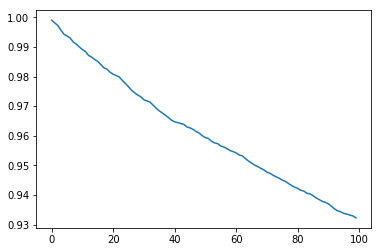

In [144]:
plt.plot(range(100),cost_lst)

In [148]:
def test_train_split(data,stim):
    unique, counts = np.unique(stim.flatten(), return_counts=True)
    count_dict=dict(zip(unique, counts))

    keys_with_enough_data=[]
    for key in count_dict.keys():
        if count_dict[key]==2:
            keys_with_enough_data.append(key)

    filtered_stims=np.isin(stim.flatten(),keys_with_enough_data)

    #Arrange data so that responses with the same stimulus are adjacent
    z=stim.flatten()[np.where(filtered_stims)[0]]
    sortd=np.argsort(z)
    istim=np.sort(z)
    X=data[filtered_stims,:]
    out=X[sortd,:].copy()

    x_train=out[::2,:]
    y_train=istim[::2]
    x_test=out[1::2,:]
    y_test=istim[1::2]
    
    return x_train, x_test, y_train, y_test

def evaluate_model(x_train,x_test):
    corr_mat=np.zeros((x_train.shape[0],x_train.shape[0]))
    for j in range(0,x_train.shape[0]):
        for i in range(0,x_test.shape[0]):
            corr_mat[j,i]=np.corrcoef(x_train[j,:],x_test[i,:])[0,1]
    print(np.mean(np.argmax(corr_mat, axis=0) == np.arange(0,x_train.shape[0],1,int)))

In [147]:
data=sio.loadmat('/home/maria/Documents/EnsemblePursuit/data/natimg2800_M170717_MP034_2017-09-11.mat')['stim']['resp'][0][0]
stim=sio.loadmat('/home/maria/Documents/EnsemblePursuit/data/natimg2800_M170717_MP034_2017-09-11.mat')['stim']['istim'][0][0]
x_train_baseline, x_test_baseline, y_train, y_test=test_train_split(data,stim)
print('Baseline')
evaluate_model(x_train_baseline,x_test_baseline)
x_train, x_test, y_train, y_test=test_train_split(U_V,stim)
evaluate_model(x_train,x_test)
    

Baseline


TypeError: arange: scalar arguments expected instead of a tuple.

In [159]:
stim=sio.loadmat('/home/maria/Documents/EnsemblePursuit/data/natimg2800_M170717_MP034_2017-09-11.mat')['stim']['istim'][0][0]
x_train, x_test, y_train, y_test=test_train_split(np.array(V.t()),stim)
evaluate_model(x_train,x_test)

0.0175


In [158]:
print(X.shape)
print(V.shape)

(5880, 10103)
torch.Size([100, 5880])
